In [202]:
import os
import numpy as np
import pandas as pd
from analysis import *

import numba
import random

from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE
import fastcluster


from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram
from hdbscan import HDBSCAN

from pyclustering.cluster.hsyncnet import *
from pyclustering.cluster.kmeans import *
from pyclustering.cluster.kmedians import *
from pyclustering.cluster.elbow import elbow

from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np

import seaborn as sns

In [2]:
NUM_CORES = 8
SUBSET_SIZE = 100000

## 1: Database Loading, Visualization, and Pre-Processing

### 1.1: Dataframe Creation
Create dataframes to store the SDSS MOC4 asteroid database, as well as Carvano's Taxonomy database of classified SDSS MOC4 asteroids.

In [3]:
sdss_df = import_sdss ("%s/Databases/SDSSMOC4/data/sdssmocadr4.tab" % os.getcwd())

# Drop information not relevant to this problem, along with the SMOC_ID, which just indicates
# an SDSS observation; one asteroid can have multiple SMOC_ID, so it isn't a useful identifier.
sdss_df.drop(labels=['OBJ_ID_RUN', 'OBJ_ID_COL', 'OBJ_ID_FIELD',
                     'OBJ_ID_OBJ', 'ROWC', 'COLC', 'JD_ZERO', 'RA',
                     'DEC', 'LAMBDA', 'BETA', 'PHI', 'VMU', 'VMU_ERROR',
                     'VNU', 'VNU_ERROR', 'VLAMBDA', 'VBETA', 'IDFLAG',
                     'RA_COMPUTED', 'DEC_COMPUTED', 'V_MAG_COMPUTED',
                     'R_DIST', 'G_DIST', 'OSC_CAT_ID', 'ARC',
                     'EPOCH_OSC', 'A_OSC', 'E_OSC', 'I_OSC', 'LON_OSC',
                     'AP_OSC', 'M_OSC', 'PROP_CAT_ID', 'A_PROP',
                     'E_PROP', 'SIN_I_PROP', 'B_MAG', 'H', 'G',
                     'A_MAG', 'A_ERR', 'SMOC_ID', 'PHASE', 'D_COUNTER', 
                     'TOTAL_D_COUNT'],
                     axis=1, inplace=True)

In [4]:
tax_df = import_tax("%s/Databases/SDSSTaxonomy/data/sdsstax_ast_table.tab" % os.getcwd())
tax_df.drop(labels=['AST_NAME', 'SCORE', 'NCLASS', 'METHOD', 'BAD',
                    'SEQUENCE', 'PROPER_SEMIMAJOR_AXIS',
                    'PROPER_ECCENTRICITY',
                    'SINE_OF_PROPER_INCLINATION',
                    'OSC_SEMIMAJOR_AXIS', 'OSC_ECCENTRICITY',
                    'OSC_INCLINATION'],
                     axis=1, inplace=True)

In [5]:
wave_mags = ["U_MAG", "G_MAG", "R_MAG", "I_MAG", "Z_MAG"]

wave_errs = ["U_ERR", "G_ERR", "R_ERR", "I_ERR", "Z_ERR"]

# Ensure data integrity. Every observation MUST have a U, G, R, I, and Z value, and associated error.
sdss_df.dropna(subset=wave_mags + wave_errs, inplace=True)

In [6]:
merged = merge(sdss_df, tax_df, ["PROV_ID", "AST_NUMBER"])
merged.reset_index(drop=True, inplace=True)

In [8]:
def grad(c1, c2, c1_base, c2_base):
    return -0.4*((c2 - c1) / (c2_base - c1_base))

def reflect(x, y):
    return -2.5*(np.log10(x) - np.log10(y))

In [10]:
merged["COLOR_U"] = reflect(merged["U_MAG"], merged["V_MAG"])
merged["COLOR_G"] = reflect(merged["G_MAG"], merged["V_MAG"])
merged["COLOR_R"] = reflect(merged["R_MAG"], merged["V_MAG"])
merged["COLOR_I"] = reflect(merged["I_MAG"], merged["V_MAG"])
merged["COLOR_Z"] = reflect(merged["Z_MAG"], merged["V_MAG"])

merged["G_REFL"] = grad(merged["COLOR_G"], merged["COLOR_U"], 0.354, 0.477)
merged["R_REFL"] = grad(merged["COLOR_U"], merged["COLOR_R"], 0.477, 0.623)
merged["I_REFL"] = grad(merged["COLOR_R"], merged["COLOR_I"], 0.623, 0.763)
merged["Z_REFL"] = grad(merged["COLOR_I"], merged["COLOR_Z"], 0.763, 0.913)


wave_mags = ["G_REFL", "R_REFL", "I_REFL", "Z_REFL"]

In [9]:
merged["COLOR_U"] = merged["U_MAG"] - merged["G_MAG"] - 1.32
merged["COLOR_G"] = merged["G_MAG"] - merged["R_MAG"] - 0.45
merged["COLOR_R"] = merged["R_MAG"] - merged["I_MAG"] - 0.10
merged["COLOR_I"] = merged["I_MAG"] - merged["Z_MAG"] - 0.04

merged["G_REFL"] = grad(merged["COLOR_G"], merged["COLOR_U"], 0.354, 0.477)
merged["R_REFL"] = grad(merged["COLOR_U"], merged["COLOR_R"], 0.477, 0.623)
merged["I_REFL"] = grad(merged["COLOR_R"], merged["COLOR_I"], 0.623, 0.763)
wave_mags = ["G_REFL", "R_REFL", "I_REFL"]

In [10]:
merged

U_MAG  U_ERR  G_MAG  G_ERR  R_MAG  R_ERR  I_MAG  I_ERR  Z_MAG  Z_ERR  \
0       21.81   0.20  20.32   0.04  19.77   0.02  19.56   0.03  19.44   0.14   
1       22.04   0.23  20.36   0.03  19.82   0.03  19.66   0.03  19.44   0.11   
2       19.69   0.03  17.91   0.02  17.32   0.01  17.10   0.02  17.05   0.03   
3       21.83   0.16  19.82   0.02  19.16   0.02  18.94   0.02  19.02   0.06   
4       22.40   0.24  20.40   0.02  19.73   0.02  19.47   0.03  19.76   0.10   
5       21.96   0.17  20.30   0.03  19.95   0.03  19.73   0.03  19.71   0.10   
6       21.33   0.14  20.00   0.02  19.49   0.02  19.34   0.02  19.33   0.05   
7       21.54   0.12  19.66   0.02  19.09   0.02  18.96   0.03  18.85   0.05   
8       20.74   0.06  18.96   0.02  18.29   0.01  18.05   0.02  18.12   0.03   
9       20.75   0.19  18.99   0.02  18.32   0.01  18.13   0.02  18.19   0.04   
10      21.74   0.13  19.89   0.02  19.14   0.02  18.92   0.03  18.85   0.04   
11      23.39   0.72  21.69   0.07  20.93   0.04  20.54   0.06  20.82   0.25   
12      22.02   0.16  20.72   0.04  20.15   0.03  20.01   0.03  19.91   0.11   
13      24.62   2.30  21.11   0.08  20.50   0.05  20.25   0.06  20.32   0.22   
14      21.26   0.09  19.31   0.03  18.63   0.02  18.41   0.02  18.49   0.04   
15      20.53   0.12  18.84   0.02  18.23   0.01  18.02   0.02  18.06   0.03   
16      21.22   0.10  19.60   0.02  18.94   0.02  18.75   0.02  18.73   0.04   
17      21.25   0.10  19.48   0.02  18.79   0.02  18.61   0.02  18.73   0.04   
18      21.79   0.39  19.68   0.03  19.09   0.02  18.92   0.03  18.85   0.06   
19      21.10   0.08  19.57   0.02  19.09   0.02  19.02   0.02  18.95   0.05   
20      20.88   0.16  19.54   0.03  19.09   0.02  18.99   0.03  18.75   0.06   
21      21.03   0.08  19.27   0.02  18.51   0.01  18.33   0.02  18.28   0.03   
22      21.89   0.17  20.11   0.03  19.39   0.02  19.30   0.02  19.77   0.10   
23      22.82   0.88  20.38   0.04  19.64   0.03  19.52   0.03  19.97   0.17   
24      21.34   0.15  19.90   0.03  19.42   0.02  19.35   0.03  19.22   0.06   
25      22.15   0.19  20.66   0.03  20.05   0.03  19.82   0.03  19.95   0.10   
26      22.07   1.07  20.81   0.03  20.14   0.03  19.96   0.04  20.43   0.19   
27      22.25   0.21  20.55   0.03  20.05   0.03  19.86   0.03  19.94   0.10   
28      22.62   0.27  21.16   0.05  20.55   0.03  20.28   0.04  20.25   0.12   
29      22.09   0.18  20.62   0.03  20.06   0.03  19.91   0.03  19.98   0.10   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
146570  20.11   0.05  18.18   0.02  17.54   0.02  17.36   0.01  17.69   0.19   
146571  22.11   0.25  20.17   0.03  19.48   0.05  19.25   0.03  19.32   0.37   
146572  21.30   0.13  19.53   0.02  18.80   0.02  18.57   0.02  18.60   0.05   
146573  18.40   0.02  16.82   0.01  16.38   0.02  16.23   0.02  16.25   0.03   
146574  21.19   0.11  19.64   0.03  19.13   0.04  19.08   0.04  19.04   0.07   
146575  21.36   0.15  19.75   0.02  19.20   0.03  18.94   0.04  18.99   0.43   
146576  21.80   1.07  19.94   0.02  19.34   0.02  19.13   0.03  19.05   0.07   
146577  21.59   0.15  19.93   0.02  19.30   0.02  19.10   0.02  19.18   0.07   
146578  22.49   0.39  20.79   0.03  20.12   0.03  19.89   0.04  19.85   0.12   
146579  22.43   0.30  20.67   0.03  20.00   0.03  19.76   0.03  19.69   0.11   
146580  21.25   0.11  19.79   0.02  19.31   0.02  19.19   0.02  19.13   0.07   
146581  20.56   0.06  18.77   0.02  18.10   0.01  17.87   0.02  17.96   0.03   
146582  21.17   0.10  19.22   0.02  18.57   0.01  18.34   0.02  18.39   0.04   
146583  21.38   0.13  19.91   0.03  19.42   0.02  19.26   0.03  19.20   0.07   
146584  22.87   0.40  20.68   0.03  20.08   0.03  19.83   0.04  19.81   0.11   
146585  20.82   0.07  19.02   0.03  18.38   0.02  18.18   0.02  18.23   0.38   
146586  19.55   0.03  17.79   0.02  17.13   0.02  16.89   0.01  17.01   0.04   
146587  20.62   0.08  19.15   0.02  18.71   0.01  18.57   0.02  18.58   0.04   
146588  

In [11]:
training_data = merged[wave_mags].values[:SUBSET_SIZE]

### 1.2: Visualization
We use the T-distributed Stochastic Neighbor Embedding (TSNE) dimensionality reduction algorithm to represent our 5D data as a 2D graph, as PCA seems overdone.

In [12]:
# This takes a while.
merged_projection = TSNE(n_jobs=NUM_CORES).fit_transform(training_data)

... And then we do PCA anyway.

In [13]:
merged_pca_projection = PCA(n_components=2).fit_transform(training_data)

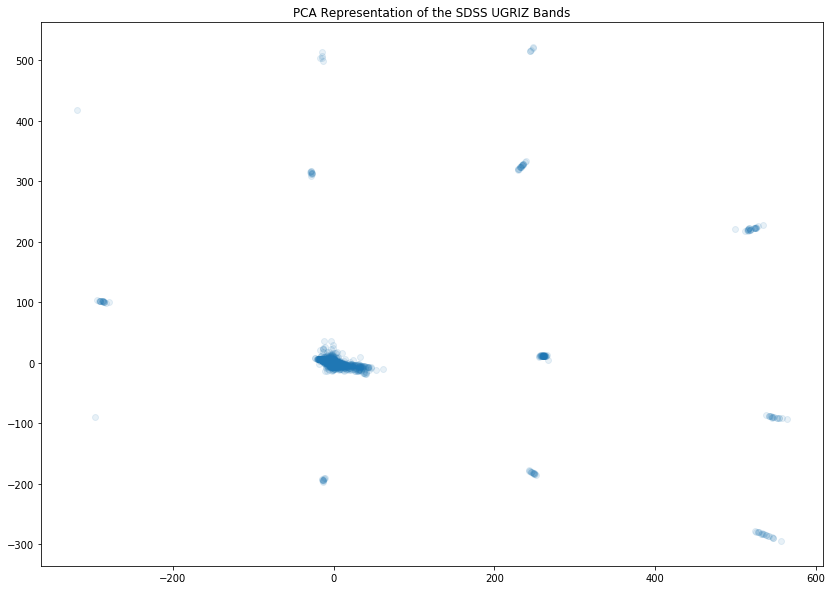

In [14]:
# PCA plot
plt.figure(figsize=(14, 10))
plt.scatter(merged_pca_projection[:,0],
            merged_pca_projection[:,1], alpha=0.1)
plt.title("PCA Representation of the SDSS UGRIZ Bands")
plt.show()

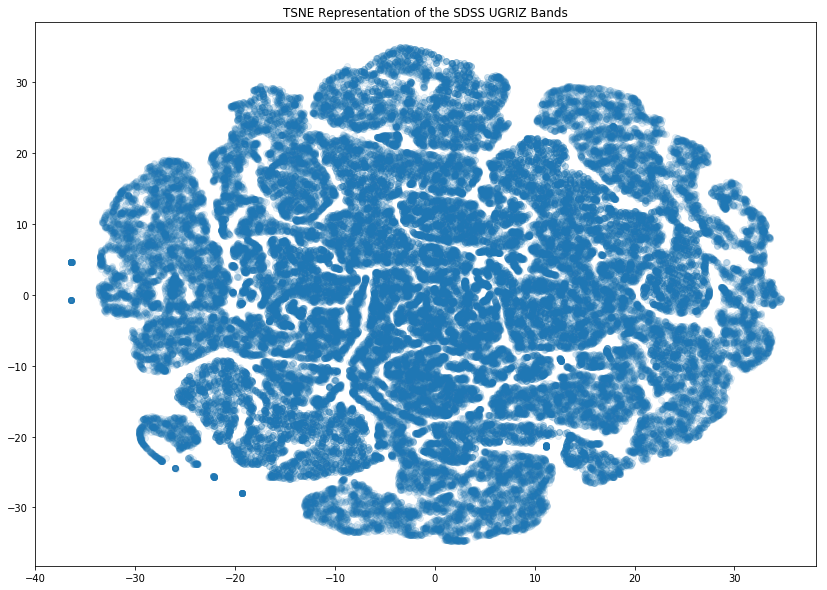

In [15]:
# TSNE plot
plt.figure(figsize=(14, 10))
plt.scatter(*merged_projection.T, alpha=0.1)
plt.title("TSNE Representation of the SDSS UGRIZ Bands")
plt.show()

In [16]:
# Calculate colorings for Carvano's classification
unique_tax = merged["CLASSIFICATION"][:SUBSET_SIZE].unique()
tax_color_dict = dict(zip(unique_tax, list(range(len(unique_tax)))))

color_palette = sns.color_palette('Paired', len(unique_tax))

cluster_colors = [color_palette[tax_color_dict[x]] if tax_color_dict[x] >= 0
                  else (0.5, 0.5, 0.5)
                  for x in merged["CLASSIFICATION"][:SUBSET_SIZE]]

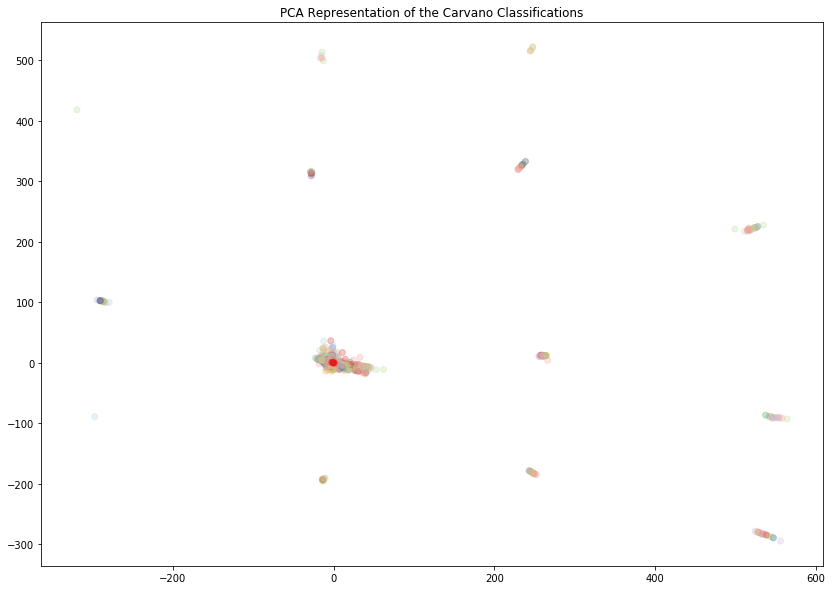

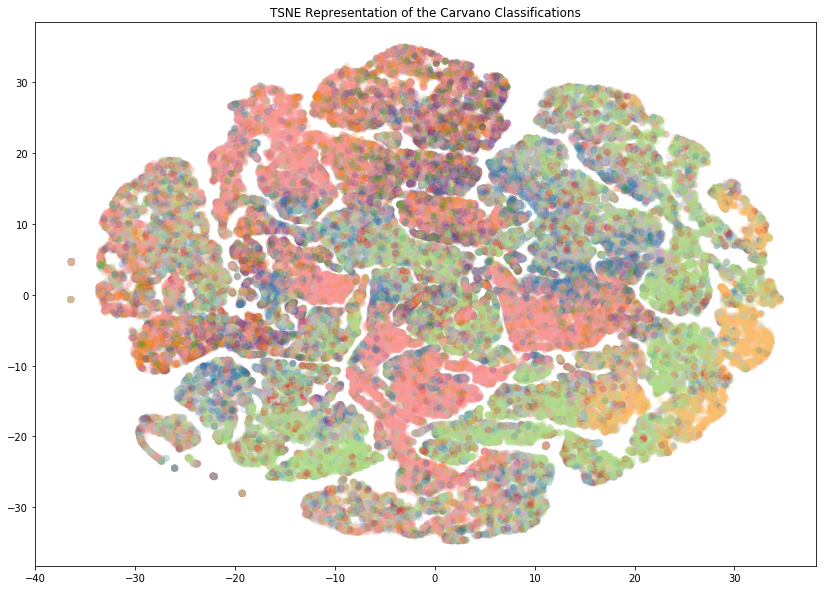

In [17]:
# Plot PCA and TSNE

# PCA plot
plt.figure(figsize=(14, 10))
plt.scatter(merged_pca_projection[:,0],
            merged_pca_projection[:,1],
            c=cluster_colors, alpha=0.25)
plt.title("PCA Representation of the Carvano Classifications")
plt.show()

# TSNE plot
plt.figure(figsize=(14, 10))
plt.scatter(*merged_projection.T, s=50, linewidth=0,
            c=cluster_colors, alpha=0.25)
plt.title("TSNE Representation of the Carvano Classifications")
plt.show()

## 2: Elbow Method
Manual computation of clusters, in the form of the equation

$$
Elbow_{k} = \frac{\left ( y_{0} - y_{1} \right )x_{k} + \left ( x_{1} - x_{0} \right )y_{k} + \left ( x_{0}y_{1} - x_{1}y_{0} \right )}{\sqrt{\left ( x_{1} - x_{0} \right )^{2} + \left ( y_{1} - y_{0} \right )^{2}}}
$$

given a kmin-point ($x_0$, $y_0$) the kmax-point ($x_1$, $y_1$), the value $x_k$, the amount of clusters, and $y_k$, the within-cluster error.

In [18]:
# Initialize the Elbox algorithm testing 1 to 20 clusters.
kmin, kmax = 1, 20
elbow_instance = elbow(training_data, kmin, kmax)

In [19]:
# process input data and obtain results of analysis
elbow_instance.process()
amount_clusters = elbow_instance.get_amount()

In [20]:
amount_clusters

7

In [21]:
# perform cluster analysis using K-Means algorithm
centers = kmeans_plusplus_initializer(training_data, amount_clusters).initialize()
kmeans_instance = kmeans(training_data, centers)
kmeans_instance.process()

In [22]:
# obtain clustering results and visualize them
elbow_clusters = kmeans_instance.get_clusters()
elbow_centers = kmeans_instance.get_centers()

In [23]:
# Now, compare against Carvano.
apply_classification(merged, elbow_clusters, "ELBOW_CLASSIFICATION")

In [24]:
color_palette = sns.color_palette('Paired', len(elbow_clusters))
cluster_colors = [(0, 0, 0)] * SUBSET_SIZE

for idx, arr in enumerate(elbow_clusters):
    for sub_index in arr:
        cluster_colors[sub_index] = color_palette[idx]

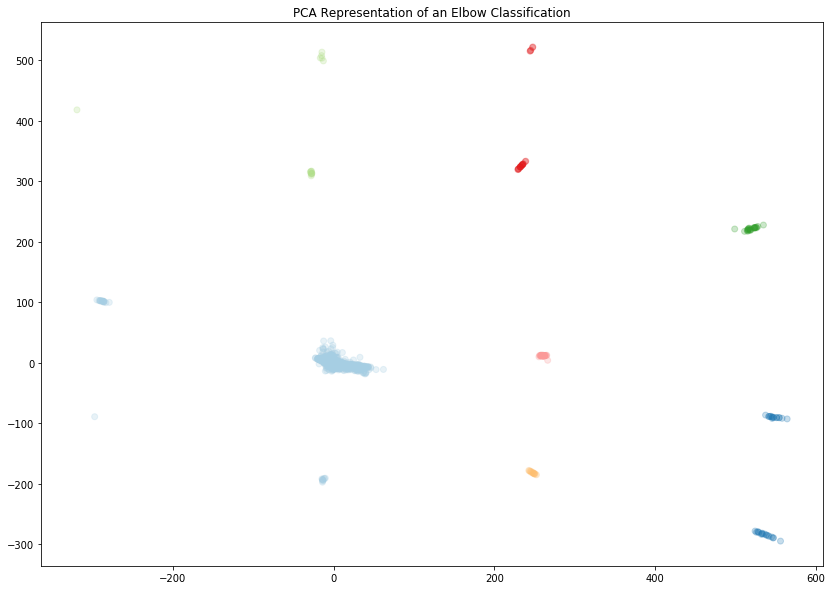

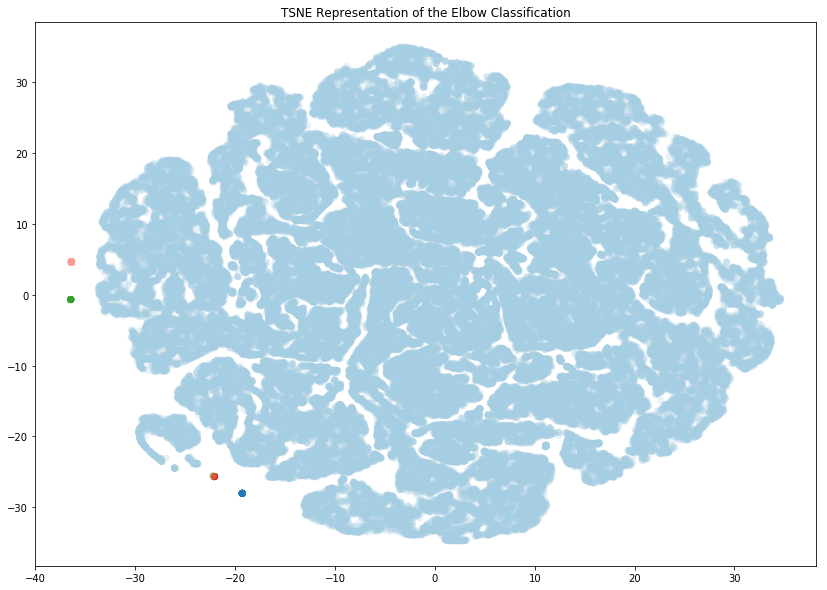

In [25]:
# PCA plot
plt.figure(figsize=(14, 10))
plt.scatter(merged_pca_projection[:,0],
            merged_pca_projection[:,1],
            c=cluster_colors, alpha=0.25)
plt.title("PCA Representation of an Elbow Classification")
plt.show()

# TSNE plot
plt.figure(figsize=(14, 10))
plt.scatter(*merged_projection.T, s=50, linewidth=0,
            c=cluster_colors, alpha=0.25)
plt.title("TSNE Representation of the Elbow Classification")
plt.show()

## 3: K-Means++
Now, we do a graphical analysis to determine the number of clusters.

In [26]:
# Use k-means++ to guess centers
run_bound = 25
run_max = 10

all_args = [(training_data, i) for i in range(1, run_bound)]

with Pool(8) as p:
    all_output = [p.starmap(k_means_pp, all_args) for i in range(run_max)]

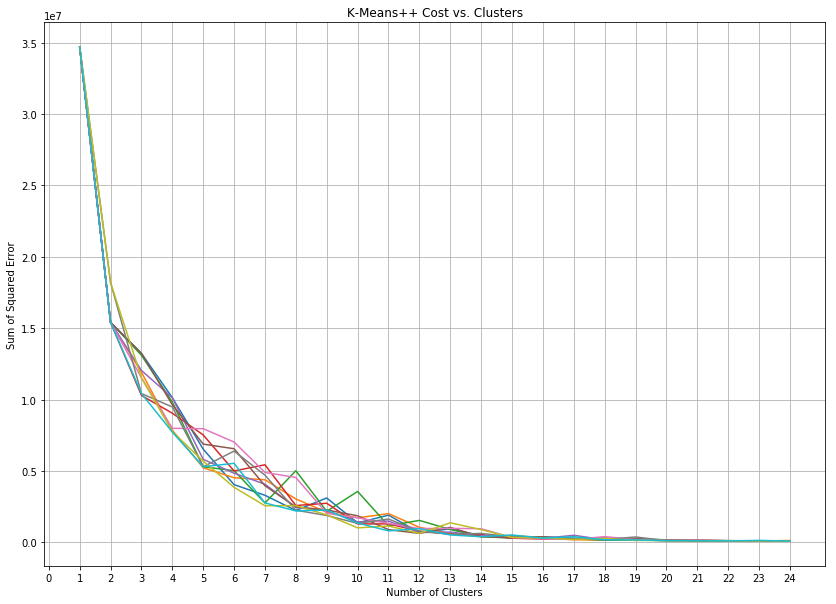

In [27]:
fig = plt.figure(figsize=(14,10))
for i in range(run_max):
    # Get the full resample i's array of errors.
    err = [all_output[i][j][1] for j in range(run_bound - 1)]
    plt.plot(range(len(err) + 1), [None,] + err)
    
ax = fig.gca()
ax.set_xticks(numpy.arange(0, 25, 1))
plt.title("K-Means++ Cost vs. Clusters")
plt.ylabel("Sum of Squared Error")
plt.xlabel("Number of Clusters")
plt.grid()
plt.show()

In [28]:
graphical_clusters = 16

In [29]:
# perform cluster analysis using K-Means algorithm
centers = kmeans_plusplus_initializer(training_data, graphical_clusters).initialize()
kmeans_instance = kmeans(training_data, centers)
kmeans_instance.process()

In [30]:
# obtain clustering results and visualize them
kmeans_clusters = kmeans_instance.get_clusters()
kmeans_centers = kmeans_instance.get_centers()

In [31]:
# Now, compare against Carvano.
apply_classification(merged, kmeans_clusters, "KMEANS_CLASSIFICATION")

In [32]:
color_palette = sns.color_palette('Paired', len(kmeans_clusters))
cluster_colors = [(0, 0, 0)] * SUBSET_SIZE

for idx, arr in enumerate(kmeans_clusters):
    for sub_index in arr:
        cluster_colors[sub_index] = color_palette[idx]

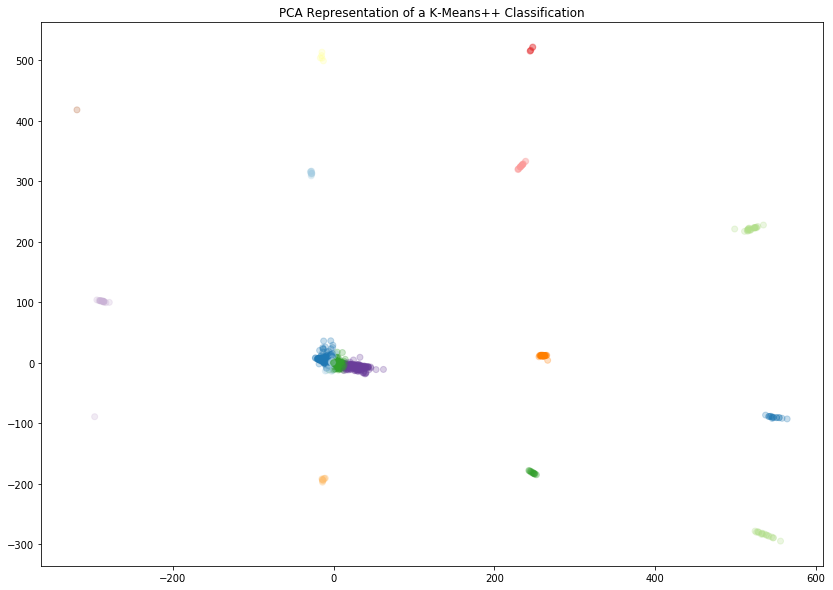

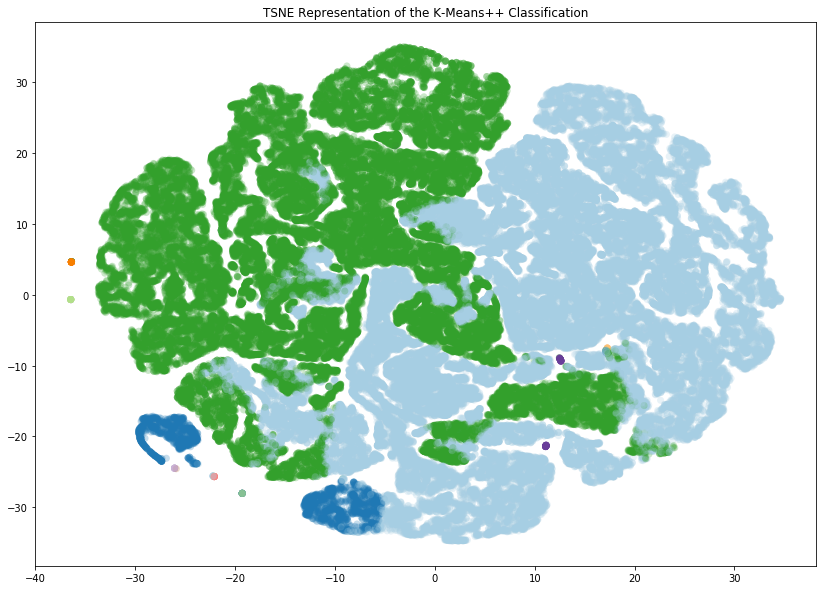

In [33]:
# PCA plot
plt.figure(figsize=(14, 10))
plt.scatter(merged_pca_projection[:,0],
            merged_pca_projection[:,1],
            c=cluster_colors, alpha=0.25)
plt.title("PCA Representation of a K-Means++ Classification")
plt.show()

# TSNE plot
plt.figure(figsize=(14, 10))
plt.scatter(*merged_projection.T, s=50, linewidth=0,
            c=cluster_colors, alpha=0.25)
plt.title("TSNE Representation of the K-Means++ Classification")
plt.show()

## 4: HDBSCAN

In [206]:
# Create HDBSCAN algorithm instance for cluster analysis
# chebyshev
# cityblock
# infinity
# l1
hdbscan_instance = HDBSCAN(min_cluster_size=15, metric='chebyshev').fit(training_data)

/home/ben/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/ben/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/ben/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/ben/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


In [207]:
hdbscan_instance.labels_.max()

37

In [208]:
hdbscan_clusters = [np.where(hdbscan_instance.labels_ == i)[0] for i in range(-1, hdbscan_instance.labels_.max())]

In [209]:
# Now, compare against Carvano.
apply_classification(merged, hdbscan_clusters, "HDBSCAN_CLASSIFICATION")

In [210]:
color_palette = sns.color_palette('Paired', len(hdbscan_clusters))
cluster_colors = [(0, 0, 0)] * SUBSET_SIZE

for idx, arr in enumerate(hdbscan_clusters):
    for sub_index in arr:
        cluster_colors[sub_index] = color_palette[idx]

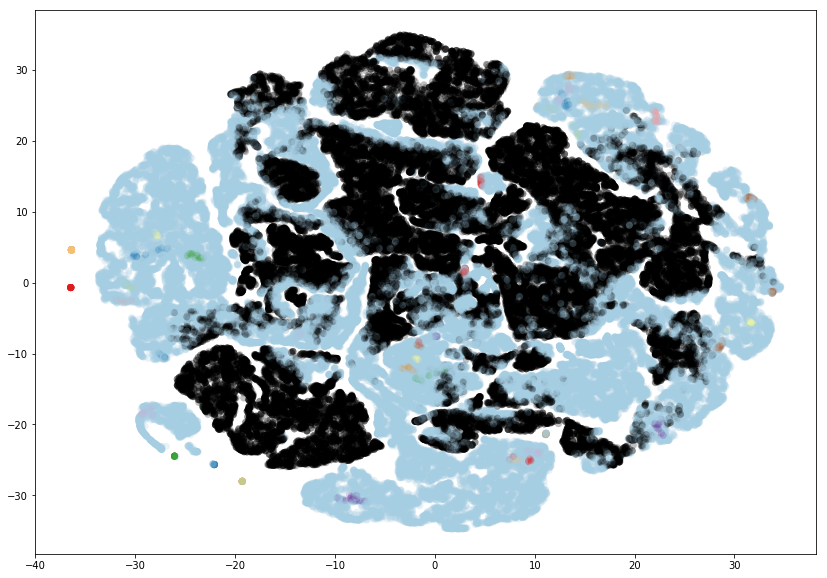

In [211]:
plt.figure(figsize=(14, 10))
plt.scatter(*merged_projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

## 5: Agglomerative

In [64]:
# Get an idea of dendogram relations
examination_data = random.sample(list(training_data), 25)
links = fastcluster.linkage_vector(examination_data, method='ward')

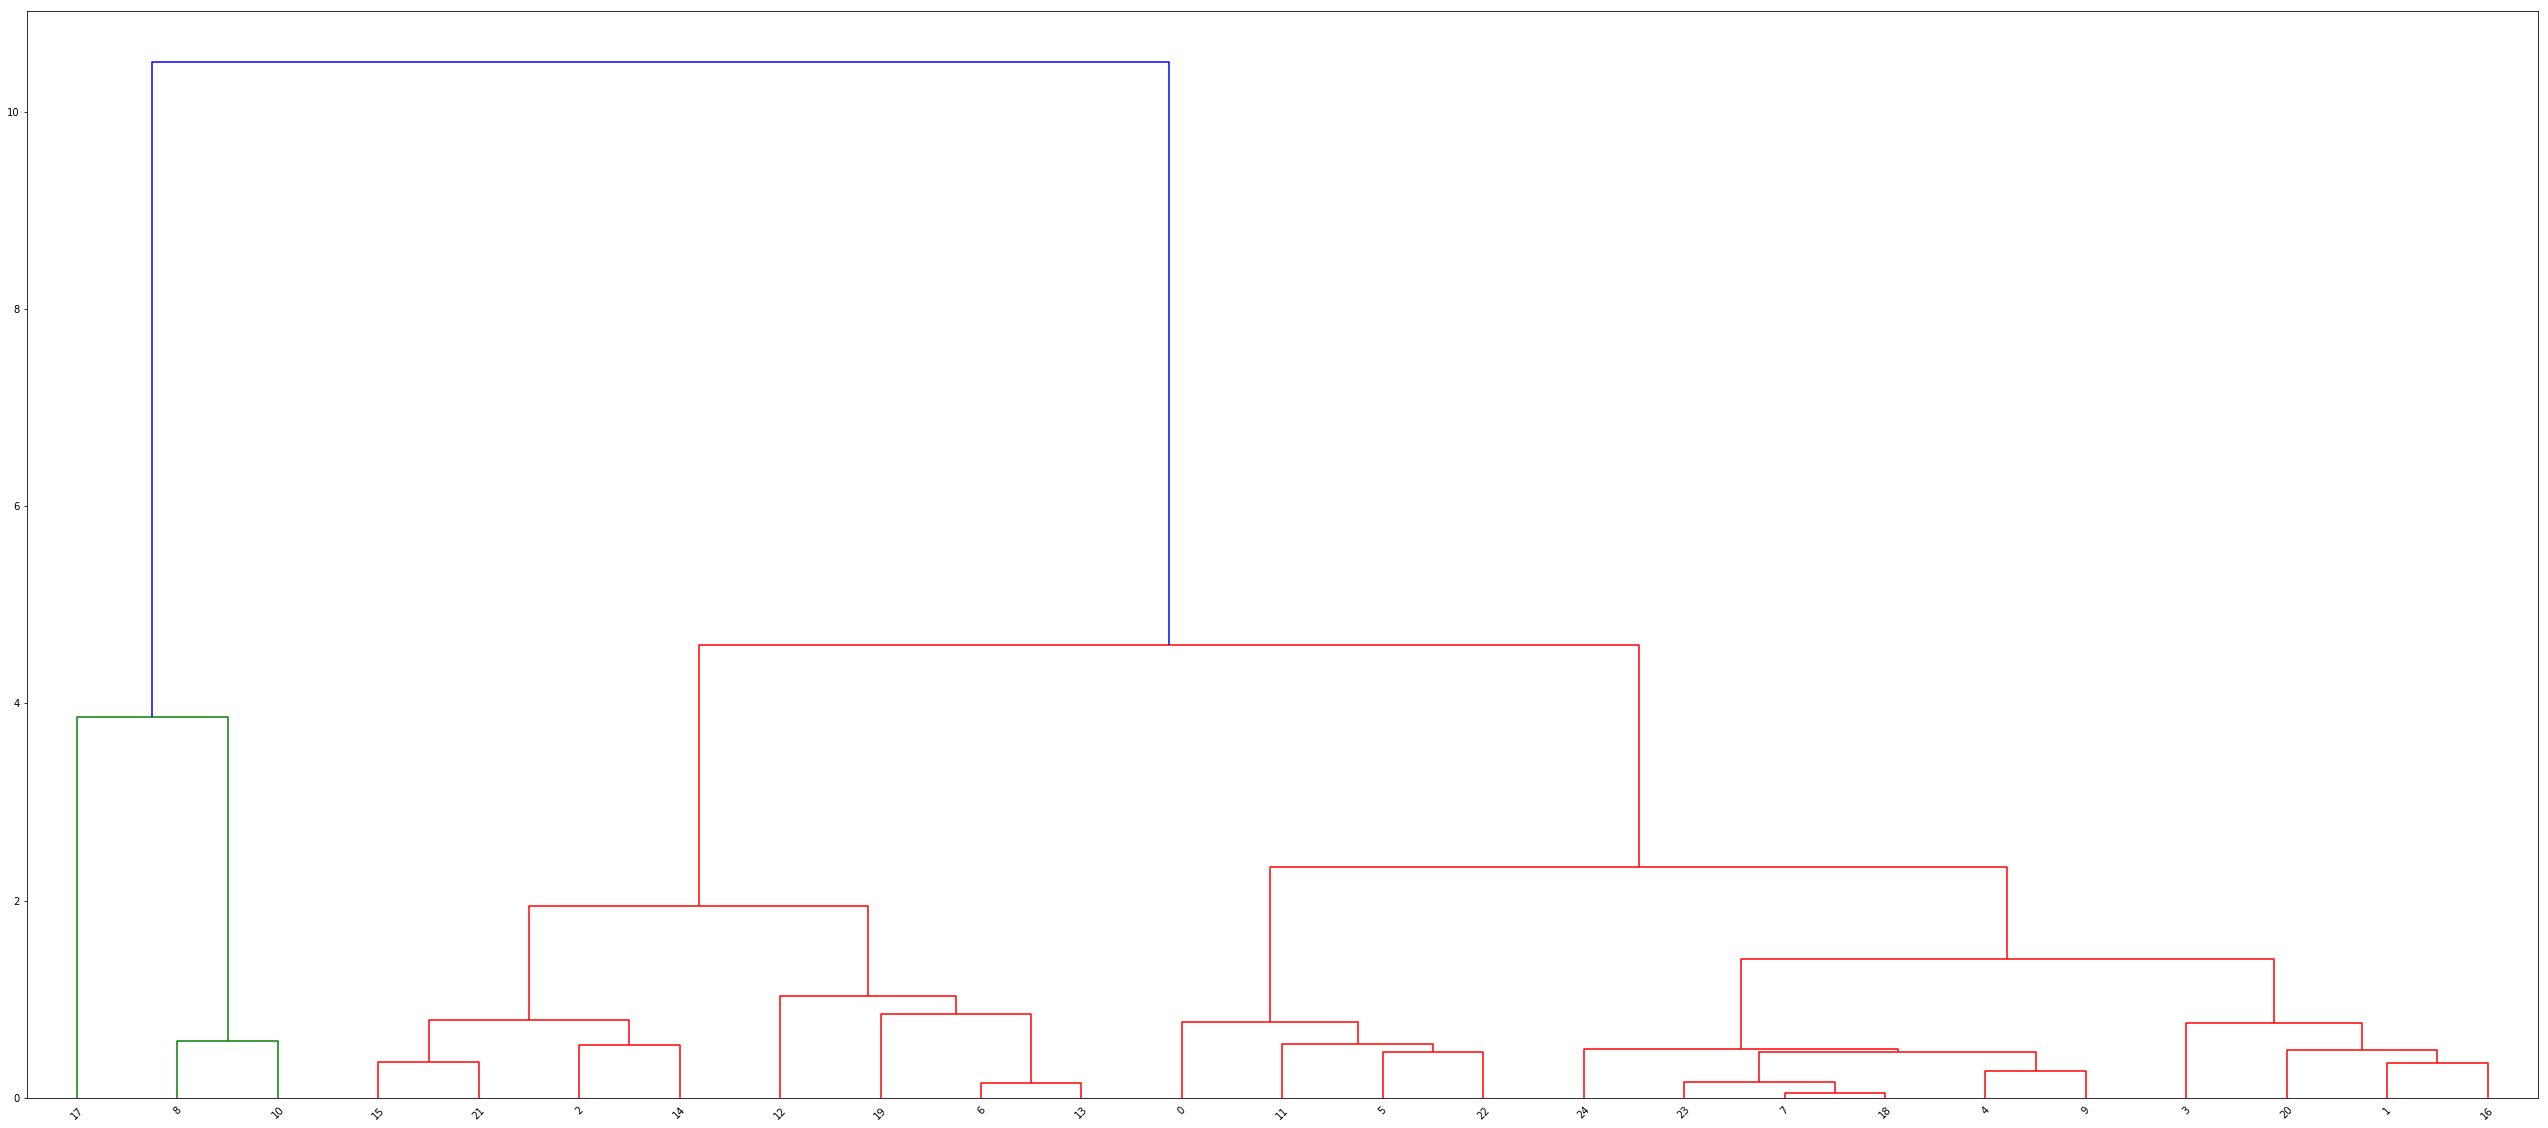

In [65]:
fig = plt.figure(figsize=(45, 20))
dn = dendrogram(links)
plt.show()

In [42]:
links = fastcluster.linkage_vector(training_data, method='ward')

In [48]:
#clusters = fcluster(links, 300, criterion='distance')
clusters = fcluster(links, 16, criterion='maxclust')
np.max(clusters)

16

In [49]:
agglomerative_clusters = np.array([np.where(clusters == i)[0] for i in range(np.max(clusters))])

In [50]:
# Now, compare against Carvano.
apply_classification(merged, agglomerative_clusters, "AGGLOMERATIVE_CLASSIFICATION")

In [51]:
color_palette = sns.color_palette('Paired', len(agglomerative_clusters))
cluster_colors = [(0, 0, 0)] * SUBSET_SIZE

for idx, arr in enumerate(agglomerative_clusters):
    for sub_index in arr:
        cluster_colors[sub_index] = color_palette[idx]

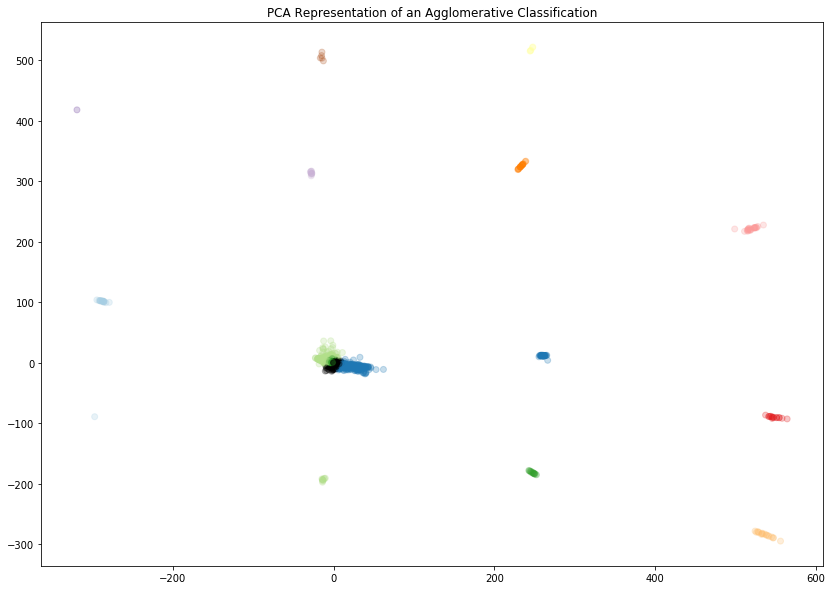

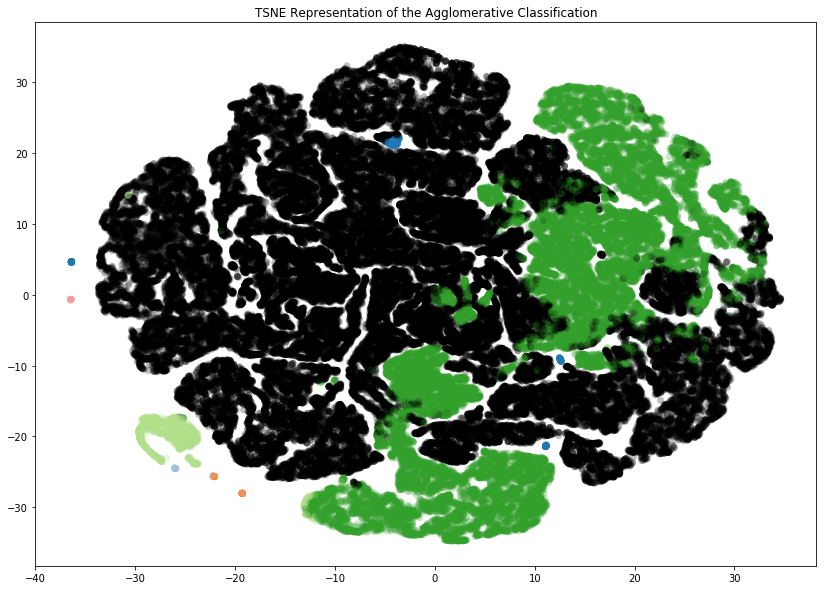

In [52]:
# PCA plot
plt.figure(figsize=(14, 10))
plt.scatter(merged_pca_projection[:,0],
            merged_pca_projection[:,1],
            c=cluster_colors, alpha=0.25)
plt.title("PCA Representation of an Agglomerative Classification")
plt.show()

# TSNE plot
plt.figure(figsize=(14, 10))
plt.scatter(*merged_projection.T, s=50, linewidth=0,
            c=cluster_colors, alpha=0.25)
plt.title("TSNE Representation of the Agglomerative Classification")
plt.show()

In [126]:
links = fastcluster.linkage_vector(merged_projection, method='ward')

In [142]:
#clusters = fcluster(links, 300, criterion='distance')
clusters = fcluster(links, 8, criterion='maxclust')
np.max(clusters)

8

In [143]:
agglomerative_clusters = np.array([np.where(clusters == i)[0] for i in range(np.max(clusters))])

In [144]:
# Now, compare against Carvano.
apply_classification(merged, agglomerative_clusters, "TSNE_AGGLOMERATIVE_CLASSIFICATION")

In [145]:
color_palette = sns.color_palette('Paired', len(agglomerative_clusters))
cluster_colors = [(0, 0, 0)] * SUBSET_SIZE

for idx, arr in enumerate(agglomerative_clusters):
    for sub_index in arr:
        cluster_colors[sub_index] = color_palette[idx]

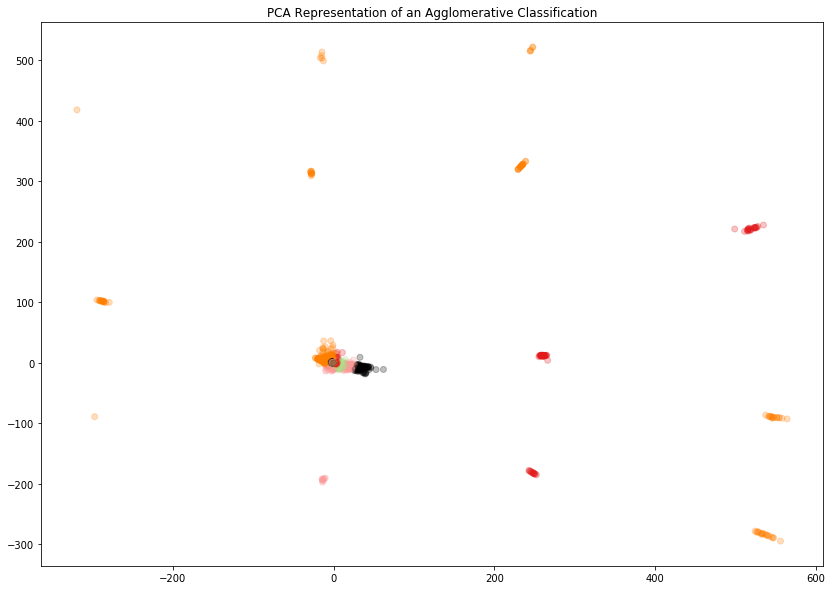

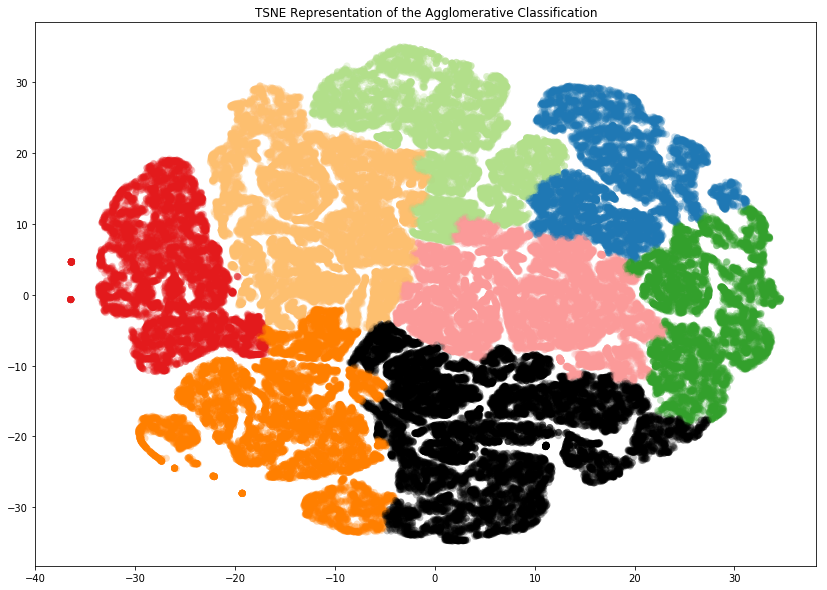

In [146]:
# PCA plot
plt.figure(figsize=(14, 10))
plt.scatter(merged_pca_projection[:,0],
            merged_pca_projection[:,1],
            c=cluster_colors, alpha=0.25)
plt.title("PCA Representation of an Agglomerative Classification")
plt.show()

# TSNE plot
plt.figure(figsize=(14, 10))
plt.scatter(*merged_projection.T, s=50, linewidth=0,
            c=cluster_colors, alpha=0.25)
plt.title("TSNE Representation of the Agglomerative Classification")
plt.show()

Observations:
1. Given the corrections specified, Carvano's classifications do not appear to be functions of asteroid groupings.
2. In all cases, Carvano's classifications are not functions of cluster density.
3. There is considerable noise in the data, as well as a large amount of outliers.
4. It is ambiguous if further correction would lead to improved clustering.
5. It is similarly ambiguous if the homogeneity of the 400K asteroids indicate they are a single group or not.

Verdict:
1. It is unclear if unsupervised learning is a scientifically valid approach for composition classification of the SDSS.
2. If it is, there are 6-8 distinct compositions present.


In [264]:
import sys

@numba.jit
def get_consistency (df, id_colname, classification_colname, consistency_colname):
    unique = df[id_colname].unique()
    unique_len = len(unique)
    count = 0
    for unique_ast in unique:
        print(count, "of", unique_len, "finished", flush=True)
        idx = (df[id_colname] == unique_ast)
    
        div = len(df.loc[idx, classification_colname])
        num = df.loc[idx, classification_colname].value_counts().max()
        df.loc[idx, consistency_colname] = num / div
        count += 1

In [265]:
get_consistency(merged, 'MOID', 'KMEANS_CLASSIFICATION', 'KMEANS_CONSISTENCY')
print("Finished K-Means")
get_consistency(merged, 'MOID', 'HDBSCAN_CLASSIFICATION', 'HDBSCAN_CONSISTENCY')

0 of 59590 finished
1 of 59590 finished
2 of 59590 finished
3 of 59590 finished
4 of 59590 finished
5 of 59590 finished
6 of 59590 finished
7 of 59590 finished
8 of 59590 finished
9 of 59590 finished
10 of 59590 finished
11 of 59590 finished
12 of 59590 finished
13 of 59590 finished
14 of 59590 finished
15 of 59590 finished
16 of 59590 finished
17 of 59590 finished
18 of 59590 finished
19 of 59590 finished
20 of 59590 finished
21 of 59590 finished
22 of 59590 finished
23 of 59590 finished
24 of 59590 finished
25 of 59590 finished
26 of 59590 finished
27 of 59590 finished
28 of 59590 finished
29 of 59590 finished
30 of 59590 finished
31 of 59590 finished
32 of 59590 finished
33 of 59590 finished
34 of 59590 finished
35 of 59590 finished
36 of 59590 finished
37 of 59590 finished
38 of 59590 finished
39 of 59590 finished
40 of 59590 finished
41 of 59590 finished
42 of 59590 finished
43 of 59590 finished
44 of 59590 finished
45 of 59590 finished
46 of 59590 finished
47 of 59590 finished
48

378 of 59590 finished
379 of 59590 finished
380 of 59590 finished
381 of 59590 finished
382 of 59590 finished
383 of 59590 finished
384 of 59590 finished
385 of 59590 finished
386 of 59590 finished
387 of 59590 finished
388 of 59590 finished
389 of 59590 finished
390 of 59590 finished
391 of 59590 finished
392 of 59590 finished
393 of 59590 finished
394 of 59590 finished
395 of 59590 finished
396 of 59590 finished
397 of 59590 finished
398 of 59590 finished
399 of 59590 finished
400 of 59590 finished
401 of 59590 finished
402 of 59590 finished
403 of 59590 finished
404 of 59590 finished
405 of 59590 finished
406 of 59590 finished
407 of 59590 finished
408 of 59590 finished
409 of 59590 finished
410 of 59590 finished
411 of 59590 finished
412 of 59590 finished
413 of 59590 finished
414 of 59590 finished
415 of 59590 finished
416 of 59590 finished
417 of 59590 finished
418 of 59590 finished
419 of 59590 finished
420 of 59590 finished
421 of 59590 finished
422 of 59590 finished
423 of 595

751 of 59590 finished
752 of 59590 finished
753 of 59590 finished
754 of 59590 finished
755 of 59590 finished
756 of 59590 finished
757 of 59590 finished
758 of 59590 finished
759 of 59590 finished
760 of 59590 finished
761 of 59590 finished
762 of 59590 finished
763 of 59590 finished
764 of 59590 finished
765 of 59590 finished
766 of 59590 finished
767 of 59590 finished
768 of 59590 finished
769 of 59590 finished
770 of 59590 finished
771 of 59590 finished
772 of 59590 finished
773 of 59590 finished
774 of 59590 finished
775 of 59590 finished
776 of 59590 finished
777 of 59590 finished
778 of 59590 finished
779 of 59590 finished
780 of 59590 finished
781 of 59590 finished
782 of 59590 finished
783 of 59590 finished
784 of 59590 finished
785 of 59590 finished
786 of 59590 finished
787 of 59590 finished
788 of 59590 finished
789 of 59590 finished
790 of 59590 finished
791 of 59590 finished
792 of 59590 finished
793 of 59590 finished
794 of 59590 finished
795 of 59590 finished
796 of 595

1119 of 59590 finished
1120 of 59590 finished
1121 of 59590 finished
1122 of 59590 finished
1123 of 59590 finished
1124 of 59590 finished
1125 of 59590 finished
1126 of 59590 finished
1127 of 59590 finished
1128 of 59590 finished
1129 of 59590 finished
1130 of 59590 finished
1131 of 59590 finished
1132 of 59590 finished
1133 of 59590 finished
1134 of 59590 finished
1135 of 59590 finished
1136 of 59590 finished
1137 of 59590 finished
1138 of 59590 finished
1139 of 59590 finished
1140 of 59590 finished
1141 of 59590 finished
1142 of 59590 finished
1143 of 59590 finished
1144 of 59590 finished
1145 of 59590 finished
1146 of 59590 finished
1147 of 59590 finished
1148 of 59590 finished
1149 of 59590 finished
1150 of 59590 finished
1151 of 59590 finished
1152 of 59590 finished
1153 of 59590 finished
1154 of 59590 finished
1155 of 59590 finished
1156 of 59590 finished
1157 of 59590 finished
1158 of 59590 finished
1159 of 59590 finished
1160 of 59590 finished
1161 of 59590 finished
1162 of 595

1476 of 59590 finished
1477 of 59590 finished
1478 of 59590 finished
1479 of 59590 finished
1480 of 59590 finished
1481 of 59590 finished
1482 of 59590 finished
1483 of 59590 finished
1484 of 59590 finished
1485 of 59590 finished
1486 of 59590 finished
1487 of 59590 finished
1488 of 59590 finished
1489 of 59590 finished
1490 of 59590 finished
1491 of 59590 finished
1492 of 59590 finished
1493 of 59590 finished
1494 of 59590 finished
1495 of 59590 finished
1496 of 59590 finished
1497 of 59590 finished
1498 of 59590 finished
1499 of 59590 finished
1500 of 59590 finished
1501 of 59590 finished
1502 of 59590 finished
1503 of 59590 finished
1504 of 59590 finished
1505 of 59590 finished
1506 of 59590 finished
1507 of 59590 finished
1508 of 59590 finished
1509 of 59590 finished
1510 of 59590 finished
1511 of 59590 finished
1512 of 59590 finished
1513 of 59590 finished
1514 of 59590 finished
1515 of 59590 finished
1516 of 59590 finished
1517 of 59590 finished
1518 of 59590 finished
1519 of 595

1833 of 59590 finished
1834 of 59590 finished
1835 of 59590 finished
1836 of 59590 finished
1837 of 59590 finished
1838 of 59590 finished
1839 of 59590 finished
1840 of 59590 finished
1841 of 59590 finished
1842 of 59590 finished
1843 of 59590 finished
1844 of 59590 finished
1845 of 59590 finished
1846 of 59590 finished
1847 of 59590 finished
1848 of 59590 finished
1849 of 59590 finished
1850 of 59590 finished
1851 of 59590 finished
1852 of 59590 finished
1853 of 59590 finished
1854 of 59590 finished
1855 of 59590 finished
1856 of 59590 finished
1857 of 59590 finished
1858 of 59590 finished
1859 of 59590 finished
1860 of 59590 finished
1861 of 59590 finished
1862 of 59590 finished
1863 of 59590 finished
1864 of 59590 finished
1865 of 59590 finished
1866 of 59590 finished
1867 of 59590 finished
1868 of 59590 finished
1869 of 59590 finished
1870 of 59590 finished
1871 of 59590 finished
1872 of 59590 finished
1873 of 59590 finished
1874 of 59590 finished
1875 of 59590 finished
1876 of 595

2190 of 59590 finished
2191 of 59590 finished
2192 of 59590 finished
2193 of 59590 finished
2194 of 59590 finished
2195 of 59590 finished
2196 of 59590 finished
2197 of 59590 finished
2198 of 59590 finished
2199 of 59590 finished
2200 of 59590 finished
2201 of 59590 finished
2202 of 59590 finished
2203 of 59590 finished
2204 of 59590 finished
2205 of 59590 finished
2206 of 59590 finished
2207 of 59590 finished
2208 of 59590 finished
2209 of 59590 finished
2210 of 59590 finished
2211 of 59590 finished
2212 of 59590 finished
2213 of 59590 finished
2214 of 59590 finished
2215 of 59590 finished
2216 of 59590 finished
2217 of 59590 finished
2218 of 59590 finished
2219 of 59590 finished
2220 of 59590 finished
2221 of 59590 finished
2222 of 59590 finished
2223 of 59590 finished
2224 of 59590 finished
2225 of 59590 finished
2226 of 59590 finished
2227 of 59590 finished
2228 of 59590 finished
2229 of 59590 finished
2230 of 59590 finished
2231 of 59590 finished
2232 of 59590 finished
2233 of 595

2547 of 59590 finished
2548 of 59590 finished
2549 of 59590 finished
2550 of 59590 finished
2551 of 59590 finished
2552 of 59590 finished
2553 of 59590 finished
2554 of 59590 finished
2555 of 59590 finished
2556 of 59590 finished
2557 of 59590 finished
2558 of 59590 finished
2559 of 59590 finished
2560 of 59590 finished
2561 of 59590 finished
2562 of 59590 finished
2563 of 59590 finished
2564 of 59590 finished
2565 of 59590 finished
2566 of 59590 finished
2567 of 59590 finished
2568 of 59590 finished
2569 of 59590 finished
2570 of 59590 finished
2571 of 59590 finished
2572 of 59590 finished
2573 of 59590 finished
2574 of 59590 finished
2575 of 59590 finished
2576 of 59590 finished
2577 of 59590 finished
2578 of 59590 finished
2579 of 59590 finished
2580 of 59590 finished
2581 of 59590 finished
2582 of 59590 finished
2583 of 59590 finished
2584 of 59590 finished
2585 of 59590 finished
2586 of 59590 finished
2587 of 59590 finished
2588 of 59590 finished
2589 of 59590 finished
2590 of 595

2904 of 59590 finished
2905 of 59590 finished
2906 of 59590 finished
2907 of 59590 finished
2908 of 59590 finished
2909 of 59590 finished
2910 of 59590 finished
2911 of 59590 finished
2912 of 59590 finished
2913 of 59590 finished
2914 of 59590 finished
2915 of 59590 finished
2916 of 59590 finished
2917 of 59590 finished
2918 of 59590 finished
2919 of 59590 finished
2920 of 59590 finished
2921 of 59590 finished
2922 of 59590 finished
2923 of 59590 finished
2924 of 59590 finished
2925 of 59590 finished
2926 of 59590 finished
2927 of 59590 finished
2928 of 59590 finished
2929 of 59590 finished
2930 of 59590 finished
2931 of 59590 finished
2932 of 59590 finished
2933 of 59590 finished
2934 of 59590 finished
2935 of 59590 finished
2936 of 59590 finished
2937 of 59590 finished
2938 of 59590 finished
2939 of 59590 finished
2940 of 59590 finished
2941 of 59590 finished
2942 of 59590 finished
2943 of 59590 finished
2944 of 59590 finished
2945 of 59590 finished
2946 of 59590 finished
2947 of 595

3261 of 59590 finished
3262 of 59590 finished
3263 of 59590 finished
3264 of 59590 finished
3265 of 59590 finished
3266 of 59590 finished
3267 of 59590 finished
3268 of 59590 finished
3269 of 59590 finished
3270 of 59590 finished
3271 of 59590 finished
3272 of 59590 finished
3273 of 59590 finished
3274 of 59590 finished
3275 of 59590 finished
3276 of 59590 finished
3277 of 59590 finished
3278 of 59590 finished
3279 of 59590 finished
3280 of 59590 finished
3281 of 59590 finished
3282 of 59590 finished
3283 of 59590 finished
3284 of 59590 finished
3285 of 59590 finished
3286 of 59590 finished
3287 of 59590 finished
3288 of 59590 finished
3289 of 59590 finished
3290 of 59590 finished
3291 of 59590 finished
3292 of 59590 finished
3293 of 59590 finished
3294 of 59590 finished
3295 of 59590 finished
3296 of 59590 finished
3297 of 59590 finished
3298 of 59590 finished
3299 of 59590 finished
3300 of 59590 finished
3301 of 59590 finished
3302 of 59590 finished
3303 of 59590 finished
3304 of 595

3618 of 59590 finished
3619 of 59590 finished
3620 of 59590 finished
3621 of 59590 finished
3622 of 59590 finished
3623 of 59590 finished
3624 of 59590 finished
3625 of 59590 finished
3626 of 59590 finished
3627 of 59590 finished
3628 of 59590 finished
3629 of 59590 finished
3630 of 59590 finished
3631 of 59590 finished
3632 of 59590 finished
3633 of 59590 finished
3634 of 59590 finished
3635 of 59590 finished
3636 of 59590 finished
3637 of 59590 finished
3638 of 59590 finished
3639 of 59590 finished
3640 of 59590 finished
3641 of 59590 finished
3642 of 59590 finished
3643 of 59590 finished
3644 of 59590 finished
3645 of 59590 finished
3646 of 59590 finished
3647 of 59590 finished
3648 of 59590 finished
3649 of 59590 finished
3650 of 59590 finished
3651 of 59590 finished
3652 of 59590 finished
3653 of 59590 finished
3654 of 59590 finished
3655 of 59590 finished
3656 of 59590 finished
3657 of 59590 finished
3658 of 59590 finished
3659 of 59590 finished
3660 of 59590 finished
3661 of 595

3975 of 59590 finished
3976 of 59590 finished
3977 of 59590 finished
3978 of 59590 finished
3979 of 59590 finished
3980 of 59590 finished
3981 of 59590 finished
3982 of 59590 finished
3983 of 59590 finished
3984 of 59590 finished
3985 of 59590 finished
3986 of 59590 finished
3987 of 59590 finished
3988 of 59590 finished
3989 of 59590 finished
3990 of 59590 finished
3991 of 59590 finished
3992 of 59590 finished
3993 of 59590 finished
3994 of 59590 finished
3995 of 59590 finished
3996 of 59590 finished
3997 of 59590 finished
3998 of 59590 finished
3999 of 59590 finished
4000 of 59590 finished
4001 of 59590 finished
4002 of 59590 finished
4003 of 59590 finished
4004 of 59590 finished
4005 of 59590 finished
4006 of 59590 finished
4007 of 59590 finished
4008 of 59590 finished
4009 of 59590 finished
4010 of 59590 finished
4011 of 59590 finished
4012 of 59590 finished
4013 of 59590 finished
4014 of 59590 finished
4015 of 59590 finished
4016 of 59590 finished
4017 of 59590 finished
4018 of 595

4332 of 59590 finished
4333 of 59590 finished
4334 of 59590 finished
4335 of 59590 finished
4336 of 59590 finished
4337 of 59590 finished
4338 of 59590 finished
4339 of 59590 finished
4340 of 59590 finished
4341 of 59590 finished
4342 of 59590 finished
4343 of 59590 finished
4344 of 59590 finished
4345 of 59590 finished
4346 of 59590 finished
4347 of 59590 finished
4348 of 59590 finished
4349 of 59590 finished
4350 of 59590 finished
4351 of 59590 finished
4352 of 59590 finished
4353 of 59590 finished
4354 of 59590 finished
4355 of 59590 finished
4356 of 59590 finished
4357 of 59590 finished
4358 of 59590 finished
4359 of 59590 finished
4360 of 59590 finished
4361 of 59590 finished
4362 of 59590 finished
4363 of 59590 finished
4364 of 59590 finished
4365 of 59590 finished
4366 of 59590 finished
4367 of 59590 finished
4368 of 59590 finished
4369 of 59590 finished
4370 of 59590 finished
4371 of 59590 finished
4372 of 59590 finished
4373 of 59590 finished
4374 of 59590 finished
4375 of 595

4689 of 59590 finished
4690 of 59590 finished
4691 of 59590 finished
4692 of 59590 finished
4693 of 59590 finished
4694 of 59590 finished
4695 of 59590 finished
4696 of 59590 finished
4697 of 59590 finished
4698 of 59590 finished
4699 of 59590 finished
4700 of 59590 finished
4701 of 59590 finished
4702 of 59590 finished
4703 of 59590 finished
4704 of 59590 finished
4705 of 59590 finished
4706 of 59590 finished
4707 of 59590 finished
4708 of 59590 finished
4709 of 59590 finished
4710 of 59590 finished
4711 of 59590 finished
4712 of 59590 finished
4713 of 59590 finished
4714 of 59590 finished
4715 of 59590 finished
4716 of 59590 finished
4717 of 59590 finished
4718 of 59590 finished
4719 of 59590 finished
4720 of 59590 finished
4721 of 59590 finished
4722 of 59590 finished
4723 of 59590 finished
4724 of 59590 finished
4725 of 59590 finished
4726 of 59590 finished
4727 of 59590 finished
4728 of 59590 finished
4729 of 59590 finished
4730 of 59590 finished
4731 of 59590 finished
4732 of 595

5046 of 59590 finished
5047 of 59590 finished
5048 of 59590 finished
5049 of 59590 finished
5050 of 59590 finished
5051 of 59590 finished
5052 of 59590 finished
5053 of 59590 finished
5054 of 59590 finished
5055 of 59590 finished
5056 of 59590 finished
5057 of 59590 finished
5058 of 59590 finished
5059 of 59590 finished
5060 of 59590 finished
5061 of 59590 finished
5062 of 59590 finished
5063 of 59590 finished
5064 of 59590 finished
5065 of 59590 finished
5066 of 59590 finished
5067 of 59590 finished
5068 of 59590 finished
5069 of 59590 finished
5070 of 59590 finished
5071 of 59590 finished
5072 of 59590 finished
5073 of 59590 finished
5074 of 59590 finished
5075 of 59590 finished
5076 of 59590 finished
5077 of 59590 finished
5078 of 59590 finished
5079 of 59590 finished
5080 of 59590 finished
5081 of 59590 finished
5082 of 59590 finished
5083 of 59590 finished
5084 of 59590 finished
5085 of 59590 finished
5086 of 59590 finished
5087 of 59590 finished
5088 of 59590 finished
5089 of 595

5403 of 59590 finished
5404 of 59590 finished
5405 of 59590 finished
5406 of 59590 finished
5407 of 59590 finished
5408 of 59590 finished
5409 of 59590 finished
5410 of 59590 finished
5411 of 59590 finished
5412 of 59590 finished
5413 of 59590 finished
5414 of 59590 finished
5415 of 59590 finished
5416 of 59590 finished
5417 of 59590 finished
5418 of 59590 finished
5419 of 59590 finished
5420 of 59590 finished
5421 of 59590 finished
5422 of 59590 finished
5423 of 59590 finished
5424 of 59590 finished
5425 of 59590 finished
5426 of 59590 finished
5427 of 59590 finished
5428 of 59590 finished
5429 of 59590 finished
5430 of 59590 finished
5431 of 59590 finished
5432 of 59590 finished
5433 of 59590 finished
5434 of 59590 finished
5435 of 59590 finished
5436 of 59590 finished
5437 of 59590 finished
5438 of 59590 finished
5439 of 59590 finished
5440 of 59590 finished
5441 of 59590 finished
5442 of 59590 finished
5443 of 59590 finished
5444 of 59590 finished
5445 of 59590 finished
5446 of 595

5760 of 59590 finished
5761 of 59590 finished
5762 of 59590 finished
5763 of 59590 finished
5764 of 59590 finished
5765 of 59590 finished
5766 of 59590 finished
5767 of 59590 finished
5768 of 59590 finished
5769 of 59590 finished
5770 of 59590 finished
5771 of 59590 finished
5772 of 59590 finished
5773 of 59590 finished
5774 of 59590 finished
5775 of 59590 finished
5776 of 59590 finished
5777 of 59590 finished
5778 of 59590 finished
5779 of 59590 finished
5780 of 59590 finished
5781 of 59590 finished
5782 of 59590 finished
5783 of 59590 finished
5784 of 59590 finished
5785 of 59590 finished
5786 of 59590 finished
5787 of 59590 finished
5788 of 59590 finished
5789 of 59590 finished
5790 of 59590 finished
5791 of 59590 finished
5792 of 59590 finished
5793 of 59590 finished
5794 of 59590 finished
5795 of 59590 finished
5796 of 59590 finished
5797 of 59590 finished
5798 of 59590 finished
5799 of 59590 finished
5800 of 59590 finished
5801 of 59590 finished
5802 of 59590 finished
5803 of 595

6117 of 59590 finished
6118 of 59590 finished
6119 of 59590 finished
6120 of 59590 finished
6121 of 59590 finished
6122 of 59590 finished
6123 of 59590 finished
6124 of 59590 finished
6125 of 59590 finished
6126 of 59590 finished
6127 of 59590 finished
6128 of 59590 finished
6129 of 59590 finished
6130 of 59590 finished
6131 of 59590 finished
6132 of 59590 finished
6133 of 59590 finished
6134 of 59590 finished
6135 of 59590 finished
6136 of 59590 finished
6137 of 59590 finished
6138 of 59590 finished
6139 of 59590 finished
6140 of 59590 finished
6141 of 59590 finished
6142 of 59590 finished
6143 of 59590 finished
6144 of 59590 finished
6145 of 59590 finished
6146 of 59590 finished
6147 of 59590 finished
6148 of 59590 finished
6149 of 59590 finished
6150 of 59590 finished
6151 of 59590 finished
6152 of 59590 finished
6153 of 59590 finished
6154 of 59590 finished
6155 of 59590 finished
6156 of 59590 finished
6157 of 59590 finished
6158 of 59590 finished
6159 of 59590 finished
6160 of 595

6474 of 59590 finished
6475 of 59590 finished
6476 of 59590 finished
6477 of 59590 finished
6478 of 59590 finished
6479 of 59590 finished
6480 of 59590 finished
6481 of 59590 finished
6482 of 59590 finished
6483 of 59590 finished
6484 of 59590 finished
6485 of 59590 finished
6486 of 59590 finished
6487 of 59590 finished
6488 of 59590 finished
6489 of 59590 finished
6490 of 59590 finished
6491 of 59590 finished
6492 of 59590 finished
6493 of 59590 finished
6494 of 59590 finished
6495 of 59590 finished
6496 of 59590 finished
6497 of 59590 finished
6498 of 59590 finished
6499 of 59590 finished
6500 of 59590 finished
6501 of 59590 finished
6502 of 59590 finished
6503 of 59590 finished
6504 of 59590 finished
6505 of 59590 finished
6506 of 59590 finished
6507 of 59590 finished
6508 of 59590 finished
6509 of 59590 finished
6510 of 59590 finished
6511 of 59590 finished
6512 of 59590 finished
6513 of 59590 finished
6514 of 59590 finished
6515 of 59590 finished
6516 of 59590 finished
6517 of 595

6831 of 59590 finished
6832 of 59590 finished
6833 of 59590 finished
6834 of 59590 finished
6835 of 59590 finished
6836 of 59590 finished
6837 of 59590 finished
6838 of 59590 finished
6839 of 59590 finished
6840 of 59590 finished
6841 of 59590 finished
6842 of 59590 finished
6843 of 59590 finished
6844 of 59590 finished
6845 of 59590 finished
6846 of 59590 finished
6847 of 59590 finished
6848 of 59590 finished
6849 of 59590 finished
6850 of 59590 finished
6851 of 59590 finished
6852 of 59590 finished
6853 of 59590 finished
6854 of 59590 finished
6855 of 59590 finished
6856 of 59590 finished
6857 of 59590 finished
6858 of 59590 finished
6859 of 59590 finished
6860 of 59590 finished
6861 of 59590 finished
6862 of 59590 finished
6863 of 59590 finished
6864 of 59590 finished
6865 of 59590 finished
6866 of 59590 finished
6867 of 59590 finished
6868 of 59590 finished
6869 of 59590 finished
6870 of 59590 finished
6871 of 59590 finished
6872 of 59590 finished
6873 of 59590 finished
6874 of 595

7188 of 59590 finished
7189 of 59590 finished
7190 of 59590 finished
7191 of 59590 finished
7192 of 59590 finished
7193 of 59590 finished
7194 of 59590 finished
7195 of 59590 finished
7196 of 59590 finished
7197 of 59590 finished
7198 of 59590 finished
7199 of 59590 finished
7200 of 59590 finished
7201 of 59590 finished
7202 of 59590 finished
7203 of 59590 finished
7204 of 59590 finished
7205 of 59590 finished
7206 of 59590 finished
7207 of 59590 finished
7208 of 59590 finished
7209 of 59590 finished
7210 of 59590 finished
7211 of 59590 finished
7212 of 59590 finished
7213 of 59590 finished
7214 of 59590 finished
7215 of 59590 finished
7216 of 59590 finished
7217 of 59590 finished
7218 of 59590 finished
7219 of 59590 finished
7220 of 59590 finished
7221 of 59590 finished
7222 of 59590 finished
7223 of 59590 finished
7224 of 59590 finished
7225 of 59590 finished
7226 of 59590 finished
7227 of 59590 finished
7228 of 59590 finished
7229 of 59590 finished
7230 of 59590 finished
7231 of 595

7545 of 59590 finished
7546 of 59590 finished
7547 of 59590 finished
7548 of 59590 finished
7549 of 59590 finished
7550 of 59590 finished
7551 of 59590 finished
7552 of 59590 finished
7553 of 59590 finished
7554 of 59590 finished
7555 of 59590 finished
7556 of 59590 finished
7557 of 59590 finished
7558 of 59590 finished
7559 of 59590 finished
7560 of 59590 finished
7561 of 59590 finished
7562 of 59590 finished
7563 of 59590 finished
7564 of 59590 finished
7565 of 59590 finished
7566 of 59590 finished
7567 of 59590 finished
7568 of 59590 finished
7569 of 59590 finished
7570 of 59590 finished
7571 of 59590 finished
7572 of 59590 finished
7573 of 59590 finished
7574 of 59590 finished
7575 of 59590 finished
7576 of 59590 finished
7577 of 59590 finished
7578 of 59590 finished
7579 of 59590 finished
7580 of 59590 finished
7581 of 59590 finished
7582 of 59590 finished
7583 of 59590 finished
7584 of 59590 finished
7585 of 59590 finished
7586 of 59590 finished
7587 of 59590 finished
7588 of 595

7902 of 59590 finished
7903 of 59590 finished
7904 of 59590 finished
7905 of 59590 finished
7906 of 59590 finished
7907 of 59590 finished
7908 of 59590 finished
7909 of 59590 finished
7910 of 59590 finished
7911 of 59590 finished
7912 of 59590 finished
7913 of 59590 finished
7914 of 59590 finished
7915 of 59590 finished
7916 of 59590 finished
7917 of 59590 finished
7918 of 59590 finished
7919 of 59590 finished
7920 of 59590 finished
7921 of 59590 finished
7922 of 59590 finished
7923 of 59590 finished
7924 of 59590 finished
7925 of 59590 finished
7926 of 59590 finished
7927 of 59590 finished
7928 of 59590 finished
7929 of 59590 finished
7930 of 59590 finished
7931 of 59590 finished
7932 of 59590 finished
7933 of 59590 finished
7934 of 59590 finished
7935 of 59590 finished
7936 of 59590 finished
7937 of 59590 finished
7938 of 59590 finished
7939 of 59590 finished
7940 of 59590 finished
7941 of 59590 finished
7942 of 59590 finished
7943 of 59590 finished
7944 of 59590 finished
7945 of 595

8259 of 59590 finished
8260 of 59590 finished
8261 of 59590 finished
8262 of 59590 finished
8263 of 59590 finished
8264 of 59590 finished
8265 of 59590 finished
8266 of 59590 finished
8267 of 59590 finished
8268 of 59590 finished
8269 of 59590 finished
8270 of 59590 finished
8271 of 59590 finished
8272 of 59590 finished
8273 of 59590 finished
8274 of 59590 finished
8275 of 59590 finished
8276 of 59590 finished
8277 of 59590 finished
8278 of 59590 finished
8279 of 59590 finished
8280 of 59590 finished
8281 of 59590 finished
8282 of 59590 finished
8283 of 59590 finished
8284 of 59590 finished
8285 of 59590 finished
8286 of 59590 finished
8287 of 59590 finished
8288 of 59590 finished
8289 of 59590 finished
8290 of 59590 finished
8291 of 59590 finished
8292 of 59590 finished
8293 of 59590 finished
8294 of 59590 finished
8295 of 59590 finished
8296 of 59590 finished
8297 of 59590 finished
8298 of 59590 finished
8299 of 59590 finished
8300 of 59590 finished
8301 of 59590 finished
8302 of 595

8616 of 59590 finished
8617 of 59590 finished
8618 of 59590 finished
8619 of 59590 finished
8620 of 59590 finished
8621 of 59590 finished
8622 of 59590 finished
8623 of 59590 finished
8624 of 59590 finished
8625 of 59590 finished
8626 of 59590 finished
8627 of 59590 finished
8628 of 59590 finished
8629 of 59590 finished
8630 of 59590 finished
8631 of 59590 finished
8632 of 59590 finished
8633 of 59590 finished
8634 of 59590 finished
8635 of 59590 finished
8636 of 59590 finished
8637 of 59590 finished
8638 of 59590 finished
8639 of 59590 finished
8640 of 59590 finished
8641 of 59590 finished
8642 of 59590 finished
8643 of 59590 finished
8644 of 59590 finished
8645 of 59590 finished
8646 of 59590 finished
8647 of 59590 finished
8648 of 59590 finished
8649 of 59590 finished
8650 of 59590 finished
8651 of 59590 finished
8652 of 59590 finished
8653 of 59590 finished
8654 of 59590 finished
8655 of 59590 finished
8656 of 59590 finished
8657 of 59590 finished
8658 of 59590 finished
8659 of 595

8973 of 59590 finished
8974 of 59590 finished
8975 of 59590 finished
8976 of 59590 finished
8977 of 59590 finished
8978 of 59590 finished
8979 of 59590 finished
8980 of 59590 finished
8981 of 59590 finished
8982 of 59590 finished
8983 of 59590 finished
8984 of 59590 finished
8985 of 59590 finished
8986 of 59590 finished
8987 of 59590 finished
8988 of 59590 finished
8989 of 59590 finished
8990 of 59590 finished
8991 of 59590 finished
8992 of 59590 finished
8993 of 59590 finished
8994 of 59590 finished
8995 of 59590 finished
8996 of 59590 finished
8997 of 59590 finished
8998 of 59590 finished
8999 of 59590 finished
9000 of 59590 finished
9001 of 59590 finished
9002 of 59590 finished
9003 of 59590 finished
9004 of 59590 finished
9005 of 59590 finished
9006 of 59590 finished
9007 of 59590 finished
9008 of 59590 finished
9009 of 59590 finished
9010 of 59590 finished
9011 of 59590 finished
9012 of 59590 finished
9013 of 59590 finished
9014 of 59590 finished
9015 of 59590 finished
9016 of 595

9330 of 59590 finished
9331 of 59590 finished
9332 of 59590 finished
9333 of 59590 finished
9334 of 59590 finished
9335 of 59590 finished
9336 of 59590 finished
9337 of 59590 finished
9338 of 59590 finished
9339 of 59590 finished
9340 of 59590 finished
9341 of 59590 finished
9342 of 59590 finished
9343 of 59590 finished
9344 of 59590 finished
9345 of 59590 finished
9346 of 59590 finished
9347 of 59590 finished
9348 of 59590 finished
9349 of 59590 finished
9350 of 59590 finished
9351 of 59590 finished
9352 of 59590 finished
9353 of 59590 finished
9354 of 59590 finished
9355 of 59590 finished
9356 of 59590 finished
9357 of 59590 finished
9358 of 59590 finished
9359 of 59590 finished
9360 of 59590 finished
9361 of 59590 finished
9362 of 59590 finished
9363 of 59590 finished
9364 of 59590 finished
9365 of 59590 finished
9366 of 59590 finished
9367 of 59590 finished
9368 of 59590 finished
9369 of 59590 finished
9370 of 59590 finished
9371 of 59590 finished
9372 of 59590 finished
9373 of 595

9687 of 59590 finished
9688 of 59590 finished
9689 of 59590 finished
9690 of 59590 finished
9691 of 59590 finished
9692 of 59590 finished
9693 of 59590 finished
9694 of 59590 finished
9695 of 59590 finished
9696 of 59590 finished
9697 of 59590 finished
9698 of 59590 finished
9699 of 59590 finished
9700 of 59590 finished
9701 of 59590 finished
9702 of 59590 finished
9703 of 59590 finished
9704 of 59590 finished
9705 of 59590 finished
9706 of 59590 finished
9707 of 59590 finished
9708 of 59590 finished
9709 of 59590 finished
9710 of 59590 finished
9711 of 59590 finished
9712 of 59590 finished
9713 of 59590 finished
9714 of 59590 finished
9715 of 59590 finished
9716 of 59590 finished
9717 of 59590 finished
9718 of 59590 finished
9719 of 59590 finished
9720 of 59590 finished
9721 of 59590 finished
9722 of 59590 finished
9723 of 59590 finished
9724 of 59590 finished
9725 of 59590 finished
9726 of 59590 finished
9727 of 59590 finished
9728 of 59590 finished
9729 of 59590 finished
9730 of 595

10042 of 59590 finished
10043 of 59590 finished
10044 of 59590 finished
10045 of 59590 finished
10046 of 59590 finished
10047 of 59590 finished
10048 of 59590 finished
10049 of 59590 finished
10050 of 59590 finished
10051 of 59590 finished
10052 of 59590 finished
10053 of 59590 finished
10054 of 59590 finished
10055 of 59590 finished
10056 of 59590 finished
10057 of 59590 finished
10058 of 59590 finished
10059 of 59590 finished
10060 of 59590 finished
10061 of 59590 finished
10062 of 59590 finished
10063 of 59590 finished
10064 of 59590 finished
10065 of 59590 finished
10066 of 59590 finished
10067 of 59590 finished
10068 of 59590 finished
10069 of 59590 finished
10070 of 59590 finished
10071 of 59590 finished
10072 of 59590 finished
10073 of 59590 finished
10074 of 59590 finished
10075 of 59590 finished
10076 of 59590 finished
10077 of 59590 finished
10078 of 59590 finished
10079 of 59590 finished
10080 of 59590 finished
10081 of 59590 finished
10082 of 59590 finished
10083 of 59590 f

10384 of 59590 finished
10385 of 59590 finished
10386 of 59590 finished
10387 of 59590 finished
10388 of 59590 finished
10389 of 59590 finished
10390 of 59590 finished
10391 of 59590 finished
10392 of 59590 finished
10393 of 59590 finished
10394 of 59590 finished
10395 of 59590 finished
10396 of 59590 finished
10397 of 59590 finished
10398 of 59590 finished
10399 of 59590 finished
10400 of 59590 finished
10401 of 59590 finished
10402 of 59590 finished
10403 of 59590 finished
10404 of 59590 finished
10405 of 59590 finished
10406 of 59590 finished
10407 of 59590 finished
10408 of 59590 finished
10409 of 59590 finished
10410 of 59590 finished
10411 of 59590 finished
10412 of 59590 finished
10413 of 59590 finished
10414 of 59590 finished
10415 of 59590 finished
10416 of 59590 finished
10417 of 59590 finished
10418 of 59590 finished
10419 of 59590 finished
10420 of 59590 finished
10421 of 59590 finished
10422 of 59590 finished
10423 of 59590 finished
10424 of 59590 finished
10425 of 59590 f

10726 of 59590 finished
10727 of 59590 finished
10728 of 59590 finished
10729 of 59590 finished
10730 of 59590 finished
10731 of 59590 finished
10732 of 59590 finished
10733 of 59590 finished
10734 of 59590 finished
10735 of 59590 finished
10736 of 59590 finished
10737 of 59590 finished
10738 of 59590 finished
10739 of 59590 finished
10740 of 59590 finished
10741 of 59590 finished
10742 of 59590 finished
10743 of 59590 finished
10744 of 59590 finished
10745 of 59590 finished
10746 of 59590 finished
10747 of 59590 finished
10748 of 59590 finished
10749 of 59590 finished
10750 of 59590 finished
10751 of 59590 finished
10752 of 59590 finished
10753 of 59590 finished
10754 of 59590 finished
10755 of 59590 finished
10756 of 59590 finished
10757 of 59590 finished
10758 of 59590 finished
10759 of 59590 finished
10760 of 59590 finished
10761 of 59590 finished
10762 of 59590 finished
10763 of 59590 finished
10764 of 59590 finished
10765 of 59590 finished
10766 of 59590 finished
10767 of 59590 f

11068 of 59590 finished
11069 of 59590 finished
11070 of 59590 finished
11071 of 59590 finished
11072 of 59590 finished
11073 of 59590 finished
11074 of 59590 finished
11075 of 59590 finished
11076 of 59590 finished
11077 of 59590 finished
11078 of 59590 finished
11079 of 59590 finished
11080 of 59590 finished
11081 of 59590 finished
11082 of 59590 finished
11083 of 59590 finished
11084 of 59590 finished
11085 of 59590 finished
11086 of 59590 finished
11087 of 59590 finished
11088 of 59590 finished
11089 of 59590 finished
11090 of 59590 finished
11091 of 59590 finished
11092 of 59590 finished
11093 of 59590 finished
11094 of 59590 finished
11095 of 59590 finished
11096 of 59590 finished
11097 of 59590 finished
11098 of 59590 finished
11099 of 59590 finished
11100 of 59590 finished
11101 of 59590 finished
11102 of 59590 finished
11103 of 59590 finished
11104 of 59590 finished
11105 of 59590 finished
11106 of 59590 finished
11107 of 59590 finished
11108 of 59590 finished
11109 of 59590 f

11410 of 59590 finished
11411 of 59590 finished
11412 of 59590 finished
11413 of 59590 finished
11414 of 59590 finished
11415 of 59590 finished
11416 of 59590 finished
11417 of 59590 finished
11418 of 59590 finished
11419 of 59590 finished
11420 of 59590 finished
11421 of 59590 finished
11422 of 59590 finished
11423 of 59590 finished
11424 of 59590 finished
11425 of 59590 finished
11426 of 59590 finished
11427 of 59590 finished
11428 of 59590 finished
11429 of 59590 finished
11430 of 59590 finished
11431 of 59590 finished
11432 of 59590 finished
11433 of 59590 finished
11434 of 59590 finished
11435 of 59590 finished
11436 of 59590 finished
11437 of 59590 finished
11438 of 59590 finished
11439 of 59590 finished
11440 of 59590 finished
11441 of 59590 finished
11442 of 59590 finished
11443 of 59590 finished
11444 of 59590 finished
11445 of 59590 finished
11446 of 59590 finished
11447 of 59590 finished
11448 of 59590 finished
11449 of 59590 finished
11450 of 59590 finished
11451 of 59590 f

11752 of 59590 finished
11753 of 59590 finished
11754 of 59590 finished
11755 of 59590 finished
11756 of 59590 finished
11757 of 59590 finished
11758 of 59590 finished
11759 of 59590 finished
11760 of 59590 finished
11761 of 59590 finished
11762 of 59590 finished
11763 of 59590 finished
11764 of 59590 finished
11765 of 59590 finished
11766 of 59590 finished
11767 of 59590 finished
11768 of 59590 finished
11769 of 59590 finished
11770 of 59590 finished
11771 of 59590 finished
11772 of 59590 finished
11773 of 59590 finished
11774 of 59590 finished
11775 of 59590 finished
11776 of 59590 finished
11777 of 59590 finished
11778 of 59590 finished
11779 of 59590 finished
11780 of 59590 finished
11781 of 59590 finished
11782 of 59590 finished
11783 of 59590 finished
11784 of 59590 finished
11785 of 59590 finished
11786 of 59590 finished
11787 of 59590 finished
11788 of 59590 finished
11789 of 59590 finished
11790 of 59590 finished
11791 of 59590 finished
11792 of 59590 finished
11793 of 59590 f

12094 of 59590 finished
12095 of 59590 finished
12096 of 59590 finished
12097 of 59590 finished
12098 of 59590 finished
12099 of 59590 finished
12100 of 59590 finished
12101 of 59590 finished
12102 of 59590 finished
12103 of 59590 finished
12104 of 59590 finished
12105 of 59590 finished
12106 of 59590 finished
12107 of 59590 finished
12108 of 59590 finished
12109 of 59590 finished
12110 of 59590 finished
12111 of 59590 finished
12112 of 59590 finished
12113 of 59590 finished
12114 of 59590 finished
12115 of 59590 finished
12116 of 59590 finished
12117 of 59590 finished
12118 of 59590 finished
12119 of 59590 finished
12120 of 59590 finished
12121 of 59590 finished
12122 of 59590 finished
12123 of 59590 finished
12124 of 59590 finished
12125 of 59590 finished
12126 of 59590 finished
12127 of 59590 finished
12128 of 59590 finished
12129 of 59590 finished
12130 of 59590 finished
12131 of 59590 finished
12132 of 59590 finished
12133 of 59590 finished
12134 of 59590 finished
12135 of 59590 f

12436 of 59590 finished
12437 of 59590 finished
12438 of 59590 finished
12439 of 59590 finished
12440 of 59590 finished
12441 of 59590 finished
12442 of 59590 finished
12443 of 59590 finished
12444 of 59590 finished
12445 of 59590 finished
12446 of 59590 finished
12447 of 59590 finished
12448 of 59590 finished
12449 of 59590 finished
12450 of 59590 finished
12451 of 59590 finished
12452 of 59590 finished
12453 of 59590 finished
12454 of 59590 finished
12455 of 59590 finished
12456 of 59590 finished
12457 of 59590 finished
12458 of 59590 finished
12459 of 59590 finished
12460 of 59590 finished
12461 of 59590 finished
12462 of 59590 finished
12463 of 59590 finished
12464 of 59590 finished
12465 of 59590 finished
12466 of 59590 finished
12467 of 59590 finished
12468 of 59590 finished
12469 of 59590 finished
12470 of 59590 finished
12471 of 59590 finished
12472 of 59590 finished
12473 of 59590 finished
12474 of 59590 finished
12475 of 59590 finished
12476 of 59590 finished
12477 of 59590 f

12778 of 59590 finished
12779 of 59590 finished
12780 of 59590 finished
12781 of 59590 finished
12782 of 59590 finished
12783 of 59590 finished
12784 of 59590 finished
12785 of 59590 finished
12786 of 59590 finished
12787 of 59590 finished
12788 of 59590 finished
12789 of 59590 finished
12790 of 59590 finished
12791 of 59590 finished
12792 of 59590 finished
12793 of 59590 finished
12794 of 59590 finished
12795 of 59590 finished
12796 of 59590 finished
12797 of 59590 finished
12798 of 59590 finished
12799 of 59590 finished
12800 of 59590 finished
12801 of 59590 finished
12802 of 59590 finished
12803 of 59590 finished
12804 of 59590 finished
12805 of 59590 finished
12806 of 59590 finished
12807 of 59590 finished
12808 of 59590 finished
12809 of 59590 finished
12810 of 59590 finished
12811 of 59590 finished
12812 of 59590 finished
12813 of 59590 finished
12814 of 59590 finished
12815 of 59590 finished
12816 of 59590 finished
12817 of 59590 finished
12818 of 59590 finished
12819 of 59590 f

13120 of 59590 finished
13121 of 59590 finished
13122 of 59590 finished
13123 of 59590 finished
13124 of 59590 finished
13125 of 59590 finished
13126 of 59590 finished
13127 of 59590 finished
13128 of 59590 finished
13129 of 59590 finished
13130 of 59590 finished
13131 of 59590 finished
13132 of 59590 finished
13133 of 59590 finished
13134 of 59590 finished
13135 of 59590 finished
13136 of 59590 finished
13137 of 59590 finished
13138 of 59590 finished
13139 of 59590 finished
13140 of 59590 finished
13141 of 59590 finished
13142 of 59590 finished
13143 of 59590 finished
13144 of 59590 finished
13145 of 59590 finished
13146 of 59590 finished
13147 of 59590 finished
13148 of 59590 finished
13149 of 59590 finished
13150 of 59590 finished
13151 of 59590 finished
13152 of 59590 finished
13153 of 59590 finished
13154 of 59590 finished
13155 of 59590 finished
13156 of 59590 finished
13157 of 59590 finished
13158 of 59590 finished
13159 of 59590 finished
13160 of 59590 finished
13161 of 59590 f

13462 of 59590 finished
13463 of 59590 finished
13464 of 59590 finished
13465 of 59590 finished
13466 of 59590 finished
13467 of 59590 finished
13468 of 59590 finished
13469 of 59590 finished
13470 of 59590 finished
13471 of 59590 finished
13472 of 59590 finished
13473 of 59590 finished
13474 of 59590 finished
13475 of 59590 finished
13476 of 59590 finished
13477 of 59590 finished
13478 of 59590 finished
13479 of 59590 finished
13480 of 59590 finished
13481 of 59590 finished
13482 of 59590 finished
13483 of 59590 finished
13484 of 59590 finished
13485 of 59590 finished
13486 of 59590 finished
13487 of 59590 finished
13488 of 59590 finished
13489 of 59590 finished
13490 of 59590 finished
13491 of 59590 finished
13492 of 59590 finished
13493 of 59590 finished
13494 of 59590 finished
13495 of 59590 finished
13496 of 59590 finished
13497 of 59590 finished
13498 of 59590 finished
13499 of 59590 finished
13500 of 59590 finished
13501 of 59590 finished
13502 of 59590 finished
13503 of 59590 f

13804 of 59590 finished
13805 of 59590 finished
13806 of 59590 finished
13807 of 59590 finished
13808 of 59590 finished
13809 of 59590 finished
13810 of 59590 finished
13811 of 59590 finished
13812 of 59590 finished
13813 of 59590 finished
13814 of 59590 finished
13815 of 59590 finished
13816 of 59590 finished
13817 of 59590 finished
13818 of 59590 finished
13819 of 59590 finished
13820 of 59590 finished
13821 of 59590 finished
13822 of 59590 finished
13823 of 59590 finished
13824 of 59590 finished
13825 of 59590 finished
13826 of 59590 finished
13827 of 59590 finished
13828 of 59590 finished
13829 of 59590 finished
13830 of 59590 finished
13831 of 59590 finished
13832 of 59590 finished
13833 of 59590 finished
13834 of 59590 finished
13835 of 59590 finished
13836 of 59590 finished
13837 of 59590 finished
13838 of 59590 finished
13839 of 59590 finished
13840 of 59590 finished
13841 of 59590 finished
13842 of 59590 finished
13843 of 59590 finished
13844 of 59590 finished
13845 of 59590 f

14146 of 59590 finished
14147 of 59590 finished
14148 of 59590 finished
14149 of 59590 finished
14150 of 59590 finished
14151 of 59590 finished
14152 of 59590 finished
14153 of 59590 finished
14154 of 59590 finished
14155 of 59590 finished
14156 of 59590 finished
14157 of 59590 finished
14158 of 59590 finished
14159 of 59590 finished
14160 of 59590 finished
14161 of 59590 finished
14162 of 59590 finished
14163 of 59590 finished
14164 of 59590 finished
14165 of 59590 finished
14166 of 59590 finished
14167 of 59590 finished
14168 of 59590 finished
14169 of 59590 finished
14170 of 59590 finished
14171 of 59590 finished
14172 of 59590 finished
14173 of 59590 finished
14174 of 59590 finished
14175 of 59590 finished
14176 of 59590 finished
14177 of 59590 finished
14178 of 59590 finished
14179 of 59590 finished
14180 of 59590 finished
14181 of 59590 finished
14182 of 59590 finished
14183 of 59590 finished
14184 of 59590 finished
14185 of 59590 finished
14186 of 59590 finished
14187 of 59590 f

14488 of 59590 finished
14489 of 59590 finished
14490 of 59590 finished
14491 of 59590 finished
14492 of 59590 finished
14493 of 59590 finished
14494 of 59590 finished
14495 of 59590 finished
14496 of 59590 finished
14497 of 59590 finished
14498 of 59590 finished
14499 of 59590 finished
14500 of 59590 finished
14501 of 59590 finished
14502 of 59590 finished
14503 of 59590 finished
14504 of 59590 finished
14505 of 59590 finished
14506 of 59590 finished
14507 of 59590 finished
14508 of 59590 finished
14509 of 59590 finished
14510 of 59590 finished
14511 of 59590 finished
14512 of 59590 finished
14513 of 59590 finished
14514 of 59590 finished
14515 of 59590 finished
14516 of 59590 finished
14517 of 59590 finished
14518 of 59590 finished
14519 of 59590 finished
14520 of 59590 finished
14521 of 59590 finished
14522 of 59590 finished
14523 of 59590 finished
14524 of 59590 finished
14525 of 59590 finished
14526 of 59590 finished
14527 of 59590 finished
14528 of 59590 finished
14529 of 59590 f

14830 of 59590 finished
14831 of 59590 finished
14832 of 59590 finished
14833 of 59590 finished
14834 of 59590 finished
14835 of 59590 finished
14836 of 59590 finished
14837 of 59590 finished
14838 of 59590 finished
14839 of 59590 finished
14840 of 59590 finished
14841 of 59590 finished
14842 of 59590 finished
14843 of 59590 finished
14844 of 59590 finished
14845 of 59590 finished
14846 of 59590 finished
14847 of 59590 finished
14848 of 59590 finished
14849 of 59590 finished
14850 of 59590 finished
14851 of 59590 finished
14852 of 59590 finished
14853 of 59590 finished
14854 of 59590 finished
14855 of 59590 finished
14856 of 59590 finished
14857 of 59590 finished
14858 of 59590 finished
14859 of 59590 finished
14860 of 59590 finished
14861 of 59590 finished
14862 of 59590 finished
14863 of 59590 finished
14864 of 59590 finished
14865 of 59590 finished
14866 of 59590 finished
14867 of 59590 finished
14868 of 59590 finished
14869 of 59590 finished
14870 of 59590 finished
14871 of 59590 f

15172 of 59590 finished
15173 of 59590 finished
15174 of 59590 finished
15175 of 59590 finished
15176 of 59590 finished
15177 of 59590 finished
15178 of 59590 finished
15179 of 59590 finished
15180 of 59590 finished
15181 of 59590 finished
15182 of 59590 finished
15183 of 59590 finished
15184 of 59590 finished
15185 of 59590 finished
15186 of 59590 finished
15187 of 59590 finished
15188 of 59590 finished
15189 of 59590 finished
15190 of 59590 finished
15191 of 59590 finished
15192 of 59590 finished
15193 of 59590 finished
15194 of 59590 finished
15195 of 59590 finished
15196 of 59590 finished
15197 of 59590 finished
15198 of 59590 finished
15199 of 59590 finished
15200 of 59590 finished
15201 of 59590 finished
15202 of 59590 finished
15203 of 59590 finished
15204 of 59590 finished
15205 of 59590 finished
15206 of 59590 finished
15207 of 59590 finished
15208 of 59590 finished
15209 of 59590 finished
15210 of 59590 finished
15211 of 59590 finished
15212 of 59590 finished
15213 of 59590 f

15514 of 59590 finished
15515 of 59590 finished
15516 of 59590 finished
15517 of 59590 finished
15518 of 59590 finished
15519 of 59590 finished
15520 of 59590 finished
15521 of 59590 finished
15522 of 59590 finished
15523 of 59590 finished
15524 of 59590 finished
15525 of 59590 finished
15526 of 59590 finished
15527 of 59590 finished
15528 of 59590 finished
15529 of 59590 finished
15530 of 59590 finished
15531 of 59590 finished
15532 of 59590 finished
15533 of 59590 finished
15534 of 59590 finished
15535 of 59590 finished
15536 of 59590 finished
15537 of 59590 finished
15538 of 59590 finished
15539 of 59590 finished
15540 of 59590 finished
15541 of 59590 finished
15542 of 59590 finished
15543 of 59590 finished
15544 of 59590 finished
15545 of 59590 finished
15546 of 59590 finished
15547 of 59590 finished
15548 of 59590 finished
15549 of 59590 finished
15550 of 59590 finished
15551 of 59590 finished
15552 of 59590 finished
15553 of 59590 finished
15554 of 59590 finished
15555 of 59590 f

15856 of 59590 finished
15857 of 59590 finished
15858 of 59590 finished
15859 of 59590 finished
15860 of 59590 finished
15861 of 59590 finished
15862 of 59590 finished
15863 of 59590 finished
15864 of 59590 finished
15865 of 59590 finished
15866 of 59590 finished
15867 of 59590 finished
15868 of 59590 finished
15869 of 59590 finished
15870 of 59590 finished
15871 of 59590 finished
15872 of 59590 finished
15873 of 59590 finished
15874 of 59590 finished
15875 of 59590 finished
15876 of 59590 finished
15877 of 59590 finished
15878 of 59590 finished
15879 of 59590 finished
15880 of 59590 finished
15881 of 59590 finished
15882 of 59590 finished
15883 of 59590 finished
15884 of 59590 finished
15885 of 59590 finished
15886 of 59590 finished
15887 of 59590 finished
15888 of 59590 finished
15889 of 59590 finished
15890 of 59590 finished
15891 of 59590 finished
15892 of 59590 finished
15893 of 59590 finished
15894 of 59590 finished
15895 of 59590 finished
15896 of 59590 finished
15897 of 59590 f

16198 of 59590 finished
16199 of 59590 finished
16200 of 59590 finished
16201 of 59590 finished
16202 of 59590 finished
16203 of 59590 finished
16204 of 59590 finished
16205 of 59590 finished
16206 of 59590 finished
16207 of 59590 finished
16208 of 59590 finished
16209 of 59590 finished
16210 of 59590 finished
16211 of 59590 finished
16212 of 59590 finished
16213 of 59590 finished
16214 of 59590 finished
16215 of 59590 finished
16216 of 59590 finished
16217 of 59590 finished
16218 of 59590 finished
16219 of 59590 finished
16220 of 59590 finished
16221 of 59590 finished
16222 of 59590 finished
16223 of 59590 finished
16224 of 59590 finished
16225 of 59590 finished
16226 of 59590 finished
16227 of 59590 finished
16228 of 59590 finished
16229 of 59590 finished
16230 of 59590 finished
16231 of 59590 finished
16232 of 59590 finished
16233 of 59590 finished
16234 of 59590 finished
16235 of 59590 finished
16236 of 59590 finished
16237 of 59590 finished
16238 of 59590 finished
16239 of 59590 f

16540 of 59590 finished
16541 of 59590 finished
16542 of 59590 finished
16543 of 59590 finished
16544 of 59590 finished
16545 of 59590 finished
16546 of 59590 finished
16547 of 59590 finished
16548 of 59590 finished
16549 of 59590 finished
16550 of 59590 finished
16551 of 59590 finished
16552 of 59590 finished
16553 of 59590 finished
16554 of 59590 finished
16555 of 59590 finished
16556 of 59590 finished
16557 of 59590 finished
16558 of 59590 finished
16559 of 59590 finished
16560 of 59590 finished
16561 of 59590 finished
16562 of 59590 finished
16563 of 59590 finished
16564 of 59590 finished
16565 of 59590 finished
16566 of 59590 finished
16567 of 59590 finished
16568 of 59590 finished
16569 of 59590 finished
16570 of 59590 finished
16571 of 59590 finished
16572 of 59590 finished
16573 of 59590 finished
16574 of 59590 finished
16575 of 59590 finished
16576 of 59590 finished
16577 of 59590 finished
16578 of 59590 finished
16579 of 59590 finished
16580 of 59590 finished
16581 of 59590 f

16882 of 59590 finished
16883 of 59590 finished
16884 of 59590 finished
16885 of 59590 finished
16886 of 59590 finished
16887 of 59590 finished
16888 of 59590 finished
16889 of 59590 finished
16890 of 59590 finished
16891 of 59590 finished
16892 of 59590 finished
16893 of 59590 finished
16894 of 59590 finished
16895 of 59590 finished
16896 of 59590 finished
16897 of 59590 finished
16898 of 59590 finished
16899 of 59590 finished
16900 of 59590 finished
16901 of 59590 finished
16902 of 59590 finished
16903 of 59590 finished
16904 of 59590 finished
16905 of 59590 finished
16906 of 59590 finished
16907 of 59590 finished
16908 of 59590 finished
16909 of 59590 finished
16910 of 59590 finished
16911 of 59590 finished
16912 of 59590 finished
16913 of 59590 finished
16914 of 59590 finished
16915 of 59590 finished
16916 of 59590 finished
16917 of 59590 finished
16918 of 59590 finished
16919 of 59590 finished
16920 of 59590 finished
16921 of 59590 finished
16922 of 59590 finished
16923 of 59590 f

17224 of 59590 finished
17225 of 59590 finished
17226 of 59590 finished
17227 of 59590 finished
17228 of 59590 finished
17229 of 59590 finished
17230 of 59590 finished
17231 of 59590 finished
17232 of 59590 finished
17233 of 59590 finished
17234 of 59590 finished
17235 of 59590 finished
17236 of 59590 finished
17237 of 59590 finished
17238 of 59590 finished
17239 of 59590 finished
17240 of 59590 finished
17241 of 59590 finished
17242 of 59590 finished
17243 of 59590 finished
17244 of 59590 finished
17245 of 59590 finished
17246 of 59590 finished
17247 of 59590 finished
17248 of 59590 finished
17249 of 59590 finished
17250 of 59590 finished
17251 of 59590 finished
17252 of 59590 finished
17253 of 59590 finished
17254 of 59590 finished
17255 of 59590 finished
17256 of 59590 finished
17257 of 59590 finished
17258 of 59590 finished
17259 of 59590 finished
17260 of 59590 finished
17261 of 59590 finished
17262 of 59590 finished
17263 of 59590 finished
17264 of 59590 finished
17265 of 59590 f

17566 of 59590 finished
17567 of 59590 finished
17568 of 59590 finished
17569 of 59590 finished
17570 of 59590 finished
17571 of 59590 finished
17572 of 59590 finished
17573 of 59590 finished
17574 of 59590 finished
17575 of 59590 finished
17576 of 59590 finished
17577 of 59590 finished
17578 of 59590 finished
17579 of 59590 finished
17580 of 59590 finished
17581 of 59590 finished
17582 of 59590 finished
17583 of 59590 finished
17584 of 59590 finished
17585 of 59590 finished
17586 of 59590 finished
17587 of 59590 finished
17588 of 59590 finished
17589 of 59590 finished
17590 of 59590 finished
17591 of 59590 finished
17592 of 59590 finished
17593 of 59590 finished
17594 of 59590 finished
17595 of 59590 finished
17596 of 59590 finished
17597 of 59590 finished
17598 of 59590 finished
17599 of 59590 finished
17600 of 59590 finished
17601 of 59590 finished
17602 of 59590 finished
17603 of 59590 finished
17604 of 59590 finished
17605 of 59590 finished
17606 of 59590 finished
17607 of 59590 f

17908 of 59590 finished
17909 of 59590 finished
17910 of 59590 finished
17911 of 59590 finished
17912 of 59590 finished
17913 of 59590 finished
17914 of 59590 finished
17915 of 59590 finished
17916 of 59590 finished
17917 of 59590 finished
17918 of 59590 finished
17919 of 59590 finished
17920 of 59590 finished
17921 of 59590 finished
17922 of 59590 finished
17923 of 59590 finished
17924 of 59590 finished
17925 of 59590 finished
17926 of 59590 finished
17927 of 59590 finished
17928 of 59590 finished
17929 of 59590 finished
17930 of 59590 finished
17931 of 59590 finished
17932 of 59590 finished
17933 of 59590 finished
17934 of 59590 finished
17935 of 59590 finished
17936 of 59590 finished
17937 of 59590 finished
17938 of 59590 finished
17939 of 59590 finished
17940 of 59590 finished
17941 of 59590 finished
17942 of 59590 finished
17943 of 59590 finished
17944 of 59590 finished
17945 of 59590 finished
17946 of 59590 finished
17947 of 59590 finished
17948 of 59590 finished
17949 of 59590 f

18250 of 59590 finished
18251 of 59590 finished
18252 of 59590 finished
18253 of 59590 finished
18254 of 59590 finished
18255 of 59590 finished
18256 of 59590 finished
18257 of 59590 finished
18258 of 59590 finished
18259 of 59590 finished
18260 of 59590 finished
18261 of 59590 finished
18262 of 59590 finished
18263 of 59590 finished
18264 of 59590 finished
18265 of 59590 finished
18266 of 59590 finished
18267 of 59590 finished
18268 of 59590 finished
18269 of 59590 finished
18270 of 59590 finished
18271 of 59590 finished
18272 of 59590 finished
18273 of 59590 finished
18274 of 59590 finished
18275 of 59590 finished
18276 of 59590 finished
18277 of 59590 finished
18278 of 59590 finished
18279 of 59590 finished
18280 of 59590 finished
18281 of 59590 finished
18282 of 59590 finished
18283 of 59590 finished
18284 of 59590 finished
18285 of 59590 finished
18286 of 59590 finished
18287 of 59590 finished
18288 of 59590 finished
18289 of 59590 finished
18290 of 59590 finished
18291 of 59590 f

18592 of 59590 finished
18593 of 59590 finished
18594 of 59590 finished
18595 of 59590 finished
18596 of 59590 finished
18597 of 59590 finished
18598 of 59590 finished
18599 of 59590 finished
18600 of 59590 finished
18601 of 59590 finished
18602 of 59590 finished
18603 of 59590 finished
18604 of 59590 finished
18605 of 59590 finished
18606 of 59590 finished
18607 of 59590 finished
18608 of 59590 finished
18609 of 59590 finished
18610 of 59590 finished
18611 of 59590 finished
18612 of 59590 finished
18613 of 59590 finished
18614 of 59590 finished
18615 of 59590 finished
18616 of 59590 finished
18617 of 59590 finished
18618 of 59590 finished
18619 of 59590 finished
18620 of 59590 finished
18621 of 59590 finished
18622 of 59590 finished
18623 of 59590 finished
18624 of 59590 finished
18625 of 59590 finished
18626 of 59590 finished
18627 of 59590 finished
18628 of 59590 finished
18629 of 59590 finished
18630 of 59590 finished
18631 of 59590 finished
18632 of 59590 finished
18633 of 59590 f

18934 of 59590 finished
18935 of 59590 finished
18936 of 59590 finished
18937 of 59590 finished
18938 of 59590 finished
18939 of 59590 finished
18940 of 59590 finished
18941 of 59590 finished
18942 of 59590 finished
18943 of 59590 finished
18944 of 59590 finished
18945 of 59590 finished
18946 of 59590 finished
18947 of 59590 finished
18948 of 59590 finished
18949 of 59590 finished
18950 of 59590 finished
18951 of 59590 finished
18952 of 59590 finished
18953 of 59590 finished
18954 of 59590 finished
18955 of 59590 finished
18956 of 59590 finished
18957 of 59590 finished
18958 of 59590 finished
18959 of 59590 finished
18960 of 59590 finished
18961 of 59590 finished
18962 of 59590 finished
18963 of 59590 finished
18964 of 59590 finished
18965 of 59590 finished
18966 of 59590 finished
18967 of 59590 finished
18968 of 59590 finished
18969 of 59590 finished
18970 of 59590 finished
18971 of 59590 finished
18972 of 59590 finished
18973 of 59590 finished
18974 of 59590 finished
18975 of 59590 f

19276 of 59590 finished
19277 of 59590 finished
19278 of 59590 finished
19279 of 59590 finished
19280 of 59590 finished
19281 of 59590 finished
19282 of 59590 finished
19283 of 59590 finished
19284 of 59590 finished
19285 of 59590 finished
19286 of 59590 finished
19287 of 59590 finished
19288 of 59590 finished
19289 of 59590 finished
19290 of 59590 finished
19291 of 59590 finished
19292 of 59590 finished
19293 of 59590 finished
19294 of 59590 finished
19295 of 59590 finished
19296 of 59590 finished
19297 of 59590 finished
19298 of 59590 finished
19299 of 59590 finished
19300 of 59590 finished
19301 of 59590 finished
19302 of 59590 finished
19303 of 59590 finished
19304 of 59590 finished
19305 of 59590 finished
19306 of 59590 finished
19307 of 59590 finished
19308 of 59590 finished
19309 of 59590 finished
19310 of 59590 finished
19311 of 59590 finished
19312 of 59590 finished
19313 of 59590 finished
19314 of 59590 finished
19315 of 59590 finished
19316 of 59590 finished
19317 of 59590 f

19618 of 59590 finished
19619 of 59590 finished
19620 of 59590 finished
19621 of 59590 finished
19622 of 59590 finished
19623 of 59590 finished
19624 of 59590 finished
19625 of 59590 finished
19626 of 59590 finished
19627 of 59590 finished
19628 of 59590 finished
19629 of 59590 finished
19630 of 59590 finished
19631 of 59590 finished
19632 of 59590 finished
19633 of 59590 finished
19634 of 59590 finished
19635 of 59590 finished
19636 of 59590 finished
19637 of 59590 finished
19638 of 59590 finished
19639 of 59590 finished
19640 of 59590 finished
19641 of 59590 finished
19642 of 59590 finished
19643 of 59590 finished
19644 of 59590 finished
19645 of 59590 finished
19646 of 59590 finished
19647 of 59590 finished
19648 of 59590 finished
19649 of 59590 finished
19650 of 59590 finished
19651 of 59590 finished
19652 of 59590 finished
19653 of 59590 finished
19654 of 59590 finished
19655 of 59590 finished
19656 of 59590 finished
19657 of 59590 finished
19658 of 59590 finished
19659 of 59590 f

19960 of 59590 finished
19961 of 59590 finished
19962 of 59590 finished
19963 of 59590 finished
19964 of 59590 finished
19965 of 59590 finished
19966 of 59590 finished
19967 of 59590 finished
19968 of 59590 finished
19969 of 59590 finished
19970 of 59590 finished
19971 of 59590 finished
19972 of 59590 finished
19973 of 59590 finished
19974 of 59590 finished
19975 of 59590 finished
19976 of 59590 finished
19977 of 59590 finished
19978 of 59590 finished
19979 of 59590 finished
19980 of 59590 finished
19981 of 59590 finished
19982 of 59590 finished
19983 of 59590 finished
19984 of 59590 finished
19985 of 59590 finished
19986 of 59590 finished
19987 of 59590 finished
19988 of 59590 finished
19989 of 59590 finished
19990 of 59590 finished
19991 of 59590 finished
19992 of 59590 finished
19993 of 59590 finished
19994 of 59590 finished
19995 of 59590 finished
19996 of 59590 finished
19997 of 59590 finished
19998 of 59590 finished
19999 of 59590 finished
20000 of 59590 finished
20001 of 59590 f

20302 of 59590 finished
20303 of 59590 finished
20304 of 59590 finished
20305 of 59590 finished
20306 of 59590 finished
20307 of 59590 finished
20308 of 59590 finished
20309 of 59590 finished
20310 of 59590 finished
20311 of 59590 finished
20312 of 59590 finished
20313 of 59590 finished
20314 of 59590 finished
20315 of 59590 finished
20316 of 59590 finished
20317 of 59590 finished
20318 of 59590 finished
20319 of 59590 finished
20320 of 59590 finished
20321 of 59590 finished
20322 of 59590 finished
20323 of 59590 finished
20324 of 59590 finished
20325 of 59590 finished
20326 of 59590 finished
20327 of 59590 finished
20328 of 59590 finished
20329 of 59590 finished
20330 of 59590 finished
20331 of 59590 finished
20332 of 59590 finished
20333 of 59590 finished
20334 of 59590 finished
20335 of 59590 finished
20336 of 59590 finished
20337 of 59590 finished
20338 of 59590 finished
20339 of 59590 finished
20340 of 59590 finished
20341 of 59590 finished
20342 of 59590 finished
20343 of 59590 f

20644 of 59590 finished
20645 of 59590 finished
20646 of 59590 finished
20647 of 59590 finished
20648 of 59590 finished
20649 of 59590 finished
20650 of 59590 finished
20651 of 59590 finished
20652 of 59590 finished
20653 of 59590 finished
20654 of 59590 finished
20655 of 59590 finished
20656 of 59590 finished
20657 of 59590 finished
20658 of 59590 finished
20659 of 59590 finished
20660 of 59590 finished
20661 of 59590 finished
20662 of 59590 finished
20663 of 59590 finished
20664 of 59590 finished
20665 of 59590 finished
20666 of 59590 finished
20667 of 59590 finished
20668 of 59590 finished
20669 of 59590 finished
20670 of 59590 finished
20671 of 59590 finished
20672 of 59590 finished
20673 of 59590 finished
20674 of 59590 finished
20675 of 59590 finished
20676 of 59590 finished
20677 of 59590 finished
20678 of 59590 finished
20679 of 59590 finished
20680 of 59590 finished
20681 of 59590 finished
20682 of 59590 finished
20683 of 59590 finished
20684 of 59590 finished
20685 of 59590 f

20986 of 59590 finished
20987 of 59590 finished
20988 of 59590 finished
20989 of 59590 finished
20990 of 59590 finished
20991 of 59590 finished
20992 of 59590 finished
20993 of 59590 finished
20994 of 59590 finished
20995 of 59590 finished
20996 of 59590 finished
20997 of 59590 finished
20998 of 59590 finished
20999 of 59590 finished
21000 of 59590 finished
21001 of 59590 finished
21002 of 59590 finished
21003 of 59590 finished
21004 of 59590 finished
21005 of 59590 finished
21006 of 59590 finished
21007 of 59590 finished
21008 of 59590 finished
21009 of 59590 finished
21010 of 59590 finished
21011 of 59590 finished
21012 of 59590 finished
21013 of 59590 finished
21014 of 59590 finished
21015 of 59590 finished
21016 of 59590 finished
21017 of 59590 finished
21018 of 59590 finished
21019 of 59590 finished
21020 of 59590 finished
21021 of 59590 finished
21022 of 59590 finished
21023 of 59590 finished
21024 of 59590 finished
21025 of 59590 finished
21026 of 59590 finished
21027 of 59590 f

21328 of 59590 finished
21329 of 59590 finished
21330 of 59590 finished
21331 of 59590 finished
21332 of 59590 finished
21333 of 59590 finished
21334 of 59590 finished
21335 of 59590 finished
21336 of 59590 finished
21337 of 59590 finished
21338 of 59590 finished
21339 of 59590 finished
21340 of 59590 finished
21341 of 59590 finished
21342 of 59590 finished
21343 of 59590 finished
21344 of 59590 finished
21345 of 59590 finished
21346 of 59590 finished
21347 of 59590 finished
21348 of 59590 finished
21349 of 59590 finished
21350 of 59590 finished
21351 of 59590 finished
21352 of 59590 finished
21353 of 59590 finished
21354 of 59590 finished
21355 of 59590 finished
21356 of 59590 finished
21357 of 59590 finished
21358 of 59590 finished
21359 of 59590 finished
21360 of 59590 finished
21361 of 59590 finished
21362 of 59590 finished
21363 of 59590 finished
21364 of 59590 finished
21365 of 59590 finished
21366 of 59590 finished
21367 of 59590 finished
21368 of 59590 finished
21369 of 59590 f

21670 of 59590 finished
21671 of 59590 finished
21672 of 59590 finished
21673 of 59590 finished
21674 of 59590 finished
21675 of 59590 finished
21676 of 59590 finished
21677 of 59590 finished
21678 of 59590 finished
21679 of 59590 finished
21680 of 59590 finished
21681 of 59590 finished
21682 of 59590 finished
21683 of 59590 finished
21684 of 59590 finished
21685 of 59590 finished
21686 of 59590 finished
21687 of 59590 finished
21688 of 59590 finished
21689 of 59590 finished
21690 of 59590 finished
21691 of 59590 finished
21692 of 59590 finished
21693 of 59590 finished
21694 of 59590 finished
21695 of 59590 finished
21696 of 59590 finished
21697 of 59590 finished
21698 of 59590 finished
21699 of 59590 finished
21700 of 59590 finished
21701 of 59590 finished
21702 of 59590 finished
21703 of 59590 finished
21704 of 59590 finished
21705 of 59590 finished
21706 of 59590 finished
21707 of 59590 finished
21708 of 59590 finished
21709 of 59590 finished
21710 of 59590 finished
21711 of 59590 f

22012 of 59590 finished
22013 of 59590 finished
22014 of 59590 finished
22015 of 59590 finished
22016 of 59590 finished
22017 of 59590 finished
22018 of 59590 finished
22019 of 59590 finished
22020 of 59590 finished
22021 of 59590 finished
22022 of 59590 finished
22023 of 59590 finished
22024 of 59590 finished
22025 of 59590 finished
22026 of 59590 finished
22027 of 59590 finished
22028 of 59590 finished
22029 of 59590 finished
22030 of 59590 finished
22031 of 59590 finished
22032 of 59590 finished
22033 of 59590 finished
22034 of 59590 finished
22035 of 59590 finished
22036 of 59590 finished
22037 of 59590 finished
22038 of 59590 finished
22039 of 59590 finished
22040 of 59590 finished
22041 of 59590 finished
22042 of 59590 finished
22043 of 59590 finished
22044 of 59590 finished
22045 of 59590 finished
22046 of 59590 finished
22047 of 59590 finished
22048 of 59590 finished
22049 of 59590 finished
22050 of 59590 finished
22051 of 59590 finished
22052 of 59590 finished
22053 of 59590 f

22354 of 59590 finished
22355 of 59590 finished
22356 of 59590 finished
22357 of 59590 finished
22358 of 59590 finished
22359 of 59590 finished
22360 of 59590 finished
22361 of 59590 finished
22362 of 59590 finished
22363 of 59590 finished
22364 of 59590 finished
22365 of 59590 finished
22366 of 59590 finished
22367 of 59590 finished
22368 of 59590 finished
22369 of 59590 finished
22370 of 59590 finished
22371 of 59590 finished
22372 of 59590 finished
22373 of 59590 finished
22374 of 59590 finished
22375 of 59590 finished
22376 of 59590 finished
22377 of 59590 finished
22378 of 59590 finished
22379 of 59590 finished
22380 of 59590 finished
22381 of 59590 finished
22382 of 59590 finished
22383 of 59590 finished
22384 of 59590 finished
22385 of 59590 finished
22386 of 59590 finished
22387 of 59590 finished
22388 of 59590 finished
22389 of 59590 finished
22390 of 59590 finished
22391 of 59590 finished
22392 of 59590 finished
22393 of 59590 finished
22394 of 59590 finished
22395 of 59590 f

22696 of 59590 finished
22697 of 59590 finished
22698 of 59590 finished
22699 of 59590 finished
22700 of 59590 finished
22701 of 59590 finished
22702 of 59590 finished
22703 of 59590 finished
22704 of 59590 finished
22705 of 59590 finished
22706 of 59590 finished
22707 of 59590 finished
22708 of 59590 finished
22709 of 59590 finished
22710 of 59590 finished
22711 of 59590 finished
22712 of 59590 finished
22713 of 59590 finished
22714 of 59590 finished
22715 of 59590 finished
22716 of 59590 finished
22717 of 59590 finished
22718 of 59590 finished
22719 of 59590 finished
22720 of 59590 finished
22721 of 59590 finished
22722 of 59590 finished
22723 of 59590 finished
22724 of 59590 finished
22725 of 59590 finished
22726 of 59590 finished
22727 of 59590 finished
22728 of 59590 finished
22729 of 59590 finished
22730 of 59590 finished
22731 of 59590 finished
22732 of 59590 finished
22733 of 59590 finished
22734 of 59590 finished
22735 of 59590 finished
22736 of 59590 finished
22737 of 59590 f

23038 of 59590 finished
23039 of 59590 finished
23040 of 59590 finished
23041 of 59590 finished
23042 of 59590 finished
23043 of 59590 finished
23044 of 59590 finished
23045 of 59590 finished
23046 of 59590 finished
23047 of 59590 finished
23048 of 59590 finished
23049 of 59590 finished
23050 of 59590 finished
23051 of 59590 finished
23052 of 59590 finished
23053 of 59590 finished
23054 of 59590 finished
23055 of 59590 finished
23056 of 59590 finished
23057 of 59590 finished
23058 of 59590 finished
23059 of 59590 finished
23060 of 59590 finished
23061 of 59590 finished
23062 of 59590 finished
23063 of 59590 finished
23064 of 59590 finished
23065 of 59590 finished
23066 of 59590 finished
23067 of 59590 finished
23068 of 59590 finished
23069 of 59590 finished
23070 of 59590 finished
23071 of 59590 finished
23072 of 59590 finished
23073 of 59590 finished
23074 of 59590 finished
23075 of 59590 finished
23076 of 59590 finished
23077 of 59590 finished
23078 of 59590 finished
23079 of 59590 f

23380 of 59590 finished
23381 of 59590 finished
23382 of 59590 finished
23383 of 59590 finished
23384 of 59590 finished
23385 of 59590 finished
23386 of 59590 finished
23387 of 59590 finished
23388 of 59590 finished
23389 of 59590 finished
23390 of 59590 finished
23391 of 59590 finished
23392 of 59590 finished
23393 of 59590 finished
23394 of 59590 finished
23395 of 59590 finished
23396 of 59590 finished
23397 of 59590 finished
23398 of 59590 finished
23399 of 59590 finished
23400 of 59590 finished
23401 of 59590 finished
23402 of 59590 finished
23403 of 59590 finished
23404 of 59590 finished
23405 of 59590 finished
23406 of 59590 finished
23407 of 59590 finished
23408 of 59590 finished
23409 of 59590 finished
23410 of 59590 finished
23411 of 59590 finished
23412 of 59590 finished
23413 of 59590 finished
23414 of 59590 finished
23415 of 59590 finished
23416 of 59590 finished
23417 of 59590 finished
23418 of 59590 finished
23419 of 59590 finished
23420 of 59590 finished
23421 of 59590 f

23722 of 59590 finished
23723 of 59590 finished
23724 of 59590 finished
23725 of 59590 finished
23726 of 59590 finished
23727 of 59590 finished
23728 of 59590 finished
23729 of 59590 finished
23730 of 59590 finished
23731 of 59590 finished
23732 of 59590 finished
23733 of 59590 finished
23734 of 59590 finished
23735 of 59590 finished
23736 of 59590 finished
23737 of 59590 finished
23738 of 59590 finished
23739 of 59590 finished
23740 of 59590 finished
23741 of 59590 finished
23742 of 59590 finished
23743 of 59590 finished
23744 of 59590 finished
23745 of 59590 finished
23746 of 59590 finished
23747 of 59590 finished
23748 of 59590 finished
23749 of 59590 finished
23750 of 59590 finished
23751 of 59590 finished
23752 of 59590 finished
23753 of 59590 finished
23754 of 59590 finished
23755 of 59590 finished
23756 of 59590 finished
23757 of 59590 finished
23758 of 59590 finished
23759 of 59590 finished
23760 of 59590 finished
23761 of 59590 finished
23762 of 59590 finished
23763 of 59590 f

24064 of 59590 finished
24065 of 59590 finished
24066 of 59590 finished
24067 of 59590 finished
24068 of 59590 finished
24069 of 59590 finished
24070 of 59590 finished
24071 of 59590 finished
24072 of 59590 finished
24073 of 59590 finished
24074 of 59590 finished
24075 of 59590 finished
24076 of 59590 finished
24077 of 59590 finished
24078 of 59590 finished
24079 of 59590 finished
24080 of 59590 finished
24081 of 59590 finished
24082 of 59590 finished
24083 of 59590 finished
24084 of 59590 finished
24085 of 59590 finished
24086 of 59590 finished
24087 of 59590 finished
24088 of 59590 finished
24089 of 59590 finished
24090 of 59590 finished
24091 of 59590 finished
24092 of 59590 finished
24093 of 59590 finished
24094 of 59590 finished
24095 of 59590 finished
24096 of 59590 finished
24097 of 59590 finished
24098 of 59590 finished
24099 of 59590 finished
24100 of 59590 finished
24101 of 59590 finished
24102 of 59590 finished
24103 of 59590 finished
24104 of 59590 finished
24105 of 59590 f

24406 of 59590 finished
24407 of 59590 finished
24408 of 59590 finished
24409 of 59590 finished
24410 of 59590 finished
24411 of 59590 finished
24412 of 59590 finished
24413 of 59590 finished
24414 of 59590 finished
24415 of 59590 finished
24416 of 59590 finished
24417 of 59590 finished
24418 of 59590 finished
24419 of 59590 finished
24420 of 59590 finished
24421 of 59590 finished
24422 of 59590 finished
24423 of 59590 finished
24424 of 59590 finished
24425 of 59590 finished
24426 of 59590 finished
24427 of 59590 finished
24428 of 59590 finished
24429 of 59590 finished
24430 of 59590 finished
24431 of 59590 finished
24432 of 59590 finished
24433 of 59590 finished
24434 of 59590 finished
24435 of 59590 finished
24436 of 59590 finished
24437 of 59590 finished
24438 of 59590 finished
24439 of 59590 finished
24440 of 59590 finished
24441 of 59590 finished
24442 of 59590 finished
24443 of 59590 finished
24444 of 59590 finished
24445 of 59590 finished
24446 of 59590 finished
24447 of 59590 f

24748 of 59590 finished
24749 of 59590 finished
24750 of 59590 finished
24751 of 59590 finished
24752 of 59590 finished
24753 of 59590 finished
24754 of 59590 finished
24755 of 59590 finished
24756 of 59590 finished
24757 of 59590 finished
24758 of 59590 finished
24759 of 59590 finished
24760 of 59590 finished
24761 of 59590 finished
24762 of 59590 finished
24763 of 59590 finished
24764 of 59590 finished
24765 of 59590 finished
24766 of 59590 finished
24767 of 59590 finished
24768 of 59590 finished
24769 of 59590 finished
24770 of 59590 finished
24771 of 59590 finished
24772 of 59590 finished
24773 of 59590 finished
24774 of 59590 finished
24775 of 59590 finished
24776 of 59590 finished
24777 of 59590 finished
24778 of 59590 finished
24779 of 59590 finished
24780 of 59590 finished
24781 of 59590 finished
24782 of 59590 finished
24783 of 59590 finished
24784 of 59590 finished
24785 of 59590 finished
24786 of 59590 finished
24787 of 59590 finished
24788 of 59590 finished
24789 of 59590 f

25090 of 59590 finished
25091 of 59590 finished
25092 of 59590 finished
25093 of 59590 finished
25094 of 59590 finished
25095 of 59590 finished
25096 of 59590 finished
25097 of 59590 finished
25098 of 59590 finished
25099 of 59590 finished
25100 of 59590 finished
25101 of 59590 finished
25102 of 59590 finished
25103 of 59590 finished
25104 of 59590 finished
25105 of 59590 finished
25106 of 59590 finished
25107 of 59590 finished
25108 of 59590 finished
25109 of 59590 finished
25110 of 59590 finished
25111 of 59590 finished
25112 of 59590 finished
25113 of 59590 finished
25114 of 59590 finished
25115 of 59590 finished
25116 of 59590 finished
25117 of 59590 finished
25118 of 59590 finished
25119 of 59590 finished
25120 of 59590 finished
25121 of 59590 finished
25122 of 59590 finished
25123 of 59590 finished
25124 of 59590 finished
25125 of 59590 finished
25126 of 59590 finished
25127 of 59590 finished
25128 of 59590 finished
25129 of 59590 finished
25130 of 59590 finished
25131 of 59590 f

25432 of 59590 finished
25433 of 59590 finished
25434 of 59590 finished
25435 of 59590 finished
25436 of 59590 finished
25437 of 59590 finished
25438 of 59590 finished
25439 of 59590 finished
25440 of 59590 finished
25441 of 59590 finished
25442 of 59590 finished
25443 of 59590 finished
25444 of 59590 finished
25445 of 59590 finished
25446 of 59590 finished
25447 of 59590 finished
25448 of 59590 finished
25449 of 59590 finished
25450 of 59590 finished
25451 of 59590 finished
25452 of 59590 finished
25453 of 59590 finished
25454 of 59590 finished
25455 of 59590 finished
25456 of 59590 finished
25457 of 59590 finished
25458 of 59590 finished
25459 of 59590 finished
25460 of 59590 finished
25461 of 59590 finished
25462 of 59590 finished
25463 of 59590 finished
25464 of 59590 finished
25465 of 59590 finished
25466 of 59590 finished
25467 of 59590 finished
25468 of 59590 finished
25469 of 59590 finished
25470 of 59590 finished
25471 of 59590 finished
25472 of 59590 finished
25473 of 59590 f

25774 of 59590 finished
25775 of 59590 finished
25776 of 59590 finished
25777 of 59590 finished
25778 of 59590 finished
25779 of 59590 finished
25780 of 59590 finished
25781 of 59590 finished
25782 of 59590 finished
25783 of 59590 finished
25784 of 59590 finished
25785 of 59590 finished
25786 of 59590 finished
25787 of 59590 finished
25788 of 59590 finished
25789 of 59590 finished
25790 of 59590 finished
25791 of 59590 finished
25792 of 59590 finished
25793 of 59590 finished
25794 of 59590 finished
25795 of 59590 finished
25796 of 59590 finished
25797 of 59590 finished
25798 of 59590 finished
25799 of 59590 finished
25800 of 59590 finished
25801 of 59590 finished
25802 of 59590 finished
25803 of 59590 finished
25804 of 59590 finished
25805 of 59590 finished
25806 of 59590 finished
25807 of 59590 finished
25808 of 59590 finished
25809 of 59590 finished
25810 of 59590 finished
25811 of 59590 finished
25812 of 59590 finished
25813 of 59590 finished
25814 of 59590 finished
25815 of 59590 f

26116 of 59590 finished
26117 of 59590 finished
26118 of 59590 finished
26119 of 59590 finished
26120 of 59590 finished
26121 of 59590 finished
26122 of 59590 finished
26123 of 59590 finished
26124 of 59590 finished
26125 of 59590 finished
26126 of 59590 finished
26127 of 59590 finished
26128 of 59590 finished
26129 of 59590 finished
26130 of 59590 finished
26131 of 59590 finished
26132 of 59590 finished
26133 of 59590 finished
26134 of 59590 finished
26135 of 59590 finished
26136 of 59590 finished
26137 of 59590 finished
26138 of 59590 finished
26139 of 59590 finished
26140 of 59590 finished
26141 of 59590 finished
26142 of 59590 finished
26143 of 59590 finished
26144 of 59590 finished
26145 of 59590 finished
26146 of 59590 finished
26147 of 59590 finished
26148 of 59590 finished
26149 of 59590 finished
26150 of 59590 finished
26151 of 59590 finished
26152 of 59590 finished
26153 of 59590 finished
26154 of 59590 finished
26155 of 59590 finished
26156 of 59590 finished
26157 of 59590 f

26458 of 59590 finished
26459 of 59590 finished
26460 of 59590 finished
26461 of 59590 finished
26462 of 59590 finished
26463 of 59590 finished
26464 of 59590 finished
26465 of 59590 finished
26466 of 59590 finished
26467 of 59590 finished
26468 of 59590 finished
26469 of 59590 finished
26470 of 59590 finished
26471 of 59590 finished
26472 of 59590 finished
26473 of 59590 finished
26474 of 59590 finished
26475 of 59590 finished
26476 of 59590 finished
26477 of 59590 finished
26478 of 59590 finished
26479 of 59590 finished
26480 of 59590 finished
26481 of 59590 finished
26482 of 59590 finished
26483 of 59590 finished
26484 of 59590 finished
26485 of 59590 finished
26486 of 59590 finished
26487 of 59590 finished
26488 of 59590 finished
26489 of 59590 finished
26490 of 59590 finished
26491 of 59590 finished
26492 of 59590 finished
26493 of 59590 finished
26494 of 59590 finished
26495 of 59590 finished
26496 of 59590 finished
26497 of 59590 finished
26498 of 59590 finished
26499 of 59590 f

26800 of 59590 finished
26801 of 59590 finished
26802 of 59590 finished
26803 of 59590 finished
26804 of 59590 finished
26805 of 59590 finished
26806 of 59590 finished
26807 of 59590 finished
26808 of 59590 finished
26809 of 59590 finished
26810 of 59590 finished
26811 of 59590 finished
26812 of 59590 finished
26813 of 59590 finished
26814 of 59590 finished
26815 of 59590 finished
26816 of 59590 finished
26817 of 59590 finished
26818 of 59590 finished
26819 of 59590 finished
26820 of 59590 finished
26821 of 59590 finished
26822 of 59590 finished
26823 of 59590 finished
26824 of 59590 finished
26825 of 59590 finished
26826 of 59590 finished
26827 of 59590 finished
26828 of 59590 finished
26829 of 59590 finished
26830 of 59590 finished
26831 of 59590 finished
26832 of 59590 finished
26833 of 59590 finished
26834 of 59590 finished
26835 of 59590 finished
26836 of 59590 finished
26837 of 59590 finished
26838 of 59590 finished
26839 of 59590 finished
26840 of 59590 finished
26841 of 59590 f

27142 of 59590 finished
27143 of 59590 finished
27144 of 59590 finished
27145 of 59590 finished
27146 of 59590 finished
27147 of 59590 finished
27148 of 59590 finished
27149 of 59590 finished
27150 of 59590 finished
27151 of 59590 finished
27152 of 59590 finished
27153 of 59590 finished
27154 of 59590 finished
27155 of 59590 finished
27156 of 59590 finished
27157 of 59590 finished
27158 of 59590 finished
27159 of 59590 finished
27160 of 59590 finished
27161 of 59590 finished
27162 of 59590 finished
27163 of 59590 finished
27164 of 59590 finished
27165 of 59590 finished
27166 of 59590 finished
27167 of 59590 finished
27168 of 59590 finished
27169 of 59590 finished
27170 of 59590 finished
27171 of 59590 finished
27172 of 59590 finished
27173 of 59590 finished
27174 of 59590 finished
27175 of 59590 finished
27176 of 59590 finished
27177 of 59590 finished
27178 of 59590 finished
27179 of 59590 finished
27180 of 59590 finished
27181 of 59590 finished
27182 of 59590 finished
27183 of 59590 f

27484 of 59590 finished
27485 of 59590 finished
27486 of 59590 finished
27487 of 59590 finished
27488 of 59590 finished
27489 of 59590 finished
27490 of 59590 finished
27491 of 59590 finished
27492 of 59590 finished
27493 of 59590 finished
27494 of 59590 finished
27495 of 59590 finished
27496 of 59590 finished
27497 of 59590 finished
27498 of 59590 finished
27499 of 59590 finished
27500 of 59590 finished
27501 of 59590 finished
27502 of 59590 finished
27503 of 59590 finished
27504 of 59590 finished
27505 of 59590 finished
27506 of 59590 finished
27507 of 59590 finished
27508 of 59590 finished
27509 of 59590 finished
27510 of 59590 finished
27511 of 59590 finished
27512 of 59590 finished
27513 of 59590 finished
27514 of 59590 finished
27515 of 59590 finished
27516 of 59590 finished
27517 of 59590 finished
27518 of 59590 finished
27519 of 59590 finished
27520 of 59590 finished
27521 of 59590 finished
27522 of 59590 finished
27523 of 59590 finished
27524 of 59590 finished
27525 of 59590 f

27826 of 59590 finished
27827 of 59590 finished
27828 of 59590 finished
27829 of 59590 finished
27830 of 59590 finished
27831 of 59590 finished
27832 of 59590 finished
27833 of 59590 finished
27834 of 59590 finished
27835 of 59590 finished
27836 of 59590 finished
27837 of 59590 finished
27838 of 59590 finished
27839 of 59590 finished
27840 of 59590 finished
27841 of 59590 finished
27842 of 59590 finished
27843 of 59590 finished
27844 of 59590 finished
27845 of 59590 finished
27846 of 59590 finished
27847 of 59590 finished
27848 of 59590 finished
27849 of 59590 finished
27850 of 59590 finished
27851 of 59590 finished
27852 of 59590 finished
27853 of 59590 finished
27854 of 59590 finished
27855 of 59590 finished
27856 of 59590 finished
27857 of 59590 finished
27858 of 59590 finished
27859 of 59590 finished
27860 of 59590 finished
27861 of 59590 finished
27862 of 59590 finished
27863 of 59590 finished
27864 of 59590 finished
27865 of 59590 finished
27866 of 59590 finished
27867 of 59590 f

28168 of 59590 finished
28169 of 59590 finished
28170 of 59590 finished
28171 of 59590 finished
28172 of 59590 finished
28173 of 59590 finished
28174 of 59590 finished
28175 of 59590 finished
28176 of 59590 finished
28177 of 59590 finished
28178 of 59590 finished
28179 of 59590 finished
28180 of 59590 finished
28181 of 59590 finished
28182 of 59590 finished
28183 of 59590 finished
28184 of 59590 finished
28185 of 59590 finished
28186 of 59590 finished
28187 of 59590 finished
28188 of 59590 finished
28189 of 59590 finished
28190 of 59590 finished
28191 of 59590 finished
28192 of 59590 finished
28193 of 59590 finished
28194 of 59590 finished
28195 of 59590 finished
28196 of 59590 finished
28197 of 59590 finished
28198 of 59590 finished
28199 of 59590 finished
28200 of 59590 finished
28201 of 59590 finished
28202 of 59590 finished
28203 of 59590 finished
28204 of 59590 finished
28205 of 59590 finished
28206 of 59590 finished
28207 of 59590 finished
28208 of 59590 finished
28209 of 59590 f

28510 of 59590 finished
28511 of 59590 finished
28512 of 59590 finished
28513 of 59590 finished
28514 of 59590 finished
28515 of 59590 finished
28516 of 59590 finished
28517 of 59590 finished
28518 of 59590 finished
28519 of 59590 finished
28520 of 59590 finished
28521 of 59590 finished
28522 of 59590 finished
28523 of 59590 finished
28524 of 59590 finished
28525 of 59590 finished
28526 of 59590 finished
28527 of 59590 finished
28528 of 59590 finished
28529 of 59590 finished
28530 of 59590 finished
28531 of 59590 finished
28532 of 59590 finished
28533 of 59590 finished
28534 of 59590 finished
28535 of 59590 finished
28536 of 59590 finished
28537 of 59590 finished
28538 of 59590 finished
28539 of 59590 finished
28540 of 59590 finished
28541 of 59590 finished
28542 of 59590 finished
28543 of 59590 finished
28544 of 59590 finished
28545 of 59590 finished
28546 of 59590 finished
28547 of 59590 finished
28548 of 59590 finished
28549 of 59590 finished
28550 of 59590 finished
28551 of 59590 f

28852 of 59590 finished
28853 of 59590 finished
28854 of 59590 finished
28855 of 59590 finished
28856 of 59590 finished
28857 of 59590 finished
28858 of 59590 finished
28859 of 59590 finished
28860 of 59590 finished
28861 of 59590 finished
28862 of 59590 finished
28863 of 59590 finished
28864 of 59590 finished
28865 of 59590 finished
28866 of 59590 finished
28867 of 59590 finished
28868 of 59590 finished
28869 of 59590 finished
28870 of 59590 finished
28871 of 59590 finished
28872 of 59590 finished
28873 of 59590 finished
28874 of 59590 finished
28875 of 59590 finished
28876 of 59590 finished
28877 of 59590 finished
28878 of 59590 finished
28879 of 59590 finished
28880 of 59590 finished
28881 of 59590 finished
28882 of 59590 finished
28883 of 59590 finished
28884 of 59590 finished
28885 of 59590 finished
28886 of 59590 finished
28887 of 59590 finished
28888 of 59590 finished
28889 of 59590 finished
28890 of 59590 finished
28891 of 59590 finished
28892 of 59590 finished
28893 of 59590 f

29194 of 59590 finished
29195 of 59590 finished
29196 of 59590 finished
29197 of 59590 finished
29198 of 59590 finished
29199 of 59590 finished
29200 of 59590 finished
29201 of 59590 finished
29202 of 59590 finished
29203 of 59590 finished
29204 of 59590 finished
29205 of 59590 finished
29206 of 59590 finished
29207 of 59590 finished
29208 of 59590 finished
29209 of 59590 finished
29210 of 59590 finished
29211 of 59590 finished
29212 of 59590 finished
29213 of 59590 finished
29214 of 59590 finished
29215 of 59590 finished
29216 of 59590 finished
29217 of 59590 finished
29218 of 59590 finished
29219 of 59590 finished
29220 of 59590 finished
29221 of 59590 finished
29222 of 59590 finished
29223 of 59590 finished
29224 of 59590 finished
29225 of 59590 finished
29226 of 59590 finished
29227 of 59590 finished
29228 of 59590 finished
29229 of 59590 finished
29230 of 59590 finished
29231 of 59590 finished
29232 of 59590 finished
29233 of 59590 finished
29234 of 59590 finished
29235 of 59590 f

29536 of 59590 finished
29537 of 59590 finished
29538 of 59590 finished
29539 of 59590 finished
29540 of 59590 finished
29541 of 59590 finished
29542 of 59590 finished
29543 of 59590 finished
29544 of 59590 finished
29545 of 59590 finished
29546 of 59590 finished
29547 of 59590 finished
29548 of 59590 finished
29549 of 59590 finished
29550 of 59590 finished
29551 of 59590 finished
29552 of 59590 finished
29553 of 59590 finished
29554 of 59590 finished
29555 of 59590 finished
29556 of 59590 finished
29557 of 59590 finished
29558 of 59590 finished
29559 of 59590 finished
29560 of 59590 finished
29561 of 59590 finished
29562 of 59590 finished
29563 of 59590 finished
29564 of 59590 finished
29565 of 59590 finished
29566 of 59590 finished
29567 of 59590 finished
29568 of 59590 finished
29569 of 59590 finished
29570 of 59590 finished
29571 of 59590 finished
29572 of 59590 finished
29573 of 59590 finished
29574 of 59590 finished
29575 of 59590 finished
29576 of 59590 finished
29577 of 59590 f

29878 of 59590 finished
29879 of 59590 finished
29880 of 59590 finished
29881 of 59590 finished
29882 of 59590 finished
29883 of 59590 finished
29884 of 59590 finished
29885 of 59590 finished
29886 of 59590 finished
29887 of 59590 finished
29888 of 59590 finished
29889 of 59590 finished
29890 of 59590 finished
29891 of 59590 finished
29892 of 59590 finished
29893 of 59590 finished
29894 of 59590 finished
29895 of 59590 finished
29896 of 59590 finished
29897 of 59590 finished
29898 of 59590 finished
29899 of 59590 finished
29900 of 59590 finished
29901 of 59590 finished
29902 of 59590 finished
29903 of 59590 finished
29904 of 59590 finished
29905 of 59590 finished
29906 of 59590 finished
29907 of 59590 finished
29908 of 59590 finished
29909 of 59590 finished
29910 of 59590 finished
29911 of 59590 finished
29912 of 59590 finished
29913 of 59590 finished
29914 of 59590 finished
29915 of 59590 finished
29916 of 59590 finished
29917 of 59590 finished
29918 of 59590 finished
29919 of 59590 f

30220 of 59590 finished
30221 of 59590 finished
30222 of 59590 finished
30223 of 59590 finished
30224 of 59590 finished
30225 of 59590 finished
30226 of 59590 finished
30227 of 59590 finished
30228 of 59590 finished
30229 of 59590 finished
30230 of 59590 finished
30231 of 59590 finished
30232 of 59590 finished
30233 of 59590 finished
30234 of 59590 finished
30235 of 59590 finished
30236 of 59590 finished
30237 of 59590 finished
30238 of 59590 finished
30239 of 59590 finished
30240 of 59590 finished
30241 of 59590 finished
30242 of 59590 finished
30243 of 59590 finished
30244 of 59590 finished
30245 of 59590 finished
30246 of 59590 finished
30247 of 59590 finished
30248 of 59590 finished
30249 of 59590 finished
30250 of 59590 finished
30251 of 59590 finished
30252 of 59590 finished
30253 of 59590 finished
30254 of 59590 finished
30255 of 59590 finished
30256 of 59590 finished
30257 of 59590 finished
30258 of 59590 finished
30259 of 59590 finished
30260 of 59590 finished
30261 of 59590 f

30562 of 59590 finished
30563 of 59590 finished
30564 of 59590 finished
30565 of 59590 finished
30566 of 59590 finished
30567 of 59590 finished
30568 of 59590 finished
30569 of 59590 finished
30570 of 59590 finished
30571 of 59590 finished
30572 of 59590 finished
30573 of 59590 finished
30574 of 59590 finished
30575 of 59590 finished
30576 of 59590 finished
30577 of 59590 finished
30578 of 59590 finished
30579 of 59590 finished
30580 of 59590 finished
30581 of 59590 finished
30582 of 59590 finished
30583 of 59590 finished
30584 of 59590 finished
30585 of 59590 finished
30586 of 59590 finished
30587 of 59590 finished
30588 of 59590 finished
30589 of 59590 finished
30590 of 59590 finished
30591 of 59590 finished
30592 of 59590 finished
30593 of 59590 finished
30594 of 59590 finished
30595 of 59590 finished
30596 of 59590 finished
30597 of 59590 finished
30598 of 59590 finished
30599 of 59590 finished
30600 of 59590 finished
30601 of 59590 finished
30602 of 59590 finished
30603 of 59590 f

30904 of 59590 finished
30905 of 59590 finished
30906 of 59590 finished
30907 of 59590 finished
30908 of 59590 finished
30909 of 59590 finished
30910 of 59590 finished
30911 of 59590 finished
30912 of 59590 finished
30913 of 59590 finished
30914 of 59590 finished
30915 of 59590 finished
30916 of 59590 finished
30917 of 59590 finished
30918 of 59590 finished
30919 of 59590 finished
30920 of 59590 finished
30921 of 59590 finished
30922 of 59590 finished
30923 of 59590 finished
30924 of 59590 finished
30925 of 59590 finished
30926 of 59590 finished
30927 of 59590 finished
30928 of 59590 finished
30929 of 59590 finished
30930 of 59590 finished
30931 of 59590 finished
30932 of 59590 finished
30933 of 59590 finished
30934 of 59590 finished
30935 of 59590 finished
30936 of 59590 finished
30937 of 59590 finished
30938 of 59590 finished
30939 of 59590 finished
30940 of 59590 finished
30941 of 59590 finished
30942 of 59590 finished
30943 of 59590 finished
30944 of 59590 finished
30945 of 59590 f

31246 of 59590 finished
31247 of 59590 finished
31248 of 59590 finished
31249 of 59590 finished
31250 of 59590 finished
31251 of 59590 finished
31252 of 59590 finished
31253 of 59590 finished
31254 of 59590 finished
31255 of 59590 finished
31256 of 59590 finished
31257 of 59590 finished
31258 of 59590 finished
31259 of 59590 finished
31260 of 59590 finished
31261 of 59590 finished
31262 of 59590 finished
31263 of 59590 finished
31264 of 59590 finished
31265 of 59590 finished
31266 of 59590 finished
31267 of 59590 finished
31268 of 59590 finished
31269 of 59590 finished
31270 of 59590 finished
31271 of 59590 finished
31272 of 59590 finished
31273 of 59590 finished
31274 of 59590 finished
31275 of 59590 finished
31276 of 59590 finished
31277 of 59590 finished
31278 of 59590 finished
31279 of 59590 finished
31280 of 59590 finished
31281 of 59590 finished
31282 of 59590 finished
31283 of 59590 finished
31284 of 59590 finished
31285 of 59590 finished
31286 of 59590 finished
31287 of 59590 f

31588 of 59590 finished
31589 of 59590 finished
31590 of 59590 finished
31591 of 59590 finished
31592 of 59590 finished
31593 of 59590 finished
31594 of 59590 finished
31595 of 59590 finished
31596 of 59590 finished
31597 of 59590 finished
31598 of 59590 finished
31599 of 59590 finished
31600 of 59590 finished
31601 of 59590 finished
31602 of 59590 finished
31603 of 59590 finished
31604 of 59590 finished
31605 of 59590 finished
31606 of 59590 finished
31607 of 59590 finished
31608 of 59590 finished
31609 of 59590 finished
31610 of 59590 finished
31611 of 59590 finished
31612 of 59590 finished
31613 of 59590 finished
31614 of 59590 finished
31615 of 59590 finished
31616 of 59590 finished
31617 of 59590 finished
31618 of 59590 finished
31619 of 59590 finished
31620 of 59590 finished
31621 of 59590 finished
31622 of 59590 finished
31623 of 59590 finished
31624 of 59590 finished
31625 of 59590 finished
31626 of 59590 finished
31627 of 59590 finished
31628 of 59590 finished
31629 of 59590 f

31930 of 59590 finished
31931 of 59590 finished
31932 of 59590 finished
31933 of 59590 finished
31934 of 59590 finished
31935 of 59590 finished
31936 of 59590 finished
31937 of 59590 finished
31938 of 59590 finished
31939 of 59590 finished
31940 of 59590 finished
31941 of 59590 finished
31942 of 59590 finished
31943 of 59590 finished
31944 of 59590 finished
31945 of 59590 finished
31946 of 59590 finished
31947 of 59590 finished
31948 of 59590 finished
31949 of 59590 finished
31950 of 59590 finished
31951 of 59590 finished
31952 of 59590 finished
31953 of 59590 finished
31954 of 59590 finished
31955 of 59590 finished
31956 of 59590 finished
31957 of 59590 finished
31958 of 59590 finished
31959 of 59590 finished
31960 of 59590 finished
31961 of 59590 finished
31962 of 59590 finished
31963 of 59590 finished
31964 of 59590 finished
31965 of 59590 finished
31966 of 59590 finished
31967 of 59590 finished
31968 of 59590 finished
31969 of 59590 finished
31970 of 59590 finished
31971 of 59590 f

32272 of 59590 finished
32273 of 59590 finished
32274 of 59590 finished
32275 of 59590 finished
32276 of 59590 finished
32277 of 59590 finished
32278 of 59590 finished
32279 of 59590 finished
32280 of 59590 finished
32281 of 59590 finished
32282 of 59590 finished
32283 of 59590 finished
32284 of 59590 finished
32285 of 59590 finished
32286 of 59590 finished
32287 of 59590 finished
32288 of 59590 finished
32289 of 59590 finished
32290 of 59590 finished
32291 of 59590 finished
32292 of 59590 finished
32293 of 59590 finished
32294 of 59590 finished
32295 of 59590 finished
32296 of 59590 finished
32297 of 59590 finished
32298 of 59590 finished
32299 of 59590 finished
32300 of 59590 finished
32301 of 59590 finished
32302 of 59590 finished
32303 of 59590 finished
32304 of 59590 finished
32305 of 59590 finished
32306 of 59590 finished
32307 of 59590 finished
32308 of 59590 finished
32309 of 59590 finished
32310 of 59590 finished
32311 of 59590 finished
32312 of 59590 finished
32313 of 59590 f

32614 of 59590 finished
32615 of 59590 finished
32616 of 59590 finished
32617 of 59590 finished
32618 of 59590 finished
32619 of 59590 finished
32620 of 59590 finished
32621 of 59590 finished
32622 of 59590 finished
32623 of 59590 finished
32624 of 59590 finished
32625 of 59590 finished
32626 of 59590 finished
32627 of 59590 finished
32628 of 59590 finished
32629 of 59590 finished
32630 of 59590 finished
32631 of 59590 finished
32632 of 59590 finished
32633 of 59590 finished
32634 of 59590 finished
32635 of 59590 finished
32636 of 59590 finished
32637 of 59590 finished
32638 of 59590 finished
32639 of 59590 finished
32640 of 59590 finished
32641 of 59590 finished
32642 of 59590 finished
32643 of 59590 finished
32644 of 59590 finished
32645 of 59590 finished
32646 of 59590 finished
32647 of 59590 finished
32648 of 59590 finished
32649 of 59590 finished
32650 of 59590 finished
32651 of 59590 finished
32652 of 59590 finished
32653 of 59590 finished
32654 of 59590 finished
32655 of 59590 f

32956 of 59590 finished
32957 of 59590 finished
32958 of 59590 finished
32959 of 59590 finished
32960 of 59590 finished
32961 of 59590 finished
32962 of 59590 finished
32963 of 59590 finished
32964 of 59590 finished
32965 of 59590 finished
32966 of 59590 finished
32967 of 59590 finished
32968 of 59590 finished
32969 of 59590 finished
32970 of 59590 finished
32971 of 59590 finished
32972 of 59590 finished
32973 of 59590 finished
32974 of 59590 finished
32975 of 59590 finished
32976 of 59590 finished
32977 of 59590 finished
32978 of 59590 finished
32979 of 59590 finished
32980 of 59590 finished
32981 of 59590 finished
32982 of 59590 finished
32983 of 59590 finished
32984 of 59590 finished
32985 of 59590 finished
32986 of 59590 finished
32987 of 59590 finished
32988 of 59590 finished
32989 of 59590 finished
32990 of 59590 finished
32991 of 59590 finished
32992 of 59590 finished
32993 of 59590 finished
32994 of 59590 finished
32995 of 59590 finished
32996 of 59590 finished
32997 of 59590 f

33298 of 59590 finished
33299 of 59590 finished
33300 of 59590 finished
33301 of 59590 finished
33302 of 59590 finished
33303 of 59590 finished
33304 of 59590 finished
33305 of 59590 finished
33306 of 59590 finished
33307 of 59590 finished
33308 of 59590 finished
33309 of 59590 finished
33310 of 59590 finished
33311 of 59590 finished
33312 of 59590 finished
33313 of 59590 finished
33314 of 59590 finished
33315 of 59590 finished
33316 of 59590 finished
33317 of 59590 finished
33318 of 59590 finished
33319 of 59590 finished
33320 of 59590 finished
33321 of 59590 finished
33322 of 59590 finished
33323 of 59590 finished
33324 of 59590 finished
33325 of 59590 finished
33326 of 59590 finished
33327 of 59590 finished
33328 of 59590 finished
33329 of 59590 finished
33330 of 59590 finished
33331 of 59590 finished
33332 of 59590 finished
33333 of 59590 finished
33334 of 59590 finished
33335 of 59590 finished
33336 of 59590 finished
33337 of 59590 finished
33338 of 59590 finished
33339 of 59590 f

33640 of 59590 finished
33641 of 59590 finished
33642 of 59590 finished
33643 of 59590 finished
33644 of 59590 finished
33645 of 59590 finished
33646 of 59590 finished
33647 of 59590 finished
33648 of 59590 finished
33649 of 59590 finished
33650 of 59590 finished
33651 of 59590 finished
33652 of 59590 finished
33653 of 59590 finished
33654 of 59590 finished
33655 of 59590 finished
33656 of 59590 finished
33657 of 59590 finished
33658 of 59590 finished
33659 of 59590 finished
33660 of 59590 finished
33661 of 59590 finished
33662 of 59590 finished
33663 of 59590 finished
33664 of 59590 finished
33665 of 59590 finished
33666 of 59590 finished
33667 of 59590 finished
33668 of 59590 finished
33669 of 59590 finished
33670 of 59590 finished
33671 of 59590 finished
33672 of 59590 finished
33673 of 59590 finished
33674 of 59590 finished
33675 of 59590 finished
33676 of 59590 finished
33677 of 59590 finished
33678 of 59590 finished
33679 of 59590 finished
33680 of 59590 finished
33681 of 59590 f

33982 of 59590 finished
33983 of 59590 finished
33984 of 59590 finished
33985 of 59590 finished
33986 of 59590 finished
33987 of 59590 finished
33988 of 59590 finished
33989 of 59590 finished
33990 of 59590 finished
33991 of 59590 finished
33992 of 59590 finished
33993 of 59590 finished
33994 of 59590 finished
33995 of 59590 finished
33996 of 59590 finished
33997 of 59590 finished
33998 of 59590 finished
33999 of 59590 finished
34000 of 59590 finished
34001 of 59590 finished
34002 of 59590 finished
34003 of 59590 finished
34004 of 59590 finished
34005 of 59590 finished
34006 of 59590 finished
34007 of 59590 finished
34008 of 59590 finished
34009 of 59590 finished
34010 of 59590 finished
34011 of 59590 finished
34012 of 59590 finished
34013 of 59590 finished
34014 of 59590 finished
34015 of 59590 finished
34016 of 59590 finished
34017 of 59590 finished
34018 of 59590 finished
34019 of 59590 finished
34020 of 59590 finished
34021 of 59590 finished
34022 of 59590 finished
34023 of 59590 f

34324 of 59590 finished
34325 of 59590 finished
34326 of 59590 finished
34327 of 59590 finished
34328 of 59590 finished
34329 of 59590 finished
34330 of 59590 finished
34331 of 59590 finished
34332 of 59590 finished
34333 of 59590 finished
34334 of 59590 finished
34335 of 59590 finished
34336 of 59590 finished
34337 of 59590 finished
34338 of 59590 finished
34339 of 59590 finished
34340 of 59590 finished
34341 of 59590 finished
34342 of 59590 finished
34343 of 59590 finished
34344 of 59590 finished
34345 of 59590 finished
34346 of 59590 finished
34347 of 59590 finished
34348 of 59590 finished
34349 of 59590 finished
34350 of 59590 finished
34351 of 59590 finished
34352 of 59590 finished
34353 of 59590 finished
34354 of 59590 finished
34355 of 59590 finished
34356 of 59590 finished
34357 of 59590 finished
34358 of 59590 finished
34359 of 59590 finished
34360 of 59590 finished
34361 of 59590 finished
34362 of 59590 finished
34363 of 59590 finished
34364 of 59590 finished
34365 of 59590 f

34666 of 59590 finished
34667 of 59590 finished
34668 of 59590 finished
34669 of 59590 finished
34670 of 59590 finished
34671 of 59590 finished
34672 of 59590 finished
34673 of 59590 finished
34674 of 59590 finished
34675 of 59590 finished
34676 of 59590 finished
34677 of 59590 finished
34678 of 59590 finished
34679 of 59590 finished
34680 of 59590 finished
34681 of 59590 finished
34682 of 59590 finished
34683 of 59590 finished
34684 of 59590 finished
34685 of 59590 finished
34686 of 59590 finished
34687 of 59590 finished
34688 of 59590 finished
34689 of 59590 finished
34690 of 59590 finished
34691 of 59590 finished
34692 of 59590 finished
34693 of 59590 finished
34694 of 59590 finished
34695 of 59590 finished
34696 of 59590 finished
34697 of 59590 finished
34698 of 59590 finished
34699 of 59590 finished
34700 of 59590 finished
34701 of 59590 finished
34702 of 59590 finished
34703 of 59590 finished
34704 of 59590 finished
34705 of 59590 finished
34706 of 59590 finished
34707 of 59590 f

35008 of 59590 finished
35009 of 59590 finished
35010 of 59590 finished
35011 of 59590 finished
35012 of 59590 finished
35013 of 59590 finished
35014 of 59590 finished
35015 of 59590 finished
35016 of 59590 finished
35017 of 59590 finished
35018 of 59590 finished
35019 of 59590 finished
35020 of 59590 finished
35021 of 59590 finished
35022 of 59590 finished
35023 of 59590 finished
35024 of 59590 finished
35025 of 59590 finished
35026 of 59590 finished
35027 of 59590 finished
35028 of 59590 finished
35029 of 59590 finished
35030 of 59590 finished
35031 of 59590 finished
35032 of 59590 finished
35033 of 59590 finished
35034 of 59590 finished
35035 of 59590 finished
35036 of 59590 finished
35037 of 59590 finished
35038 of 59590 finished
35039 of 59590 finished
35040 of 59590 finished
35041 of 59590 finished
35042 of 59590 finished
35043 of 59590 finished
35044 of 59590 finished
35045 of 59590 finished
35046 of 59590 finished
35047 of 59590 finished
35048 of 59590 finished
35049 of 59590 f

35350 of 59590 finished
35351 of 59590 finished
35352 of 59590 finished
35353 of 59590 finished
35354 of 59590 finished
35355 of 59590 finished
35356 of 59590 finished
35357 of 59590 finished
35358 of 59590 finished
35359 of 59590 finished
35360 of 59590 finished
35361 of 59590 finished
35362 of 59590 finished
35363 of 59590 finished
35364 of 59590 finished
35365 of 59590 finished
35366 of 59590 finished
35367 of 59590 finished
35368 of 59590 finished
35369 of 59590 finished
35370 of 59590 finished
35371 of 59590 finished
35372 of 59590 finished
35373 of 59590 finished
35374 of 59590 finished
35375 of 59590 finished
35376 of 59590 finished
35377 of 59590 finished
35378 of 59590 finished
35379 of 59590 finished
35380 of 59590 finished
35381 of 59590 finished
35382 of 59590 finished
35383 of 59590 finished
35384 of 59590 finished
35385 of 59590 finished
35386 of 59590 finished
35387 of 59590 finished
35388 of 59590 finished
35389 of 59590 finished
35390 of 59590 finished
35391 of 59590 f

35692 of 59590 finished
35693 of 59590 finished
35694 of 59590 finished
35695 of 59590 finished
35696 of 59590 finished
35697 of 59590 finished
35698 of 59590 finished
35699 of 59590 finished
35700 of 59590 finished
35701 of 59590 finished
35702 of 59590 finished
35703 of 59590 finished
35704 of 59590 finished
35705 of 59590 finished
35706 of 59590 finished
35707 of 59590 finished
35708 of 59590 finished
35709 of 59590 finished
35710 of 59590 finished
35711 of 59590 finished
35712 of 59590 finished
35713 of 59590 finished
35714 of 59590 finished
35715 of 59590 finished
35716 of 59590 finished
35717 of 59590 finished
35718 of 59590 finished
35719 of 59590 finished
35720 of 59590 finished
35721 of 59590 finished
35722 of 59590 finished
35723 of 59590 finished
35724 of 59590 finished
35725 of 59590 finished
35726 of 59590 finished
35727 of 59590 finished
35728 of 59590 finished
35729 of 59590 finished
35730 of 59590 finished
35731 of 59590 finished
35732 of 59590 finished
35733 of 59590 f

36034 of 59590 finished
36035 of 59590 finished
36036 of 59590 finished
36037 of 59590 finished
36038 of 59590 finished
36039 of 59590 finished
36040 of 59590 finished
36041 of 59590 finished
36042 of 59590 finished
36043 of 59590 finished
36044 of 59590 finished
36045 of 59590 finished
36046 of 59590 finished
36047 of 59590 finished
36048 of 59590 finished
36049 of 59590 finished
36050 of 59590 finished
36051 of 59590 finished
36052 of 59590 finished
36053 of 59590 finished
36054 of 59590 finished
36055 of 59590 finished
36056 of 59590 finished
36057 of 59590 finished
36058 of 59590 finished
36059 of 59590 finished
36060 of 59590 finished
36061 of 59590 finished
36062 of 59590 finished
36063 of 59590 finished
36064 of 59590 finished
36065 of 59590 finished
36066 of 59590 finished
36067 of 59590 finished
36068 of 59590 finished
36069 of 59590 finished
36070 of 59590 finished
36071 of 59590 finished
36072 of 59590 finished
36073 of 59590 finished
36074 of 59590 finished
36075 of 59590 f

36376 of 59590 finished
36377 of 59590 finished
36378 of 59590 finished
36379 of 59590 finished
36380 of 59590 finished
36381 of 59590 finished
36382 of 59590 finished
36383 of 59590 finished
36384 of 59590 finished
36385 of 59590 finished
36386 of 59590 finished
36387 of 59590 finished
36388 of 59590 finished
36389 of 59590 finished
36390 of 59590 finished
36391 of 59590 finished
36392 of 59590 finished
36393 of 59590 finished
36394 of 59590 finished
36395 of 59590 finished
36396 of 59590 finished
36397 of 59590 finished
36398 of 59590 finished
36399 of 59590 finished
36400 of 59590 finished
36401 of 59590 finished
36402 of 59590 finished
36403 of 59590 finished
36404 of 59590 finished
36405 of 59590 finished
36406 of 59590 finished
36407 of 59590 finished
36408 of 59590 finished
36409 of 59590 finished
36410 of 59590 finished
36411 of 59590 finished
36412 of 59590 finished
36413 of 59590 finished
36414 of 59590 finished
36415 of 59590 finished
36416 of 59590 finished
36417 of 59590 f

36718 of 59590 finished
36719 of 59590 finished
36720 of 59590 finished
36721 of 59590 finished
36722 of 59590 finished
36723 of 59590 finished
36724 of 59590 finished
36725 of 59590 finished
36726 of 59590 finished
36727 of 59590 finished
36728 of 59590 finished
36729 of 59590 finished
36730 of 59590 finished
36731 of 59590 finished
36732 of 59590 finished
36733 of 59590 finished
36734 of 59590 finished
36735 of 59590 finished
36736 of 59590 finished
36737 of 59590 finished
36738 of 59590 finished
36739 of 59590 finished
36740 of 59590 finished
36741 of 59590 finished
36742 of 59590 finished
36743 of 59590 finished
36744 of 59590 finished
36745 of 59590 finished
36746 of 59590 finished
36747 of 59590 finished
36748 of 59590 finished
36749 of 59590 finished
36750 of 59590 finished
36751 of 59590 finished
36752 of 59590 finished
36753 of 59590 finished
36754 of 59590 finished
36755 of 59590 finished
36756 of 59590 finished
36757 of 59590 finished
36758 of 59590 finished
36759 of 59590 f

37060 of 59590 finished
37061 of 59590 finished
37062 of 59590 finished
37063 of 59590 finished
37064 of 59590 finished
37065 of 59590 finished
37066 of 59590 finished
37067 of 59590 finished
37068 of 59590 finished
37069 of 59590 finished
37070 of 59590 finished
37071 of 59590 finished
37072 of 59590 finished
37073 of 59590 finished
37074 of 59590 finished
37075 of 59590 finished
37076 of 59590 finished
37077 of 59590 finished
37078 of 59590 finished
37079 of 59590 finished
37080 of 59590 finished
37081 of 59590 finished
37082 of 59590 finished
37083 of 59590 finished
37084 of 59590 finished
37085 of 59590 finished
37086 of 59590 finished
37087 of 59590 finished
37088 of 59590 finished
37089 of 59590 finished
37090 of 59590 finished
37091 of 59590 finished
37092 of 59590 finished
37093 of 59590 finished
37094 of 59590 finished
37095 of 59590 finished
37096 of 59590 finished
37097 of 59590 finished
37098 of 59590 finished
37099 of 59590 finished
37100 of 59590 finished
37101 of 59590 f

37402 of 59590 finished
37403 of 59590 finished
37404 of 59590 finished
37405 of 59590 finished
37406 of 59590 finished
37407 of 59590 finished
37408 of 59590 finished
37409 of 59590 finished
37410 of 59590 finished
37411 of 59590 finished
37412 of 59590 finished
37413 of 59590 finished
37414 of 59590 finished
37415 of 59590 finished
37416 of 59590 finished
37417 of 59590 finished
37418 of 59590 finished
37419 of 59590 finished
37420 of 59590 finished
37421 of 59590 finished
37422 of 59590 finished
37423 of 59590 finished
37424 of 59590 finished
37425 of 59590 finished
37426 of 59590 finished
37427 of 59590 finished
37428 of 59590 finished
37429 of 59590 finished
37430 of 59590 finished
37431 of 59590 finished
37432 of 59590 finished
37433 of 59590 finished
37434 of 59590 finished
37435 of 59590 finished
37436 of 59590 finished
37437 of 59590 finished
37438 of 59590 finished
37439 of 59590 finished
37440 of 59590 finished
37441 of 59590 finished
37442 of 59590 finished
37443 of 59590 f

37744 of 59590 finished
37745 of 59590 finished
37746 of 59590 finished
37747 of 59590 finished
37748 of 59590 finished
37749 of 59590 finished
37750 of 59590 finished
37751 of 59590 finished
37752 of 59590 finished
37753 of 59590 finished
37754 of 59590 finished
37755 of 59590 finished
37756 of 59590 finished
37757 of 59590 finished
37758 of 59590 finished
37759 of 59590 finished
37760 of 59590 finished
37761 of 59590 finished
37762 of 59590 finished
37763 of 59590 finished
37764 of 59590 finished
37765 of 59590 finished
37766 of 59590 finished
37767 of 59590 finished
37768 of 59590 finished
37769 of 59590 finished
37770 of 59590 finished
37771 of 59590 finished
37772 of 59590 finished
37773 of 59590 finished
37774 of 59590 finished
37775 of 59590 finished
37776 of 59590 finished
37777 of 59590 finished
37778 of 59590 finished
37779 of 59590 finished
37780 of 59590 finished
37781 of 59590 finished
37782 of 59590 finished
37783 of 59590 finished
37784 of 59590 finished
37785 of 59590 f

38086 of 59590 finished
38087 of 59590 finished
38088 of 59590 finished
38089 of 59590 finished
38090 of 59590 finished
38091 of 59590 finished
38092 of 59590 finished
38093 of 59590 finished
38094 of 59590 finished
38095 of 59590 finished
38096 of 59590 finished
38097 of 59590 finished
38098 of 59590 finished
38099 of 59590 finished
38100 of 59590 finished
38101 of 59590 finished
38102 of 59590 finished
38103 of 59590 finished
38104 of 59590 finished
38105 of 59590 finished
38106 of 59590 finished
38107 of 59590 finished
38108 of 59590 finished
38109 of 59590 finished
38110 of 59590 finished
38111 of 59590 finished
38112 of 59590 finished
38113 of 59590 finished
38114 of 59590 finished
38115 of 59590 finished
38116 of 59590 finished
38117 of 59590 finished
38118 of 59590 finished
38119 of 59590 finished
38120 of 59590 finished
38121 of 59590 finished
38122 of 59590 finished
38123 of 59590 finished
38124 of 59590 finished
38125 of 59590 finished
38126 of 59590 finished
38127 of 59590 f

38428 of 59590 finished
38429 of 59590 finished
38430 of 59590 finished
38431 of 59590 finished
38432 of 59590 finished
38433 of 59590 finished
38434 of 59590 finished
38435 of 59590 finished
38436 of 59590 finished
38437 of 59590 finished
38438 of 59590 finished
38439 of 59590 finished
38440 of 59590 finished
38441 of 59590 finished
38442 of 59590 finished
38443 of 59590 finished
38444 of 59590 finished
38445 of 59590 finished
38446 of 59590 finished
38447 of 59590 finished
38448 of 59590 finished
38449 of 59590 finished
38450 of 59590 finished
38451 of 59590 finished
38452 of 59590 finished
38453 of 59590 finished
38454 of 59590 finished
38455 of 59590 finished
38456 of 59590 finished
38457 of 59590 finished
38458 of 59590 finished
38459 of 59590 finished
38460 of 59590 finished
38461 of 59590 finished
38462 of 59590 finished
38463 of 59590 finished
38464 of 59590 finished
38465 of 59590 finished
38466 of 59590 finished
38467 of 59590 finished
38468 of 59590 finished
38469 of 59590 f

38770 of 59590 finished
38771 of 59590 finished
38772 of 59590 finished
38773 of 59590 finished
38774 of 59590 finished
38775 of 59590 finished
38776 of 59590 finished
38777 of 59590 finished
38778 of 59590 finished
38779 of 59590 finished
38780 of 59590 finished
38781 of 59590 finished
38782 of 59590 finished
38783 of 59590 finished
38784 of 59590 finished
38785 of 59590 finished
38786 of 59590 finished
38787 of 59590 finished
38788 of 59590 finished
38789 of 59590 finished
38790 of 59590 finished
38791 of 59590 finished
38792 of 59590 finished
38793 of 59590 finished
38794 of 59590 finished
38795 of 59590 finished
38796 of 59590 finished
38797 of 59590 finished
38798 of 59590 finished
38799 of 59590 finished
38800 of 59590 finished
38801 of 59590 finished
38802 of 59590 finished
38803 of 59590 finished
38804 of 59590 finished
38805 of 59590 finished
38806 of 59590 finished
38807 of 59590 finished
38808 of 59590 finished
38809 of 59590 finished
38810 of 59590 finished
38811 of 59590 f

39112 of 59590 finished
39113 of 59590 finished
39114 of 59590 finished
39115 of 59590 finished
39116 of 59590 finished
39117 of 59590 finished
39118 of 59590 finished
39119 of 59590 finished
39120 of 59590 finished
39121 of 59590 finished
39122 of 59590 finished
39123 of 59590 finished
39124 of 59590 finished
39125 of 59590 finished
39126 of 59590 finished
39127 of 59590 finished
39128 of 59590 finished
39129 of 59590 finished
39130 of 59590 finished
39131 of 59590 finished
39132 of 59590 finished
39133 of 59590 finished
39134 of 59590 finished
39135 of 59590 finished
39136 of 59590 finished
39137 of 59590 finished
39138 of 59590 finished
39139 of 59590 finished
39140 of 59590 finished
39141 of 59590 finished
39142 of 59590 finished
39143 of 59590 finished
39144 of 59590 finished
39145 of 59590 finished
39146 of 59590 finished
39147 of 59590 finished
39148 of 59590 finished
39149 of 59590 finished
39150 of 59590 finished
39151 of 59590 finished
39152 of 59590 finished
39153 of 59590 f

39454 of 59590 finished
39455 of 59590 finished
39456 of 59590 finished
39457 of 59590 finished
39458 of 59590 finished
39459 of 59590 finished
39460 of 59590 finished
39461 of 59590 finished
39462 of 59590 finished
39463 of 59590 finished
39464 of 59590 finished
39465 of 59590 finished
39466 of 59590 finished
39467 of 59590 finished
39468 of 59590 finished
39469 of 59590 finished
39470 of 59590 finished
39471 of 59590 finished
39472 of 59590 finished
39473 of 59590 finished
39474 of 59590 finished
39475 of 59590 finished
39476 of 59590 finished
39477 of 59590 finished
39478 of 59590 finished
39479 of 59590 finished
39480 of 59590 finished
39481 of 59590 finished
39482 of 59590 finished
39483 of 59590 finished
39484 of 59590 finished
39485 of 59590 finished
39486 of 59590 finished
39487 of 59590 finished
39488 of 59590 finished
39489 of 59590 finished
39490 of 59590 finished
39491 of 59590 finished
39492 of 59590 finished
39493 of 59590 finished
39494 of 59590 finished
39495 of 59590 f

39796 of 59590 finished
39797 of 59590 finished
39798 of 59590 finished
39799 of 59590 finished
39800 of 59590 finished
39801 of 59590 finished
39802 of 59590 finished
39803 of 59590 finished
39804 of 59590 finished
39805 of 59590 finished
39806 of 59590 finished
39807 of 59590 finished
39808 of 59590 finished
39809 of 59590 finished
39810 of 59590 finished
39811 of 59590 finished
39812 of 59590 finished
39813 of 59590 finished
39814 of 59590 finished
39815 of 59590 finished
39816 of 59590 finished
39817 of 59590 finished
39818 of 59590 finished
39819 of 59590 finished
39820 of 59590 finished
39821 of 59590 finished
39822 of 59590 finished
39823 of 59590 finished
39824 of 59590 finished
39825 of 59590 finished
39826 of 59590 finished
39827 of 59590 finished
39828 of 59590 finished
39829 of 59590 finished
39830 of 59590 finished
39831 of 59590 finished
39832 of 59590 finished
39833 of 59590 finished
39834 of 59590 finished
39835 of 59590 finished
39836 of 59590 finished
39837 of 59590 f

40138 of 59590 finished
40139 of 59590 finished
40140 of 59590 finished
40141 of 59590 finished
40142 of 59590 finished
40143 of 59590 finished
40144 of 59590 finished
40145 of 59590 finished
40146 of 59590 finished
40147 of 59590 finished
40148 of 59590 finished
40149 of 59590 finished
40150 of 59590 finished
40151 of 59590 finished
40152 of 59590 finished
40153 of 59590 finished
40154 of 59590 finished
40155 of 59590 finished
40156 of 59590 finished
40157 of 59590 finished
40158 of 59590 finished
40159 of 59590 finished
40160 of 59590 finished
40161 of 59590 finished
40162 of 59590 finished
40163 of 59590 finished
40164 of 59590 finished
40165 of 59590 finished
40166 of 59590 finished
40167 of 59590 finished
40168 of 59590 finished
40169 of 59590 finished
40170 of 59590 finished
40171 of 59590 finished
40172 of 59590 finished
40173 of 59590 finished
40174 of 59590 finished
40175 of 59590 finished
40176 of 59590 finished
40177 of 59590 finished
40178 of 59590 finished
40179 of 59590 f

40480 of 59590 finished
40481 of 59590 finished
40482 of 59590 finished
40483 of 59590 finished
40484 of 59590 finished
40485 of 59590 finished
40486 of 59590 finished
40487 of 59590 finished
40488 of 59590 finished
40489 of 59590 finished
40490 of 59590 finished
40491 of 59590 finished
40492 of 59590 finished
40493 of 59590 finished
40494 of 59590 finished
40495 of 59590 finished
40496 of 59590 finished
40497 of 59590 finished
40498 of 59590 finished
40499 of 59590 finished
40500 of 59590 finished
40501 of 59590 finished
40502 of 59590 finished
40503 of 59590 finished
40504 of 59590 finished
40505 of 59590 finished
40506 of 59590 finished
40507 of 59590 finished
40508 of 59590 finished
40509 of 59590 finished
40510 of 59590 finished
40511 of 59590 finished
40512 of 59590 finished
40513 of 59590 finished
40514 of 59590 finished
40515 of 59590 finished
40516 of 59590 finished
40517 of 59590 finished
40518 of 59590 finished
40519 of 59590 finished
40520 of 59590 finished
40521 of 59590 f

40822 of 59590 finished
40823 of 59590 finished
40824 of 59590 finished
40825 of 59590 finished
40826 of 59590 finished
40827 of 59590 finished
40828 of 59590 finished
40829 of 59590 finished
40830 of 59590 finished
40831 of 59590 finished
40832 of 59590 finished
40833 of 59590 finished
40834 of 59590 finished
40835 of 59590 finished
40836 of 59590 finished
40837 of 59590 finished
40838 of 59590 finished
40839 of 59590 finished
40840 of 59590 finished
40841 of 59590 finished
40842 of 59590 finished
40843 of 59590 finished
40844 of 59590 finished
40845 of 59590 finished
40846 of 59590 finished
40847 of 59590 finished
40848 of 59590 finished
40849 of 59590 finished
40850 of 59590 finished
40851 of 59590 finished
40852 of 59590 finished
40853 of 59590 finished
40854 of 59590 finished
40855 of 59590 finished
40856 of 59590 finished
40857 of 59590 finished
40858 of 59590 finished
40859 of 59590 finished
40860 of 59590 finished
40861 of 59590 finished
40862 of 59590 finished
40863 of 59590 f

41164 of 59590 finished
41165 of 59590 finished
41166 of 59590 finished
41167 of 59590 finished
41168 of 59590 finished
41169 of 59590 finished
41170 of 59590 finished
41171 of 59590 finished
41172 of 59590 finished
41173 of 59590 finished
41174 of 59590 finished
41175 of 59590 finished
41176 of 59590 finished
41177 of 59590 finished
41178 of 59590 finished
41179 of 59590 finished
41180 of 59590 finished
41181 of 59590 finished
41182 of 59590 finished
41183 of 59590 finished
41184 of 59590 finished
41185 of 59590 finished
41186 of 59590 finished
41187 of 59590 finished
41188 of 59590 finished
41189 of 59590 finished
41190 of 59590 finished
41191 of 59590 finished
41192 of 59590 finished
41193 of 59590 finished
41194 of 59590 finished
41195 of 59590 finished
41196 of 59590 finished
41197 of 59590 finished
41198 of 59590 finished
41199 of 59590 finished
41200 of 59590 finished
41201 of 59590 finished
41202 of 59590 finished
41203 of 59590 finished
41204 of 59590 finished
41205 of 59590 f

41506 of 59590 finished
41507 of 59590 finished
41508 of 59590 finished
41509 of 59590 finished
41510 of 59590 finished
41511 of 59590 finished
41512 of 59590 finished
41513 of 59590 finished
41514 of 59590 finished
41515 of 59590 finished
41516 of 59590 finished
41517 of 59590 finished
41518 of 59590 finished
41519 of 59590 finished
41520 of 59590 finished
41521 of 59590 finished
41522 of 59590 finished
41523 of 59590 finished
41524 of 59590 finished
41525 of 59590 finished
41526 of 59590 finished
41527 of 59590 finished
41528 of 59590 finished
41529 of 59590 finished
41530 of 59590 finished
41531 of 59590 finished
41532 of 59590 finished
41533 of 59590 finished
41534 of 59590 finished
41535 of 59590 finished
41536 of 59590 finished
41537 of 59590 finished
41538 of 59590 finished
41539 of 59590 finished
41540 of 59590 finished
41541 of 59590 finished
41542 of 59590 finished
41543 of 59590 finished
41544 of 59590 finished
41545 of 59590 finished
41546 of 59590 finished
41547 of 59590 f

41848 of 59590 finished
41849 of 59590 finished
41850 of 59590 finished
41851 of 59590 finished
41852 of 59590 finished
41853 of 59590 finished
41854 of 59590 finished
41855 of 59590 finished
41856 of 59590 finished
41857 of 59590 finished
41858 of 59590 finished
41859 of 59590 finished
41860 of 59590 finished
41861 of 59590 finished
41862 of 59590 finished
41863 of 59590 finished
41864 of 59590 finished
41865 of 59590 finished
41866 of 59590 finished
41867 of 59590 finished
41868 of 59590 finished
41869 of 59590 finished
41870 of 59590 finished
41871 of 59590 finished
41872 of 59590 finished
41873 of 59590 finished
41874 of 59590 finished
41875 of 59590 finished
41876 of 59590 finished
41877 of 59590 finished
41878 of 59590 finished
41879 of 59590 finished
41880 of 59590 finished
41881 of 59590 finished
41882 of 59590 finished
41883 of 59590 finished
41884 of 59590 finished
41885 of 59590 finished
41886 of 59590 finished
41887 of 59590 finished
41888 of 59590 finished
41889 of 59590 f

42190 of 59590 finished
42191 of 59590 finished
42192 of 59590 finished
42193 of 59590 finished
42194 of 59590 finished
42195 of 59590 finished
42196 of 59590 finished
42197 of 59590 finished
42198 of 59590 finished
42199 of 59590 finished
42200 of 59590 finished
42201 of 59590 finished
42202 of 59590 finished
42203 of 59590 finished
42204 of 59590 finished
42205 of 59590 finished
42206 of 59590 finished
42207 of 59590 finished
42208 of 59590 finished
42209 of 59590 finished
42210 of 59590 finished
42211 of 59590 finished
42212 of 59590 finished
42213 of 59590 finished
42214 of 59590 finished
42215 of 59590 finished
42216 of 59590 finished
42217 of 59590 finished
42218 of 59590 finished
42219 of 59590 finished
42220 of 59590 finished
42221 of 59590 finished
42222 of 59590 finished
42223 of 59590 finished
42224 of 59590 finished
42225 of 59590 finished
42226 of 59590 finished
42227 of 59590 finished
42228 of 59590 finished
42229 of 59590 finished
42230 of 59590 finished
42231 of 59590 f

42532 of 59590 finished
42533 of 59590 finished
42534 of 59590 finished
42535 of 59590 finished
42536 of 59590 finished
42537 of 59590 finished
42538 of 59590 finished
42539 of 59590 finished
42540 of 59590 finished
42541 of 59590 finished
42542 of 59590 finished
42543 of 59590 finished
42544 of 59590 finished
42545 of 59590 finished
42546 of 59590 finished
42547 of 59590 finished
42548 of 59590 finished
42549 of 59590 finished
42550 of 59590 finished
42551 of 59590 finished
42552 of 59590 finished
42553 of 59590 finished
42554 of 59590 finished
42555 of 59590 finished
42556 of 59590 finished
42557 of 59590 finished
42558 of 59590 finished
42559 of 59590 finished
42560 of 59590 finished
42561 of 59590 finished
42562 of 59590 finished
42563 of 59590 finished
42564 of 59590 finished
42565 of 59590 finished
42566 of 59590 finished
42567 of 59590 finished
42568 of 59590 finished
42569 of 59590 finished
42570 of 59590 finished
42571 of 59590 finished
42572 of 59590 finished
42573 of 59590 f

42874 of 59590 finished
42875 of 59590 finished
42876 of 59590 finished
42877 of 59590 finished
42878 of 59590 finished
42879 of 59590 finished
42880 of 59590 finished
42881 of 59590 finished
42882 of 59590 finished
42883 of 59590 finished
42884 of 59590 finished
42885 of 59590 finished
42886 of 59590 finished
42887 of 59590 finished
42888 of 59590 finished
42889 of 59590 finished
42890 of 59590 finished
42891 of 59590 finished
42892 of 59590 finished
42893 of 59590 finished
42894 of 59590 finished
42895 of 59590 finished
42896 of 59590 finished
42897 of 59590 finished
42898 of 59590 finished
42899 of 59590 finished
42900 of 59590 finished
42901 of 59590 finished
42902 of 59590 finished
42903 of 59590 finished
42904 of 59590 finished
42905 of 59590 finished
42906 of 59590 finished
42907 of 59590 finished
42908 of 59590 finished
42909 of 59590 finished
42910 of 59590 finished
42911 of 59590 finished
42912 of 59590 finished
42913 of 59590 finished
42914 of 59590 finished
42915 of 59590 f

43216 of 59590 finished
43217 of 59590 finished
43218 of 59590 finished
43219 of 59590 finished
43220 of 59590 finished
43221 of 59590 finished
43222 of 59590 finished
43223 of 59590 finished
43224 of 59590 finished
43225 of 59590 finished
43226 of 59590 finished
43227 of 59590 finished
43228 of 59590 finished
43229 of 59590 finished
43230 of 59590 finished
43231 of 59590 finished
43232 of 59590 finished
43233 of 59590 finished
43234 of 59590 finished
43235 of 59590 finished
43236 of 59590 finished
43237 of 59590 finished
43238 of 59590 finished
43239 of 59590 finished
43240 of 59590 finished
43241 of 59590 finished
43242 of 59590 finished
43243 of 59590 finished
43244 of 59590 finished
43245 of 59590 finished
43246 of 59590 finished
43247 of 59590 finished
43248 of 59590 finished
43249 of 59590 finished
43250 of 59590 finished
43251 of 59590 finished
43252 of 59590 finished
43253 of 59590 finished
43254 of 59590 finished
43255 of 59590 finished
43256 of 59590 finished
43257 of 59590 f

43558 of 59590 finished
43559 of 59590 finished
43560 of 59590 finished
43561 of 59590 finished
43562 of 59590 finished
43563 of 59590 finished
43564 of 59590 finished
43565 of 59590 finished
43566 of 59590 finished
43567 of 59590 finished
43568 of 59590 finished
43569 of 59590 finished
43570 of 59590 finished
43571 of 59590 finished
43572 of 59590 finished
43573 of 59590 finished
43574 of 59590 finished
43575 of 59590 finished
43576 of 59590 finished
43577 of 59590 finished
43578 of 59590 finished
43579 of 59590 finished
43580 of 59590 finished
43581 of 59590 finished
43582 of 59590 finished
43583 of 59590 finished
43584 of 59590 finished
43585 of 59590 finished
43586 of 59590 finished
43587 of 59590 finished
43588 of 59590 finished
43589 of 59590 finished
43590 of 59590 finished
43591 of 59590 finished
43592 of 59590 finished
43593 of 59590 finished
43594 of 59590 finished
43595 of 59590 finished
43596 of 59590 finished
43597 of 59590 finished
43598 of 59590 finished
43599 of 59590 f

43900 of 59590 finished
43901 of 59590 finished
43902 of 59590 finished
43903 of 59590 finished
43904 of 59590 finished
43905 of 59590 finished
43906 of 59590 finished
43907 of 59590 finished
43908 of 59590 finished
43909 of 59590 finished
43910 of 59590 finished
43911 of 59590 finished
43912 of 59590 finished
43913 of 59590 finished
43914 of 59590 finished
43915 of 59590 finished
43916 of 59590 finished
43917 of 59590 finished
43918 of 59590 finished
43919 of 59590 finished
43920 of 59590 finished
43921 of 59590 finished
43922 of 59590 finished
43923 of 59590 finished
43924 of 59590 finished
43925 of 59590 finished
43926 of 59590 finished
43927 of 59590 finished
43928 of 59590 finished
43929 of 59590 finished
43930 of 59590 finished
43931 of 59590 finished
43932 of 59590 finished
43933 of 59590 finished
43934 of 59590 finished
43935 of 59590 finished
43936 of 59590 finished
43937 of 59590 finished
43938 of 59590 finished
43939 of 59590 finished
43940 of 59590 finished
43941 of 59590 f

44242 of 59590 finished
44243 of 59590 finished
44244 of 59590 finished
44245 of 59590 finished
44246 of 59590 finished
44247 of 59590 finished
44248 of 59590 finished
44249 of 59590 finished
44250 of 59590 finished
44251 of 59590 finished
44252 of 59590 finished
44253 of 59590 finished
44254 of 59590 finished
44255 of 59590 finished
44256 of 59590 finished
44257 of 59590 finished
44258 of 59590 finished
44259 of 59590 finished
44260 of 59590 finished
44261 of 59590 finished
44262 of 59590 finished
44263 of 59590 finished
44264 of 59590 finished
44265 of 59590 finished
44266 of 59590 finished
44267 of 59590 finished
44268 of 59590 finished
44269 of 59590 finished
44270 of 59590 finished
44271 of 59590 finished
44272 of 59590 finished
44273 of 59590 finished
44274 of 59590 finished
44275 of 59590 finished
44276 of 59590 finished
44277 of 59590 finished
44278 of 59590 finished
44279 of 59590 finished
44280 of 59590 finished
44281 of 59590 finished
44282 of 59590 finished
44283 of 59590 f

44584 of 59590 finished
44585 of 59590 finished
44586 of 59590 finished
44587 of 59590 finished
44588 of 59590 finished
44589 of 59590 finished
44590 of 59590 finished
44591 of 59590 finished
44592 of 59590 finished
44593 of 59590 finished
44594 of 59590 finished
44595 of 59590 finished
44596 of 59590 finished
44597 of 59590 finished
44598 of 59590 finished
44599 of 59590 finished
44600 of 59590 finished
44601 of 59590 finished
44602 of 59590 finished
44603 of 59590 finished
44604 of 59590 finished
44605 of 59590 finished
44606 of 59590 finished
44607 of 59590 finished
44608 of 59590 finished
44609 of 59590 finished
44610 of 59590 finished
44611 of 59590 finished
44612 of 59590 finished
44613 of 59590 finished
44614 of 59590 finished
44615 of 59590 finished
44616 of 59590 finished
44617 of 59590 finished
44618 of 59590 finished
44619 of 59590 finished
44620 of 59590 finished
44621 of 59590 finished
44622 of 59590 finished
44623 of 59590 finished
44624 of 59590 finished
44625 of 59590 f

44926 of 59590 finished
44927 of 59590 finished
44928 of 59590 finished
44929 of 59590 finished
44930 of 59590 finished
44931 of 59590 finished
44932 of 59590 finished
44933 of 59590 finished
44934 of 59590 finished
44935 of 59590 finished
44936 of 59590 finished
44937 of 59590 finished
44938 of 59590 finished
44939 of 59590 finished
44940 of 59590 finished
44941 of 59590 finished
44942 of 59590 finished
44943 of 59590 finished
44944 of 59590 finished
44945 of 59590 finished
44946 of 59590 finished
44947 of 59590 finished
44948 of 59590 finished
44949 of 59590 finished
44950 of 59590 finished
44951 of 59590 finished
44952 of 59590 finished
44953 of 59590 finished
44954 of 59590 finished
44955 of 59590 finished
44956 of 59590 finished
44957 of 59590 finished
44958 of 59590 finished
44959 of 59590 finished
44960 of 59590 finished
44961 of 59590 finished
44962 of 59590 finished
44963 of 59590 finished
44964 of 59590 finished
44965 of 59590 finished
44966 of 59590 finished
44967 of 59590 f

45268 of 59590 finished
45269 of 59590 finished
45270 of 59590 finished
45271 of 59590 finished
45272 of 59590 finished
45273 of 59590 finished
45274 of 59590 finished
45275 of 59590 finished
45276 of 59590 finished
45277 of 59590 finished
45278 of 59590 finished
45279 of 59590 finished
45280 of 59590 finished
45281 of 59590 finished
45282 of 59590 finished
45283 of 59590 finished
45284 of 59590 finished
45285 of 59590 finished
45286 of 59590 finished
45287 of 59590 finished
45288 of 59590 finished
45289 of 59590 finished
45290 of 59590 finished
45291 of 59590 finished
45292 of 59590 finished
45293 of 59590 finished
45294 of 59590 finished
45295 of 59590 finished
45296 of 59590 finished
45297 of 59590 finished
45298 of 59590 finished
45299 of 59590 finished
45300 of 59590 finished
45301 of 59590 finished
45302 of 59590 finished
45303 of 59590 finished
45304 of 59590 finished
45305 of 59590 finished
45306 of 59590 finished
45307 of 59590 finished
45308 of 59590 finished
45309 of 59590 f

45610 of 59590 finished
45611 of 59590 finished
45612 of 59590 finished
45613 of 59590 finished
45614 of 59590 finished
45615 of 59590 finished
45616 of 59590 finished
45617 of 59590 finished
45618 of 59590 finished
45619 of 59590 finished
45620 of 59590 finished
45621 of 59590 finished
45622 of 59590 finished
45623 of 59590 finished
45624 of 59590 finished
45625 of 59590 finished
45626 of 59590 finished
45627 of 59590 finished
45628 of 59590 finished
45629 of 59590 finished
45630 of 59590 finished
45631 of 59590 finished
45632 of 59590 finished
45633 of 59590 finished
45634 of 59590 finished
45635 of 59590 finished
45636 of 59590 finished
45637 of 59590 finished
45638 of 59590 finished
45639 of 59590 finished
45640 of 59590 finished
45641 of 59590 finished
45642 of 59590 finished
45643 of 59590 finished
45644 of 59590 finished
45645 of 59590 finished
45646 of 59590 finished
45647 of 59590 finished
45648 of 59590 finished
45649 of 59590 finished
45650 of 59590 finished
45651 of 59590 f

45952 of 59590 finished
45953 of 59590 finished
45954 of 59590 finished
45955 of 59590 finished
45956 of 59590 finished
45957 of 59590 finished
45958 of 59590 finished
45959 of 59590 finished
45960 of 59590 finished
45961 of 59590 finished
45962 of 59590 finished
45963 of 59590 finished
45964 of 59590 finished
45965 of 59590 finished
45966 of 59590 finished
45967 of 59590 finished
45968 of 59590 finished
45969 of 59590 finished
45970 of 59590 finished
45971 of 59590 finished
45972 of 59590 finished
45973 of 59590 finished
45974 of 59590 finished
45975 of 59590 finished
45976 of 59590 finished
45977 of 59590 finished
45978 of 59590 finished
45979 of 59590 finished
45980 of 59590 finished
45981 of 59590 finished
45982 of 59590 finished
45983 of 59590 finished
45984 of 59590 finished
45985 of 59590 finished
45986 of 59590 finished
45987 of 59590 finished
45988 of 59590 finished
45989 of 59590 finished
45990 of 59590 finished
45991 of 59590 finished
45992 of 59590 finished
45993 of 59590 f

46294 of 59590 finished
46295 of 59590 finished
46296 of 59590 finished
46297 of 59590 finished
46298 of 59590 finished
46299 of 59590 finished
46300 of 59590 finished
46301 of 59590 finished
46302 of 59590 finished
46303 of 59590 finished
46304 of 59590 finished
46305 of 59590 finished
46306 of 59590 finished
46307 of 59590 finished
46308 of 59590 finished
46309 of 59590 finished
46310 of 59590 finished
46311 of 59590 finished
46312 of 59590 finished
46313 of 59590 finished
46314 of 59590 finished
46315 of 59590 finished
46316 of 59590 finished
46317 of 59590 finished
46318 of 59590 finished
46319 of 59590 finished
46320 of 59590 finished
46321 of 59590 finished
46322 of 59590 finished
46323 of 59590 finished
46324 of 59590 finished
46325 of 59590 finished
46326 of 59590 finished
46327 of 59590 finished
46328 of 59590 finished
46329 of 59590 finished
46330 of 59590 finished
46331 of 59590 finished
46332 of 59590 finished
46333 of 59590 finished
46334 of 59590 finished
46335 of 59590 f

46636 of 59590 finished
46637 of 59590 finished
46638 of 59590 finished
46639 of 59590 finished
46640 of 59590 finished
46641 of 59590 finished
46642 of 59590 finished
46643 of 59590 finished
46644 of 59590 finished
46645 of 59590 finished
46646 of 59590 finished
46647 of 59590 finished
46648 of 59590 finished
46649 of 59590 finished
46650 of 59590 finished
46651 of 59590 finished
46652 of 59590 finished
46653 of 59590 finished
46654 of 59590 finished
46655 of 59590 finished
46656 of 59590 finished
46657 of 59590 finished
46658 of 59590 finished
46659 of 59590 finished
46660 of 59590 finished
46661 of 59590 finished
46662 of 59590 finished
46663 of 59590 finished
46664 of 59590 finished
46665 of 59590 finished
46666 of 59590 finished
46667 of 59590 finished
46668 of 59590 finished
46669 of 59590 finished
46670 of 59590 finished
46671 of 59590 finished
46672 of 59590 finished
46673 of 59590 finished
46674 of 59590 finished
46675 of 59590 finished
46676 of 59590 finished
46677 of 59590 f

46978 of 59590 finished
46979 of 59590 finished
46980 of 59590 finished
46981 of 59590 finished
46982 of 59590 finished
46983 of 59590 finished
46984 of 59590 finished
46985 of 59590 finished
46986 of 59590 finished
46987 of 59590 finished
46988 of 59590 finished
46989 of 59590 finished
46990 of 59590 finished
46991 of 59590 finished
46992 of 59590 finished
46993 of 59590 finished
46994 of 59590 finished
46995 of 59590 finished
46996 of 59590 finished
46997 of 59590 finished
46998 of 59590 finished
46999 of 59590 finished
47000 of 59590 finished
47001 of 59590 finished
47002 of 59590 finished
47003 of 59590 finished
47004 of 59590 finished
47005 of 59590 finished
47006 of 59590 finished
47007 of 59590 finished
47008 of 59590 finished
47009 of 59590 finished
47010 of 59590 finished
47011 of 59590 finished
47012 of 59590 finished
47013 of 59590 finished
47014 of 59590 finished
47015 of 59590 finished
47016 of 59590 finished
47017 of 59590 finished
47018 of 59590 finished
47019 of 59590 f

47320 of 59590 finished
47321 of 59590 finished
47322 of 59590 finished
47323 of 59590 finished
47324 of 59590 finished
47325 of 59590 finished
47326 of 59590 finished
47327 of 59590 finished
47328 of 59590 finished
47329 of 59590 finished
47330 of 59590 finished
47331 of 59590 finished
47332 of 59590 finished
47333 of 59590 finished
47334 of 59590 finished
47335 of 59590 finished
47336 of 59590 finished
47337 of 59590 finished
47338 of 59590 finished
47339 of 59590 finished
47340 of 59590 finished
47341 of 59590 finished
47342 of 59590 finished
47343 of 59590 finished
47344 of 59590 finished
47345 of 59590 finished
47346 of 59590 finished
47347 of 59590 finished
47348 of 59590 finished
47349 of 59590 finished
47350 of 59590 finished
47351 of 59590 finished
47352 of 59590 finished
47353 of 59590 finished
47354 of 59590 finished
47355 of 59590 finished
47356 of 59590 finished
47357 of 59590 finished
47358 of 59590 finished
47359 of 59590 finished
47360 of 59590 finished
47361 of 59590 f

47662 of 59590 finished
47663 of 59590 finished
47664 of 59590 finished
47665 of 59590 finished
47666 of 59590 finished
47667 of 59590 finished
47668 of 59590 finished
47669 of 59590 finished
47670 of 59590 finished
47671 of 59590 finished
47672 of 59590 finished
47673 of 59590 finished
47674 of 59590 finished
47675 of 59590 finished
47676 of 59590 finished
47677 of 59590 finished
47678 of 59590 finished
47679 of 59590 finished
47680 of 59590 finished
47681 of 59590 finished
47682 of 59590 finished
47683 of 59590 finished
47684 of 59590 finished
47685 of 59590 finished
47686 of 59590 finished
47687 of 59590 finished
47688 of 59590 finished
47689 of 59590 finished
47690 of 59590 finished
47691 of 59590 finished
47692 of 59590 finished
47693 of 59590 finished
47694 of 59590 finished
47695 of 59590 finished
47696 of 59590 finished
47697 of 59590 finished
47698 of 59590 finished
47699 of 59590 finished
47700 of 59590 finished
47701 of 59590 finished
47702 of 59590 finished
47703 of 59590 f

48004 of 59590 finished
48005 of 59590 finished
48006 of 59590 finished
48007 of 59590 finished
48008 of 59590 finished
48009 of 59590 finished
48010 of 59590 finished
48011 of 59590 finished
48012 of 59590 finished
48013 of 59590 finished
48014 of 59590 finished
48015 of 59590 finished
48016 of 59590 finished
48017 of 59590 finished
48018 of 59590 finished
48019 of 59590 finished
48020 of 59590 finished
48021 of 59590 finished
48022 of 59590 finished
48023 of 59590 finished
48024 of 59590 finished
48025 of 59590 finished
48026 of 59590 finished
48027 of 59590 finished
48028 of 59590 finished
48029 of 59590 finished
48030 of 59590 finished
48031 of 59590 finished
48032 of 59590 finished
48033 of 59590 finished
48034 of 59590 finished
48035 of 59590 finished
48036 of 59590 finished
48037 of 59590 finished
48038 of 59590 finished
48039 of 59590 finished
48040 of 59590 finished
48041 of 59590 finished
48042 of 59590 finished
48043 of 59590 finished
48044 of 59590 finished
48045 of 59590 f

48346 of 59590 finished
48347 of 59590 finished
48348 of 59590 finished
48349 of 59590 finished
48350 of 59590 finished
48351 of 59590 finished
48352 of 59590 finished
48353 of 59590 finished
48354 of 59590 finished
48355 of 59590 finished
48356 of 59590 finished
48357 of 59590 finished
48358 of 59590 finished
48359 of 59590 finished
48360 of 59590 finished
48361 of 59590 finished
48362 of 59590 finished
48363 of 59590 finished
48364 of 59590 finished
48365 of 59590 finished
48366 of 59590 finished
48367 of 59590 finished
48368 of 59590 finished
48369 of 59590 finished
48370 of 59590 finished
48371 of 59590 finished
48372 of 59590 finished
48373 of 59590 finished
48374 of 59590 finished
48375 of 59590 finished
48376 of 59590 finished
48377 of 59590 finished
48378 of 59590 finished
48379 of 59590 finished
48380 of 59590 finished
48381 of 59590 finished
48382 of 59590 finished
48383 of 59590 finished
48384 of 59590 finished
48385 of 59590 finished
48386 of 59590 finished
48387 of 59590 f

48688 of 59590 finished
48689 of 59590 finished
48690 of 59590 finished
48691 of 59590 finished
48692 of 59590 finished
48693 of 59590 finished
48694 of 59590 finished
48695 of 59590 finished
48696 of 59590 finished
48697 of 59590 finished
48698 of 59590 finished
48699 of 59590 finished
48700 of 59590 finished
48701 of 59590 finished
48702 of 59590 finished
48703 of 59590 finished
48704 of 59590 finished
48705 of 59590 finished
48706 of 59590 finished
48707 of 59590 finished
48708 of 59590 finished
48709 of 59590 finished
48710 of 59590 finished
48711 of 59590 finished
48712 of 59590 finished
48713 of 59590 finished
48714 of 59590 finished
48715 of 59590 finished
48716 of 59590 finished
48717 of 59590 finished
48718 of 59590 finished
48719 of 59590 finished
48720 of 59590 finished
48721 of 59590 finished
48722 of 59590 finished
48723 of 59590 finished
48724 of 59590 finished
48725 of 59590 finished
48726 of 59590 finished
48727 of 59590 finished
48728 of 59590 finished
48729 of 59590 f

49030 of 59590 finished
49031 of 59590 finished
49032 of 59590 finished
49033 of 59590 finished
49034 of 59590 finished
49035 of 59590 finished
49036 of 59590 finished
49037 of 59590 finished
49038 of 59590 finished
49039 of 59590 finished
49040 of 59590 finished
49041 of 59590 finished
49042 of 59590 finished
49043 of 59590 finished
49044 of 59590 finished
49045 of 59590 finished
49046 of 59590 finished
49047 of 59590 finished
49048 of 59590 finished
49049 of 59590 finished
49050 of 59590 finished
49051 of 59590 finished
49052 of 59590 finished
49053 of 59590 finished
49054 of 59590 finished
49055 of 59590 finished
49056 of 59590 finished
49057 of 59590 finished
49058 of 59590 finished
49059 of 59590 finished
49060 of 59590 finished
49061 of 59590 finished
49062 of 59590 finished
49063 of 59590 finished
49064 of 59590 finished
49065 of 59590 finished
49066 of 59590 finished
49067 of 59590 finished
49068 of 59590 finished
49069 of 59590 finished
49070 of 59590 finished
49071 of 59590 f

49372 of 59590 finished
49373 of 59590 finished
49374 of 59590 finished
49375 of 59590 finished
49376 of 59590 finished
49377 of 59590 finished
49378 of 59590 finished
49379 of 59590 finished
49380 of 59590 finished
49381 of 59590 finished
49382 of 59590 finished
49383 of 59590 finished
49384 of 59590 finished
49385 of 59590 finished
49386 of 59590 finished
49387 of 59590 finished
49388 of 59590 finished
49389 of 59590 finished
49390 of 59590 finished
49391 of 59590 finished
49392 of 59590 finished
49393 of 59590 finished
49394 of 59590 finished
49395 of 59590 finished
49396 of 59590 finished
49397 of 59590 finished
49398 of 59590 finished
49399 of 59590 finished
49400 of 59590 finished
49401 of 59590 finished
49402 of 59590 finished
49403 of 59590 finished
49404 of 59590 finished
49405 of 59590 finished
49406 of 59590 finished
49407 of 59590 finished
49408 of 59590 finished
49409 of 59590 finished
49410 of 59590 finished
49411 of 59590 finished
49412 of 59590 finished
49413 of 59590 f

49714 of 59590 finished
49715 of 59590 finished
49716 of 59590 finished
49717 of 59590 finished
49718 of 59590 finished
49719 of 59590 finished
49720 of 59590 finished
49721 of 59590 finished
49722 of 59590 finished
49723 of 59590 finished
49724 of 59590 finished
49725 of 59590 finished
49726 of 59590 finished
49727 of 59590 finished
49728 of 59590 finished
49729 of 59590 finished
49730 of 59590 finished
49731 of 59590 finished
49732 of 59590 finished
49733 of 59590 finished
49734 of 59590 finished
49735 of 59590 finished
49736 of 59590 finished
49737 of 59590 finished
49738 of 59590 finished
49739 of 59590 finished
49740 of 59590 finished
49741 of 59590 finished
49742 of 59590 finished
49743 of 59590 finished
49744 of 59590 finished
49745 of 59590 finished
49746 of 59590 finished
49747 of 59590 finished
49748 of 59590 finished
49749 of 59590 finished
49750 of 59590 finished
49751 of 59590 finished
49752 of 59590 finished
49753 of 59590 finished
49754 of 59590 finished
49755 of 59590 f

50056 of 59590 finished
50057 of 59590 finished
50058 of 59590 finished
50059 of 59590 finished
50060 of 59590 finished
50061 of 59590 finished
50062 of 59590 finished
50063 of 59590 finished
50064 of 59590 finished
50065 of 59590 finished
50066 of 59590 finished
50067 of 59590 finished
50068 of 59590 finished
50069 of 59590 finished
50070 of 59590 finished
50071 of 59590 finished
50072 of 59590 finished
50073 of 59590 finished
50074 of 59590 finished
50075 of 59590 finished
50076 of 59590 finished
50077 of 59590 finished
50078 of 59590 finished
50079 of 59590 finished
50080 of 59590 finished
50081 of 59590 finished
50082 of 59590 finished
50083 of 59590 finished
50084 of 59590 finished
50085 of 59590 finished
50086 of 59590 finished
50087 of 59590 finished
50088 of 59590 finished
50089 of 59590 finished
50090 of 59590 finished
50091 of 59590 finished
50092 of 59590 finished
50093 of 59590 finished
50094 of 59590 finished
50095 of 59590 finished
50096 of 59590 finished
50097 of 59590 f

50398 of 59590 finished
50399 of 59590 finished
50400 of 59590 finished
50401 of 59590 finished
50402 of 59590 finished
50403 of 59590 finished
50404 of 59590 finished
50405 of 59590 finished
50406 of 59590 finished
50407 of 59590 finished
50408 of 59590 finished
50409 of 59590 finished
50410 of 59590 finished
50411 of 59590 finished
50412 of 59590 finished
50413 of 59590 finished
50414 of 59590 finished
50415 of 59590 finished
50416 of 59590 finished
50417 of 59590 finished
50418 of 59590 finished
50419 of 59590 finished
50420 of 59590 finished
50421 of 59590 finished
50422 of 59590 finished
50423 of 59590 finished
50424 of 59590 finished
50425 of 59590 finished
50426 of 59590 finished
50427 of 59590 finished
50428 of 59590 finished
50429 of 59590 finished
50430 of 59590 finished
50431 of 59590 finished
50432 of 59590 finished
50433 of 59590 finished
50434 of 59590 finished
50435 of 59590 finished
50436 of 59590 finished
50437 of 59590 finished
50438 of 59590 finished
50439 of 59590 f

50740 of 59590 finished
50741 of 59590 finished
50742 of 59590 finished
50743 of 59590 finished
50744 of 59590 finished
50745 of 59590 finished
50746 of 59590 finished
50747 of 59590 finished
50748 of 59590 finished
50749 of 59590 finished
50750 of 59590 finished
50751 of 59590 finished
50752 of 59590 finished
50753 of 59590 finished
50754 of 59590 finished
50755 of 59590 finished
50756 of 59590 finished
50757 of 59590 finished
50758 of 59590 finished
50759 of 59590 finished
50760 of 59590 finished
50761 of 59590 finished
50762 of 59590 finished
50763 of 59590 finished
50764 of 59590 finished
50765 of 59590 finished
50766 of 59590 finished
50767 of 59590 finished
50768 of 59590 finished
50769 of 59590 finished
50770 of 59590 finished
50771 of 59590 finished
50772 of 59590 finished
50773 of 59590 finished
50774 of 59590 finished
50775 of 59590 finished
50776 of 59590 finished
50777 of 59590 finished
50778 of 59590 finished
50779 of 59590 finished
50780 of 59590 finished
50781 of 59590 f

51082 of 59590 finished
51083 of 59590 finished
51084 of 59590 finished
51085 of 59590 finished
51086 of 59590 finished
51087 of 59590 finished
51088 of 59590 finished
51089 of 59590 finished
51090 of 59590 finished
51091 of 59590 finished
51092 of 59590 finished
51093 of 59590 finished
51094 of 59590 finished
51095 of 59590 finished
51096 of 59590 finished
51097 of 59590 finished
51098 of 59590 finished
51099 of 59590 finished
51100 of 59590 finished
51101 of 59590 finished
51102 of 59590 finished
51103 of 59590 finished
51104 of 59590 finished
51105 of 59590 finished
51106 of 59590 finished
51107 of 59590 finished
51108 of 59590 finished
51109 of 59590 finished
51110 of 59590 finished
51111 of 59590 finished
51112 of 59590 finished
51113 of 59590 finished
51114 of 59590 finished
51115 of 59590 finished
51116 of 59590 finished
51117 of 59590 finished
51118 of 59590 finished
51119 of 59590 finished
51120 of 59590 finished
51121 of 59590 finished
51122 of 59590 finished
51123 of 59590 f

51424 of 59590 finished
51425 of 59590 finished
51426 of 59590 finished
51427 of 59590 finished
51428 of 59590 finished
51429 of 59590 finished
51430 of 59590 finished
51431 of 59590 finished
51432 of 59590 finished
51433 of 59590 finished
51434 of 59590 finished
51435 of 59590 finished
51436 of 59590 finished
51437 of 59590 finished
51438 of 59590 finished
51439 of 59590 finished
51440 of 59590 finished
51441 of 59590 finished
51442 of 59590 finished
51443 of 59590 finished
51444 of 59590 finished
51445 of 59590 finished
51446 of 59590 finished
51447 of 59590 finished
51448 of 59590 finished
51449 of 59590 finished
51450 of 59590 finished
51451 of 59590 finished
51452 of 59590 finished
51453 of 59590 finished
51454 of 59590 finished
51455 of 59590 finished
51456 of 59590 finished
51457 of 59590 finished
51458 of 59590 finished
51459 of 59590 finished
51460 of 59590 finished
51461 of 59590 finished
51462 of 59590 finished
51463 of 59590 finished
51464 of 59590 finished
51465 of 59590 f

51766 of 59590 finished
51767 of 59590 finished
51768 of 59590 finished
51769 of 59590 finished
51770 of 59590 finished
51771 of 59590 finished
51772 of 59590 finished
51773 of 59590 finished
51774 of 59590 finished
51775 of 59590 finished
51776 of 59590 finished
51777 of 59590 finished
51778 of 59590 finished
51779 of 59590 finished
51780 of 59590 finished
51781 of 59590 finished
51782 of 59590 finished
51783 of 59590 finished
51784 of 59590 finished
51785 of 59590 finished
51786 of 59590 finished
51787 of 59590 finished
51788 of 59590 finished
51789 of 59590 finished
51790 of 59590 finished
51791 of 59590 finished
51792 of 59590 finished
51793 of 59590 finished
51794 of 59590 finished
51795 of 59590 finished
51796 of 59590 finished
51797 of 59590 finished
51798 of 59590 finished
51799 of 59590 finished
51800 of 59590 finished
51801 of 59590 finished
51802 of 59590 finished
51803 of 59590 finished
51804 of 59590 finished
51805 of 59590 finished
51806 of 59590 finished
51807 of 59590 f

52108 of 59590 finished
52109 of 59590 finished
52110 of 59590 finished
52111 of 59590 finished
52112 of 59590 finished
52113 of 59590 finished
52114 of 59590 finished
52115 of 59590 finished
52116 of 59590 finished
52117 of 59590 finished
52118 of 59590 finished
52119 of 59590 finished
52120 of 59590 finished
52121 of 59590 finished
52122 of 59590 finished
52123 of 59590 finished
52124 of 59590 finished
52125 of 59590 finished
52126 of 59590 finished
52127 of 59590 finished
52128 of 59590 finished
52129 of 59590 finished
52130 of 59590 finished
52131 of 59590 finished
52132 of 59590 finished
52133 of 59590 finished
52134 of 59590 finished
52135 of 59590 finished
52136 of 59590 finished
52137 of 59590 finished
52138 of 59590 finished
52139 of 59590 finished
52140 of 59590 finished
52141 of 59590 finished
52142 of 59590 finished
52143 of 59590 finished
52144 of 59590 finished
52145 of 59590 finished
52146 of 59590 finished
52147 of 59590 finished
52148 of 59590 finished
52149 of 59590 f

52450 of 59590 finished
52451 of 59590 finished
52452 of 59590 finished
52453 of 59590 finished
52454 of 59590 finished
52455 of 59590 finished
52456 of 59590 finished
52457 of 59590 finished
52458 of 59590 finished
52459 of 59590 finished
52460 of 59590 finished
52461 of 59590 finished
52462 of 59590 finished
52463 of 59590 finished
52464 of 59590 finished
52465 of 59590 finished
52466 of 59590 finished
52467 of 59590 finished
52468 of 59590 finished
52469 of 59590 finished
52470 of 59590 finished
52471 of 59590 finished
52472 of 59590 finished
52473 of 59590 finished
52474 of 59590 finished
52475 of 59590 finished
52476 of 59590 finished
52477 of 59590 finished
52478 of 59590 finished
52479 of 59590 finished
52480 of 59590 finished
52481 of 59590 finished
52482 of 59590 finished
52483 of 59590 finished
52484 of 59590 finished
52485 of 59590 finished
52486 of 59590 finished
52487 of 59590 finished
52488 of 59590 finished
52489 of 59590 finished
52490 of 59590 finished
52491 of 59590 f

52792 of 59590 finished
52793 of 59590 finished
52794 of 59590 finished
52795 of 59590 finished
52796 of 59590 finished
52797 of 59590 finished
52798 of 59590 finished
52799 of 59590 finished
52800 of 59590 finished
52801 of 59590 finished
52802 of 59590 finished
52803 of 59590 finished
52804 of 59590 finished
52805 of 59590 finished
52806 of 59590 finished
52807 of 59590 finished
52808 of 59590 finished
52809 of 59590 finished
52810 of 59590 finished
52811 of 59590 finished
52812 of 59590 finished
52813 of 59590 finished
52814 of 59590 finished
52815 of 59590 finished
52816 of 59590 finished
52817 of 59590 finished
52818 of 59590 finished
52819 of 59590 finished
52820 of 59590 finished
52821 of 59590 finished
52822 of 59590 finished
52823 of 59590 finished
52824 of 59590 finished
52825 of 59590 finished
52826 of 59590 finished
52827 of 59590 finished
52828 of 59590 finished
52829 of 59590 finished
52830 of 59590 finished
52831 of 59590 finished
52832 of 59590 finished
52833 of 59590 f

53134 of 59590 finished
53135 of 59590 finished
53136 of 59590 finished
53137 of 59590 finished
53138 of 59590 finished
53139 of 59590 finished
53140 of 59590 finished
53141 of 59590 finished
53142 of 59590 finished
53143 of 59590 finished
53144 of 59590 finished
53145 of 59590 finished
53146 of 59590 finished
53147 of 59590 finished
53148 of 59590 finished
53149 of 59590 finished
53150 of 59590 finished
53151 of 59590 finished
53152 of 59590 finished
53153 of 59590 finished
53154 of 59590 finished
53155 of 59590 finished
53156 of 59590 finished
53157 of 59590 finished
53158 of 59590 finished
53159 of 59590 finished
53160 of 59590 finished
53161 of 59590 finished
53162 of 59590 finished
53163 of 59590 finished
53164 of 59590 finished
53165 of 59590 finished
53166 of 59590 finished
53167 of 59590 finished
53168 of 59590 finished
53169 of 59590 finished
53170 of 59590 finished
53171 of 59590 finished
53172 of 59590 finished
53173 of 59590 finished
53174 of 59590 finished
53175 of 59590 f

53476 of 59590 finished
53477 of 59590 finished
53478 of 59590 finished
53479 of 59590 finished
53480 of 59590 finished
53481 of 59590 finished
53482 of 59590 finished
53483 of 59590 finished
53484 of 59590 finished
53485 of 59590 finished
53486 of 59590 finished
53487 of 59590 finished
53488 of 59590 finished
53489 of 59590 finished
53490 of 59590 finished
53491 of 59590 finished
53492 of 59590 finished
53493 of 59590 finished
53494 of 59590 finished
53495 of 59590 finished
53496 of 59590 finished
53497 of 59590 finished
53498 of 59590 finished
53499 of 59590 finished
53500 of 59590 finished
53501 of 59590 finished
53502 of 59590 finished
53503 of 59590 finished
53504 of 59590 finished
53505 of 59590 finished
53506 of 59590 finished
53507 of 59590 finished
53508 of 59590 finished
53509 of 59590 finished
53510 of 59590 finished
53511 of 59590 finished
53512 of 59590 finished
53513 of 59590 finished
53514 of 59590 finished
53515 of 59590 finished
53516 of 59590 finished
53517 of 59590 f

53818 of 59590 finished
53819 of 59590 finished
53820 of 59590 finished
53821 of 59590 finished
53822 of 59590 finished
53823 of 59590 finished
53824 of 59590 finished
53825 of 59590 finished
53826 of 59590 finished
53827 of 59590 finished
53828 of 59590 finished
53829 of 59590 finished
53830 of 59590 finished
53831 of 59590 finished
53832 of 59590 finished
53833 of 59590 finished
53834 of 59590 finished
53835 of 59590 finished
53836 of 59590 finished
53837 of 59590 finished
53838 of 59590 finished
53839 of 59590 finished
53840 of 59590 finished
53841 of 59590 finished
53842 of 59590 finished
53843 of 59590 finished
53844 of 59590 finished
53845 of 59590 finished
53846 of 59590 finished
53847 of 59590 finished
53848 of 59590 finished
53849 of 59590 finished
53850 of 59590 finished
53851 of 59590 finished
53852 of 59590 finished
53853 of 59590 finished
53854 of 59590 finished
53855 of 59590 finished
53856 of 59590 finished
53857 of 59590 finished
53858 of 59590 finished
53859 of 59590 f

54160 of 59590 finished
54161 of 59590 finished
54162 of 59590 finished
54163 of 59590 finished
54164 of 59590 finished
54165 of 59590 finished
54166 of 59590 finished
54167 of 59590 finished
54168 of 59590 finished
54169 of 59590 finished
54170 of 59590 finished
54171 of 59590 finished
54172 of 59590 finished
54173 of 59590 finished
54174 of 59590 finished
54175 of 59590 finished
54176 of 59590 finished
54177 of 59590 finished
54178 of 59590 finished
54179 of 59590 finished
54180 of 59590 finished
54181 of 59590 finished
54182 of 59590 finished
54183 of 59590 finished
54184 of 59590 finished
54185 of 59590 finished
54186 of 59590 finished
54187 of 59590 finished
54188 of 59590 finished
54189 of 59590 finished
54190 of 59590 finished
54191 of 59590 finished
54192 of 59590 finished
54193 of 59590 finished
54194 of 59590 finished
54195 of 59590 finished
54196 of 59590 finished
54197 of 59590 finished
54198 of 59590 finished
54199 of 59590 finished
54200 of 59590 finished
54201 of 59590 f

54502 of 59590 finished
54503 of 59590 finished
54504 of 59590 finished
54505 of 59590 finished
54506 of 59590 finished
54507 of 59590 finished
54508 of 59590 finished
54509 of 59590 finished
54510 of 59590 finished
54511 of 59590 finished
54512 of 59590 finished
54513 of 59590 finished
54514 of 59590 finished
54515 of 59590 finished
54516 of 59590 finished
54517 of 59590 finished
54518 of 59590 finished
54519 of 59590 finished
54520 of 59590 finished
54521 of 59590 finished
54522 of 59590 finished
54523 of 59590 finished
54524 of 59590 finished
54525 of 59590 finished
54526 of 59590 finished
54527 of 59590 finished
54528 of 59590 finished
54529 of 59590 finished
54530 of 59590 finished
54531 of 59590 finished
54532 of 59590 finished
54533 of 59590 finished
54534 of 59590 finished
54535 of 59590 finished
54536 of 59590 finished
54537 of 59590 finished
54538 of 59590 finished
54539 of 59590 finished
54540 of 59590 finished
54541 of 59590 finished
54542 of 59590 finished
54543 of 59590 f

54844 of 59590 finished
54845 of 59590 finished
54846 of 59590 finished
54847 of 59590 finished
54848 of 59590 finished
54849 of 59590 finished
54850 of 59590 finished
54851 of 59590 finished
54852 of 59590 finished
54853 of 59590 finished
54854 of 59590 finished
54855 of 59590 finished
54856 of 59590 finished
54857 of 59590 finished
54858 of 59590 finished
54859 of 59590 finished
54860 of 59590 finished
54861 of 59590 finished
54862 of 59590 finished
54863 of 59590 finished
54864 of 59590 finished
54865 of 59590 finished
54866 of 59590 finished
54867 of 59590 finished
54868 of 59590 finished
54869 of 59590 finished
54870 of 59590 finished
54871 of 59590 finished
54872 of 59590 finished
54873 of 59590 finished
54874 of 59590 finished
54875 of 59590 finished
54876 of 59590 finished
54877 of 59590 finished
54878 of 59590 finished
54879 of 59590 finished
54880 of 59590 finished
54881 of 59590 finished
54882 of 59590 finished
54883 of 59590 finished
54884 of 59590 finished
54885 of 59590 f

55186 of 59590 finished
55187 of 59590 finished
55188 of 59590 finished
55189 of 59590 finished
55190 of 59590 finished
55191 of 59590 finished
55192 of 59590 finished
55193 of 59590 finished
55194 of 59590 finished
55195 of 59590 finished
55196 of 59590 finished
55197 of 59590 finished
55198 of 59590 finished
55199 of 59590 finished
55200 of 59590 finished
55201 of 59590 finished
55202 of 59590 finished
55203 of 59590 finished
55204 of 59590 finished
55205 of 59590 finished
55206 of 59590 finished
55207 of 59590 finished
55208 of 59590 finished
55209 of 59590 finished
55210 of 59590 finished
55211 of 59590 finished
55212 of 59590 finished
55213 of 59590 finished
55214 of 59590 finished
55215 of 59590 finished
55216 of 59590 finished
55217 of 59590 finished
55218 of 59590 finished
55219 of 59590 finished
55220 of 59590 finished
55221 of 59590 finished
55222 of 59590 finished
55223 of 59590 finished
55224 of 59590 finished
55225 of 59590 finished
55226 of 59590 finished
55227 of 59590 f

55528 of 59590 finished
55529 of 59590 finished
55530 of 59590 finished
55531 of 59590 finished
55532 of 59590 finished
55533 of 59590 finished
55534 of 59590 finished
55535 of 59590 finished
55536 of 59590 finished
55537 of 59590 finished
55538 of 59590 finished
55539 of 59590 finished
55540 of 59590 finished
55541 of 59590 finished
55542 of 59590 finished
55543 of 59590 finished
55544 of 59590 finished
55545 of 59590 finished
55546 of 59590 finished
55547 of 59590 finished
55548 of 59590 finished
55549 of 59590 finished
55550 of 59590 finished
55551 of 59590 finished
55552 of 59590 finished
55553 of 59590 finished
55554 of 59590 finished
55555 of 59590 finished
55556 of 59590 finished
55557 of 59590 finished
55558 of 59590 finished
55559 of 59590 finished
55560 of 59590 finished
55561 of 59590 finished
55562 of 59590 finished
55563 of 59590 finished
55564 of 59590 finished
55565 of 59590 finished
55566 of 59590 finished
55567 of 59590 finished
55568 of 59590 finished
55569 of 59590 f

55870 of 59590 finished
55871 of 59590 finished
55872 of 59590 finished
55873 of 59590 finished
55874 of 59590 finished
55875 of 59590 finished
55876 of 59590 finished
55877 of 59590 finished
55878 of 59590 finished
55879 of 59590 finished
55880 of 59590 finished
55881 of 59590 finished
55882 of 59590 finished
55883 of 59590 finished
55884 of 59590 finished
55885 of 59590 finished
55886 of 59590 finished
55887 of 59590 finished
55888 of 59590 finished
55889 of 59590 finished
55890 of 59590 finished
55891 of 59590 finished
55892 of 59590 finished
55893 of 59590 finished
55894 of 59590 finished
55895 of 59590 finished
55896 of 59590 finished
55897 of 59590 finished
55898 of 59590 finished
55899 of 59590 finished
55900 of 59590 finished
55901 of 59590 finished
55902 of 59590 finished
55903 of 59590 finished
55904 of 59590 finished
55905 of 59590 finished
55906 of 59590 finished
55907 of 59590 finished
55908 of 59590 finished
55909 of 59590 finished
55910 of 59590 finished
55911 of 59590 f

56212 of 59590 finished
56213 of 59590 finished
56214 of 59590 finished
56215 of 59590 finished
56216 of 59590 finished
56217 of 59590 finished
56218 of 59590 finished
56219 of 59590 finished
56220 of 59590 finished
56221 of 59590 finished
56222 of 59590 finished
56223 of 59590 finished
56224 of 59590 finished
56225 of 59590 finished
56226 of 59590 finished
56227 of 59590 finished
56228 of 59590 finished
56229 of 59590 finished
56230 of 59590 finished
56231 of 59590 finished
56232 of 59590 finished
56233 of 59590 finished
56234 of 59590 finished
56235 of 59590 finished
56236 of 59590 finished
56237 of 59590 finished
56238 of 59590 finished
56239 of 59590 finished
56240 of 59590 finished
56241 of 59590 finished
56242 of 59590 finished
56243 of 59590 finished
56244 of 59590 finished
56245 of 59590 finished
56246 of 59590 finished
56247 of 59590 finished
56248 of 59590 finished
56249 of 59590 finished
56250 of 59590 finished
56251 of 59590 finished
56252 of 59590 finished
56253 of 59590 f

56554 of 59590 finished
56555 of 59590 finished
56556 of 59590 finished
56557 of 59590 finished
56558 of 59590 finished
56559 of 59590 finished
56560 of 59590 finished
56561 of 59590 finished
56562 of 59590 finished
56563 of 59590 finished
56564 of 59590 finished
56565 of 59590 finished
56566 of 59590 finished
56567 of 59590 finished
56568 of 59590 finished
56569 of 59590 finished
56570 of 59590 finished
56571 of 59590 finished
56572 of 59590 finished
56573 of 59590 finished
56574 of 59590 finished
56575 of 59590 finished
56576 of 59590 finished
56577 of 59590 finished
56578 of 59590 finished
56579 of 59590 finished
56580 of 59590 finished
56581 of 59590 finished
56582 of 59590 finished
56583 of 59590 finished
56584 of 59590 finished
56585 of 59590 finished
56586 of 59590 finished
56587 of 59590 finished
56588 of 59590 finished
56589 of 59590 finished
56590 of 59590 finished
56591 of 59590 finished
56592 of 59590 finished
56593 of 59590 finished
56594 of 59590 finished
56595 of 59590 f

56896 of 59590 finished
56897 of 59590 finished
56898 of 59590 finished
56899 of 59590 finished
56900 of 59590 finished
56901 of 59590 finished
56902 of 59590 finished
56903 of 59590 finished
56904 of 59590 finished
56905 of 59590 finished
56906 of 59590 finished
56907 of 59590 finished
56908 of 59590 finished
56909 of 59590 finished
56910 of 59590 finished
56911 of 59590 finished
56912 of 59590 finished
56913 of 59590 finished
56914 of 59590 finished
56915 of 59590 finished
56916 of 59590 finished
56917 of 59590 finished
56918 of 59590 finished
56919 of 59590 finished
56920 of 59590 finished
56921 of 59590 finished
56922 of 59590 finished
56923 of 59590 finished
56924 of 59590 finished
56925 of 59590 finished
56926 of 59590 finished
56927 of 59590 finished
56928 of 59590 finished
56929 of 59590 finished
56930 of 59590 finished
56931 of 59590 finished
56932 of 59590 finished
56933 of 59590 finished
56934 of 59590 finished
56935 of 59590 finished
56936 of 59590 finished
56937 of 59590 f

57238 of 59590 finished
57239 of 59590 finished
57240 of 59590 finished
57241 of 59590 finished
57242 of 59590 finished
57243 of 59590 finished
57244 of 59590 finished
57245 of 59590 finished
57246 of 59590 finished
57247 of 59590 finished
57248 of 59590 finished
57249 of 59590 finished
57250 of 59590 finished
57251 of 59590 finished
57252 of 59590 finished
57253 of 59590 finished
57254 of 59590 finished
57255 of 59590 finished
57256 of 59590 finished
57257 of 59590 finished
57258 of 59590 finished
57259 of 59590 finished
57260 of 59590 finished
57261 of 59590 finished
57262 of 59590 finished
57263 of 59590 finished
57264 of 59590 finished
57265 of 59590 finished
57266 of 59590 finished
57267 of 59590 finished
57268 of 59590 finished
57269 of 59590 finished
57270 of 59590 finished
57271 of 59590 finished
57272 of 59590 finished
57273 of 59590 finished
57274 of 59590 finished
57275 of 59590 finished
57276 of 59590 finished
57277 of 59590 finished
57278 of 59590 finished
57279 of 59590 f

57580 of 59590 finished
57581 of 59590 finished
57582 of 59590 finished
57583 of 59590 finished
57584 of 59590 finished
57585 of 59590 finished
57586 of 59590 finished
57587 of 59590 finished
57588 of 59590 finished
57589 of 59590 finished
57590 of 59590 finished
57591 of 59590 finished
57592 of 59590 finished
57593 of 59590 finished
57594 of 59590 finished
57595 of 59590 finished
57596 of 59590 finished
57597 of 59590 finished
57598 of 59590 finished
57599 of 59590 finished
57600 of 59590 finished
57601 of 59590 finished
57602 of 59590 finished
57603 of 59590 finished
57604 of 59590 finished
57605 of 59590 finished
57606 of 59590 finished
57607 of 59590 finished
57608 of 59590 finished
57609 of 59590 finished
57610 of 59590 finished
57611 of 59590 finished
57612 of 59590 finished
57613 of 59590 finished
57614 of 59590 finished
57615 of 59590 finished
57616 of 59590 finished
57617 of 59590 finished
57618 of 59590 finished
57619 of 59590 finished
57620 of 59590 finished
57621 of 59590 f

57922 of 59590 finished
57923 of 59590 finished
57924 of 59590 finished
57925 of 59590 finished
57926 of 59590 finished
57927 of 59590 finished
57928 of 59590 finished
57929 of 59590 finished
57930 of 59590 finished
57931 of 59590 finished
57932 of 59590 finished
57933 of 59590 finished
57934 of 59590 finished
57935 of 59590 finished
57936 of 59590 finished
57937 of 59590 finished
57938 of 59590 finished
57939 of 59590 finished
57940 of 59590 finished
57941 of 59590 finished
57942 of 59590 finished
57943 of 59590 finished
57944 of 59590 finished
57945 of 59590 finished
57946 of 59590 finished
57947 of 59590 finished
57948 of 59590 finished
57949 of 59590 finished
57950 of 59590 finished
57951 of 59590 finished
57952 of 59590 finished
57953 of 59590 finished
57954 of 59590 finished
57955 of 59590 finished
57956 of 59590 finished
57957 of 59590 finished
57958 of 59590 finished
57959 of 59590 finished
57960 of 59590 finished
57961 of 59590 finished
57962 of 59590 finished
57963 of 59590 f

58264 of 59590 finished
58265 of 59590 finished
58266 of 59590 finished
58267 of 59590 finished
58268 of 59590 finished
58269 of 59590 finished
58270 of 59590 finished
58271 of 59590 finished
58272 of 59590 finished
58273 of 59590 finished
58274 of 59590 finished
58275 of 59590 finished
58276 of 59590 finished
58277 of 59590 finished
58278 of 59590 finished
58279 of 59590 finished
58280 of 59590 finished
58281 of 59590 finished
58282 of 59590 finished
58283 of 59590 finished
58284 of 59590 finished
58285 of 59590 finished
58286 of 59590 finished
58287 of 59590 finished
58288 of 59590 finished
58289 of 59590 finished
58290 of 59590 finished
58291 of 59590 finished
58292 of 59590 finished
58293 of 59590 finished
58294 of 59590 finished
58295 of 59590 finished
58296 of 59590 finished
58297 of 59590 finished
58298 of 59590 finished
58299 of 59590 finished
58300 of 59590 finished
58301 of 59590 finished
58302 of 59590 finished
58303 of 59590 finished
58304 of 59590 finished
58305 of 59590 f

58606 of 59590 finished
58607 of 59590 finished
58608 of 59590 finished
58609 of 59590 finished
58610 of 59590 finished
58611 of 59590 finished
58612 of 59590 finished
58613 of 59590 finished
58614 of 59590 finished
58615 of 59590 finished
58616 of 59590 finished
58617 of 59590 finished
58618 of 59590 finished
58619 of 59590 finished
58620 of 59590 finished
58621 of 59590 finished
58622 of 59590 finished
58623 of 59590 finished
58624 of 59590 finished
58625 of 59590 finished
58626 of 59590 finished
58627 of 59590 finished
58628 of 59590 finished
58629 of 59590 finished
58630 of 59590 finished
58631 of 59590 finished
58632 of 59590 finished
58633 of 59590 finished
58634 of 59590 finished
58635 of 59590 finished
58636 of 59590 finished
58637 of 59590 finished
58638 of 59590 finished
58639 of 59590 finished
58640 of 59590 finished
58641 of 59590 finished
58642 of 59590 finished
58643 of 59590 finished
58644 of 59590 finished
58645 of 59590 finished
58646 of 59590 finished
58647 of 59590 f

58948 of 59590 finished
58949 of 59590 finished
58950 of 59590 finished
58951 of 59590 finished
58952 of 59590 finished
58953 of 59590 finished
58954 of 59590 finished
58955 of 59590 finished
58956 of 59590 finished
58957 of 59590 finished
58958 of 59590 finished
58959 of 59590 finished
58960 of 59590 finished
58961 of 59590 finished
58962 of 59590 finished
58963 of 59590 finished
58964 of 59590 finished
58965 of 59590 finished
58966 of 59590 finished
58967 of 59590 finished
58968 of 59590 finished
58969 of 59590 finished
58970 of 59590 finished
58971 of 59590 finished
58972 of 59590 finished
58973 of 59590 finished
58974 of 59590 finished
58975 of 59590 finished
58976 of 59590 finished
58977 of 59590 finished
58978 of 59590 finished
58979 of 59590 finished
58980 of 59590 finished
58981 of 59590 finished
58982 of 59590 finished
58983 of 59590 finished
58984 of 59590 finished
58985 of 59590 finished
58986 of 59590 finished
58987 of 59590 finished
58988 of 59590 finished
58989 of 59590 f

59290 of 59590 finished
59291 of 59590 finished
59292 of 59590 finished
59293 of 59590 finished
59294 of 59590 finished
59295 of 59590 finished
59296 of 59590 finished
59297 of 59590 finished
59298 of 59590 finished
59299 of 59590 finished
59300 of 59590 finished
59301 of 59590 finished
59302 of 59590 finished
59303 of 59590 finished
59304 of 59590 finished
59305 of 59590 finished
59306 of 59590 finished
59307 of 59590 finished
59308 of 59590 finished
59309 of 59590 finished
59310 of 59590 finished
59311 of 59590 finished
59312 of 59590 finished
59313 of 59590 finished
59314 of 59590 finished
59315 of 59590 finished
59316 of 59590 finished
59317 of 59590 finished
59318 of 59590 finished
59319 of 59590 finished
59320 of 59590 finished
59321 of 59590 finished
59322 of 59590 finished
59323 of 59590 finished
59324 of 59590 finished
59325 of 59590 finished
59326 of 59590 finished
59327 of 59590 finished
59328 of 59590 finished
59329 of 59590 finished
59330 of 59590 finished
59331 of 59590 f

47 of 59590 finished
48 of 59590 finished
49 of 59590 finished
50 of 59590 finished
51 of 59590 finished
52 of 59590 finished
53 of 59590 finished
54 of 59590 finished
55 of 59590 finished
56 of 59590 finished
57 of 59590 finished
58 of 59590 finished
59 of 59590 finished
60 of 59590 finished
61 of 59590 finished
62 of 59590 finished
63 of 59590 finished
64 of 59590 finished
65 of 59590 finished
66 of 59590 finished
67 of 59590 finished
68 of 59590 finished
69 of 59590 finished
70 of 59590 finished
71 of 59590 finished
72 of 59590 finished
73 of 59590 finished
74 of 59590 finished
75 of 59590 finished
76 of 59590 finished
77 of 59590 finished
78 of 59590 finished
79 of 59590 finished
80 of 59590 finished
81 of 59590 finished
82 of 59590 finished
83 of 59590 finished
84 of 59590 finished
85 of 59590 finished
86 of 59590 finished
87 of 59590 finished
88 of 59590 finished
89 of 59590 finished
90 of 59590 finished
91 of 59590 finished
92 of 59590 finished
93 of 59590 finished
94 of 59590 f

422 of 59590 finished
423 of 59590 finished
424 of 59590 finished
425 of 59590 finished
426 of 59590 finished
427 of 59590 finished
428 of 59590 finished
429 of 59590 finished
430 of 59590 finished
431 of 59590 finished
432 of 59590 finished
433 of 59590 finished
434 of 59590 finished
435 of 59590 finished
436 of 59590 finished
437 of 59590 finished
438 of 59590 finished
439 of 59590 finished
440 of 59590 finished
441 of 59590 finished
442 of 59590 finished
443 of 59590 finished
444 of 59590 finished
445 of 59590 finished
446 of 59590 finished
447 of 59590 finished
448 of 59590 finished
449 of 59590 finished
450 of 59590 finished
451 of 59590 finished
452 of 59590 finished
453 of 59590 finished
454 of 59590 finished
455 of 59590 finished
456 of 59590 finished
457 of 59590 finished
458 of 59590 finished
459 of 59590 finished
460 of 59590 finished
461 of 59590 finished
462 of 59590 finished
463 of 59590 finished
464 of 59590 finished
465 of 59590 finished
466 of 59590 finished
467 of 595

795 of 59590 finished
796 of 59590 finished
797 of 59590 finished
798 of 59590 finished
799 of 59590 finished
800 of 59590 finished
801 of 59590 finished
802 of 59590 finished
803 of 59590 finished
804 of 59590 finished
805 of 59590 finished
806 of 59590 finished
807 of 59590 finished
808 of 59590 finished
809 of 59590 finished
810 of 59590 finished
811 of 59590 finished
812 of 59590 finished
813 of 59590 finished
814 of 59590 finished
815 of 59590 finished
816 of 59590 finished
817 of 59590 finished
818 of 59590 finished
819 of 59590 finished
820 of 59590 finished
821 of 59590 finished
822 of 59590 finished
823 of 59590 finished
824 of 59590 finished
825 of 59590 finished
826 of 59590 finished
827 of 59590 finished
828 of 59590 finished
829 of 59590 finished
830 of 59590 finished
831 of 59590 finished
832 of 59590 finished
833 of 59590 finished
834 of 59590 finished
835 of 59590 finished
836 of 59590 finished
837 of 59590 finished
838 of 59590 finished
839 of 59590 finished
840 of 595

1161 of 59590 finished
1162 of 59590 finished
1163 of 59590 finished
1164 of 59590 finished
1165 of 59590 finished
1166 of 59590 finished
1167 of 59590 finished
1168 of 59590 finished
1169 of 59590 finished
1170 of 59590 finished
1171 of 59590 finished
1172 of 59590 finished
1173 of 59590 finished
1174 of 59590 finished
1175 of 59590 finished
1176 of 59590 finished
1177 of 59590 finished
1178 of 59590 finished
1179 of 59590 finished
1180 of 59590 finished
1181 of 59590 finished
1182 of 59590 finished
1183 of 59590 finished
1184 of 59590 finished
1185 of 59590 finished
1186 of 59590 finished
1187 of 59590 finished
1188 of 59590 finished
1189 of 59590 finished
1190 of 59590 finished
1191 of 59590 finished
1192 of 59590 finished
1193 of 59590 finished
1194 of 59590 finished
1195 of 59590 finished
1196 of 59590 finished
1197 of 59590 finished
1198 of 59590 finished
1199 of 59590 finished
1200 of 59590 finished
1201 of 59590 finished
1202 of 59590 finished
1203 of 59590 finished
1204 of 595

1518 of 59590 finished
1519 of 59590 finished
1520 of 59590 finished
1521 of 59590 finished
1522 of 59590 finished
1523 of 59590 finished
1524 of 59590 finished
1525 of 59590 finished
1526 of 59590 finished
1527 of 59590 finished
1528 of 59590 finished
1529 of 59590 finished
1530 of 59590 finished
1531 of 59590 finished
1532 of 59590 finished
1533 of 59590 finished
1534 of 59590 finished
1535 of 59590 finished
1536 of 59590 finished
1537 of 59590 finished
1538 of 59590 finished
1539 of 59590 finished
1540 of 59590 finished
1541 of 59590 finished
1542 of 59590 finished
1543 of 59590 finished
1544 of 59590 finished
1545 of 59590 finished
1546 of 59590 finished
1547 of 59590 finished
1548 of 59590 finished
1549 of 59590 finished
1550 of 59590 finished
1551 of 59590 finished
1552 of 59590 finished
1553 of 59590 finished
1554 of 59590 finished
1555 of 59590 finished
1556 of 59590 finished
1557 of 59590 finished
1558 of 59590 finished
1559 of 59590 finished
1560 of 59590 finished
1561 of 595

1875 of 59590 finished
1876 of 59590 finished
1877 of 59590 finished
1878 of 59590 finished
1879 of 59590 finished
1880 of 59590 finished
1881 of 59590 finished
1882 of 59590 finished
1883 of 59590 finished
1884 of 59590 finished
1885 of 59590 finished
1886 of 59590 finished
1887 of 59590 finished
1888 of 59590 finished
1889 of 59590 finished
1890 of 59590 finished
1891 of 59590 finished
1892 of 59590 finished
1893 of 59590 finished
1894 of 59590 finished
1895 of 59590 finished
1896 of 59590 finished
1897 of 59590 finished
1898 of 59590 finished
1899 of 59590 finished
1900 of 59590 finished
1901 of 59590 finished
1902 of 59590 finished
1903 of 59590 finished
1904 of 59590 finished
1905 of 59590 finished
1906 of 59590 finished
1907 of 59590 finished
1908 of 59590 finished
1909 of 59590 finished
1910 of 59590 finished
1911 of 59590 finished
1912 of 59590 finished
1913 of 59590 finished
1914 of 59590 finished
1915 of 59590 finished
1916 of 59590 finished
1917 of 59590 finished
1918 of 595

2232 of 59590 finished
2233 of 59590 finished
2234 of 59590 finished
2235 of 59590 finished
2236 of 59590 finished
2237 of 59590 finished
2238 of 59590 finished
2239 of 59590 finished
2240 of 59590 finished
2241 of 59590 finished
2242 of 59590 finished
2243 of 59590 finished
2244 of 59590 finished
2245 of 59590 finished
2246 of 59590 finished
2247 of 59590 finished
2248 of 59590 finished
2249 of 59590 finished
2250 of 59590 finished
2251 of 59590 finished
2252 of 59590 finished
2253 of 59590 finished
2254 of 59590 finished
2255 of 59590 finished
2256 of 59590 finished
2257 of 59590 finished
2258 of 59590 finished
2259 of 59590 finished
2260 of 59590 finished
2261 of 59590 finished
2262 of 59590 finished
2263 of 59590 finished
2264 of 59590 finished
2265 of 59590 finished
2266 of 59590 finished
2267 of 59590 finished
2268 of 59590 finished
2269 of 59590 finished
2270 of 59590 finished
2271 of 59590 finished
2272 of 59590 finished
2273 of 59590 finished
2274 of 59590 finished
2275 of 595

2589 of 59590 finished
2590 of 59590 finished
2591 of 59590 finished
2592 of 59590 finished
2593 of 59590 finished
2594 of 59590 finished
2595 of 59590 finished
2596 of 59590 finished
2597 of 59590 finished
2598 of 59590 finished
2599 of 59590 finished
2600 of 59590 finished
2601 of 59590 finished
2602 of 59590 finished
2603 of 59590 finished
2604 of 59590 finished
2605 of 59590 finished
2606 of 59590 finished
2607 of 59590 finished
2608 of 59590 finished
2609 of 59590 finished
2610 of 59590 finished
2611 of 59590 finished
2612 of 59590 finished
2613 of 59590 finished
2614 of 59590 finished
2615 of 59590 finished
2616 of 59590 finished
2617 of 59590 finished
2618 of 59590 finished
2619 of 59590 finished
2620 of 59590 finished
2621 of 59590 finished
2622 of 59590 finished
2623 of 59590 finished
2624 of 59590 finished
2625 of 59590 finished
2626 of 59590 finished
2627 of 59590 finished
2628 of 59590 finished
2629 of 59590 finished
2630 of 59590 finished
2631 of 59590 finished
2632 of 595

2946 of 59590 finished
2947 of 59590 finished
2948 of 59590 finished
2949 of 59590 finished
2950 of 59590 finished
2951 of 59590 finished
2952 of 59590 finished
2953 of 59590 finished
2954 of 59590 finished
2955 of 59590 finished
2956 of 59590 finished
2957 of 59590 finished
2958 of 59590 finished
2959 of 59590 finished
2960 of 59590 finished
2961 of 59590 finished
2962 of 59590 finished
2963 of 59590 finished
2964 of 59590 finished
2965 of 59590 finished
2966 of 59590 finished
2967 of 59590 finished
2968 of 59590 finished
2969 of 59590 finished
2970 of 59590 finished
2971 of 59590 finished
2972 of 59590 finished
2973 of 59590 finished
2974 of 59590 finished
2975 of 59590 finished
2976 of 59590 finished
2977 of 59590 finished
2978 of 59590 finished
2979 of 59590 finished
2980 of 59590 finished
2981 of 59590 finished
2982 of 59590 finished
2983 of 59590 finished
2984 of 59590 finished
2985 of 59590 finished
2986 of 59590 finished
2987 of 59590 finished
2988 of 59590 finished
2989 of 595

3303 of 59590 finished
3304 of 59590 finished
3305 of 59590 finished
3306 of 59590 finished
3307 of 59590 finished
3308 of 59590 finished
3309 of 59590 finished
3310 of 59590 finished
3311 of 59590 finished
3312 of 59590 finished
3313 of 59590 finished
3314 of 59590 finished
3315 of 59590 finished
3316 of 59590 finished
3317 of 59590 finished
3318 of 59590 finished
3319 of 59590 finished
3320 of 59590 finished
3321 of 59590 finished
3322 of 59590 finished
3323 of 59590 finished
3324 of 59590 finished
3325 of 59590 finished
3326 of 59590 finished
3327 of 59590 finished
3328 of 59590 finished
3329 of 59590 finished
3330 of 59590 finished
3331 of 59590 finished
3332 of 59590 finished
3333 of 59590 finished
3334 of 59590 finished
3335 of 59590 finished
3336 of 59590 finished
3337 of 59590 finished
3338 of 59590 finished
3339 of 59590 finished
3340 of 59590 finished
3341 of 59590 finished
3342 of 59590 finished
3343 of 59590 finished
3344 of 59590 finished
3345 of 59590 finished
3346 of 595

3660 of 59590 finished
3661 of 59590 finished
3662 of 59590 finished
3663 of 59590 finished
3664 of 59590 finished
3665 of 59590 finished
3666 of 59590 finished
3667 of 59590 finished
3668 of 59590 finished
3669 of 59590 finished
3670 of 59590 finished
3671 of 59590 finished
3672 of 59590 finished
3673 of 59590 finished
3674 of 59590 finished
3675 of 59590 finished
3676 of 59590 finished
3677 of 59590 finished
3678 of 59590 finished
3679 of 59590 finished
3680 of 59590 finished
3681 of 59590 finished
3682 of 59590 finished
3683 of 59590 finished
3684 of 59590 finished
3685 of 59590 finished
3686 of 59590 finished
3687 of 59590 finished
3688 of 59590 finished
3689 of 59590 finished
3690 of 59590 finished
3691 of 59590 finished
3692 of 59590 finished
3693 of 59590 finished
3694 of 59590 finished
3695 of 59590 finished
3696 of 59590 finished
3697 of 59590 finished
3698 of 59590 finished
3699 of 59590 finished
3700 of 59590 finished
3701 of 59590 finished
3702 of 59590 finished
3703 of 595

4017 of 59590 finished
4018 of 59590 finished
4019 of 59590 finished
4020 of 59590 finished
4021 of 59590 finished
4022 of 59590 finished
4023 of 59590 finished
4024 of 59590 finished
4025 of 59590 finished
4026 of 59590 finished
4027 of 59590 finished
4028 of 59590 finished
4029 of 59590 finished
4030 of 59590 finished
4031 of 59590 finished
4032 of 59590 finished
4033 of 59590 finished
4034 of 59590 finished
4035 of 59590 finished
4036 of 59590 finished
4037 of 59590 finished
4038 of 59590 finished
4039 of 59590 finished
4040 of 59590 finished
4041 of 59590 finished
4042 of 59590 finished
4043 of 59590 finished
4044 of 59590 finished
4045 of 59590 finished
4046 of 59590 finished
4047 of 59590 finished
4048 of 59590 finished
4049 of 59590 finished
4050 of 59590 finished
4051 of 59590 finished
4052 of 59590 finished
4053 of 59590 finished
4054 of 59590 finished
4055 of 59590 finished
4056 of 59590 finished
4057 of 59590 finished
4058 of 59590 finished
4059 of 59590 finished
4060 of 595

4374 of 59590 finished
4375 of 59590 finished
4376 of 59590 finished
4377 of 59590 finished
4378 of 59590 finished
4379 of 59590 finished
4380 of 59590 finished
4381 of 59590 finished
4382 of 59590 finished
4383 of 59590 finished
4384 of 59590 finished
4385 of 59590 finished
4386 of 59590 finished
4387 of 59590 finished
4388 of 59590 finished
4389 of 59590 finished
4390 of 59590 finished
4391 of 59590 finished
4392 of 59590 finished
4393 of 59590 finished
4394 of 59590 finished
4395 of 59590 finished
4396 of 59590 finished
4397 of 59590 finished
4398 of 59590 finished
4399 of 59590 finished
4400 of 59590 finished
4401 of 59590 finished
4402 of 59590 finished
4403 of 59590 finished
4404 of 59590 finished
4405 of 59590 finished
4406 of 59590 finished
4407 of 59590 finished
4408 of 59590 finished
4409 of 59590 finished
4410 of 59590 finished
4411 of 59590 finished
4412 of 59590 finished
4413 of 59590 finished
4414 of 59590 finished
4415 of 59590 finished
4416 of 59590 finished
4417 of 595

4731 of 59590 finished
4732 of 59590 finished
4733 of 59590 finished
4734 of 59590 finished
4735 of 59590 finished
4736 of 59590 finished
4737 of 59590 finished
4738 of 59590 finished
4739 of 59590 finished
4740 of 59590 finished
4741 of 59590 finished
4742 of 59590 finished
4743 of 59590 finished
4744 of 59590 finished
4745 of 59590 finished
4746 of 59590 finished
4747 of 59590 finished
4748 of 59590 finished
4749 of 59590 finished
4750 of 59590 finished
4751 of 59590 finished
4752 of 59590 finished
4753 of 59590 finished
4754 of 59590 finished
4755 of 59590 finished
4756 of 59590 finished
4757 of 59590 finished
4758 of 59590 finished
4759 of 59590 finished
4760 of 59590 finished
4761 of 59590 finished
4762 of 59590 finished
4763 of 59590 finished
4764 of 59590 finished
4765 of 59590 finished
4766 of 59590 finished
4767 of 59590 finished
4768 of 59590 finished
4769 of 59590 finished
4770 of 59590 finished
4771 of 59590 finished
4772 of 59590 finished
4773 of 59590 finished
4774 of 595

5088 of 59590 finished
5089 of 59590 finished
5090 of 59590 finished
5091 of 59590 finished
5092 of 59590 finished
5093 of 59590 finished
5094 of 59590 finished
5095 of 59590 finished
5096 of 59590 finished
5097 of 59590 finished
5098 of 59590 finished
5099 of 59590 finished
5100 of 59590 finished
5101 of 59590 finished
5102 of 59590 finished
5103 of 59590 finished
5104 of 59590 finished
5105 of 59590 finished
5106 of 59590 finished
5107 of 59590 finished
5108 of 59590 finished
5109 of 59590 finished
5110 of 59590 finished
5111 of 59590 finished
5112 of 59590 finished
5113 of 59590 finished
5114 of 59590 finished
5115 of 59590 finished
5116 of 59590 finished
5117 of 59590 finished
5118 of 59590 finished
5119 of 59590 finished
5120 of 59590 finished
5121 of 59590 finished
5122 of 59590 finished
5123 of 59590 finished
5124 of 59590 finished
5125 of 59590 finished
5126 of 59590 finished
5127 of 59590 finished
5128 of 59590 finished
5129 of 59590 finished
5130 of 59590 finished
5131 of 595

5445 of 59590 finished
5446 of 59590 finished
5447 of 59590 finished
5448 of 59590 finished
5449 of 59590 finished
5450 of 59590 finished
5451 of 59590 finished
5452 of 59590 finished
5453 of 59590 finished
5454 of 59590 finished
5455 of 59590 finished
5456 of 59590 finished
5457 of 59590 finished
5458 of 59590 finished
5459 of 59590 finished
5460 of 59590 finished
5461 of 59590 finished
5462 of 59590 finished
5463 of 59590 finished
5464 of 59590 finished
5465 of 59590 finished
5466 of 59590 finished
5467 of 59590 finished
5468 of 59590 finished
5469 of 59590 finished
5470 of 59590 finished
5471 of 59590 finished
5472 of 59590 finished
5473 of 59590 finished
5474 of 59590 finished
5475 of 59590 finished
5476 of 59590 finished
5477 of 59590 finished
5478 of 59590 finished
5479 of 59590 finished
5480 of 59590 finished
5481 of 59590 finished
5482 of 59590 finished
5483 of 59590 finished
5484 of 59590 finished
5485 of 59590 finished
5486 of 59590 finished
5487 of 59590 finished
5488 of 595

5802 of 59590 finished
5803 of 59590 finished
5804 of 59590 finished
5805 of 59590 finished
5806 of 59590 finished
5807 of 59590 finished
5808 of 59590 finished
5809 of 59590 finished
5810 of 59590 finished
5811 of 59590 finished
5812 of 59590 finished
5813 of 59590 finished
5814 of 59590 finished
5815 of 59590 finished
5816 of 59590 finished
5817 of 59590 finished
5818 of 59590 finished
5819 of 59590 finished
5820 of 59590 finished
5821 of 59590 finished
5822 of 59590 finished
5823 of 59590 finished
5824 of 59590 finished
5825 of 59590 finished
5826 of 59590 finished
5827 of 59590 finished
5828 of 59590 finished
5829 of 59590 finished
5830 of 59590 finished
5831 of 59590 finished
5832 of 59590 finished
5833 of 59590 finished
5834 of 59590 finished
5835 of 59590 finished
5836 of 59590 finished
5837 of 59590 finished
5838 of 59590 finished
5839 of 59590 finished
5840 of 59590 finished
5841 of 59590 finished
5842 of 59590 finished
5843 of 59590 finished
5844 of 59590 finished
5845 of 595

6159 of 59590 finished
6160 of 59590 finished
6161 of 59590 finished
6162 of 59590 finished
6163 of 59590 finished
6164 of 59590 finished
6165 of 59590 finished
6166 of 59590 finished
6167 of 59590 finished
6168 of 59590 finished
6169 of 59590 finished
6170 of 59590 finished
6171 of 59590 finished
6172 of 59590 finished
6173 of 59590 finished
6174 of 59590 finished
6175 of 59590 finished
6176 of 59590 finished
6177 of 59590 finished
6178 of 59590 finished
6179 of 59590 finished
6180 of 59590 finished
6181 of 59590 finished
6182 of 59590 finished
6183 of 59590 finished
6184 of 59590 finished
6185 of 59590 finished
6186 of 59590 finished
6187 of 59590 finished
6188 of 59590 finished
6189 of 59590 finished
6190 of 59590 finished
6191 of 59590 finished
6192 of 59590 finished
6193 of 59590 finished
6194 of 59590 finished
6195 of 59590 finished
6196 of 59590 finished
6197 of 59590 finished
6198 of 59590 finished
6199 of 59590 finished
6200 of 59590 finished
6201 of 59590 finished
6202 of 595

6516 of 59590 finished
6517 of 59590 finished
6518 of 59590 finished
6519 of 59590 finished
6520 of 59590 finished
6521 of 59590 finished
6522 of 59590 finished
6523 of 59590 finished
6524 of 59590 finished
6525 of 59590 finished
6526 of 59590 finished
6527 of 59590 finished
6528 of 59590 finished
6529 of 59590 finished
6530 of 59590 finished
6531 of 59590 finished
6532 of 59590 finished
6533 of 59590 finished
6534 of 59590 finished
6535 of 59590 finished
6536 of 59590 finished
6537 of 59590 finished
6538 of 59590 finished
6539 of 59590 finished
6540 of 59590 finished
6541 of 59590 finished
6542 of 59590 finished
6543 of 59590 finished
6544 of 59590 finished
6545 of 59590 finished
6546 of 59590 finished
6547 of 59590 finished
6548 of 59590 finished
6549 of 59590 finished
6550 of 59590 finished
6551 of 59590 finished
6552 of 59590 finished
6553 of 59590 finished
6554 of 59590 finished
6555 of 59590 finished
6556 of 59590 finished
6557 of 59590 finished
6558 of 59590 finished
6559 of 595

6873 of 59590 finished
6874 of 59590 finished
6875 of 59590 finished
6876 of 59590 finished
6877 of 59590 finished
6878 of 59590 finished
6879 of 59590 finished
6880 of 59590 finished
6881 of 59590 finished
6882 of 59590 finished
6883 of 59590 finished
6884 of 59590 finished
6885 of 59590 finished
6886 of 59590 finished
6887 of 59590 finished
6888 of 59590 finished
6889 of 59590 finished
6890 of 59590 finished
6891 of 59590 finished
6892 of 59590 finished
6893 of 59590 finished
6894 of 59590 finished
6895 of 59590 finished
6896 of 59590 finished
6897 of 59590 finished
6898 of 59590 finished
6899 of 59590 finished
6900 of 59590 finished
6901 of 59590 finished
6902 of 59590 finished
6903 of 59590 finished
6904 of 59590 finished
6905 of 59590 finished
6906 of 59590 finished
6907 of 59590 finished
6908 of 59590 finished
6909 of 59590 finished
6910 of 59590 finished
6911 of 59590 finished
6912 of 59590 finished
6913 of 59590 finished
6914 of 59590 finished
6915 of 59590 finished
6916 of 595

7230 of 59590 finished
7231 of 59590 finished
7232 of 59590 finished
7233 of 59590 finished
7234 of 59590 finished
7235 of 59590 finished
7236 of 59590 finished
7237 of 59590 finished
7238 of 59590 finished
7239 of 59590 finished
7240 of 59590 finished
7241 of 59590 finished
7242 of 59590 finished
7243 of 59590 finished
7244 of 59590 finished
7245 of 59590 finished
7246 of 59590 finished
7247 of 59590 finished
7248 of 59590 finished
7249 of 59590 finished
7250 of 59590 finished
7251 of 59590 finished
7252 of 59590 finished
7253 of 59590 finished
7254 of 59590 finished
7255 of 59590 finished
7256 of 59590 finished
7257 of 59590 finished
7258 of 59590 finished
7259 of 59590 finished
7260 of 59590 finished
7261 of 59590 finished
7262 of 59590 finished
7263 of 59590 finished
7264 of 59590 finished
7265 of 59590 finished
7266 of 59590 finished
7267 of 59590 finished
7268 of 59590 finished
7269 of 59590 finished
7270 of 59590 finished
7271 of 59590 finished
7272 of 59590 finished
7273 of 595

7587 of 59590 finished
7588 of 59590 finished
7589 of 59590 finished
7590 of 59590 finished
7591 of 59590 finished
7592 of 59590 finished
7593 of 59590 finished
7594 of 59590 finished
7595 of 59590 finished
7596 of 59590 finished
7597 of 59590 finished
7598 of 59590 finished
7599 of 59590 finished
7600 of 59590 finished
7601 of 59590 finished
7602 of 59590 finished
7603 of 59590 finished
7604 of 59590 finished
7605 of 59590 finished
7606 of 59590 finished
7607 of 59590 finished
7608 of 59590 finished
7609 of 59590 finished
7610 of 59590 finished
7611 of 59590 finished
7612 of 59590 finished
7613 of 59590 finished
7614 of 59590 finished
7615 of 59590 finished
7616 of 59590 finished
7617 of 59590 finished
7618 of 59590 finished
7619 of 59590 finished
7620 of 59590 finished
7621 of 59590 finished
7622 of 59590 finished
7623 of 59590 finished
7624 of 59590 finished
7625 of 59590 finished
7626 of 59590 finished
7627 of 59590 finished
7628 of 59590 finished
7629 of 59590 finished
7630 of 595

7944 of 59590 finished
7945 of 59590 finished
7946 of 59590 finished
7947 of 59590 finished
7948 of 59590 finished
7949 of 59590 finished
7950 of 59590 finished
7951 of 59590 finished
7952 of 59590 finished
7953 of 59590 finished
7954 of 59590 finished
7955 of 59590 finished
7956 of 59590 finished
7957 of 59590 finished
7958 of 59590 finished
7959 of 59590 finished
7960 of 59590 finished
7961 of 59590 finished
7962 of 59590 finished
7963 of 59590 finished
7964 of 59590 finished
7965 of 59590 finished
7966 of 59590 finished
7967 of 59590 finished
7968 of 59590 finished
7969 of 59590 finished
7970 of 59590 finished
7971 of 59590 finished
7972 of 59590 finished
7973 of 59590 finished
7974 of 59590 finished
7975 of 59590 finished
7976 of 59590 finished
7977 of 59590 finished
7978 of 59590 finished
7979 of 59590 finished
7980 of 59590 finished
7981 of 59590 finished
7982 of 59590 finished
7983 of 59590 finished
7984 of 59590 finished
7985 of 59590 finished
7986 of 59590 finished
7987 of 595

8301 of 59590 finished
8302 of 59590 finished
8303 of 59590 finished
8304 of 59590 finished
8305 of 59590 finished
8306 of 59590 finished
8307 of 59590 finished
8308 of 59590 finished
8309 of 59590 finished
8310 of 59590 finished
8311 of 59590 finished
8312 of 59590 finished
8313 of 59590 finished
8314 of 59590 finished
8315 of 59590 finished
8316 of 59590 finished
8317 of 59590 finished
8318 of 59590 finished
8319 of 59590 finished
8320 of 59590 finished
8321 of 59590 finished
8322 of 59590 finished
8323 of 59590 finished
8324 of 59590 finished
8325 of 59590 finished
8326 of 59590 finished
8327 of 59590 finished
8328 of 59590 finished
8329 of 59590 finished
8330 of 59590 finished
8331 of 59590 finished
8332 of 59590 finished
8333 of 59590 finished
8334 of 59590 finished
8335 of 59590 finished
8336 of 59590 finished
8337 of 59590 finished
8338 of 59590 finished
8339 of 59590 finished
8340 of 59590 finished
8341 of 59590 finished
8342 of 59590 finished
8343 of 59590 finished
8344 of 595

8658 of 59590 finished
8659 of 59590 finished
8660 of 59590 finished
8661 of 59590 finished
8662 of 59590 finished
8663 of 59590 finished
8664 of 59590 finished
8665 of 59590 finished
8666 of 59590 finished
8667 of 59590 finished
8668 of 59590 finished
8669 of 59590 finished
8670 of 59590 finished
8671 of 59590 finished
8672 of 59590 finished
8673 of 59590 finished
8674 of 59590 finished
8675 of 59590 finished
8676 of 59590 finished
8677 of 59590 finished
8678 of 59590 finished
8679 of 59590 finished
8680 of 59590 finished
8681 of 59590 finished
8682 of 59590 finished
8683 of 59590 finished
8684 of 59590 finished
8685 of 59590 finished
8686 of 59590 finished
8687 of 59590 finished
8688 of 59590 finished
8689 of 59590 finished
8690 of 59590 finished
8691 of 59590 finished
8692 of 59590 finished
8693 of 59590 finished
8694 of 59590 finished
8695 of 59590 finished
8696 of 59590 finished
8697 of 59590 finished
8698 of 59590 finished
8699 of 59590 finished
8700 of 59590 finished
8701 of 595

9015 of 59590 finished
9016 of 59590 finished
9017 of 59590 finished
9018 of 59590 finished
9019 of 59590 finished
9020 of 59590 finished
9021 of 59590 finished
9022 of 59590 finished
9023 of 59590 finished
9024 of 59590 finished
9025 of 59590 finished
9026 of 59590 finished
9027 of 59590 finished
9028 of 59590 finished
9029 of 59590 finished
9030 of 59590 finished
9031 of 59590 finished
9032 of 59590 finished
9033 of 59590 finished
9034 of 59590 finished
9035 of 59590 finished
9036 of 59590 finished
9037 of 59590 finished
9038 of 59590 finished
9039 of 59590 finished
9040 of 59590 finished
9041 of 59590 finished
9042 of 59590 finished
9043 of 59590 finished
9044 of 59590 finished
9045 of 59590 finished
9046 of 59590 finished
9047 of 59590 finished
9048 of 59590 finished
9049 of 59590 finished
9050 of 59590 finished
9051 of 59590 finished
9052 of 59590 finished
9053 of 59590 finished
9054 of 59590 finished
9055 of 59590 finished
9056 of 59590 finished
9057 of 59590 finished
9058 of 595

9372 of 59590 finished
9373 of 59590 finished
9374 of 59590 finished
9375 of 59590 finished
9376 of 59590 finished
9377 of 59590 finished
9378 of 59590 finished
9379 of 59590 finished
9380 of 59590 finished
9381 of 59590 finished
9382 of 59590 finished
9383 of 59590 finished
9384 of 59590 finished
9385 of 59590 finished
9386 of 59590 finished
9387 of 59590 finished
9388 of 59590 finished
9389 of 59590 finished
9390 of 59590 finished
9391 of 59590 finished
9392 of 59590 finished
9393 of 59590 finished
9394 of 59590 finished
9395 of 59590 finished
9396 of 59590 finished
9397 of 59590 finished
9398 of 59590 finished
9399 of 59590 finished
9400 of 59590 finished
9401 of 59590 finished
9402 of 59590 finished
9403 of 59590 finished
9404 of 59590 finished
9405 of 59590 finished
9406 of 59590 finished
9407 of 59590 finished
9408 of 59590 finished
9409 of 59590 finished
9410 of 59590 finished
9411 of 59590 finished
9412 of 59590 finished
9413 of 59590 finished
9414 of 59590 finished
9415 of 595

9729 of 59590 finished
9730 of 59590 finished
9731 of 59590 finished
9732 of 59590 finished
9733 of 59590 finished
9734 of 59590 finished
9735 of 59590 finished
9736 of 59590 finished
9737 of 59590 finished
9738 of 59590 finished
9739 of 59590 finished
9740 of 59590 finished
9741 of 59590 finished
9742 of 59590 finished
9743 of 59590 finished
9744 of 59590 finished
9745 of 59590 finished
9746 of 59590 finished
9747 of 59590 finished
9748 of 59590 finished
9749 of 59590 finished
9750 of 59590 finished
9751 of 59590 finished
9752 of 59590 finished
9753 of 59590 finished
9754 of 59590 finished
9755 of 59590 finished
9756 of 59590 finished
9757 of 59590 finished
9758 of 59590 finished
9759 of 59590 finished
9760 of 59590 finished
9761 of 59590 finished
9762 of 59590 finished
9763 of 59590 finished
9764 of 59590 finished
9765 of 59590 finished
9766 of 59590 finished
9767 of 59590 finished
9768 of 59590 finished
9769 of 59590 finished
9770 of 59590 finished
9771 of 59590 finished
9772 of 595

10082 of 59590 finished
10083 of 59590 finished
10084 of 59590 finished
10085 of 59590 finished
10086 of 59590 finished
10087 of 59590 finished
10088 of 59590 finished
10089 of 59590 finished
10090 of 59590 finished
10091 of 59590 finished
10092 of 59590 finished
10093 of 59590 finished
10094 of 59590 finished
10095 of 59590 finished
10096 of 59590 finished
10097 of 59590 finished
10098 of 59590 finished
10099 of 59590 finished
10100 of 59590 finished
10101 of 59590 finished
10102 of 59590 finished
10103 of 59590 finished
10104 of 59590 finished
10105 of 59590 finished
10106 of 59590 finished
10107 of 59590 finished
10108 of 59590 finished
10109 of 59590 finished
10110 of 59590 finished
10111 of 59590 finished
10112 of 59590 finished
10113 of 59590 finished
10114 of 59590 finished
10115 of 59590 finished
10116 of 59590 finished
10117 of 59590 finished
10118 of 59590 finished
10119 of 59590 finished
10120 of 59590 finished
10121 of 59590 finished
10122 of 59590 finished
10123 of 59590 f

10424 of 59590 finished
10425 of 59590 finished
10426 of 59590 finished
10427 of 59590 finished
10428 of 59590 finished
10429 of 59590 finished
10430 of 59590 finished
10431 of 59590 finished
10432 of 59590 finished
10433 of 59590 finished
10434 of 59590 finished
10435 of 59590 finished
10436 of 59590 finished
10437 of 59590 finished
10438 of 59590 finished
10439 of 59590 finished
10440 of 59590 finished
10441 of 59590 finished
10442 of 59590 finished
10443 of 59590 finished
10444 of 59590 finished
10445 of 59590 finished
10446 of 59590 finished
10447 of 59590 finished
10448 of 59590 finished
10449 of 59590 finished
10450 of 59590 finished
10451 of 59590 finished
10452 of 59590 finished
10453 of 59590 finished
10454 of 59590 finished
10455 of 59590 finished
10456 of 59590 finished
10457 of 59590 finished
10458 of 59590 finished
10459 of 59590 finished
10460 of 59590 finished
10461 of 59590 finished
10462 of 59590 finished
10463 of 59590 finished
10464 of 59590 finished
10465 of 59590 f

10766 of 59590 finished
10767 of 59590 finished
10768 of 59590 finished
10769 of 59590 finished
10770 of 59590 finished
10771 of 59590 finished
10772 of 59590 finished
10773 of 59590 finished
10774 of 59590 finished
10775 of 59590 finished
10776 of 59590 finished
10777 of 59590 finished
10778 of 59590 finished
10779 of 59590 finished
10780 of 59590 finished
10781 of 59590 finished
10782 of 59590 finished
10783 of 59590 finished
10784 of 59590 finished
10785 of 59590 finished
10786 of 59590 finished
10787 of 59590 finished
10788 of 59590 finished
10789 of 59590 finished
10790 of 59590 finished
10791 of 59590 finished
10792 of 59590 finished
10793 of 59590 finished
10794 of 59590 finished
10795 of 59590 finished
10796 of 59590 finished
10797 of 59590 finished
10798 of 59590 finished
10799 of 59590 finished
10800 of 59590 finished
10801 of 59590 finished
10802 of 59590 finished
10803 of 59590 finished
10804 of 59590 finished
10805 of 59590 finished
10806 of 59590 finished
10807 of 59590 f

11108 of 59590 finished
11109 of 59590 finished
11110 of 59590 finished
11111 of 59590 finished
11112 of 59590 finished
11113 of 59590 finished
11114 of 59590 finished
11115 of 59590 finished
11116 of 59590 finished
11117 of 59590 finished
11118 of 59590 finished
11119 of 59590 finished
11120 of 59590 finished
11121 of 59590 finished
11122 of 59590 finished
11123 of 59590 finished
11124 of 59590 finished
11125 of 59590 finished
11126 of 59590 finished
11127 of 59590 finished
11128 of 59590 finished
11129 of 59590 finished
11130 of 59590 finished
11131 of 59590 finished
11132 of 59590 finished
11133 of 59590 finished
11134 of 59590 finished
11135 of 59590 finished
11136 of 59590 finished
11137 of 59590 finished
11138 of 59590 finished
11139 of 59590 finished
11140 of 59590 finished
11141 of 59590 finished
11142 of 59590 finished
11143 of 59590 finished
11144 of 59590 finished
11145 of 59590 finished
11146 of 59590 finished
11147 of 59590 finished
11148 of 59590 finished
11149 of 59590 f

11450 of 59590 finished
11451 of 59590 finished
11452 of 59590 finished
11453 of 59590 finished
11454 of 59590 finished
11455 of 59590 finished
11456 of 59590 finished
11457 of 59590 finished
11458 of 59590 finished
11459 of 59590 finished
11460 of 59590 finished
11461 of 59590 finished
11462 of 59590 finished
11463 of 59590 finished
11464 of 59590 finished
11465 of 59590 finished
11466 of 59590 finished
11467 of 59590 finished
11468 of 59590 finished
11469 of 59590 finished
11470 of 59590 finished
11471 of 59590 finished
11472 of 59590 finished
11473 of 59590 finished
11474 of 59590 finished
11475 of 59590 finished
11476 of 59590 finished
11477 of 59590 finished
11478 of 59590 finished
11479 of 59590 finished
11480 of 59590 finished
11481 of 59590 finished
11482 of 59590 finished
11483 of 59590 finished
11484 of 59590 finished
11485 of 59590 finished
11486 of 59590 finished
11487 of 59590 finished
11488 of 59590 finished
11489 of 59590 finished
11490 of 59590 finished
11491 of 59590 f

11792 of 59590 finished
11793 of 59590 finished
11794 of 59590 finished
11795 of 59590 finished
11796 of 59590 finished
11797 of 59590 finished
11798 of 59590 finished
11799 of 59590 finished
11800 of 59590 finished
11801 of 59590 finished
11802 of 59590 finished
11803 of 59590 finished
11804 of 59590 finished
11805 of 59590 finished
11806 of 59590 finished
11807 of 59590 finished
11808 of 59590 finished
11809 of 59590 finished
11810 of 59590 finished
11811 of 59590 finished
11812 of 59590 finished
11813 of 59590 finished
11814 of 59590 finished
11815 of 59590 finished
11816 of 59590 finished
11817 of 59590 finished
11818 of 59590 finished
11819 of 59590 finished
11820 of 59590 finished
11821 of 59590 finished
11822 of 59590 finished
11823 of 59590 finished
11824 of 59590 finished
11825 of 59590 finished
11826 of 59590 finished
11827 of 59590 finished
11828 of 59590 finished
11829 of 59590 finished
11830 of 59590 finished
11831 of 59590 finished
11832 of 59590 finished
11833 of 59590 f

12134 of 59590 finished
12135 of 59590 finished
12136 of 59590 finished
12137 of 59590 finished
12138 of 59590 finished
12139 of 59590 finished
12140 of 59590 finished
12141 of 59590 finished
12142 of 59590 finished
12143 of 59590 finished
12144 of 59590 finished
12145 of 59590 finished
12146 of 59590 finished
12147 of 59590 finished
12148 of 59590 finished
12149 of 59590 finished
12150 of 59590 finished
12151 of 59590 finished
12152 of 59590 finished
12153 of 59590 finished
12154 of 59590 finished
12155 of 59590 finished
12156 of 59590 finished
12157 of 59590 finished
12158 of 59590 finished
12159 of 59590 finished
12160 of 59590 finished
12161 of 59590 finished
12162 of 59590 finished
12163 of 59590 finished
12164 of 59590 finished
12165 of 59590 finished
12166 of 59590 finished
12167 of 59590 finished
12168 of 59590 finished
12169 of 59590 finished
12170 of 59590 finished
12171 of 59590 finished
12172 of 59590 finished
12173 of 59590 finished
12174 of 59590 finished
12175 of 59590 f

12476 of 59590 finished
12477 of 59590 finished
12478 of 59590 finished
12479 of 59590 finished
12480 of 59590 finished
12481 of 59590 finished
12482 of 59590 finished
12483 of 59590 finished
12484 of 59590 finished
12485 of 59590 finished
12486 of 59590 finished
12487 of 59590 finished
12488 of 59590 finished
12489 of 59590 finished
12490 of 59590 finished
12491 of 59590 finished
12492 of 59590 finished
12493 of 59590 finished
12494 of 59590 finished
12495 of 59590 finished
12496 of 59590 finished
12497 of 59590 finished
12498 of 59590 finished
12499 of 59590 finished
12500 of 59590 finished
12501 of 59590 finished
12502 of 59590 finished
12503 of 59590 finished
12504 of 59590 finished
12505 of 59590 finished
12506 of 59590 finished
12507 of 59590 finished
12508 of 59590 finished
12509 of 59590 finished
12510 of 59590 finished
12511 of 59590 finished
12512 of 59590 finished
12513 of 59590 finished
12514 of 59590 finished
12515 of 59590 finished
12516 of 59590 finished
12517 of 59590 f

12818 of 59590 finished
12819 of 59590 finished
12820 of 59590 finished
12821 of 59590 finished
12822 of 59590 finished
12823 of 59590 finished
12824 of 59590 finished
12825 of 59590 finished
12826 of 59590 finished
12827 of 59590 finished
12828 of 59590 finished
12829 of 59590 finished
12830 of 59590 finished
12831 of 59590 finished
12832 of 59590 finished
12833 of 59590 finished
12834 of 59590 finished
12835 of 59590 finished
12836 of 59590 finished
12837 of 59590 finished
12838 of 59590 finished
12839 of 59590 finished
12840 of 59590 finished
12841 of 59590 finished
12842 of 59590 finished
12843 of 59590 finished
12844 of 59590 finished
12845 of 59590 finished
12846 of 59590 finished
12847 of 59590 finished
12848 of 59590 finished
12849 of 59590 finished
12850 of 59590 finished
12851 of 59590 finished
12852 of 59590 finished
12853 of 59590 finished
12854 of 59590 finished
12855 of 59590 finished
12856 of 59590 finished
12857 of 59590 finished
12858 of 59590 finished
12859 of 59590 f

13160 of 59590 finished
13161 of 59590 finished
13162 of 59590 finished
13163 of 59590 finished
13164 of 59590 finished
13165 of 59590 finished
13166 of 59590 finished
13167 of 59590 finished
13168 of 59590 finished
13169 of 59590 finished
13170 of 59590 finished
13171 of 59590 finished
13172 of 59590 finished
13173 of 59590 finished
13174 of 59590 finished
13175 of 59590 finished
13176 of 59590 finished
13177 of 59590 finished
13178 of 59590 finished
13179 of 59590 finished
13180 of 59590 finished
13181 of 59590 finished
13182 of 59590 finished
13183 of 59590 finished
13184 of 59590 finished
13185 of 59590 finished
13186 of 59590 finished
13187 of 59590 finished
13188 of 59590 finished
13189 of 59590 finished
13190 of 59590 finished
13191 of 59590 finished
13192 of 59590 finished
13193 of 59590 finished
13194 of 59590 finished
13195 of 59590 finished
13196 of 59590 finished
13197 of 59590 finished
13198 of 59590 finished
13199 of 59590 finished
13200 of 59590 finished
13201 of 59590 f

13502 of 59590 finished
13503 of 59590 finished
13504 of 59590 finished
13505 of 59590 finished
13506 of 59590 finished
13507 of 59590 finished
13508 of 59590 finished
13509 of 59590 finished
13510 of 59590 finished
13511 of 59590 finished
13512 of 59590 finished
13513 of 59590 finished
13514 of 59590 finished
13515 of 59590 finished
13516 of 59590 finished
13517 of 59590 finished
13518 of 59590 finished
13519 of 59590 finished
13520 of 59590 finished
13521 of 59590 finished
13522 of 59590 finished
13523 of 59590 finished
13524 of 59590 finished
13525 of 59590 finished
13526 of 59590 finished
13527 of 59590 finished
13528 of 59590 finished
13529 of 59590 finished
13530 of 59590 finished
13531 of 59590 finished
13532 of 59590 finished
13533 of 59590 finished
13534 of 59590 finished
13535 of 59590 finished
13536 of 59590 finished
13537 of 59590 finished
13538 of 59590 finished
13539 of 59590 finished
13540 of 59590 finished
13541 of 59590 finished
13542 of 59590 finished
13543 of 59590 f

13844 of 59590 finished
13845 of 59590 finished
13846 of 59590 finished
13847 of 59590 finished
13848 of 59590 finished
13849 of 59590 finished
13850 of 59590 finished
13851 of 59590 finished
13852 of 59590 finished
13853 of 59590 finished
13854 of 59590 finished
13855 of 59590 finished
13856 of 59590 finished
13857 of 59590 finished
13858 of 59590 finished
13859 of 59590 finished
13860 of 59590 finished
13861 of 59590 finished
13862 of 59590 finished
13863 of 59590 finished
13864 of 59590 finished
13865 of 59590 finished
13866 of 59590 finished
13867 of 59590 finished
13868 of 59590 finished
13869 of 59590 finished
13870 of 59590 finished
13871 of 59590 finished
13872 of 59590 finished
13873 of 59590 finished
13874 of 59590 finished
13875 of 59590 finished
13876 of 59590 finished
13877 of 59590 finished
13878 of 59590 finished
13879 of 59590 finished
13880 of 59590 finished
13881 of 59590 finished
13882 of 59590 finished
13883 of 59590 finished
13884 of 59590 finished
13885 of 59590 f

14186 of 59590 finished
14187 of 59590 finished
14188 of 59590 finished
14189 of 59590 finished
14190 of 59590 finished
14191 of 59590 finished
14192 of 59590 finished
14193 of 59590 finished
14194 of 59590 finished
14195 of 59590 finished
14196 of 59590 finished
14197 of 59590 finished
14198 of 59590 finished
14199 of 59590 finished
14200 of 59590 finished
14201 of 59590 finished
14202 of 59590 finished
14203 of 59590 finished
14204 of 59590 finished
14205 of 59590 finished
14206 of 59590 finished
14207 of 59590 finished
14208 of 59590 finished
14209 of 59590 finished
14210 of 59590 finished
14211 of 59590 finished
14212 of 59590 finished
14213 of 59590 finished
14214 of 59590 finished
14215 of 59590 finished
14216 of 59590 finished
14217 of 59590 finished
14218 of 59590 finished
14219 of 59590 finished
14220 of 59590 finished
14221 of 59590 finished
14222 of 59590 finished
14223 of 59590 finished
14224 of 59590 finished
14225 of 59590 finished
14226 of 59590 finished
14227 of 59590 f

14528 of 59590 finished
14529 of 59590 finished
14530 of 59590 finished
14531 of 59590 finished
14532 of 59590 finished
14533 of 59590 finished
14534 of 59590 finished
14535 of 59590 finished
14536 of 59590 finished
14537 of 59590 finished
14538 of 59590 finished
14539 of 59590 finished
14540 of 59590 finished
14541 of 59590 finished
14542 of 59590 finished
14543 of 59590 finished
14544 of 59590 finished
14545 of 59590 finished
14546 of 59590 finished
14547 of 59590 finished
14548 of 59590 finished
14549 of 59590 finished
14550 of 59590 finished
14551 of 59590 finished
14552 of 59590 finished
14553 of 59590 finished
14554 of 59590 finished
14555 of 59590 finished
14556 of 59590 finished
14557 of 59590 finished
14558 of 59590 finished
14559 of 59590 finished
14560 of 59590 finished
14561 of 59590 finished
14562 of 59590 finished
14563 of 59590 finished
14564 of 59590 finished
14565 of 59590 finished
14566 of 59590 finished
14567 of 59590 finished
14568 of 59590 finished
14569 of 59590 f

14870 of 59590 finished
14871 of 59590 finished
14872 of 59590 finished
14873 of 59590 finished
14874 of 59590 finished
14875 of 59590 finished
14876 of 59590 finished
14877 of 59590 finished
14878 of 59590 finished
14879 of 59590 finished
14880 of 59590 finished
14881 of 59590 finished
14882 of 59590 finished
14883 of 59590 finished
14884 of 59590 finished
14885 of 59590 finished
14886 of 59590 finished
14887 of 59590 finished
14888 of 59590 finished
14889 of 59590 finished
14890 of 59590 finished
14891 of 59590 finished
14892 of 59590 finished
14893 of 59590 finished
14894 of 59590 finished
14895 of 59590 finished
14896 of 59590 finished
14897 of 59590 finished
14898 of 59590 finished
14899 of 59590 finished
14900 of 59590 finished
14901 of 59590 finished
14902 of 59590 finished
14903 of 59590 finished
14904 of 59590 finished
14905 of 59590 finished
14906 of 59590 finished
14907 of 59590 finished
14908 of 59590 finished
14909 of 59590 finished
14910 of 59590 finished
14911 of 59590 f

15212 of 59590 finished
15213 of 59590 finished
15214 of 59590 finished
15215 of 59590 finished
15216 of 59590 finished
15217 of 59590 finished
15218 of 59590 finished
15219 of 59590 finished
15220 of 59590 finished
15221 of 59590 finished
15222 of 59590 finished
15223 of 59590 finished
15224 of 59590 finished
15225 of 59590 finished
15226 of 59590 finished
15227 of 59590 finished
15228 of 59590 finished
15229 of 59590 finished
15230 of 59590 finished
15231 of 59590 finished
15232 of 59590 finished
15233 of 59590 finished
15234 of 59590 finished
15235 of 59590 finished
15236 of 59590 finished
15237 of 59590 finished
15238 of 59590 finished
15239 of 59590 finished
15240 of 59590 finished
15241 of 59590 finished
15242 of 59590 finished
15243 of 59590 finished
15244 of 59590 finished
15245 of 59590 finished
15246 of 59590 finished
15247 of 59590 finished
15248 of 59590 finished
15249 of 59590 finished
15250 of 59590 finished
15251 of 59590 finished
15252 of 59590 finished
15253 of 59590 f

15554 of 59590 finished
15555 of 59590 finished
15556 of 59590 finished
15557 of 59590 finished
15558 of 59590 finished
15559 of 59590 finished
15560 of 59590 finished
15561 of 59590 finished
15562 of 59590 finished
15563 of 59590 finished
15564 of 59590 finished
15565 of 59590 finished
15566 of 59590 finished
15567 of 59590 finished
15568 of 59590 finished
15569 of 59590 finished
15570 of 59590 finished
15571 of 59590 finished
15572 of 59590 finished
15573 of 59590 finished
15574 of 59590 finished
15575 of 59590 finished
15576 of 59590 finished
15577 of 59590 finished
15578 of 59590 finished
15579 of 59590 finished
15580 of 59590 finished
15581 of 59590 finished
15582 of 59590 finished
15583 of 59590 finished
15584 of 59590 finished
15585 of 59590 finished
15586 of 59590 finished
15587 of 59590 finished
15588 of 59590 finished
15589 of 59590 finished
15590 of 59590 finished
15591 of 59590 finished
15592 of 59590 finished
15593 of 59590 finished
15594 of 59590 finished
15595 of 59590 f

15896 of 59590 finished
15897 of 59590 finished
15898 of 59590 finished
15899 of 59590 finished
15900 of 59590 finished
15901 of 59590 finished
15902 of 59590 finished
15903 of 59590 finished
15904 of 59590 finished
15905 of 59590 finished
15906 of 59590 finished
15907 of 59590 finished
15908 of 59590 finished
15909 of 59590 finished
15910 of 59590 finished
15911 of 59590 finished
15912 of 59590 finished
15913 of 59590 finished
15914 of 59590 finished
15915 of 59590 finished
15916 of 59590 finished
15917 of 59590 finished
15918 of 59590 finished
15919 of 59590 finished
15920 of 59590 finished
15921 of 59590 finished
15922 of 59590 finished
15923 of 59590 finished
15924 of 59590 finished
15925 of 59590 finished
15926 of 59590 finished
15927 of 59590 finished
15928 of 59590 finished
15929 of 59590 finished
15930 of 59590 finished
15931 of 59590 finished
15932 of 59590 finished
15933 of 59590 finished
15934 of 59590 finished
15935 of 59590 finished
15936 of 59590 finished
15937 of 59590 f

16238 of 59590 finished
16239 of 59590 finished
16240 of 59590 finished
16241 of 59590 finished
16242 of 59590 finished
16243 of 59590 finished
16244 of 59590 finished
16245 of 59590 finished
16246 of 59590 finished
16247 of 59590 finished
16248 of 59590 finished
16249 of 59590 finished
16250 of 59590 finished
16251 of 59590 finished
16252 of 59590 finished
16253 of 59590 finished
16254 of 59590 finished
16255 of 59590 finished
16256 of 59590 finished
16257 of 59590 finished
16258 of 59590 finished
16259 of 59590 finished
16260 of 59590 finished
16261 of 59590 finished
16262 of 59590 finished
16263 of 59590 finished
16264 of 59590 finished
16265 of 59590 finished
16266 of 59590 finished
16267 of 59590 finished
16268 of 59590 finished
16269 of 59590 finished
16270 of 59590 finished
16271 of 59590 finished
16272 of 59590 finished
16273 of 59590 finished
16274 of 59590 finished
16275 of 59590 finished
16276 of 59590 finished
16277 of 59590 finished
16278 of 59590 finished
16279 of 59590 f

16580 of 59590 finished
16581 of 59590 finished
16582 of 59590 finished
16583 of 59590 finished
16584 of 59590 finished
16585 of 59590 finished
16586 of 59590 finished
16587 of 59590 finished
16588 of 59590 finished
16589 of 59590 finished
16590 of 59590 finished
16591 of 59590 finished
16592 of 59590 finished
16593 of 59590 finished
16594 of 59590 finished
16595 of 59590 finished
16596 of 59590 finished
16597 of 59590 finished
16598 of 59590 finished
16599 of 59590 finished
16600 of 59590 finished
16601 of 59590 finished
16602 of 59590 finished
16603 of 59590 finished
16604 of 59590 finished
16605 of 59590 finished
16606 of 59590 finished
16607 of 59590 finished
16608 of 59590 finished
16609 of 59590 finished
16610 of 59590 finished
16611 of 59590 finished
16612 of 59590 finished
16613 of 59590 finished
16614 of 59590 finished
16615 of 59590 finished
16616 of 59590 finished
16617 of 59590 finished
16618 of 59590 finished
16619 of 59590 finished
16620 of 59590 finished
16621 of 59590 f

16922 of 59590 finished
16923 of 59590 finished
16924 of 59590 finished
16925 of 59590 finished
16926 of 59590 finished
16927 of 59590 finished
16928 of 59590 finished
16929 of 59590 finished
16930 of 59590 finished
16931 of 59590 finished
16932 of 59590 finished
16933 of 59590 finished
16934 of 59590 finished
16935 of 59590 finished
16936 of 59590 finished
16937 of 59590 finished
16938 of 59590 finished
16939 of 59590 finished
16940 of 59590 finished
16941 of 59590 finished
16942 of 59590 finished
16943 of 59590 finished
16944 of 59590 finished
16945 of 59590 finished
16946 of 59590 finished
16947 of 59590 finished
16948 of 59590 finished
16949 of 59590 finished
16950 of 59590 finished
16951 of 59590 finished
16952 of 59590 finished
16953 of 59590 finished
16954 of 59590 finished
16955 of 59590 finished
16956 of 59590 finished
16957 of 59590 finished
16958 of 59590 finished
16959 of 59590 finished
16960 of 59590 finished
16961 of 59590 finished
16962 of 59590 finished
16963 of 59590 f

17264 of 59590 finished
17265 of 59590 finished
17266 of 59590 finished
17267 of 59590 finished
17268 of 59590 finished
17269 of 59590 finished
17270 of 59590 finished
17271 of 59590 finished
17272 of 59590 finished
17273 of 59590 finished
17274 of 59590 finished
17275 of 59590 finished
17276 of 59590 finished
17277 of 59590 finished
17278 of 59590 finished
17279 of 59590 finished
17280 of 59590 finished
17281 of 59590 finished
17282 of 59590 finished
17283 of 59590 finished
17284 of 59590 finished
17285 of 59590 finished
17286 of 59590 finished
17287 of 59590 finished
17288 of 59590 finished
17289 of 59590 finished
17290 of 59590 finished
17291 of 59590 finished
17292 of 59590 finished
17293 of 59590 finished
17294 of 59590 finished
17295 of 59590 finished
17296 of 59590 finished
17297 of 59590 finished
17298 of 59590 finished
17299 of 59590 finished
17300 of 59590 finished
17301 of 59590 finished
17302 of 59590 finished
17303 of 59590 finished
17304 of 59590 finished
17305 of 59590 f

17606 of 59590 finished
17607 of 59590 finished
17608 of 59590 finished
17609 of 59590 finished
17610 of 59590 finished
17611 of 59590 finished
17612 of 59590 finished
17613 of 59590 finished
17614 of 59590 finished
17615 of 59590 finished
17616 of 59590 finished
17617 of 59590 finished
17618 of 59590 finished
17619 of 59590 finished
17620 of 59590 finished
17621 of 59590 finished
17622 of 59590 finished
17623 of 59590 finished
17624 of 59590 finished
17625 of 59590 finished
17626 of 59590 finished
17627 of 59590 finished
17628 of 59590 finished
17629 of 59590 finished
17630 of 59590 finished
17631 of 59590 finished
17632 of 59590 finished
17633 of 59590 finished
17634 of 59590 finished
17635 of 59590 finished
17636 of 59590 finished
17637 of 59590 finished
17638 of 59590 finished
17639 of 59590 finished
17640 of 59590 finished
17641 of 59590 finished
17642 of 59590 finished
17643 of 59590 finished
17644 of 59590 finished
17645 of 59590 finished
17646 of 59590 finished
17647 of 59590 f

17948 of 59590 finished
17949 of 59590 finished
17950 of 59590 finished
17951 of 59590 finished
17952 of 59590 finished
17953 of 59590 finished
17954 of 59590 finished
17955 of 59590 finished
17956 of 59590 finished
17957 of 59590 finished
17958 of 59590 finished
17959 of 59590 finished
17960 of 59590 finished
17961 of 59590 finished
17962 of 59590 finished
17963 of 59590 finished
17964 of 59590 finished
17965 of 59590 finished
17966 of 59590 finished
17967 of 59590 finished
17968 of 59590 finished
17969 of 59590 finished
17970 of 59590 finished
17971 of 59590 finished
17972 of 59590 finished
17973 of 59590 finished
17974 of 59590 finished
17975 of 59590 finished
17976 of 59590 finished
17977 of 59590 finished
17978 of 59590 finished
17979 of 59590 finished
17980 of 59590 finished
17981 of 59590 finished
17982 of 59590 finished
17983 of 59590 finished
17984 of 59590 finished
17985 of 59590 finished
17986 of 59590 finished
17987 of 59590 finished
17988 of 59590 finished
17989 of 59590 f

18290 of 59590 finished
18291 of 59590 finished
18292 of 59590 finished
18293 of 59590 finished
18294 of 59590 finished
18295 of 59590 finished
18296 of 59590 finished
18297 of 59590 finished
18298 of 59590 finished
18299 of 59590 finished
18300 of 59590 finished
18301 of 59590 finished
18302 of 59590 finished
18303 of 59590 finished
18304 of 59590 finished
18305 of 59590 finished
18306 of 59590 finished
18307 of 59590 finished
18308 of 59590 finished
18309 of 59590 finished
18310 of 59590 finished
18311 of 59590 finished
18312 of 59590 finished
18313 of 59590 finished
18314 of 59590 finished
18315 of 59590 finished
18316 of 59590 finished
18317 of 59590 finished
18318 of 59590 finished
18319 of 59590 finished
18320 of 59590 finished
18321 of 59590 finished
18322 of 59590 finished
18323 of 59590 finished
18324 of 59590 finished
18325 of 59590 finished
18326 of 59590 finished
18327 of 59590 finished
18328 of 59590 finished
18329 of 59590 finished
18330 of 59590 finished
18331 of 59590 f

18632 of 59590 finished
18633 of 59590 finished
18634 of 59590 finished
18635 of 59590 finished
18636 of 59590 finished
18637 of 59590 finished
18638 of 59590 finished
18639 of 59590 finished
18640 of 59590 finished
18641 of 59590 finished
18642 of 59590 finished
18643 of 59590 finished
18644 of 59590 finished
18645 of 59590 finished
18646 of 59590 finished
18647 of 59590 finished
18648 of 59590 finished
18649 of 59590 finished
18650 of 59590 finished
18651 of 59590 finished
18652 of 59590 finished
18653 of 59590 finished
18654 of 59590 finished
18655 of 59590 finished
18656 of 59590 finished
18657 of 59590 finished
18658 of 59590 finished
18659 of 59590 finished
18660 of 59590 finished
18661 of 59590 finished
18662 of 59590 finished
18663 of 59590 finished
18664 of 59590 finished
18665 of 59590 finished
18666 of 59590 finished
18667 of 59590 finished
18668 of 59590 finished
18669 of 59590 finished
18670 of 59590 finished
18671 of 59590 finished
18672 of 59590 finished
18673 of 59590 f

18974 of 59590 finished
18975 of 59590 finished
18976 of 59590 finished
18977 of 59590 finished
18978 of 59590 finished
18979 of 59590 finished
18980 of 59590 finished
18981 of 59590 finished
18982 of 59590 finished
18983 of 59590 finished
18984 of 59590 finished
18985 of 59590 finished
18986 of 59590 finished
18987 of 59590 finished
18988 of 59590 finished
18989 of 59590 finished
18990 of 59590 finished
18991 of 59590 finished
18992 of 59590 finished
18993 of 59590 finished
18994 of 59590 finished
18995 of 59590 finished
18996 of 59590 finished
18997 of 59590 finished
18998 of 59590 finished
18999 of 59590 finished
19000 of 59590 finished
19001 of 59590 finished
19002 of 59590 finished
19003 of 59590 finished
19004 of 59590 finished
19005 of 59590 finished
19006 of 59590 finished
19007 of 59590 finished
19008 of 59590 finished
19009 of 59590 finished
19010 of 59590 finished
19011 of 59590 finished
19012 of 59590 finished
19013 of 59590 finished
19014 of 59590 finished
19015 of 59590 f

19316 of 59590 finished
19317 of 59590 finished
19318 of 59590 finished
19319 of 59590 finished
19320 of 59590 finished
19321 of 59590 finished
19322 of 59590 finished
19323 of 59590 finished
19324 of 59590 finished
19325 of 59590 finished
19326 of 59590 finished
19327 of 59590 finished
19328 of 59590 finished
19329 of 59590 finished
19330 of 59590 finished
19331 of 59590 finished
19332 of 59590 finished
19333 of 59590 finished
19334 of 59590 finished
19335 of 59590 finished
19336 of 59590 finished
19337 of 59590 finished
19338 of 59590 finished
19339 of 59590 finished
19340 of 59590 finished
19341 of 59590 finished
19342 of 59590 finished
19343 of 59590 finished
19344 of 59590 finished
19345 of 59590 finished
19346 of 59590 finished
19347 of 59590 finished
19348 of 59590 finished
19349 of 59590 finished
19350 of 59590 finished
19351 of 59590 finished
19352 of 59590 finished
19353 of 59590 finished
19354 of 59590 finished
19355 of 59590 finished
19356 of 59590 finished
19357 of 59590 f

19658 of 59590 finished
19659 of 59590 finished
19660 of 59590 finished
19661 of 59590 finished
19662 of 59590 finished
19663 of 59590 finished
19664 of 59590 finished
19665 of 59590 finished
19666 of 59590 finished
19667 of 59590 finished
19668 of 59590 finished
19669 of 59590 finished
19670 of 59590 finished
19671 of 59590 finished
19672 of 59590 finished
19673 of 59590 finished
19674 of 59590 finished
19675 of 59590 finished
19676 of 59590 finished
19677 of 59590 finished
19678 of 59590 finished
19679 of 59590 finished
19680 of 59590 finished
19681 of 59590 finished
19682 of 59590 finished
19683 of 59590 finished
19684 of 59590 finished
19685 of 59590 finished
19686 of 59590 finished
19687 of 59590 finished
19688 of 59590 finished
19689 of 59590 finished
19690 of 59590 finished
19691 of 59590 finished
19692 of 59590 finished
19693 of 59590 finished
19694 of 59590 finished
19695 of 59590 finished
19696 of 59590 finished
19697 of 59590 finished
19698 of 59590 finished
19699 of 59590 f

20000 of 59590 finished
20001 of 59590 finished
20002 of 59590 finished
20003 of 59590 finished
20004 of 59590 finished
20005 of 59590 finished
20006 of 59590 finished
20007 of 59590 finished
20008 of 59590 finished
20009 of 59590 finished
20010 of 59590 finished
20011 of 59590 finished
20012 of 59590 finished
20013 of 59590 finished
20014 of 59590 finished
20015 of 59590 finished
20016 of 59590 finished
20017 of 59590 finished
20018 of 59590 finished
20019 of 59590 finished
20020 of 59590 finished
20021 of 59590 finished
20022 of 59590 finished
20023 of 59590 finished
20024 of 59590 finished
20025 of 59590 finished
20026 of 59590 finished
20027 of 59590 finished
20028 of 59590 finished
20029 of 59590 finished
20030 of 59590 finished
20031 of 59590 finished
20032 of 59590 finished
20033 of 59590 finished
20034 of 59590 finished
20035 of 59590 finished
20036 of 59590 finished
20037 of 59590 finished
20038 of 59590 finished
20039 of 59590 finished
20040 of 59590 finished
20041 of 59590 f

20342 of 59590 finished
20343 of 59590 finished
20344 of 59590 finished
20345 of 59590 finished
20346 of 59590 finished
20347 of 59590 finished
20348 of 59590 finished
20349 of 59590 finished
20350 of 59590 finished
20351 of 59590 finished
20352 of 59590 finished
20353 of 59590 finished
20354 of 59590 finished
20355 of 59590 finished
20356 of 59590 finished
20357 of 59590 finished
20358 of 59590 finished
20359 of 59590 finished
20360 of 59590 finished
20361 of 59590 finished
20362 of 59590 finished
20363 of 59590 finished
20364 of 59590 finished
20365 of 59590 finished
20366 of 59590 finished
20367 of 59590 finished
20368 of 59590 finished
20369 of 59590 finished
20370 of 59590 finished
20371 of 59590 finished
20372 of 59590 finished
20373 of 59590 finished
20374 of 59590 finished
20375 of 59590 finished
20376 of 59590 finished
20377 of 59590 finished
20378 of 59590 finished
20379 of 59590 finished
20380 of 59590 finished
20381 of 59590 finished
20382 of 59590 finished
20383 of 59590 f

20684 of 59590 finished
20685 of 59590 finished
20686 of 59590 finished
20687 of 59590 finished
20688 of 59590 finished
20689 of 59590 finished
20690 of 59590 finished
20691 of 59590 finished
20692 of 59590 finished
20693 of 59590 finished
20694 of 59590 finished
20695 of 59590 finished
20696 of 59590 finished
20697 of 59590 finished
20698 of 59590 finished
20699 of 59590 finished
20700 of 59590 finished
20701 of 59590 finished
20702 of 59590 finished
20703 of 59590 finished
20704 of 59590 finished
20705 of 59590 finished
20706 of 59590 finished
20707 of 59590 finished
20708 of 59590 finished
20709 of 59590 finished
20710 of 59590 finished
20711 of 59590 finished
20712 of 59590 finished
20713 of 59590 finished
20714 of 59590 finished
20715 of 59590 finished
20716 of 59590 finished
20717 of 59590 finished
20718 of 59590 finished
20719 of 59590 finished
20720 of 59590 finished
20721 of 59590 finished
20722 of 59590 finished
20723 of 59590 finished
20724 of 59590 finished
20725 of 59590 f

21026 of 59590 finished
21027 of 59590 finished
21028 of 59590 finished
21029 of 59590 finished
21030 of 59590 finished
21031 of 59590 finished
21032 of 59590 finished
21033 of 59590 finished
21034 of 59590 finished
21035 of 59590 finished
21036 of 59590 finished
21037 of 59590 finished
21038 of 59590 finished
21039 of 59590 finished
21040 of 59590 finished
21041 of 59590 finished
21042 of 59590 finished
21043 of 59590 finished
21044 of 59590 finished
21045 of 59590 finished
21046 of 59590 finished
21047 of 59590 finished
21048 of 59590 finished
21049 of 59590 finished
21050 of 59590 finished
21051 of 59590 finished
21052 of 59590 finished
21053 of 59590 finished
21054 of 59590 finished
21055 of 59590 finished
21056 of 59590 finished
21057 of 59590 finished
21058 of 59590 finished
21059 of 59590 finished
21060 of 59590 finished
21061 of 59590 finished
21062 of 59590 finished
21063 of 59590 finished
21064 of 59590 finished
21065 of 59590 finished
21066 of 59590 finished
21067 of 59590 f

21368 of 59590 finished
21369 of 59590 finished
21370 of 59590 finished
21371 of 59590 finished
21372 of 59590 finished
21373 of 59590 finished
21374 of 59590 finished
21375 of 59590 finished
21376 of 59590 finished
21377 of 59590 finished
21378 of 59590 finished
21379 of 59590 finished
21380 of 59590 finished
21381 of 59590 finished
21382 of 59590 finished
21383 of 59590 finished
21384 of 59590 finished
21385 of 59590 finished
21386 of 59590 finished
21387 of 59590 finished
21388 of 59590 finished
21389 of 59590 finished
21390 of 59590 finished
21391 of 59590 finished
21392 of 59590 finished
21393 of 59590 finished
21394 of 59590 finished
21395 of 59590 finished
21396 of 59590 finished
21397 of 59590 finished
21398 of 59590 finished
21399 of 59590 finished
21400 of 59590 finished
21401 of 59590 finished
21402 of 59590 finished
21403 of 59590 finished
21404 of 59590 finished
21405 of 59590 finished
21406 of 59590 finished
21407 of 59590 finished
21408 of 59590 finished
21409 of 59590 f

21710 of 59590 finished
21711 of 59590 finished
21712 of 59590 finished
21713 of 59590 finished
21714 of 59590 finished
21715 of 59590 finished
21716 of 59590 finished
21717 of 59590 finished
21718 of 59590 finished
21719 of 59590 finished
21720 of 59590 finished
21721 of 59590 finished
21722 of 59590 finished
21723 of 59590 finished
21724 of 59590 finished
21725 of 59590 finished
21726 of 59590 finished
21727 of 59590 finished
21728 of 59590 finished
21729 of 59590 finished
21730 of 59590 finished
21731 of 59590 finished
21732 of 59590 finished
21733 of 59590 finished
21734 of 59590 finished
21735 of 59590 finished
21736 of 59590 finished
21737 of 59590 finished
21738 of 59590 finished
21739 of 59590 finished
21740 of 59590 finished
21741 of 59590 finished
21742 of 59590 finished
21743 of 59590 finished
21744 of 59590 finished
21745 of 59590 finished
21746 of 59590 finished
21747 of 59590 finished
21748 of 59590 finished
21749 of 59590 finished
21750 of 59590 finished
21751 of 59590 f

22052 of 59590 finished
22053 of 59590 finished
22054 of 59590 finished
22055 of 59590 finished
22056 of 59590 finished
22057 of 59590 finished
22058 of 59590 finished
22059 of 59590 finished
22060 of 59590 finished
22061 of 59590 finished
22062 of 59590 finished
22063 of 59590 finished
22064 of 59590 finished
22065 of 59590 finished
22066 of 59590 finished
22067 of 59590 finished
22068 of 59590 finished
22069 of 59590 finished
22070 of 59590 finished
22071 of 59590 finished
22072 of 59590 finished
22073 of 59590 finished
22074 of 59590 finished
22075 of 59590 finished
22076 of 59590 finished
22077 of 59590 finished
22078 of 59590 finished
22079 of 59590 finished
22080 of 59590 finished
22081 of 59590 finished
22082 of 59590 finished
22083 of 59590 finished
22084 of 59590 finished
22085 of 59590 finished
22086 of 59590 finished
22087 of 59590 finished
22088 of 59590 finished
22089 of 59590 finished
22090 of 59590 finished
22091 of 59590 finished
22092 of 59590 finished
22093 of 59590 f

22394 of 59590 finished
22395 of 59590 finished
22396 of 59590 finished
22397 of 59590 finished
22398 of 59590 finished
22399 of 59590 finished
22400 of 59590 finished
22401 of 59590 finished
22402 of 59590 finished
22403 of 59590 finished
22404 of 59590 finished
22405 of 59590 finished
22406 of 59590 finished
22407 of 59590 finished
22408 of 59590 finished
22409 of 59590 finished
22410 of 59590 finished
22411 of 59590 finished
22412 of 59590 finished
22413 of 59590 finished
22414 of 59590 finished
22415 of 59590 finished
22416 of 59590 finished
22417 of 59590 finished
22418 of 59590 finished
22419 of 59590 finished
22420 of 59590 finished
22421 of 59590 finished
22422 of 59590 finished
22423 of 59590 finished
22424 of 59590 finished
22425 of 59590 finished
22426 of 59590 finished
22427 of 59590 finished
22428 of 59590 finished
22429 of 59590 finished
22430 of 59590 finished
22431 of 59590 finished
22432 of 59590 finished
22433 of 59590 finished
22434 of 59590 finished
22435 of 59590 f

22736 of 59590 finished
22737 of 59590 finished
22738 of 59590 finished
22739 of 59590 finished
22740 of 59590 finished
22741 of 59590 finished
22742 of 59590 finished
22743 of 59590 finished
22744 of 59590 finished
22745 of 59590 finished
22746 of 59590 finished
22747 of 59590 finished
22748 of 59590 finished
22749 of 59590 finished
22750 of 59590 finished
22751 of 59590 finished
22752 of 59590 finished
22753 of 59590 finished
22754 of 59590 finished
22755 of 59590 finished
22756 of 59590 finished
22757 of 59590 finished
22758 of 59590 finished
22759 of 59590 finished
22760 of 59590 finished
22761 of 59590 finished
22762 of 59590 finished
22763 of 59590 finished
22764 of 59590 finished
22765 of 59590 finished
22766 of 59590 finished
22767 of 59590 finished
22768 of 59590 finished
22769 of 59590 finished
22770 of 59590 finished
22771 of 59590 finished
22772 of 59590 finished
22773 of 59590 finished
22774 of 59590 finished
22775 of 59590 finished
22776 of 59590 finished
22777 of 59590 f

23078 of 59590 finished
23079 of 59590 finished
23080 of 59590 finished
23081 of 59590 finished
23082 of 59590 finished
23083 of 59590 finished
23084 of 59590 finished
23085 of 59590 finished
23086 of 59590 finished
23087 of 59590 finished
23088 of 59590 finished
23089 of 59590 finished
23090 of 59590 finished
23091 of 59590 finished
23092 of 59590 finished
23093 of 59590 finished
23094 of 59590 finished
23095 of 59590 finished
23096 of 59590 finished
23097 of 59590 finished
23098 of 59590 finished
23099 of 59590 finished
23100 of 59590 finished
23101 of 59590 finished
23102 of 59590 finished
23103 of 59590 finished
23104 of 59590 finished
23105 of 59590 finished
23106 of 59590 finished
23107 of 59590 finished
23108 of 59590 finished
23109 of 59590 finished
23110 of 59590 finished
23111 of 59590 finished
23112 of 59590 finished
23113 of 59590 finished
23114 of 59590 finished
23115 of 59590 finished
23116 of 59590 finished
23117 of 59590 finished
23118 of 59590 finished
23119 of 59590 f

23420 of 59590 finished
23421 of 59590 finished
23422 of 59590 finished
23423 of 59590 finished
23424 of 59590 finished
23425 of 59590 finished
23426 of 59590 finished
23427 of 59590 finished
23428 of 59590 finished
23429 of 59590 finished
23430 of 59590 finished
23431 of 59590 finished
23432 of 59590 finished
23433 of 59590 finished
23434 of 59590 finished
23435 of 59590 finished
23436 of 59590 finished
23437 of 59590 finished
23438 of 59590 finished
23439 of 59590 finished
23440 of 59590 finished
23441 of 59590 finished
23442 of 59590 finished
23443 of 59590 finished
23444 of 59590 finished
23445 of 59590 finished
23446 of 59590 finished
23447 of 59590 finished
23448 of 59590 finished
23449 of 59590 finished
23450 of 59590 finished
23451 of 59590 finished
23452 of 59590 finished
23453 of 59590 finished
23454 of 59590 finished
23455 of 59590 finished
23456 of 59590 finished
23457 of 59590 finished
23458 of 59590 finished
23459 of 59590 finished
23460 of 59590 finished
23461 of 59590 f

23762 of 59590 finished
23763 of 59590 finished
23764 of 59590 finished
23765 of 59590 finished
23766 of 59590 finished
23767 of 59590 finished
23768 of 59590 finished
23769 of 59590 finished
23770 of 59590 finished
23771 of 59590 finished
23772 of 59590 finished
23773 of 59590 finished
23774 of 59590 finished
23775 of 59590 finished
23776 of 59590 finished
23777 of 59590 finished
23778 of 59590 finished
23779 of 59590 finished
23780 of 59590 finished
23781 of 59590 finished
23782 of 59590 finished
23783 of 59590 finished
23784 of 59590 finished
23785 of 59590 finished
23786 of 59590 finished
23787 of 59590 finished
23788 of 59590 finished
23789 of 59590 finished
23790 of 59590 finished
23791 of 59590 finished
23792 of 59590 finished
23793 of 59590 finished
23794 of 59590 finished
23795 of 59590 finished
23796 of 59590 finished
23797 of 59590 finished
23798 of 59590 finished
23799 of 59590 finished
23800 of 59590 finished
23801 of 59590 finished
23802 of 59590 finished
23803 of 59590 f

24104 of 59590 finished
24105 of 59590 finished
24106 of 59590 finished
24107 of 59590 finished
24108 of 59590 finished
24109 of 59590 finished
24110 of 59590 finished
24111 of 59590 finished
24112 of 59590 finished
24113 of 59590 finished
24114 of 59590 finished
24115 of 59590 finished
24116 of 59590 finished
24117 of 59590 finished
24118 of 59590 finished
24119 of 59590 finished
24120 of 59590 finished
24121 of 59590 finished
24122 of 59590 finished
24123 of 59590 finished
24124 of 59590 finished
24125 of 59590 finished
24126 of 59590 finished
24127 of 59590 finished
24128 of 59590 finished
24129 of 59590 finished
24130 of 59590 finished
24131 of 59590 finished
24132 of 59590 finished
24133 of 59590 finished
24134 of 59590 finished
24135 of 59590 finished
24136 of 59590 finished
24137 of 59590 finished
24138 of 59590 finished
24139 of 59590 finished
24140 of 59590 finished
24141 of 59590 finished
24142 of 59590 finished
24143 of 59590 finished
24144 of 59590 finished
24145 of 59590 f

24446 of 59590 finished
24447 of 59590 finished
24448 of 59590 finished
24449 of 59590 finished
24450 of 59590 finished
24451 of 59590 finished
24452 of 59590 finished
24453 of 59590 finished
24454 of 59590 finished
24455 of 59590 finished
24456 of 59590 finished
24457 of 59590 finished
24458 of 59590 finished
24459 of 59590 finished
24460 of 59590 finished
24461 of 59590 finished
24462 of 59590 finished
24463 of 59590 finished
24464 of 59590 finished
24465 of 59590 finished
24466 of 59590 finished
24467 of 59590 finished
24468 of 59590 finished
24469 of 59590 finished
24470 of 59590 finished
24471 of 59590 finished
24472 of 59590 finished
24473 of 59590 finished
24474 of 59590 finished
24475 of 59590 finished
24476 of 59590 finished
24477 of 59590 finished
24478 of 59590 finished
24479 of 59590 finished
24480 of 59590 finished
24481 of 59590 finished
24482 of 59590 finished
24483 of 59590 finished
24484 of 59590 finished
24485 of 59590 finished
24486 of 59590 finished
24487 of 59590 f

24788 of 59590 finished
24789 of 59590 finished
24790 of 59590 finished
24791 of 59590 finished
24792 of 59590 finished
24793 of 59590 finished
24794 of 59590 finished
24795 of 59590 finished
24796 of 59590 finished
24797 of 59590 finished
24798 of 59590 finished
24799 of 59590 finished
24800 of 59590 finished
24801 of 59590 finished
24802 of 59590 finished
24803 of 59590 finished
24804 of 59590 finished
24805 of 59590 finished
24806 of 59590 finished
24807 of 59590 finished
24808 of 59590 finished
24809 of 59590 finished
24810 of 59590 finished
24811 of 59590 finished
24812 of 59590 finished
24813 of 59590 finished
24814 of 59590 finished
24815 of 59590 finished
24816 of 59590 finished
24817 of 59590 finished
24818 of 59590 finished
24819 of 59590 finished
24820 of 59590 finished
24821 of 59590 finished
24822 of 59590 finished
24823 of 59590 finished
24824 of 59590 finished
24825 of 59590 finished
24826 of 59590 finished
24827 of 59590 finished
24828 of 59590 finished
24829 of 59590 f

25130 of 59590 finished
25131 of 59590 finished
25132 of 59590 finished
25133 of 59590 finished
25134 of 59590 finished
25135 of 59590 finished
25136 of 59590 finished
25137 of 59590 finished
25138 of 59590 finished
25139 of 59590 finished
25140 of 59590 finished
25141 of 59590 finished
25142 of 59590 finished
25143 of 59590 finished
25144 of 59590 finished
25145 of 59590 finished
25146 of 59590 finished
25147 of 59590 finished
25148 of 59590 finished
25149 of 59590 finished
25150 of 59590 finished
25151 of 59590 finished
25152 of 59590 finished
25153 of 59590 finished
25154 of 59590 finished
25155 of 59590 finished
25156 of 59590 finished
25157 of 59590 finished
25158 of 59590 finished
25159 of 59590 finished
25160 of 59590 finished
25161 of 59590 finished
25162 of 59590 finished
25163 of 59590 finished
25164 of 59590 finished
25165 of 59590 finished
25166 of 59590 finished
25167 of 59590 finished
25168 of 59590 finished
25169 of 59590 finished
25170 of 59590 finished
25171 of 59590 f

25472 of 59590 finished
25473 of 59590 finished
25474 of 59590 finished
25475 of 59590 finished
25476 of 59590 finished
25477 of 59590 finished
25478 of 59590 finished
25479 of 59590 finished
25480 of 59590 finished
25481 of 59590 finished
25482 of 59590 finished
25483 of 59590 finished
25484 of 59590 finished
25485 of 59590 finished
25486 of 59590 finished
25487 of 59590 finished
25488 of 59590 finished
25489 of 59590 finished
25490 of 59590 finished
25491 of 59590 finished
25492 of 59590 finished
25493 of 59590 finished
25494 of 59590 finished
25495 of 59590 finished
25496 of 59590 finished
25497 of 59590 finished
25498 of 59590 finished
25499 of 59590 finished
25500 of 59590 finished
25501 of 59590 finished
25502 of 59590 finished
25503 of 59590 finished
25504 of 59590 finished
25505 of 59590 finished
25506 of 59590 finished
25507 of 59590 finished
25508 of 59590 finished
25509 of 59590 finished
25510 of 59590 finished
25511 of 59590 finished
25512 of 59590 finished
25513 of 59590 f

25814 of 59590 finished
25815 of 59590 finished
25816 of 59590 finished
25817 of 59590 finished
25818 of 59590 finished
25819 of 59590 finished
25820 of 59590 finished
25821 of 59590 finished
25822 of 59590 finished
25823 of 59590 finished
25824 of 59590 finished
25825 of 59590 finished
25826 of 59590 finished
25827 of 59590 finished
25828 of 59590 finished
25829 of 59590 finished
25830 of 59590 finished
25831 of 59590 finished
25832 of 59590 finished
25833 of 59590 finished
25834 of 59590 finished
25835 of 59590 finished
25836 of 59590 finished
25837 of 59590 finished
25838 of 59590 finished
25839 of 59590 finished
25840 of 59590 finished
25841 of 59590 finished
25842 of 59590 finished
25843 of 59590 finished
25844 of 59590 finished
25845 of 59590 finished
25846 of 59590 finished
25847 of 59590 finished
25848 of 59590 finished
25849 of 59590 finished
25850 of 59590 finished
25851 of 59590 finished
25852 of 59590 finished
25853 of 59590 finished
25854 of 59590 finished
25855 of 59590 f

26156 of 59590 finished
26157 of 59590 finished
26158 of 59590 finished
26159 of 59590 finished
26160 of 59590 finished
26161 of 59590 finished
26162 of 59590 finished
26163 of 59590 finished
26164 of 59590 finished
26165 of 59590 finished
26166 of 59590 finished
26167 of 59590 finished
26168 of 59590 finished
26169 of 59590 finished
26170 of 59590 finished
26171 of 59590 finished
26172 of 59590 finished
26173 of 59590 finished
26174 of 59590 finished
26175 of 59590 finished
26176 of 59590 finished
26177 of 59590 finished
26178 of 59590 finished
26179 of 59590 finished
26180 of 59590 finished
26181 of 59590 finished
26182 of 59590 finished
26183 of 59590 finished
26184 of 59590 finished
26185 of 59590 finished
26186 of 59590 finished
26187 of 59590 finished
26188 of 59590 finished
26189 of 59590 finished
26190 of 59590 finished
26191 of 59590 finished
26192 of 59590 finished
26193 of 59590 finished
26194 of 59590 finished
26195 of 59590 finished
26196 of 59590 finished
26197 of 59590 f

26498 of 59590 finished
26499 of 59590 finished
26500 of 59590 finished
26501 of 59590 finished
26502 of 59590 finished
26503 of 59590 finished
26504 of 59590 finished
26505 of 59590 finished
26506 of 59590 finished
26507 of 59590 finished
26508 of 59590 finished
26509 of 59590 finished
26510 of 59590 finished
26511 of 59590 finished
26512 of 59590 finished
26513 of 59590 finished
26514 of 59590 finished
26515 of 59590 finished
26516 of 59590 finished
26517 of 59590 finished
26518 of 59590 finished
26519 of 59590 finished
26520 of 59590 finished
26521 of 59590 finished
26522 of 59590 finished
26523 of 59590 finished
26524 of 59590 finished
26525 of 59590 finished
26526 of 59590 finished
26527 of 59590 finished
26528 of 59590 finished
26529 of 59590 finished
26530 of 59590 finished
26531 of 59590 finished
26532 of 59590 finished
26533 of 59590 finished
26534 of 59590 finished
26535 of 59590 finished
26536 of 59590 finished
26537 of 59590 finished
26538 of 59590 finished
26539 of 59590 f

26840 of 59590 finished
26841 of 59590 finished
26842 of 59590 finished
26843 of 59590 finished
26844 of 59590 finished
26845 of 59590 finished
26846 of 59590 finished
26847 of 59590 finished
26848 of 59590 finished
26849 of 59590 finished
26850 of 59590 finished
26851 of 59590 finished
26852 of 59590 finished
26853 of 59590 finished
26854 of 59590 finished
26855 of 59590 finished
26856 of 59590 finished
26857 of 59590 finished
26858 of 59590 finished
26859 of 59590 finished
26860 of 59590 finished
26861 of 59590 finished
26862 of 59590 finished
26863 of 59590 finished
26864 of 59590 finished
26865 of 59590 finished
26866 of 59590 finished
26867 of 59590 finished
26868 of 59590 finished
26869 of 59590 finished
26870 of 59590 finished
26871 of 59590 finished
26872 of 59590 finished
26873 of 59590 finished
26874 of 59590 finished
26875 of 59590 finished
26876 of 59590 finished
26877 of 59590 finished
26878 of 59590 finished
26879 of 59590 finished
26880 of 59590 finished
26881 of 59590 f

27182 of 59590 finished
27183 of 59590 finished
27184 of 59590 finished
27185 of 59590 finished
27186 of 59590 finished
27187 of 59590 finished
27188 of 59590 finished
27189 of 59590 finished
27190 of 59590 finished
27191 of 59590 finished
27192 of 59590 finished
27193 of 59590 finished
27194 of 59590 finished
27195 of 59590 finished
27196 of 59590 finished
27197 of 59590 finished
27198 of 59590 finished
27199 of 59590 finished
27200 of 59590 finished
27201 of 59590 finished
27202 of 59590 finished
27203 of 59590 finished
27204 of 59590 finished
27205 of 59590 finished
27206 of 59590 finished
27207 of 59590 finished
27208 of 59590 finished
27209 of 59590 finished
27210 of 59590 finished
27211 of 59590 finished
27212 of 59590 finished
27213 of 59590 finished
27214 of 59590 finished
27215 of 59590 finished
27216 of 59590 finished
27217 of 59590 finished
27218 of 59590 finished
27219 of 59590 finished
27220 of 59590 finished
27221 of 59590 finished
27222 of 59590 finished
27223 of 59590 f

27524 of 59590 finished
27525 of 59590 finished
27526 of 59590 finished
27527 of 59590 finished
27528 of 59590 finished
27529 of 59590 finished
27530 of 59590 finished
27531 of 59590 finished
27532 of 59590 finished
27533 of 59590 finished
27534 of 59590 finished
27535 of 59590 finished
27536 of 59590 finished
27537 of 59590 finished
27538 of 59590 finished
27539 of 59590 finished
27540 of 59590 finished
27541 of 59590 finished
27542 of 59590 finished
27543 of 59590 finished
27544 of 59590 finished
27545 of 59590 finished
27546 of 59590 finished
27547 of 59590 finished
27548 of 59590 finished
27549 of 59590 finished
27550 of 59590 finished
27551 of 59590 finished
27552 of 59590 finished
27553 of 59590 finished
27554 of 59590 finished
27555 of 59590 finished
27556 of 59590 finished
27557 of 59590 finished
27558 of 59590 finished
27559 of 59590 finished
27560 of 59590 finished
27561 of 59590 finished
27562 of 59590 finished
27563 of 59590 finished
27564 of 59590 finished
27565 of 59590 f

27866 of 59590 finished
27867 of 59590 finished
27868 of 59590 finished
27869 of 59590 finished
27870 of 59590 finished
27871 of 59590 finished
27872 of 59590 finished
27873 of 59590 finished
27874 of 59590 finished
27875 of 59590 finished
27876 of 59590 finished
27877 of 59590 finished
27878 of 59590 finished
27879 of 59590 finished
27880 of 59590 finished
27881 of 59590 finished
27882 of 59590 finished
27883 of 59590 finished
27884 of 59590 finished
27885 of 59590 finished
27886 of 59590 finished
27887 of 59590 finished
27888 of 59590 finished
27889 of 59590 finished
27890 of 59590 finished
27891 of 59590 finished
27892 of 59590 finished
27893 of 59590 finished
27894 of 59590 finished
27895 of 59590 finished
27896 of 59590 finished
27897 of 59590 finished
27898 of 59590 finished
27899 of 59590 finished
27900 of 59590 finished
27901 of 59590 finished
27902 of 59590 finished
27903 of 59590 finished
27904 of 59590 finished
27905 of 59590 finished
27906 of 59590 finished
27907 of 59590 f

28208 of 59590 finished
28209 of 59590 finished
28210 of 59590 finished
28211 of 59590 finished
28212 of 59590 finished
28213 of 59590 finished
28214 of 59590 finished
28215 of 59590 finished
28216 of 59590 finished
28217 of 59590 finished
28218 of 59590 finished
28219 of 59590 finished
28220 of 59590 finished
28221 of 59590 finished
28222 of 59590 finished
28223 of 59590 finished
28224 of 59590 finished
28225 of 59590 finished
28226 of 59590 finished
28227 of 59590 finished
28228 of 59590 finished
28229 of 59590 finished
28230 of 59590 finished
28231 of 59590 finished
28232 of 59590 finished
28233 of 59590 finished
28234 of 59590 finished
28235 of 59590 finished
28236 of 59590 finished
28237 of 59590 finished
28238 of 59590 finished
28239 of 59590 finished
28240 of 59590 finished
28241 of 59590 finished
28242 of 59590 finished
28243 of 59590 finished
28244 of 59590 finished
28245 of 59590 finished
28246 of 59590 finished
28247 of 59590 finished
28248 of 59590 finished
28249 of 59590 f

28550 of 59590 finished
28551 of 59590 finished
28552 of 59590 finished
28553 of 59590 finished
28554 of 59590 finished
28555 of 59590 finished
28556 of 59590 finished
28557 of 59590 finished
28558 of 59590 finished
28559 of 59590 finished
28560 of 59590 finished
28561 of 59590 finished
28562 of 59590 finished
28563 of 59590 finished
28564 of 59590 finished
28565 of 59590 finished
28566 of 59590 finished
28567 of 59590 finished
28568 of 59590 finished
28569 of 59590 finished
28570 of 59590 finished
28571 of 59590 finished
28572 of 59590 finished
28573 of 59590 finished
28574 of 59590 finished
28575 of 59590 finished
28576 of 59590 finished
28577 of 59590 finished
28578 of 59590 finished
28579 of 59590 finished
28580 of 59590 finished
28581 of 59590 finished
28582 of 59590 finished
28583 of 59590 finished
28584 of 59590 finished
28585 of 59590 finished
28586 of 59590 finished
28587 of 59590 finished
28588 of 59590 finished
28589 of 59590 finished
28590 of 59590 finished
28591 of 59590 f

28892 of 59590 finished
28893 of 59590 finished
28894 of 59590 finished
28895 of 59590 finished
28896 of 59590 finished
28897 of 59590 finished
28898 of 59590 finished
28899 of 59590 finished
28900 of 59590 finished
28901 of 59590 finished
28902 of 59590 finished
28903 of 59590 finished
28904 of 59590 finished
28905 of 59590 finished
28906 of 59590 finished
28907 of 59590 finished
28908 of 59590 finished
28909 of 59590 finished
28910 of 59590 finished
28911 of 59590 finished
28912 of 59590 finished
28913 of 59590 finished
28914 of 59590 finished
28915 of 59590 finished
28916 of 59590 finished
28917 of 59590 finished
28918 of 59590 finished
28919 of 59590 finished
28920 of 59590 finished
28921 of 59590 finished
28922 of 59590 finished
28923 of 59590 finished
28924 of 59590 finished
28925 of 59590 finished
28926 of 59590 finished
28927 of 59590 finished
28928 of 59590 finished
28929 of 59590 finished
28930 of 59590 finished
28931 of 59590 finished
28932 of 59590 finished
28933 of 59590 f

29234 of 59590 finished
29235 of 59590 finished
29236 of 59590 finished
29237 of 59590 finished
29238 of 59590 finished
29239 of 59590 finished
29240 of 59590 finished
29241 of 59590 finished
29242 of 59590 finished
29243 of 59590 finished
29244 of 59590 finished
29245 of 59590 finished
29246 of 59590 finished
29247 of 59590 finished
29248 of 59590 finished
29249 of 59590 finished
29250 of 59590 finished
29251 of 59590 finished
29252 of 59590 finished
29253 of 59590 finished
29254 of 59590 finished
29255 of 59590 finished
29256 of 59590 finished
29257 of 59590 finished
29258 of 59590 finished
29259 of 59590 finished
29260 of 59590 finished
29261 of 59590 finished
29262 of 59590 finished
29263 of 59590 finished
29264 of 59590 finished
29265 of 59590 finished
29266 of 59590 finished
29267 of 59590 finished
29268 of 59590 finished
29269 of 59590 finished
29270 of 59590 finished
29271 of 59590 finished
29272 of 59590 finished
29273 of 59590 finished
29274 of 59590 finished
29275 of 59590 f

29576 of 59590 finished
29577 of 59590 finished
29578 of 59590 finished
29579 of 59590 finished
29580 of 59590 finished
29581 of 59590 finished
29582 of 59590 finished
29583 of 59590 finished
29584 of 59590 finished
29585 of 59590 finished
29586 of 59590 finished
29587 of 59590 finished
29588 of 59590 finished
29589 of 59590 finished
29590 of 59590 finished
29591 of 59590 finished
29592 of 59590 finished
29593 of 59590 finished
29594 of 59590 finished
29595 of 59590 finished
29596 of 59590 finished
29597 of 59590 finished
29598 of 59590 finished
29599 of 59590 finished
29600 of 59590 finished
29601 of 59590 finished
29602 of 59590 finished
29603 of 59590 finished
29604 of 59590 finished
29605 of 59590 finished
29606 of 59590 finished
29607 of 59590 finished
29608 of 59590 finished
29609 of 59590 finished
29610 of 59590 finished
29611 of 59590 finished
29612 of 59590 finished
29613 of 59590 finished
29614 of 59590 finished
29615 of 59590 finished
29616 of 59590 finished
29617 of 59590 f

29918 of 59590 finished
29919 of 59590 finished
29920 of 59590 finished
29921 of 59590 finished
29922 of 59590 finished
29923 of 59590 finished
29924 of 59590 finished
29925 of 59590 finished
29926 of 59590 finished
29927 of 59590 finished
29928 of 59590 finished
29929 of 59590 finished
29930 of 59590 finished
29931 of 59590 finished
29932 of 59590 finished
29933 of 59590 finished
29934 of 59590 finished
29935 of 59590 finished
29936 of 59590 finished
29937 of 59590 finished
29938 of 59590 finished
29939 of 59590 finished
29940 of 59590 finished
29941 of 59590 finished
29942 of 59590 finished
29943 of 59590 finished
29944 of 59590 finished
29945 of 59590 finished
29946 of 59590 finished
29947 of 59590 finished
29948 of 59590 finished
29949 of 59590 finished
29950 of 59590 finished
29951 of 59590 finished
29952 of 59590 finished
29953 of 59590 finished
29954 of 59590 finished
29955 of 59590 finished
29956 of 59590 finished
29957 of 59590 finished
29958 of 59590 finished
29959 of 59590 f

30260 of 59590 finished
30261 of 59590 finished
30262 of 59590 finished
30263 of 59590 finished
30264 of 59590 finished
30265 of 59590 finished
30266 of 59590 finished
30267 of 59590 finished
30268 of 59590 finished
30269 of 59590 finished
30270 of 59590 finished
30271 of 59590 finished
30272 of 59590 finished
30273 of 59590 finished
30274 of 59590 finished
30275 of 59590 finished
30276 of 59590 finished
30277 of 59590 finished
30278 of 59590 finished
30279 of 59590 finished
30280 of 59590 finished
30281 of 59590 finished
30282 of 59590 finished
30283 of 59590 finished
30284 of 59590 finished
30285 of 59590 finished
30286 of 59590 finished
30287 of 59590 finished
30288 of 59590 finished
30289 of 59590 finished
30290 of 59590 finished
30291 of 59590 finished
30292 of 59590 finished
30293 of 59590 finished
30294 of 59590 finished
30295 of 59590 finished
30296 of 59590 finished
30297 of 59590 finished
30298 of 59590 finished
30299 of 59590 finished
30300 of 59590 finished
30301 of 59590 f

30602 of 59590 finished
30603 of 59590 finished
30604 of 59590 finished
30605 of 59590 finished
30606 of 59590 finished
30607 of 59590 finished
30608 of 59590 finished
30609 of 59590 finished
30610 of 59590 finished
30611 of 59590 finished
30612 of 59590 finished
30613 of 59590 finished
30614 of 59590 finished
30615 of 59590 finished
30616 of 59590 finished
30617 of 59590 finished
30618 of 59590 finished
30619 of 59590 finished
30620 of 59590 finished
30621 of 59590 finished
30622 of 59590 finished
30623 of 59590 finished
30624 of 59590 finished
30625 of 59590 finished
30626 of 59590 finished
30627 of 59590 finished
30628 of 59590 finished
30629 of 59590 finished
30630 of 59590 finished
30631 of 59590 finished
30632 of 59590 finished
30633 of 59590 finished
30634 of 59590 finished
30635 of 59590 finished
30636 of 59590 finished
30637 of 59590 finished
30638 of 59590 finished
30639 of 59590 finished
30640 of 59590 finished
30641 of 59590 finished
30642 of 59590 finished
30643 of 59590 f

30944 of 59590 finished
30945 of 59590 finished
30946 of 59590 finished
30947 of 59590 finished
30948 of 59590 finished
30949 of 59590 finished
30950 of 59590 finished
30951 of 59590 finished
30952 of 59590 finished
30953 of 59590 finished
30954 of 59590 finished
30955 of 59590 finished
30956 of 59590 finished
30957 of 59590 finished
30958 of 59590 finished
30959 of 59590 finished
30960 of 59590 finished
30961 of 59590 finished
30962 of 59590 finished
30963 of 59590 finished
30964 of 59590 finished
30965 of 59590 finished
30966 of 59590 finished
30967 of 59590 finished
30968 of 59590 finished
30969 of 59590 finished
30970 of 59590 finished
30971 of 59590 finished
30972 of 59590 finished
30973 of 59590 finished
30974 of 59590 finished
30975 of 59590 finished
30976 of 59590 finished
30977 of 59590 finished
30978 of 59590 finished
30979 of 59590 finished
30980 of 59590 finished
30981 of 59590 finished
30982 of 59590 finished
30983 of 59590 finished
30984 of 59590 finished
30985 of 59590 f

31286 of 59590 finished
31287 of 59590 finished
31288 of 59590 finished
31289 of 59590 finished
31290 of 59590 finished
31291 of 59590 finished
31292 of 59590 finished
31293 of 59590 finished
31294 of 59590 finished
31295 of 59590 finished
31296 of 59590 finished
31297 of 59590 finished
31298 of 59590 finished
31299 of 59590 finished
31300 of 59590 finished
31301 of 59590 finished
31302 of 59590 finished
31303 of 59590 finished
31304 of 59590 finished
31305 of 59590 finished
31306 of 59590 finished
31307 of 59590 finished
31308 of 59590 finished
31309 of 59590 finished
31310 of 59590 finished
31311 of 59590 finished
31312 of 59590 finished
31313 of 59590 finished
31314 of 59590 finished
31315 of 59590 finished
31316 of 59590 finished
31317 of 59590 finished
31318 of 59590 finished
31319 of 59590 finished
31320 of 59590 finished
31321 of 59590 finished
31322 of 59590 finished
31323 of 59590 finished
31324 of 59590 finished
31325 of 59590 finished
31326 of 59590 finished
31327 of 59590 f

31628 of 59590 finished
31629 of 59590 finished
31630 of 59590 finished
31631 of 59590 finished
31632 of 59590 finished
31633 of 59590 finished
31634 of 59590 finished
31635 of 59590 finished
31636 of 59590 finished
31637 of 59590 finished
31638 of 59590 finished
31639 of 59590 finished
31640 of 59590 finished
31641 of 59590 finished
31642 of 59590 finished
31643 of 59590 finished
31644 of 59590 finished
31645 of 59590 finished
31646 of 59590 finished
31647 of 59590 finished
31648 of 59590 finished
31649 of 59590 finished
31650 of 59590 finished
31651 of 59590 finished
31652 of 59590 finished
31653 of 59590 finished
31654 of 59590 finished
31655 of 59590 finished
31656 of 59590 finished
31657 of 59590 finished
31658 of 59590 finished
31659 of 59590 finished
31660 of 59590 finished
31661 of 59590 finished
31662 of 59590 finished
31663 of 59590 finished
31664 of 59590 finished
31665 of 59590 finished
31666 of 59590 finished
31667 of 59590 finished
31668 of 59590 finished
31669 of 59590 f

31970 of 59590 finished
31971 of 59590 finished
31972 of 59590 finished
31973 of 59590 finished
31974 of 59590 finished
31975 of 59590 finished
31976 of 59590 finished
31977 of 59590 finished
31978 of 59590 finished
31979 of 59590 finished
31980 of 59590 finished
31981 of 59590 finished
31982 of 59590 finished
31983 of 59590 finished
31984 of 59590 finished
31985 of 59590 finished
31986 of 59590 finished
31987 of 59590 finished
31988 of 59590 finished
31989 of 59590 finished
31990 of 59590 finished
31991 of 59590 finished
31992 of 59590 finished
31993 of 59590 finished
31994 of 59590 finished
31995 of 59590 finished
31996 of 59590 finished
31997 of 59590 finished
31998 of 59590 finished
31999 of 59590 finished
32000 of 59590 finished
32001 of 59590 finished
32002 of 59590 finished
32003 of 59590 finished
32004 of 59590 finished
32005 of 59590 finished
32006 of 59590 finished
32007 of 59590 finished
32008 of 59590 finished
32009 of 59590 finished
32010 of 59590 finished
32011 of 59590 f

32312 of 59590 finished
32313 of 59590 finished
32314 of 59590 finished
32315 of 59590 finished
32316 of 59590 finished
32317 of 59590 finished
32318 of 59590 finished
32319 of 59590 finished
32320 of 59590 finished
32321 of 59590 finished
32322 of 59590 finished
32323 of 59590 finished
32324 of 59590 finished
32325 of 59590 finished
32326 of 59590 finished
32327 of 59590 finished
32328 of 59590 finished
32329 of 59590 finished
32330 of 59590 finished
32331 of 59590 finished
32332 of 59590 finished
32333 of 59590 finished
32334 of 59590 finished
32335 of 59590 finished
32336 of 59590 finished
32337 of 59590 finished
32338 of 59590 finished
32339 of 59590 finished
32340 of 59590 finished
32341 of 59590 finished
32342 of 59590 finished
32343 of 59590 finished
32344 of 59590 finished
32345 of 59590 finished
32346 of 59590 finished
32347 of 59590 finished
32348 of 59590 finished
32349 of 59590 finished
32350 of 59590 finished
32351 of 59590 finished
32352 of 59590 finished
32353 of 59590 f

32654 of 59590 finished
32655 of 59590 finished
32656 of 59590 finished
32657 of 59590 finished
32658 of 59590 finished
32659 of 59590 finished
32660 of 59590 finished
32661 of 59590 finished
32662 of 59590 finished
32663 of 59590 finished
32664 of 59590 finished
32665 of 59590 finished
32666 of 59590 finished
32667 of 59590 finished
32668 of 59590 finished
32669 of 59590 finished
32670 of 59590 finished
32671 of 59590 finished
32672 of 59590 finished
32673 of 59590 finished
32674 of 59590 finished
32675 of 59590 finished
32676 of 59590 finished
32677 of 59590 finished
32678 of 59590 finished
32679 of 59590 finished
32680 of 59590 finished
32681 of 59590 finished
32682 of 59590 finished
32683 of 59590 finished
32684 of 59590 finished
32685 of 59590 finished
32686 of 59590 finished
32687 of 59590 finished
32688 of 59590 finished
32689 of 59590 finished
32690 of 59590 finished
32691 of 59590 finished
32692 of 59590 finished
32693 of 59590 finished
32694 of 59590 finished
32695 of 59590 f

32996 of 59590 finished
32997 of 59590 finished
32998 of 59590 finished
32999 of 59590 finished
33000 of 59590 finished
33001 of 59590 finished
33002 of 59590 finished
33003 of 59590 finished
33004 of 59590 finished
33005 of 59590 finished
33006 of 59590 finished
33007 of 59590 finished
33008 of 59590 finished
33009 of 59590 finished
33010 of 59590 finished
33011 of 59590 finished
33012 of 59590 finished
33013 of 59590 finished
33014 of 59590 finished
33015 of 59590 finished
33016 of 59590 finished
33017 of 59590 finished
33018 of 59590 finished
33019 of 59590 finished
33020 of 59590 finished
33021 of 59590 finished
33022 of 59590 finished
33023 of 59590 finished
33024 of 59590 finished
33025 of 59590 finished
33026 of 59590 finished
33027 of 59590 finished
33028 of 59590 finished
33029 of 59590 finished
33030 of 59590 finished
33031 of 59590 finished
33032 of 59590 finished
33033 of 59590 finished
33034 of 59590 finished
33035 of 59590 finished
33036 of 59590 finished
33037 of 59590 f

33338 of 59590 finished
33339 of 59590 finished
33340 of 59590 finished
33341 of 59590 finished
33342 of 59590 finished
33343 of 59590 finished
33344 of 59590 finished
33345 of 59590 finished
33346 of 59590 finished
33347 of 59590 finished
33348 of 59590 finished
33349 of 59590 finished
33350 of 59590 finished
33351 of 59590 finished
33352 of 59590 finished
33353 of 59590 finished
33354 of 59590 finished
33355 of 59590 finished
33356 of 59590 finished
33357 of 59590 finished
33358 of 59590 finished
33359 of 59590 finished
33360 of 59590 finished
33361 of 59590 finished
33362 of 59590 finished
33363 of 59590 finished
33364 of 59590 finished
33365 of 59590 finished
33366 of 59590 finished
33367 of 59590 finished
33368 of 59590 finished
33369 of 59590 finished
33370 of 59590 finished
33371 of 59590 finished
33372 of 59590 finished
33373 of 59590 finished
33374 of 59590 finished
33375 of 59590 finished
33376 of 59590 finished
33377 of 59590 finished
33378 of 59590 finished
33379 of 59590 f

33680 of 59590 finished
33681 of 59590 finished
33682 of 59590 finished
33683 of 59590 finished
33684 of 59590 finished
33685 of 59590 finished
33686 of 59590 finished
33687 of 59590 finished
33688 of 59590 finished
33689 of 59590 finished
33690 of 59590 finished
33691 of 59590 finished
33692 of 59590 finished
33693 of 59590 finished
33694 of 59590 finished
33695 of 59590 finished
33696 of 59590 finished
33697 of 59590 finished
33698 of 59590 finished
33699 of 59590 finished
33700 of 59590 finished
33701 of 59590 finished
33702 of 59590 finished
33703 of 59590 finished
33704 of 59590 finished
33705 of 59590 finished
33706 of 59590 finished
33707 of 59590 finished
33708 of 59590 finished
33709 of 59590 finished
33710 of 59590 finished
33711 of 59590 finished
33712 of 59590 finished
33713 of 59590 finished
33714 of 59590 finished
33715 of 59590 finished
33716 of 59590 finished
33717 of 59590 finished
33718 of 59590 finished
33719 of 59590 finished
33720 of 59590 finished
33721 of 59590 f

34022 of 59590 finished
34023 of 59590 finished
34024 of 59590 finished
34025 of 59590 finished
34026 of 59590 finished
34027 of 59590 finished
34028 of 59590 finished
34029 of 59590 finished
34030 of 59590 finished
34031 of 59590 finished
34032 of 59590 finished
34033 of 59590 finished
34034 of 59590 finished
34035 of 59590 finished
34036 of 59590 finished
34037 of 59590 finished
34038 of 59590 finished
34039 of 59590 finished
34040 of 59590 finished
34041 of 59590 finished
34042 of 59590 finished
34043 of 59590 finished
34044 of 59590 finished
34045 of 59590 finished
34046 of 59590 finished
34047 of 59590 finished
34048 of 59590 finished
34049 of 59590 finished
34050 of 59590 finished
34051 of 59590 finished
34052 of 59590 finished
34053 of 59590 finished
34054 of 59590 finished
34055 of 59590 finished
34056 of 59590 finished
34057 of 59590 finished
34058 of 59590 finished
34059 of 59590 finished
34060 of 59590 finished
34061 of 59590 finished
34062 of 59590 finished
34063 of 59590 f

34364 of 59590 finished
34365 of 59590 finished
34366 of 59590 finished
34367 of 59590 finished
34368 of 59590 finished
34369 of 59590 finished
34370 of 59590 finished
34371 of 59590 finished
34372 of 59590 finished
34373 of 59590 finished
34374 of 59590 finished
34375 of 59590 finished
34376 of 59590 finished
34377 of 59590 finished
34378 of 59590 finished
34379 of 59590 finished
34380 of 59590 finished
34381 of 59590 finished
34382 of 59590 finished
34383 of 59590 finished
34384 of 59590 finished
34385 of 59590 finished
34386 of 59590 finished
34387 of 59590 finished
34388 of 59590 finished
34389 of 59590 finished
34390 of 59590 finished
34391 of 59590 finished
34392 of 59590 finished
34393 of 59590 finished
34394 of 59590 finished
34395 of 59590 finished
34396 of 59590 finished
34397 of 59590 finished
34398 of 59590 finished
34399 of 59590 finished
34400 of 59590 finished
34401 of 59590 finished
34402 of 59590 finished
34403 of 59590 finished
34404 of 59590 finished
34405 of 59590 f

34706 of 59590 finished
34707 of 59590 finished
34708 of 59590 finished
34709 of 59590 finished
34710 of 59590 finished
34711 of 59590 finished
34712 of 59590 finished
34713 of 59590 finished
34714 of 59590 finished
34715 of 59590 finished
34716 of 59590 finished
34717 of 59590 finished
34718 of 59590 finished
34719 of 59590 finished
34720 of 59590 finished
34721 of 59590 finished
34722 of 59590 finished
34723 of 59590 finished
34724 of 59590 finished
34725 of 59590 finished
34726 of 59590 finished
34727 of 59590 finished
34728 of 59590 finished
34729 of 59590 finished
34730 of 59590 finished
34731 of 59590 finished
34732 of 59590 finished
34733 of 59590 finished
34734 of 59590 finished
34735 of 59590 finished
34736 of 59590 finished
34737 of 59590 finished
34738 of 59590 finished
34739 of 59590 finished
34740 of 59590 finished
34741 of 59590 finished
34742 of 59590 finished
34743 of 59590 finished
34744 of 59590 finished
34745 of 59590 finished
34746 of 59590 finished
34747 of 59590 f

35048 of 59590 finished
35049 of 59590 finished
35050 of 59590 finished
35051 of 59590 finished
35052 of 59590 finished
35053 of 59590 finished
35054 of 59590 finished
35055 of 59590 finished
35056 of 59590 finished
35057 of 59590 finished
35058 of 59590 finished
35059 of 59590 finished
35060 of 59590 finished
35061 of 59590 finished
35062 of 59590 finished
35063 of 59590 finished
35064 of 59590 finished
35065 of 59590 finished
35066 of 59590 finished
35067 of 59590 finished
35068 of 59590 finished
35069 of 59590 finished
35070 of 59590 finished
35071 of 59590 finished
35072 of 59590 finished
35073 of 59590 finished
35074 of 59590 finished
35075 of 59590 finished
35076 of 59590 finished
35077 of 59590 finished
35078 of 59590 finished
35079 of 59590 finished
35080 of 59590 finished
35081 of 59590 finished
35082 of 59590 finished
35083 of 59590 finished
35084 of 59590 finished
35085 of 59590 finished
35086 of 59590 finished
35087 of 59590 finished
35088 of 59590 finished
35089 of 59590 f

35390 of 59590 finished
35391 of 59590 finished
35392 of 59590 finished
35393 of 59590 finished
35394 of 59590 finished
35395 of 59590 finished
35396 of 59590 finished
35397 of 59590 finished
35398 of 59590 finished
35399 of 59590 finished
35400 of 59590 finished
35401 of 59590 finished
35402 of 59590 finished
35403 of 59590 finished
35404 of 59590 finished
35405 of 59590 finished
35406 of 59590 finished
35407 of 59590 finished
35408 of 59590 finished
35409 of 59590 finished
35410 of 59590 finished
35411 of 59590 finished
35412 of 59590 finished
35413 of 59590 finished
35414 of 59590 finished
35415 of 59590 finished
35416 of 59590 finished
35417 of 59590 finished
35418 of 59590 finished
35419 of 59590 finished
35420 of 59590 finished
35421 of 59590 finished
35422 of 59590 finished
35423 of 59590 finished
35424 of 59590 finished
35425 of 59590 finished
35426 of 59590 finished
35427 of 59590 finished
35428 of 59590 finished
35429 of 59590 finished
35430 of 59590 finished
35431 of 59590 f

35732 of 59590 finished
35733 of 59590 finished
35734 of 59590 finished
35735 of 59590 finished
35736 of 59590 finished
35737 of 59590 finished
35738 of 59590 finished
35739 of 59590 finished
35740 of 59590 finished
35741 of 59590 finished
35742 of 59590 finished
35743 of 59590 finished
35744 of 59590 finished
35745 of 59590 finished
35746 of 59590 finished
35747 of 59590 finished
35748 of 59590 finished
35749 of 59590 finished
35750 of 59590 finished
35751 of 59590 finished
35752 of 59590 finished
35753 of 59590 finished
35754 of 59590 finished
35755 of 59590 finished
35756 of 59590 finished
35757 of 59590 finished
35758 of 59590 finished
35759 of 59590 finished
35760 of 59590 finished
35761 of 59590 finished
35762 of 59590 finished
35763 of 59590 finished
35764 of 59590 finished
35765 of 59590 finished
35766 of 59590 finished
35767 of 59590 finished
35768 of 59590 finished
35769 of 59590 finished
35770 of 59590 finished
35771 of 59590 finished
35772 of 59590 finished
35773 of 59590 f

36074 of 59590 finished
36075 of 59590 finished
36076 of 59590 finished
36077 of 59590 finished
36078 of 59590 finished
36079 of 59590 finished
36080 of 59590 finished
36081 of 59590 finished
36082 of 59590 finished
36083 of 59590 finished
36084 of 59590 finished
36085 of 59590 finished
36086 of 59590 finished
36087 of 59590 finished
36088 of 59590 finished
36089 of 59590 finished
36090 of 59590 finished
36091 of 59590 finished
36092 of 59590 finished
36093 of 59590 finished
36094 of 59590 finished
36095 of 59590 finished
36096 of 59590 finished
36097 of 59590 finished
36098 of 59590 finished
36099 of 59590 finished
36100 of 59590 finished
36101 of 59590 finished
36102 of 59590 finished
36103 of 59590 finished
36104 of 59590 finished
36105 of 59590 finished
36106 of 59590 finished
36107 of 59590 finished
36108 of 59590 finished
36109 of 59590 finished
36110 of 59590 finished
36111 of 59590 finished
36112 of 59590 finished
36113 of 59590 finished
36114 of 59590 finished
36115 of 59590 f

36416 of 59590 finished
36417 of 59590 finished
36418 of 59590 finished
36419 of 59590 finished
36420 of 59590 finished
36421 of 59590 finished
36422 of 59590 finished
36423 of 59590 finished
36424 of 59590 finished
36425 of 59590 finished
36426 of 59590 finished
36427 of 59590 finished
36428 of 59590 finished
36429 of 59590 finished
36430 of 59590 finished
36431 of 59590 finished
36432 of 59590 finished
36433 of 59590 finished
36434 of 59590 finished
36435 of 59590 finished
36436 of 59590 finished
36437 of 59590 finished
36438 of 59590 finished
36439 of 59590 finished
36440 of 59590 finished
36441 of 59590 finished
36442 of 59590 finished
36443 of 59590 finished
36444 of 59590 finished
36445 of 59590 finished
36446 of 59590 finished
36447 of 59590 finished
36448 of 59590 finished
36449 of 59590 finished
36450 of 59590 finished
36451 of 59590 finished
36452 of 59590 finished
36453 of 59590 finished
36454 of 59590 finished
36455 of 59590 finished
36456 of 59590 finished
36457 of 59590 f

36758 of 59590 finished
36759 of 59590 finished
36760 of 59590 finished
36761 of 59590 finished
36762 of 59590 finished
36763 of 59590 finished
36764 of 59590 finished
36765 of 59590 finished
36766 of 59590 finished
36767 of 59590 finished
36768 of 59590 finished
36769 of 59590 finished
36770 of 59590 finished
36771 of 59590 finished
36772 of 59590 finished
36773 of 59590 finished
36774 of 59590 finished
36775 of 59590 finished
36776 of 59590 finished
36777 of 59590 finished
36778 of 59590 finished
36779 of 59590 finished
36780 of 59590 finished
36781 of 59590 finished
36782 of 59590 finished
36783 of 59590 finished
36784 of 59590 finished
36785 of 59590 finished
36786 of 59590 finished
36787 of 59590 finished
36788 of 59590 finished
36789 of 59590 finished
36790 of 59590 finished
36791 of 59590 finished
36792 of 59590 finished
36793 of 59590 finished
36794 of 59590 finished
36795 of 59590 finished
36796 of 59590 finished
36797 of 59590 finished
36798 of 59590 finished
36799 of 59590 f

37100 of 59590 finished
37101 of 59590 finished
37102 of 59590 finished
37103 of 59590 finished
37104 of 59590 finished
37105 of 59590 finished
37106 of 59590 finished
37107 of 59590 finished
37108 of 59590 finished
37109 of 59590 finished
37110 of 59590 finished
37111 of 59590 finished
37112 of 59590 finished
37113 of 59590 finished
37114 of 59590 finished
37115 of 59590 finished
37116 of 59590 finished
37117 of 59590 finished
37118 of 59590 finished
37119 of 59590 finished
37120 of 59590 finished
37121 of 59590 finished
37122 of 59590 finished
37123 of 59590 finished
37124 of 59590 finished
37125 of 59590 finished
37126 of 59590 finished
37127 of 59590 finished
37128 of 59590 finished
37129 of 59590 finished
37130 of 59590 finished
37131 of 59590 finished
37132 of 59590 finished
37133 of 59590 finished
37134 of 59590 finished
37135 of 59590 finished
37136 of 59590 finished
37137 of 59590 finished
37138 of 59590 finished
37139 of 59590 finished
37140 of 59590 finished
37141 of 59590 f

37442 of 59590 finished
37443 of 59590 finished
37444 of 59590 finished
37445 of 59590 finished
37446 of 59590 finished
37447 of 59590 finished
37448 of 59590 finished
37449 of 59590 finished
37450 of 59590 finished
37451 of 59590 finished
37452 of 59590 finished
37453 of 59590 finished
37454 of 59590 finished
37455 of 59590 finished
37456 of 59590 finished
37457 of 59590 finished
37458 of 59590 finished
37459 of 59590 finished
37460 of 59590 finished
37461 of 59590 finished
37462 of 59590 finished
37463 of 59590 finished
37464 of 59590 finished
37465 of 59590 finished
37466 of 59590 finished
37467 of 59590 finished
37468 of 59590 finished
37469 of 59590 finished
37470 of 59590 finished
37471 of 59590 finished
37472 of 59590 finished
37473 of 59590 finished
37474 of 59590 finished
37475 of 59590 finished
37476 of 59590 finished
37477 of 59590 finished
37478 of 59590 finished
37479 of 59590 finished
37480 of 59590 finished
37481 of 59590 finished
37482 of 59590 finished
37483 of 59590 f

37784 of 59590 finished
37785 of 59590 finished
37786 of 59590 finished
37787 of 59590 finished
37788 of 59590 finished
37789 of 59590 finished
37790 of 59590 finished
37791 of 59590 finished
37792 of 59590 finished
37793 of 59590 finished
37794 of 59590 finished
37795 of 59590 finished
37796 of 59590 finished
37797 of 59590 finished
37798 of 59590 finished
37799 of 59590 finished
37800 of 59590 finished
37801 of 59590 finished
37802 of 59590 finished
37803 of 59590 finished
37804 of 59590 finished
37805 of 59590 finished
37806 of 59590 finished
37807 of 59590 finished
37808 of 59590 finished
37809 of 59590 finished
37810 of 59590 finished
37811 of 59590 finished
37812 of 59590 finished
37813 of 59590 finished
37814 of 59590 finished
37815 of 59590 finished
37816 of 59590 finished
37817 of 59590 finished
37818 of 59590 finished
37819 of 59590 finished
37820 of 59590 finished
37821 of 59590 finished
37822 of 59590 finished
37823 of 59590 finished
37824 of 59590 finished
37825 of 59590 f

38126 of 59590 finished
38127 of 59590 finished
38128 of 59590 finished
38129 of 59590 finished
38130 of 59590 finished
38131 of 59590 finished
38132 of 59590 finished
38133 of 59590 finished
38134 of 59590 finished
38135 of 59590 finished
38136 of 59590 finished
38137 of 59590 finished
38138 of 59590 finished
38139 of 59590 finished
38140 of 59590 finished
38141 of 59590 finished
38142 of 59590 finished
38143 of 59590 finished
38144 of 59590 finished
38145 of 59590 finished
38146 of 59590 finished
38147 of 59590 finished
38148 of 59590 finished
38149 of 59590 finished
38150 of 59590 finished
38151 of 59590 finished
38152 of 59590 finished
38153 of 59590 finished
38154 of 59590 finished
38155 of 59590 finished
38156 of 59590 finished
38157 of 59590 finished
38158 of 59590 finished
38159 of 59590 finished
38160 of 59590 finished
38161 of 59590 finished
38162 of 59590 finished
38163 of 59590 finished
38164 of 59590 finished
38165 of 59590 finished
38166 of 59590 finished
38167 of 59590 f

38468 of 59590 finished
38469 of 59590 finished
38470 of 59590 finished
38471 of 59590 finished
38472 of 59590 finished
38473 of 59590 finished
38474 of 59590 finished
38475 of 59590 finished
38476 of 59590 finished
38477 of 59590 finished
38478 of 59590 finished
38479 of 59590 finished
38480 of 59590 finished
38481 of 59590 finished
38482 of 59590 finished
38483 of 59590 finished
38484 of 59590 finished
38485 of 59590 finished
38486 of 59590 finished
38487 of 59590 finished
38488 of 59590 finished
38489 of 59590 finished
38490 of 59590 finished
38491 of 59590 finished
38492 of 59590 finished
38493 of 59590 finished
38494 of 59590 finished
38495 of 59590 finished
38496 of 59590 finished
38497 of 59590 finished
38498 of 59590 finished
38499 of 59590 finished
38500 of 59590 finished
38501 of 59590 finished
38502 of 59590 finished
38503 of 59590 finished
38504 of 59590 finished
38505 of 59590 finished
38506 of 59590 finished
38507 of 59590 finished
38508 of 59590 finished
38509 of 59590 f

38810 of 59590 finished
38811 of 59590 finished
38812 of 59590 finished
38813 of 59590 finished
38814 of 59590 finished
38815 of 59590 finished
38816 of 59590 finished
38817 of 59590 finished
38818 of 59590 finished
38819 of 59590 finished
38820 of 59590 finished
38821 of 59590 finished
38822 of 59590 finished
38823 of 59590 finished
38824 of 59590 finished
38825 of 59590 finished
38826 of 59590 finished
38827 of 59590 finished
38828 of 59590 finished
38829 of 59590 finished
38830 of 59590 finished
38831 of 59590 finished
38832 of 59590 finished
38833 of 59590 finished
38834 of 59590 finished
38835 of 59590 finished
38836 of 59590 finished
38837 of 59590 finished
38838 of 59590 finished
38839 of 59590 finished
38840 of 59590 finished
38841 of 59590 finished
38842 of 59590 finished
38843 of 59590 finished
38844 of 59590 finished
38845 of 59590 finished
38846 of 59590 finished
38847 of 59590 finished
38848 of 59590 finished
38849 of 59590 finished
38850 of 59590 finished
38851 of 59590 f

39152 of 59590 finished
39153 of 59590 finished
39154 of 59590 finished
39155 of 59590 finished
39156 of 59590 finished
39157 of 59590 finished
39158 of 59590 finished
39159 of 59590 finished
39160 of 59590 finished
39161 of 59590 finished
39162 of 59590 finished
39163 of 59590 finished
39164 of 59590 finished
39165 of 59590 finished
39166 of 59590 finished
39167 of 59590 finished
39168 of 59590 finished
39169 of 59590 finished
39170 of 59590 finished
39171 of 59590 finished
39172 of 59590 finished
39173 of 59590 finished
39174 of 59590 finished
39175 of 59590 finished
39176 of 59590 finished
39177 of 59590 finished
39178 of 59590 finished
39179 of 59590 finished
39180 of 59590 finished
39181 of 59590 finished
39182 of 59590 finished
39183 of 59590 finished
39184 of 59590 finished
39185 of 59590 finished
39186 of 59590 finished
39187 of 59590 finished
39188 of 59590 finished
39189 of 59590 finished
39190 of 59590 finished
39191 of 59590 finished
39192 of 59590 finished
39193 of 59590 f

39494 of 59590 finished
39495 of 59590 finished
39496 of 59590 finished
39497 of 59590 finished
39498 of 59590 finished
39499 of 59590 finished
39500 of 59590 finished
39501 of 59590 finished
39502 of 59590 finished
39503 of 59590 finished
39504 of 59590 finished
39505 of 59590 finished
39506 of 59590 finished
39507 of 59590 finished
39508 of 59590 finished
39509 of 59590 finished
39510 of 59590 finished
39511 of 59590 finished
39512 of 59590 finished
39513 of 59590 finished
39514 of 59590 finished
39515 of 59590 finished
39516 of 59590 finished
39517 of 59590 finished
39518 of 59590 finished
39519 of 59590 finished
39520 of 59590 finished
39521 of 59590 finished
39522 of 59590 finished
39523 of 59590 finished
39524 of 59590 finished
39525 of 59590 finished
39526 of 59590 finished
39527 of 59590 finished
39528 of 59590 finished
39529 of 59590 finished
39530 of 59590 finished
39531 of 59590 finished
39532 of 59590 finished
39533 of 59590 finished
39534 of 59590 finished
39535 of 59590 f

39836 of 59590 finished
39837 of 59590 finished
39838 of 59590 finished
39839 of 59590 finished
39840 of 59590 finished
39841 of 59590 finished
39842 of 59590 finished
39843 of 59590 finished
39844 of 59590 finished
39845 of 59590 finished
39846 of 59590 finished
39847 of 59590 finished
39848 of 59590 finished
39849 of 59590 finished
39850 of 59590 finished
39851 of 59590 finished
39852 of 59590 finished
39853 of 59590 finished
39854 of 59590 finished
39855 of 59590 finished
39856 of 59590 finished
39857 of 59590 finished
39858 of 59590 finished
39859 of 59590 finished
39860 of 59590 finished
39861 of 59590 finished
39862 of 59590 finished
39863 of 59590 finished
39864 of 59590 finished
39865 of 59590 finished
39866 of 59590 finished
39867 of 59590 finished
39868 of 59590 finished
39869 of 59590 finished
39870 of 59590 finished
39871 of 59590 finished
39872 of 59590 finished
39873 of 59590 finished
39874 of 59590 finished
39875 of 59590 finished
39876 of 59590 finished
39877 of 59590 f

40178 of 59590 finished
40179 of 59590 finished
40180 of 59590 finished
40181 of 59590 finished
40182 of 59590 finished
40183 of 59590 finished
40184 of 59590 finished
40185 of 59590 finished
40186 of 59590 finished
40187 of 59590 finished
40188 of 59590 finished
40189 of 59590 finished
40190 of 59590 finished
40191 of 59590 finished
40192 of 59590 finished
40193 of 59590 finished
40194 of 59590 finished
40195 of 59590 finished
40196 of 59590 finished
40197 of 59590 finished
40198 of 59590 finished
40199 of 59590 finished
40200 of 59590 finished
40201 of 59590 finished
40202 of 59590 finished
40203 of 59590 finished
40204 of 59590 finished
40205 of 59590 finished
40206 of 59590 finished
40207 of 59590 finished
40208 of 59590 finished
40209 of 59590 finished
40210 of 59590 finished
40211 of 59590 finished
40212 of 59590 finished
40213 of 59590 finished
40214 of 59590 finished
40215 of 59590 finished
40216 of 59590 finished
40217 of 59590 finished
40218 of 59590 finished
40219 of 59590 f

40520 of 59590 finished
40521 of 59590 finished
40522 of 59590 finished
40523 of 59590 finished
40524 of 59590 finished
40525 of 59590 finished
40526 of 59590 finished
40527 of 59590 finished
40528 of 59590 finished
40529 of 59590 finished
40530 of 59590 finished
40531 of 59590 finished
40532 of 59590 finished
40533 of 59590 finished
40534 of 59590 finished
40535 of 59590 finished
40536 of 59590 finished
40537 of 59590 finished
40538 of 59590 finished
40539 of 59590 finished
40540 of 59590 finished
40541 of 59590 finished
40542 of 59590 finished
40543 of 59590 finished
40544 of 59590 finished
40545 of 59590 finished
40546 of 59590 finished
40547 of 59590 finished
40548 of 59590 finished
40549 of 59590 finished
40550 of 59590 finished
40551 of 59590 finished
40552 of 59590 finished
40553 of 59590 finished
40554 of 59590 finished
40555 of 59590 finished
40556 of 59590 finished
40557 of 59590 finished
40558 of 59590 finished
40559 of 59590 finished
40560 of 59590 finished
40561 of 59590 f

40862 of 59590 finished
40863 of 59590 finished
40864 of 59590 finished
40865 of 59590 finished
40866 of 59590 finished
40867 of 59590 finished
40868 of 59590 finished
40869 of 59590 finished
40870 of 59590 finished
40871 of 59590 finished
40872 of 59590 finished
40873 of 59590 finished
40874 of 59590 finished
40875 of 59590 finished
40876 of 59590 finished
40877 of 59590 finished
40878 of 59590 finished
40879 of 59590 finished
40880 of 59590 finished
40881 of 59590 finished
40882 of 59590 finished
40883 of 59590 finished
40884 of 59590 finished
40885 of 59590 finished
40886 of 59590 finished
40887 of 59590 finished
40888 of 59590 finished
40889 of 59590 finished
40890 of 59590 finished
40891 of 59590 finished
40892 of 59590 finished
40893 of 59590 finished
40894 of 59590 finished
40895 of 59590 finished
40896 of 59590 finished
40897 of 59590 finished
40898 of 59590 finished
40899 of 59590 finished
40900 of 59590 finished
40901 of 59590 finished
40902 of 59590 finished
40903 of 59590 f

41204 of 59590 finished
41205 of 59590 finished
41206 of 59590 finished
41207 of 59590 finished
41208 of 59590 finished
41209 of 59590 finished
41210 of 59590 finished
41211 of 59590 finished
41212 of 59590 finished
41213 of 59590 finished
41214 of 59590 finished
41215 of 59590 finished
41216 of 59590 finished
41217 of 59590 finished
41218 of 59590 finished
41219 of 59590 finished
41220 of 59590 finished
41221 of 59590 finished
41222 of 59590 finished
41223 of 59590 finished
41224 of 59590 finished
41225 of 59590 finished
41226 of 59590 finished
41227 of 59590 finished
41228 of 59590 finished
41229 of 59590 finished
41230 of 59590 finished
41231 of 59590 finished
41232 of 59590 finished
41233 of 59590 finished
41234 of 59590 finished
41235 of 59590 finished
41236 of 59590 finished
41237 of 59590 finished
41238 of 59590 finished
41239 of 59590 finished
41240 of 59590 finished
41241 of 59590 finished
41242 of 59590 finished
41243 of 59590 finished
41244 of 59590 finished
41245 of 59590 f

41546 of 59590 finished
41547 of 59590 finished
41548 of 59590 finished
41549 of 59590 finished
41550 of 59590 finished
41551 of 59590 finished
41552 of 59590 finished
41553 of 59590 finished
41554 of 59590 finished
41555 of 59590 finished
41556 of 59590 finished
41557 of 59590 finished
41558 of 59590 finished
41559 of 59590 finished
41560 of 59590 finished
41561 of 59590 finished
41562 of 59590 finished
41563 of 59590 finished
41564 of 59590 finished
41565 of 59590 finished
41566 of 59590 finished
41567 of 59590 finished
41568 of 59590 finished
41569 of 59590 finished
41570 of 59590 finished
41571 of 59590 finished
41572 of 59590 finished
41573 of 59590 finished
41574 of 59590 finished
41575 of 59590 finished
41576 of 59590 finished
41577 of 59590 finished
41578 of 59590 finished
41579 of 59590 finished
41580 of 59590 finished
41581 of 59590 finished
41582 of 59590 finished
41583 of 59590 finished
41584 of 59590 finished
41585 of 59590 finished
41586 of 59590 finished
41587 of 59590 f

41888 of 59590 finished
41889 of 59590 finished
41890 of 59590 finished
41891 of 59590 finished
41892 of 59590 finished
41893 of 59590 finished
41894 of 59590 finished
41895 of 59590 finished
41896 of 59590 finished
41897 of 59590 finished
41898 of 59590 finished
41899 of 59590 finished
41900 of 59590 finished
41901 of 59590 finished
41902 of 59590 finished
41903 of 59590 finished
41904 of 59590 finished
41905 of 59590 finished
41906 of 59590 finished
41907 of 59590 finished
41908 of 59590 finished
41909 of 59590 finished
41910 of 59590 finished
41911 of 59590 finished
41912 of 59590 finished
41913 of 59590 finished
41914 of 59590 finished
41915 of 59590 finished
41916 of 59590 finished
41917 of 59590 finished
41918 of 59590 finished
41919 of 59590 finished
41920 of 59590 finished
41921 of 59590 finished
41922 of 59590 finished
41923 of 59590 finished
41924 of 59590 finished
41925 of 59590 finished
41926 of 59590 finished
41927 of 59590 finished
41928 of 59590 finished
41929 of 59590 f

42230 of 59590 finished
42231 of 59590 finished
42232 of 59590 finished
42233 of 59590 finished
42234 of 59590 finished
42235 of 59590 finished
42236 of 59590 finished
42237 of 59590 finished
42238 of 59590 finished
42239 of 59590 finished
42240 of 59590 finished
42241 of 59590 finished
42242 of 59590 finished
42243 of 59590 finished
42244 of 59590 finished
42245 of 59590 finished
42246 of 59590 finished
42247 of 59590 finished
42248 of 59590 finished
42249 of 59590 finished
42250 of 59590 finished
42251 of 59590 finished
42252 of 59590 finished
42253 of 59590 finished
42254 of 59590 finished
42255 of 59590 finished
42256 of 59590 finished
42257 of 59590 finished
42258 of 59590 finished
42259 of 59590 finished
42260 of 59590 finished
42261 of 59590 finished
42262 of 59590 finished
42263 of 59590 finished
42264 of 59590 finished
42265 of 59590 finished
42266 of 59590 finished
42267 of 59590 finished
42268 of 59590 finished
42269 of 59590 finished
42270 of 59590 finished
42271 of 59590 f

42572 of 59590 finished
42573 of 59590 finished
42574 of 59590 finished
42575 of 59590 finished
42576 of 59590 finished
42577 of 59590 finished
42578 of 59590 finished
42579 of 59590 finished
42580 of 59590 finished
42581 of 59590 finished
42582 of 59590 finished
42583 of 59590 finished
42584 of 59590 finished
42585 of 59590 finished
42586 of 59590 finished
42587 of 59590 finished
42588 of 59590 finished
42589 of 59590 finished
42590 of 59590 finished
42591 of 59590 finished
42592 of 59590 finished
42593 of 59590 finished
42594 of 59590 finished
42595 of 59590 finished
42596 of 59590 finished
42597 of 59590 finished
42598 of 59590 finished
42599 of 59590 finished
42600 of 59590 finished
42601 of 59590 finished
42602 of 59590 finished
42603 of 59590 finished
42604 of 59590 finished
42605 of 59590 finished
42606 of 59590 finished
42607 of 59590 finished
42608 of 59590 finished
42609 of 59590 finished
42610 of 59590 finished
42611 of 59590 finished
42612 of 59590 finished
42613 of 59590 f

42914 of 59590 finished
42915 of 59590 finished
42916 of 59590 finished
42917 of 59590 finished
42918 of 59590 finished
42919 of 59590 finished
42920 of 59590 finished
42921 of 59590 finished
42922 of 59590 finished
42923 of 59590 finished
42924 of 59590 finished
42925 of 59590 finished
42926 of 59590 finished
42927 of 59590 finished
42928 of 59590 finished
42929 of 59590 finished
42930 of 59590 finished
42931 of 59590 finished
42932 of 59590 finished
42933 of 59590 finished
42934 of 59590 finished
42935 of 59590 finished
42936 of 59590 finished
42937 of 59590 finished
42938 of 59590 finished
42939 of 59590 finished
42940 of 59590 finished
42941 of 59590 finished
42942 of 59590 finished
42943 of 59590 finished
42944 of 59590 finished
42945 of 59590 finished
42946 of 59590 finished
42947 of 59590 finished
42948 of 59590 finished
42949 of 59590 finished
42950 of 59590 finished
42951 of 59590 finished
42952 of 59590 finished
42953 of 59590 finished
42954 of 59590 finished
42955 of 59590 f

43256 of 59590 finished
43257 of 59590 finished
43258 of 59590 finished
43259 of 59590 finished
43260 of 59590 finished
43261 of 59590 finished
43262 of 59590 finished
43263 of 59590 finished
43264 of 59590 finished
43265 of 59590 finished
43266 of 59590 finished
43267 of 59590 finished
43268 of 59590 finished
43269 of 59590 finished
43270 of 59590 finished
43271 of 59590 finished
43272 of 59590 finished
43273 of 59590 finished
43274 of 59590 finished
43275 of 59590 finished
43276 of 59590 finished
43277 of 59590 finished
43278 of 59590 finished
43279 of 59590 finished
43280 of 59590 finished
43281 of 59590 finished
43282 of 59590 finished
43283 of 59590 finished
43284 of 59590 finished
43285 of 59590 finished
43286 of 59590 finished
43287 of 59590 finished
43288 of 59590 finished
43289 of 59590 finished
43290 of 59590 finished
43291 of 59590 finished
43292 of 59590 finished
43293 of 59590 finished
43294 of 59590 finished
43295 of 59590 finished
43296 of 59590 finished
43297 of 59590 f

43598 of 59590 finished
43599 of 59590 finished
43600 of 59590 finished
43601 of 59590 finished
43602 of 59590 finished
43603 of 59590 finished
43604 of 59590 finished
43605 of 59590 finished
43606 of 59590 finished
43607 of 59590 finished
43608 of 59590 finished
43609 of 59590 finished
43610 of 59590 finished
43611 of 59590 finished
43612 of 59590 finished
43613 of 59590 finished
43614 of 59590 finished
43615 of 59590 finished
43616 of 59590 finished
43617 of 59590 finished
43618 of 59590 finished
43619 of 59590 finished
43620 of 59590 finished
43621 of 59590 finished
43622 of 59590 finished
43623 of 59590 finished
43624 of 59590 finished
43625 of 59590 finished
43626 of 59590 finished
43627 of 59590 finished
43628 of 59590 finished
43629 of 59590 finished
43630 of 59590 finished
43631 of 59590 finished
43632 of 59590 finished
43633 of 59590 finished
43634 of 59590 finished
43635 of 59590 finished
43636 of 59590 finished
43637 of 59590 finished
43638 of 59590 finished
43639 of 59590 f

43940 of 59590 finished
43941 of 59590 finished
43942 of 59590 finished
43943 of 59590 finished
43944 of 59590 finished
43945 of 59590 finished
43946 of 59590 finished
43947 of 59590 finished
43948 of 59590 finished
43949 of 59590 finished
43950 of 59590 finished
43951 of 59590 finished
43952 of 59590 finished
43953 of 59590 finished
43954 of 59590 finished
43955 of 59590 finished
43956 of 59590 finished
43957 of 59590 finished
43958 of 59590 finished
43959 of 59590 finished
43960 of 59590 finished
43961 of 59590 finished
43962 of 59590 finished
43963 of 59590 finished
43964 of 59590 finished
43965 of 59590 finished
43966 of 59590 finished
43967 of 59590 finished
43968 of 59590 finished
43969 of 59590 finished
43970 of 59590 finished
43971 of 59590 finished
43972 of 59590 finished
43973 of 59590 finished
43974 of 59590 finished
43975 of 59590 finished
43976 of 59590 finished
43977 of 59590 finished
43978 of 59590 finished
43979 of 59590 finished
43980 of 59590 finished
43981 of 59590 f

44282 of 59590 finished
44283 of 59590 finished
44284 of 59590 finished
44285 of 59590 finished
44286 of 59590 finished
44287 of 59590 finished
44288 of 59590 finished
44289 of 59590 finished
44290 of 59590 finished
44291 of 59590 finished
44292 of 59590 finished
44293 of 59590 finished
44294 of 59590 finished
44295 of 59590 finished
44296 of 59590 finished
44297 of 59590 finished
44298 of 59590 finished
44299 of 59590 finished
44300 of 59590 finished
44301 of 59590 finished
44302 of 59590 finished
44303 of 59590 finished
44304 of 59590 finished
44305 of 59590 finished
44306 of 59590 finished
44307 of 59590 finished
44308 of 59590 finished
44309 of 59590 finished
44310 of 59590 finished
44311 of 59590 finished
44312 of 59590 finished
44313 of 59590 finished
44314 of 59590 finished
44315 of 59590 finished
44316 of 59590 finished
44317 of 59590 finished
44318 of 59590 finished
44319 of 59590 finished
44320 of 59590 finished
44321 of 59590 finished
44322 of 59590 finished
44323 of 59590 f

44624 of 59590 finished
44625 of 59590 finished
44626 of 59590 finished
44627 of 59590 finished
44628 of 59590 finished
44629 of 59590 finished
44630 of 59590 finished
44631 of 59590 finished
44632 of 59590 finished
44633 of 59590 finished
44634 of 59590 finished
44635 of 59590 finished
44636 of 59590 finished
44637 of 59590 finished
44638 of 59590 finished
44639 of 59590 finished
44640 of 59590 finished
44641 of 59590 finished
44642 of 59590 finished
44643 of 59590 finished
44644 of 59590 finished
44645 of 59590 finished
44646 of 59590 finished
44647 of 59590 finished
44648 of 59590 finished
44649 of 59590 finished
44650 of 59590 finished
44651 of 59590 finished
44652 of 59590 finished
44653 of 59590 finished
44654 of 59590 finished
44655 of 59590 finished
44656 of 59590 finished
44657 of 59590 finished
44658 of 59590 finished
44659 of 59590 finished
44660 of 59590 finished
44661 of 59590 finished
44662 of 59590 finished
44663 of 59590 finished
44664 of 59590 finished
44665 of 59590 f

44966 of 59590 finished
44967 of 59590 finished
44968 of 59590 finished
44969 of 59590 finished
44970 of 59590 finished
44971 of 59590 finished
44972 of 59590 finished
44973 of 59590 finished
44974 of 59590 finished
44975 of 59590 finished
44976 of 59590 finished
44977 of 59590 finished
44978 of 59590 finished
44979 of 59590 finished
44980 of 59590 finished
44981 of 59590 finished
44982 of 59590 finished
44983 of 59590 finished
44984 of 59590 finished
44985 of 59590 finished
44986 of 59590 finished
44987 of 59590 finished
44988 of 59590 finished
44989 of 59590 finished
44990 of 59590 finished
44991 of 59590 finished
44992 of 59590 finished
44993 of 59590 finished
44994 of 59590 finished
44995 of 59590 finished
44996 of 59590 finished
44997 of 59590 finished
44998 of 59590 finished
44999 of 59590 finished
45000 of 59590 finished
45001 of 59590 finished
45002 of 59590 finished
45003 of 59590 finished
45004 of 59590 finished
45005 of 59590 finished
45006 of 59590 finished
45007 of 59590 f

45308 of 59590 finished
45309 of 59590 finished
45310 of 59590 finished
45311 of 59590 finished
45312 of 59590 finished
45313 of 59590 finished
45314 of 59590 finished
45315 of 59590 finished
45316 of 59590 finished
45317 of 59590 finished
45318 of 59590 finished
45319 of 59590 finished
45320 of 59590 finished
45321 of 59590 finished
45322 of 59590 finished
45323 of 59590 finished
45324 of 59590 finished
45325 of 59590 finished
45326 of 59590 finished
45327 of 59590 finished
45328 of 59590 finished
45329 of 59590 finished
45330 of 59590 finished
45331 of 59590 finished
45332 of 59590 finished
45333 of 59590 finished
45334 of 59590 finished
45335 of 59590 finished
45336 of 59590 finished
45337 of 59590 finished
45338 of 59590 finished
45339 of 59590 finished
45340 of 59590 finished
45341 of 59590 finished
45342 of 59590 finished
45343 of 59590 finished
45344 of 59590 finished
45345 of 59590 finished
45346 of 59590 finished
45347 of 59590 finished
45348 of 59590 finished
45349 of 59590 f

45650 of 59590 finished
45651 of 59590 finished
45652 of 59590 finished
45653 of 59590 finished
45654 of 59590 finished
45655 of 59590 finished
45656 of 59590 finished
45657 of 59590 finished
45658 of 59590 finished
45659 of 59590 finished
45660 of 59590 finished
45661 of 59590 finished
45662 of 59590 finished
45663 of 59590 finished
45664 of 59590 finished
45665 of 59590 finished
45666 of 59590 finished
45667 of 59590 finished
45668 of 59590 finished
45669 of 59590 finished
45670 of 59590 finished
45671 of 59590 finished
45672 of 59590 finished
45673 of 59590 finished
45674 of 59590 finished
45675 of 59590 finished
45676 of 59590 finished
45677 of 59590 finished
45678 of 59590 finished
45679 of 59590 finished
45680 of 59590 finished
45681 of 59590 finished
45682 of 59590 finished
45683 of 59590 finished
45684 of 59590 finished
45685 of 59590 finished
45686 of 59590 finished
45687 of 59590 finished
45688 of 59590 finished
45689 of 59590 finished
45690 of 59590 finished
45691 of 59590 f

45992 of 59590 finished
45993 of 59590 finished
45994 of 59590 finished
45995 of 59590 finished
45996 of 59590 finished
45997 of 59590 finished
45998 of 59590 finished
45999 of 59590 finished
46000 of 59590 finished
46001 of 59590 finished
46002 of 59590 finished
46003 of 59590 finished
46004 of 59590 finished
46005 of 59590 finished
46006 of 59590 finished
46007 of 59590 finished
46008 of 59590 finished
46009 of 59590 finished
46010 of 59590 finished
46011 of 59590 finished
46012 of 59590 finished
46013 of 59590 finished
46014 of 59590 finished
46015 of 59590 finished
46016 of 59590 finished
46017 of 59590 finished
46018 of 59590 finished
46019 of 59590 finished
46020 of 59590 finished
46021 of 59590 finished
46022 of 59590 finished
46023 of 59590 finished
46024 of 59590 finished
46025 of 59590 finished
46026 of 59590 finished
46027 of 59590 finished
46028 of 59590 finished
46029 of 59590 finished
46030 of 59590 finished
46031 of 59590 finished
46032 of 59590 finished
46033 of 59590 f

46334 of 59590 finished
46335 of 59590 finished
46336 of 59590 finished
46337 of 59590 finished
46338 of 59590 finished
46339 of 59590 finished
46340 of 59590 finished
46341 of 59590 finished
46342 of 59590 finished
46343 of 59590 finished
46344 of 59590 finished
46345 of 59590 finished
46346 of 59590 finished
46347 of 59590 finished
46348 of 59590 finished
46349 of 59590 finished
46350 of 59590 finished
46351 of 59590 finished
46352 of 59590 finished
46353 of 59590 finished
46354 of 59590 finished
46355 of 59590 finished
46356 of 59590 finished
46357 of 59590 finished
46358 of 59590 finished
46359 of 59590 finished
46360 of 59590 finished
46361 of 59590 finished
46362 of 59590 finished
46363 of 59590 finished
46364 of 59590 finished
46365 of 59590 finished
46366 of 59590 finished
46367 of 59590 finished
46368 of 59590 finished
46369 of 59590 finished
46370 of 59590 finished
46371 of 59590 finished
46372 of 59590 finished
46373 of 59590 finished
46374 of 59590 finished
46375 of 59590 f

46676 of 59590 finished
46677 of 59590 finished
46678 of 59590 finished
46679 of 59590 finished
46680 of 59590 finished
46681 of 59590 finished
46682 of 59590 finished
46683 of 59590 finished
46684 of 59590 finished
46685 of 59590 finished
46686 of 59590 finished
46687 of 59590 finished
46688 of 59590 finished
46689 of 59590 finished
46690 of 59590 finished
46691 of 59590 finished
46692 of 59590 finished
46693 of 59590 finished
46694 of 59590 finished
46695 of 59590 finished
46696 of 59590 finished
46697 of 59590 finished
46698 of 59590 finished
46699 of 59590 finished
46700 of 59590 finished
46701 of 59590 finished
46702 of 59590 finished
46703 of 59590 finished
46704 of 59590 finished
46705 of 59590 finished
46706 of 59590 finished
46707 of 59590 finished
46708 of 59590 finished
46709 of 59590 finished
46710 of 59590 finished
46711 of 59590 finished
46712 of 59590 finished
46713 of 59590 finished
46714 of 59590 finished
46715 of 59590 finished
46716 of 59590 finished
46717 of 59590 f

47018 of 59590 finished
47019 of 59590 finished
47020 of 59590 finished
47021 of 59590 finished
47022 of 59590 finished
47023 of 59590 finished
47024 of 59590 finished
47025 of 59590 finished
47026 of 59590 finished
47027 of 59590 finished
47028 of 59590 finished
47029 of 59590 finished
47030 of 59590 finished
47031 of 59590 finished
47032 of 59590 finished
47033 of 59590 finished
47034 of 59590 finished
47035 of 59590 finished
47036 of 59590 finished
47037 of 59590 finished
47038 of 59590 finished
47039 of 59590 finished
47040 of 59590 finished
47041 of 59590 finished
47042 of 59590 finished
47043 of 59590 finished
47044 of 59590 finished
47045 of 59590 finished
47046 of 59590 finished
47047 of 59590 finished
47048 of 59590 finished
47049 of 59590 finished
47050 of 59590 finished
47051 of 59590 finished
47052 of 59590 finished
47053 of 59590 finished
47054 of 59590 finished
47055 of 59590 finished
47056 of 59590 finished
47057 of 59590 finished
47058 of 59590 finished
47059 of 59590 f

47360 of 59590 finished
47361 of 59590 finished
47362 of 59590 finished
47363 of 59590 finished
47364 of 59590 finished
47365 of 59590 finished
47366 of 59590 finished
47367 of 59590 finished
47368 of 59590 finished
47369 of 59590 finished
47370 of 59590 finished
47371 of 59590 finished
47372 of 59590 finished
47373 of 59590 finished
47374 of 59590 finished
47375 of 59590 finished
47376 of 59590 finished
47377 of 59590 finished
47378 of 59590 finished
47379 of 59590 finished
47380 of 59590 finished
47381 of 59590 finished
47382 of 59590 finished
47383 of 59590 finished
47384 of 59590 finished
47385 of 59590 finished
47386 of 59590 finished
47387 of 59590 finished
47388 of 59590 finished
47389 of 59590 finished
47390 of 59590 finished
47391 of 59590 finished
47392 of 59590 finished
47393 of 59590 finished
47394 of 59590 finished
47395 of 59590 finished
47396 of 59590 finished
47397 of 59590 finished
47398 of 59590 finished
47399 of 59590 finished
47400 of 59590 finished
47401 of 59590 f

47702 of 59590 finished
47703 of 59590 finished
47704 of 59590 finished
47705 of 59590 finished
47706 of 59590 finished
47707 of 59590 finished
47708 of 59590 finished
47709 of 59590 finished
47710 of 59590 finished
47711 of 59590 finished
47712 of 59590 finished
47713 of 59590 finished
47714 of 59590 finished
47715 of 59590 finished
47716 of 59590 finished
47717 of 59590 finished
47718 of 59590 finished
47719 of 59590 finished
47720 of 59590 finished
47721 of 59590 finished
47722 of 59590 finished
47723 of 59590 finished
47724 of 59590 finished
47725 of 59590 finished
47726 of 59590 finished
47727 of 59590 finished
47728 of 59590 finished
47729 of 59590 finished
47730 of 59590 finished
47731 of 59590 finished
47732 of 59590 finished
47733 of 59590 finished
47734 of 59590 finished
47735 of 59590 finished
47736 of 59590 finished
47737 of 59590 finished
47738 of 59590 finished
47739 of 59590 finished
47740 of 59590 finished
47741 of 59590 finished
47742 of 59590 finished
47743 of 59590 f

48044 of 59590 finished
48045 of 59590 finished
48046 of 59590 finished
48047 of 59590 finished
48048 of 59590 finished
48049 of 59590 finished
48050 of 59590 finished
48051 of 59590 finished
48052 of 59590 finished
48053 of 59590 finished
48054 of 59590 finished
48055 of 59590 finished
48056 of 59590 finished
48057 of 59590 finished
48058 of 59590 finished
48059 of 59590 finished
48060 of 59590 finished
48061 of 59590 finished
48062 of 59590 finished
48063 of 59590 finished
48064 of 59590 finished
48065 of 59590 finished
48066 of 59590 finished
48067 of 59590 finished
48068 of 59590 finished
48069 of 59590 finished
48070 of 59590 finished
48071 of 59590 finished
48072 of 59590 finished
48073 of 59590 finished
48074 of 59590 finished
48075 of 59590 finished
48076 of 59590 finished
48077 of 59590 finished
48078 of 59590 finished
48079 of 59590 finished
48080 of 59590 finished
48081 of 59590 finished
48082 of 59590 finished
48083 of 59590 finished
48084 of 59590 finished
48085 of 59590 f

48386 of 59590 finished
48387 of 59590 finished
48388 of 59590 finished
48389 of 59590 finished
48390 of 59590 finished
48391 of 59590 finished
48392 of 59590 finished
48393 of 59590 finished
48394 of 59590 finished
48395 of 59590 finished
48396 of 59590 finished
48397 of 59590 finished
48398 of 59590 finished
48399 of 59590 finished
48400 of 59590 finished
48401 of 59590 finished
48402 of 59590 finished
48403 of 59590 finished
48404 of 59590 finished
48405 of 59590 finished
48406 of 59590 finished
48407 of 59590 finished
48408 of 59590 finished
48409 of 59590 finished
48410 of 59590 finished
48411 of 59590 finished
48412 of 59590 finished
48413 of 59590 finished
48414 of 59590 finished
48415 of 59590 finished
48416 of 59590 finished
48417 of 59590 finished
48418 of 59590 finished
48419 of 59590 finished
48420 of 59590 finished
48421 of 59590 finished
48422 of 59590 finished
48423 of 59590 finished
48424 of 59590 finished
48425 of 59590 finished
48426 of 59590 finished
48427 of 59590 f

48728 of 59590 finished
48729 of 59590 finished
48730 of 59590 finished
48731 of 59590 finished
48732 of 59590 finished
48733 of 59590 finished
48734 of 59590 finished
48735 of 59590 finished
48736 of 59590 finished
48737 of 59590 finished
48738 of 59590 finished
48739 of 59590 finished
48740 of 59590 finished
48741 of 59590 finished
48742 of 59590 finished
48743 of 59590 finished
48744 of 59590 finished
48745 of 59590 finished
48746 of 59590 finished
48747 of 59590 finished
48748 of 59590 finished
48749 of 59590 finished
48750 of 59590 finished
48751 of 59590 finished
48752 of 59590 finished
48753 of 59590 finished
48754 of 59590 finished
48755 of 59590 finished
48756 of 59590 finished
48757 of 59590 finished
48758 of 59590 finished
48759 of 59590 finished
48760 of 59590 finished
48761 of 59590 finished
48762 of 59590 finished
48763 of 59590 finished
48764 of 59590 finished
48765 of 59590 finished
48766 of 59590 finished
48767 of 59590 finished
48768 of 59590 finished
48769 of 59590 f

49070 of 59590 finished
49071 of 59590 finished
49072 of 59590 finished
49073 of 59590 finished
49074 of 59590 finished
49075 of 59590 finished
49076 of 59590 finished
49077 of 59590 finished
49078 of 59590 finished
49079 of 59590 finished
49080 of 59590 finished
49081 of 59590 finished
49082 of 59590 finished
49083 of 59590 finished
49084 of 59590 finished
49085 of 59590 finished
49086 of 59590 finished
49087 of 59590 finished
49088 of 59590 finished
49089 of 59590 finished
49090 of 59590 finished
49091 of 59590 finished
49092 of 59590 finished
49093 of 59590 finished
49094 of 59590 finished
49095 of 59590 finished
49096 of 59590 finished
49097 of 59590 finished
49098 of 59590 finished
49099 of 59590 finished
49100 of 59590 finished
49101 of 59590 finished
49102 of 59590 finished
49103 of 59590 finished
49104 of 59590 finished
49105 of 59590 finished
49106 of 59590 finished
49107 of 59590 finished
49108 of 59590 finished
49109 of 59590 finished
49110 of 59590 finished
49111 of 59590 f

49412 of 59590 finished
49413 of 59590 finished
49414 of 59590 finished
49415 of 59590 finished
49416 of 59590 finished
49417 of 59590 finished
49418 of 59590 finished
49419 of 59590 finished
49420 of 59590 finished
49421 of 59590 finished
49422 of 59590 finished
49423 of 59590 finished
49424 of 59590 finished
49425 of 59590 finished
49426 of 59590 finished
49427 of 59590 finished
49428 of 59590 finished
49429 of 59590 finished
49430 of 59590 finished
49431 of 59590 finished
49432 of 59590 finished
49433 of 59590 finished
49434 of 59590 finished
49435 of 59590 finished
49436 of 59590 finished
49437 of 59590 finished
49438 of 59590 finished
49439 of 59590 finished
49440 of 59590 finished
49441 of 59590 finished
49442 of 59590 finished
49443 of 59590 finished
49444 of 59590 finished
49445 of 59590 finished
49446 of 59590 finished
49447 of 59590 finished
49448 of 59590 finished
49449 of 59590 finished
49450 of 59590 finished
49451 of 59590 finished
49452 of 59590 finished
49453 of 59590 f

49754 of 59590 finished
49755 of 59590 finished
49756 of 59590 finished
49757 of 59590 finished
49758 of 59590 finished
49759 of 59590 finished
49760 of 59590 finished
49761 of 59590 finished
49762 of 59590 finished
49763 of 59590 finished
49764 of 59590 finished
49765 of 59590 finished
49766 of 59590 finished
49767 of 59590 finished
49768 of 59590 finished
49769 of 59590 finished
49770 of 59590 finished
49771 of 59590 finished
49772 of 59590 finished
49773 of 59590 finished
49774 of 59590 finished
49775 of 59590 finished
49776 of 59590 finished
49777 of 59590 finished
49778 of 59590 finished
49779 of 59590 finished
49780 of 59590 finished
49781 of 59590 finished
49782 of 59590 finished
49783 of 59590 finished
49784 of 59590 finished
49785 of 59590 finished
49786 of 59590 finished
49787 of 59590 finished
49788 of 59590 finished
49789 of 59590 finished
49790 of 59590 finished
49791 of 59590 finished
49792 of 59590 finished
49793 of 59590 finished
49794 of 59590 finished
49795 of 59590 f

50096 of 59590 finished
50097 of 59590 finished
50098 of 59590 finished
50099 of 59590 finished
50100 of 59590 finished
50101 of 59590 finished
50102 of 59590 finished
50103 of 59590 finished
50104 of 59590 finished
50105 of 59590 finished
50106 of 59590 finished
50107 of 59590 finished
50108 of 59590 finished
50109 of 59590 finished
50110 of 59590 finished
50111 of 59590 finished
50112 of 59590 finished
50113 of 59590 finished
50114 of 59590 finished
50115 of 59590 finished
50116 of 59590 finished
50117 of 59590 finished
50118 of 59590 finished
50119 of 59590 finished
50120 of 59590 finished
50121 of 59590 finished
50122 of 59590 finished
50123 of 59590 finished
50124 of 59590 finished
50125 of 59590 finished
50126 of 59590 finished
50127 of 59590 finished
50128 of 59590 finished
50129 of 59590 finished
50130 of 59590 finished
50131 of 59590 finished
50132 of 59590 finished
50133 of 59590 finished
50134 of 59590 finished
50135 of 59590 finished
50136 of 59590 finished
50137 of 59590 f

50438 of 59590 finished
50439 of 59590 finished
50440 of 59590 finished
50441 of 59590 finished
50442 of 59590 finished
50443 of 59590 finished
50444 of 59590 finished
50445 of 59590 finished
50446 of 59590 finished
50447 of 59590 finished
50448 of 59590 finished
50449 of 59590 finished
50450 of 59590 finished
50451 of 59590 finished
50452 of 59590 finished
50453 of 59590 finished
50454 of 59590 finished
50455 of 59590 finished
50456 of 59590 finished
50457 of 59590 finished
50458 of 59590 finished
50459 of 59590 finished
50460 of 59590 finished
50461 of 59590 finished
50462 of 59590 finished
50463 of 59590 finished
50464 of 59590 finished
50465 of 59590 finished
50466 of 59590 finished
50467 of 59590 finished
50468 of 59590 finished
50469 of 59590 finished
50470 of 59590 finished
50471 of 59590 finished
50472 of 59590 finished
50473 of 59590 finished
50474 of 59590 finished
50475 of 59590 finished
50476 of 59590 finished
50477 of 59590 finished
50478 of 59590 finished
50479 of 59590 f

50780 of 59590 finished
50781 of 59590 finished
50782 of 59590 finished
50783 of 59590 finished
50784 of 59590 finished
50785 of 59590 finished
50786 of 59590 finished
50787 of 59590 finished
50788 of 59590 finished
50789 of 59590 finished
50790 of 59590 finished
50791 of 59590 finished
50792 of 59590 finished
50793 of 59590 finished
50794 of 59590 finished
50795 of 59590 finished
50796 of 59590 finished
50797 of 59590 finished
50798 of 59590 finished
50799 of 59590 finished
50800 of 59590 finished
50801 of 59590 finished
50802 of 59590 finished
50803 of 59590 finished
50804 of 59590 finished
50805 of 59590 finished
50806 of 59590 finished
50807 of 59590 finished
50808 of 59590 finished
50809 of 59590 finished
50810 of 59590 finished
50811 of 59590 finished
50812 of 59590 finished
50813 of 59590 finished
50814 of 59590 finished
50815 of 59590 finished
50816 of 59590 finished
50817 of 59590 finished
50818 of 59590 finished
50819 of 59590 finished
50820 of 59590 finished
50821 of 59590 f

51122 of 59590 finished
51123 of 59590 finished
51124 of 59590 finished
51125 of 59590 finished
51126 of 59590 finished
51127 of 59590 finished
51128 of 59590 finished
51129 of 59590 finished
51130 of 59590 finished
51131 of 59590 finished
51132 of 59590 finished
51133 of 59590 finished
51134 of 59590 finished
51135 of 59590 finished
51136 of 59590 finished
51137 of 59590 finished
51138 of 59590 finished
51139 of 59590 finished
51140 of 59590 finished
51141 of 59590 finished
51142 of 59590 finished
51143 of 59590 finished
51144 of 59590 finished
51145 of 59590 finished
51146 of 59590 finished
51147 of 59590 finished
51148 of 59590 finished
51149 of 59590 finished
51150 of 59590 finished
51151 of 59590 finished
51152 of 59590 finished
51153 of 59590 finished
51154 of 59590 finished
51155 of 59590 finished
51156 of 59590 finished
51157 of 59590 finished
51158 of 59590 finished
51159 of 59590 finished
51160 of 59590 finished
51161 of 59590 finished
51162 of 59590 finished
51163 of 59590 f

51464 of 59590 finished
51465 of 59590 finished
51466 of 59590 finished
51467 of 59590 finished
51468 of 59590 finished
51469 of 59590 finished
51470 of 59590 finished
51471 of 59590 finished
51472 of 59590 finished
51473 of 59590 finished
51474 of 59590 finished
51475 of 59590 finished
51476 of 59590 finished
51477 of 59590 finished
51478 of 59590 finished
51479 of 59590 finished
51480 of 59590 finished
51481 of 59590 finished
51482 of 59590 finished
51483 of 59590 finished
51484 of 59590 finished
51485 of 59590 finished
51486 of 59590 finished
51487 of 59590 finished
51488 of 59590 finished
51489 of 59590 finished
51490 of 59590 finished
51491 of 59590 finished
51492 of 59590 finished
51493 of 59590 finished
51494 of 59590 finished
51495 of 59590 finished
51496 of 59590 finished
51497 of 59590 finished
51498 of 59590 finished
51499 of 59590 finished
51500 of 59590 finished
51501 of 59590 finished
51502 of 59590 finished
51503 of 59590 finished
51504 of 59590 finished
51505 of 59590 f

51806 of 59590 finished
51807 of 59590 finished
51808 of 59590 finished
51809 of 59590 finished
51810 of 59590 finished
51811 of 59590 finished
51812 of 59590 finished
51813 of 59590 finished
51814 of 59590 finished
51815 of 59590 finished
51816 of 59590 finished
51817 of 59590 finished
51818 of 59590 finished
51819 of 59590 finished
51820 of 59590 finished
51821 of 59590 finished
51822 of 59590 finished
51823 of 59590 finished
51824 of 59590 finished
51825 of 59590 finished
51826 of 59590 finished
51827 of 59590 finished
51828 of 59590 finished
51829 of 59590 finished
51830 of 59590 finished
51831 of 59590 finished
51832 of 59590 finished
51833 of 59590 finished
51834 of 59590 finished
51835 of 59590 finished
51836 of 59590 finished
51837 of 59590 finished
51838 of 59590 finished
51839 of 59590 finished
51840 of 59590 finished
51841 of 59590 finished
51842 of 59590 finished
51843 of 59590 finished
51844 of 59590 finished
51845 of 59590 finished
51846 of 59590 finished
51847 of 59590 f

52148 of 59590 finished
52149 of 59590 finished
52150 of 59590 finished
52151 of 59590 finished
52152 of 59590 finished
52153 of 59590 finished
52154 of 59590 finished
52155 of 59590 finished
52156 of 59590 finished
52157 of 59590 finished
52158 of 59590 finished
52159 of 59590 finished
52160 of 59590 finished
52161 of 59590 finished
52162 of 59590 finished
52163 of 59590 finished
52164 of 59590 finished
52165 of 59590 finished
52166 of 59590 finished
52167 of 59590 finished
52168 of 59590 finished
52169 of 59590 finished
52170 of 59590 finished
52171 of 59590 finished
52172 of 59590 finished
52173 of 59590 finished
52174 of 59590 finished
52175 of 59590 finished
52176 of 59590 finished
52177 of 59590 finished
52178 of 59590 finished
52179 of 59590 finished
52180 of 59590 finished
52181 of 59590 finished
52182 of 59590 finished
52183 of 59590 finished
52184 of 59590 finished
52185 of 59590 finished
52186 of 59590 finished
52187 of 59590 finished
52188 of 59590 finished
52189 of 59590 f

52490 of 59590 finished
52491 of 59590 finished
52492 of 59590 finished
52493 of 59590 finished
52494 of 59590 finished
52495 of 59590 finished
52496 of 59590 finished
52497 of 59590 finished
52498 of 59590 finished
52499 of 59590 finished
52500 of 59590 finished
52501 of 59590 finished
52502 of 59590 finished
52503 of 59590 finished
52504 of 59590 finished
52505 of 59590 finished
52506 of 59590 finished
52507 of 59590 finished
52508 of 59590 finished
52509 of 59590 finished
52510 of 59590 finished
52511 of 59590 finished
52512 of 59590 finished
52513 of 59590 finished
52514 of 59590 finished
52515 of 59590 finished
52516 of 59590 finished
52517 of 59590 finished
52518 of 59590 finished
52519 of 59590 finished
52520 of 59590 finished
52521 of 59590 finished
52522 of 59590 finished
52523 of 59590 finished
52524 of 59590 finished
52525 of 59590 finished
52526 of 59590 finished
52527 of 59590 finished
52528 of 59590 finished
52529 of 59590 finished
52530 of 59590 finished
52531 of 59590 f

52832 of 59590 finished
52833 of 59590 finished
52834 of 59590 finished
52835 of 59590 finished
52836 of 59590 finished
52837 of 59590 finished
52838 of 59590 finished
52839 of 59590 finished
52840 of 59590 finished
52841 of 59590 finished
52842 of 59590 finished
52843 of 59590 finished
52844 of 59590 finished
52845 of 59590 finished
52846 of 59590 finished
52847 of 59590 finished
52848 of 59590 finished
52849 of 59590 finished
52850 of 59590 finished
52851 of 59590 finished
52852 of 59590 finished
52853 of 59590 finished
52854 of 59590 finished
52855 of 59590 finished
52856 of 59590 finished
52857 of 59590 finished
52858 of 59590 finished
52859 of 59590 finished
52860 of 59590 finished
52861 of 59590 finished
52862 of 59590 finished
52863 of 59590 finished
52864 of 59590 finished
52865 of 59590 finished
52866 of 59590 finished
52867 of 59590 finished
52868 of 59590 finished
52869 of 59590 finished
52870 of 59590 finished
52871 of 59590 finished
52872 of 59590 finished
52873 of 59590 f

53174 of 59590 finished
53175 of 59590 finished
53176 of 59590 finished
53177 of 59590 finished
53178 of 59590 finished
53179 of 59590 finished
53180 of 59590 finished
53181 of 59590 finished
53182 of 59590 finished
53183 of 59590 finished
53184 of 59590 finished
53185 of 59590 finished
53186 of 59590 finished
53187 of 59590 finished
53188 of 59590 finished
53189 of 59590 finished
53190 of 59590 finished
53191 of 59590 finished
53192 of 59590 finished
53193 of 59590 finished
53194 of 59590 finished
53195 of 59590 finished
53196 of 59590 finished
53197 of 59590 finished
53198 of 59590 finished
53199 of 59590 finished
53200 of 59590 finished
53201 of 59590 finished
53202 of 59590 finished
53203 of 59590 finished
53204 of 59590 finished
53205 of 59590 finished
53206 of 59590 finished
53207 of 59590 finished
53208 of 59590 finished
53209 of 59590 finished
53210 of 59590 finished
53211 of 59590 finished
53212 of 59590 finished
53213 of 59590 finished
53214 of 59590 finished
53215 of 59590 f

53516 of 59590 finished
53517 of 59590 finished
53518 of 59590 finished
53519 of 59590 finished
53520 of 59590 finished
53521 of 59590 finished
53522 of 59590 finished
53523 of 59590 finished
53524 of 59590 finished
53525 of 59590 finished
53526 of 59590 finished
53527 of 59590 finished
53528 of 59590 finished
53529 of 59590 finished
53530 of 59590 finished
53531 of 59590 finished
53532 of 59590 finished
53533 of 59590 finished
53534 of 59590 finished
53535 of 59590 finished
53536 of 59590 finished
53537 of 59590 finished
53538 of 59590 finished
53539 of 59590 finished
53540 of 59590 finished
53541 of 59590 finished
53542 of 59590 finished
53543 of 59590 finished
53544 of 59590 finished
53545 of 59590 finished
53546 of 59590 finished
53547 of 59590 finished
53548 of 59590 finished
53549 of 59590 finished
53550 of 59590 finished
53551 of 59590 finished
53552 of 59590 finished
53553 of 59590 finished
53554 of 59590 finished
53555 of 59590 finished
53556 of 59590 finished
53557 of 59590 f

53858 of 59590 finished
53859 of 59590 finished
53860 of 59590 finished
53861 of 59590 finished
53862 of 59590 finished
53863 of 59590 finished
53864 of 59590 finished
53865 of 59590 finished
53866 of 59590 finished
53867 of 59590 finished
53868 of 59590 finished
53869 of 59590 finished
53870 of 59590 finished
53871 of 59590 finished
53872 of 59590 finished
53873 of 59590 finished
53874 of 59590 finished
53875 of 59590 finished
53876 of 59590 finished
53877 of 59590 finished
53878 of 59590 finished
53879 of 59590 finished
53880 of 59590 finished
53881 of 59590 finished
53882 of 59590 finished
53883 of 59590 finished
53884 of 59590 finished
53885 of 59590 finished
53886 of 59590 finished
53887 of 59590 finished
53888 of 59590 finished
53889 of 59590 finished
53890 of 59590 finished
53891 of 59590 finished
53892 of 59590 finished
53893 of 59590 finished
53894 of 59590 finished
53895 of 59590 finished
53896 of 59590 finished
53897 of 59590 finished
53898 of 59590 finished
53899 of 59590 f

54200 of 59590 finished
54201 of 59590 finished
54202 of 59590 finished
54203 of 59590 finished
54204 of 59590 finished
54205 of 59590 finished
54206 of 59590 finished
54207 of 59590 finished
54208 of 59590 finished
54209 of 59590 finished
54210 of 59590 finished
54211 of 59590 finished
54212 of 59590 finished
54213 of 59590 finished
54214 of 59590 finished
54215 of 59590 finished
54216 of 59590 finished
54217 of 59590 finished
54218 of 59590 finished
54219 of 59590 finished
54220 of 59590 finished
54221 of 59590 finished
54222 of 59590 finished
54223 of 59590 finished
54224 of 59590 finished
54225 of 59590 finished
54226 of 59590 finished
54227 of 59590 finished
54228 of 59590 finished
54229 of 59590 finished
54230 of 59590 finished
54231 of 59590 finished
54232 of 59590 finished
54233 of 59590 finished
54234 of 59590 finished
54235 of 59590 finished
54236 of 59590 finished
54237 of 59590 finished
54238 of 59590 finished
54239 of 59590 finished
54240 of 59590 finished
54241 of 59590 f

54542 of 59590 finished
54543 of 59590 finished
54544 of 59590 finished
54545 of 59590 finished
54546 of 59590 finished
54547 of 59590 finished
54548 of 59590 finished
54549 of 59590 finished
54550 of 59590 finished
54551 of 59590 finished
54552 of 59590 finished
54553 of 59590 finished
54554 of 59590 finished
54555 of 59590 finished
54556 of 59590 finished
54557 of 59590 finished
54558 of 59590 finished
54559 of 59590 finished
54560 of 59590 finished
54561 of 59590 finished
54562 of 59590 finished
54563 of 59590 finished
54564 of 59590 finished
54565 of 59590 finished
54566 of 59590 finished
54567 of 59590 finished
54568 of 59590 finished
54569 of 59590 finished
54570 of 59590 finished
54571 of 59590 finished
54572 of 59590 finished
54573 of 59590 finished
54574 of 59590 finished
54575 of 59590 finished
54576 of 59590 finished
54577 of 59590 finished
54578 of 59590 finished
54579 of 59590 finished
54580 of 59590 finished
54581 of 59590 finished
54582 of 59590 finished
54583 of 59590 f

54884 of 59590 finished
54885 of 59590 finished
54886 of 59590 finished
54887 of 59590 finished
54888 of 59590 finished
54889 of 59590 finished
54890 of 59590 finished
54891 of 59590 finished
54892 of 59590 finished
54893 of 59590 finished
54894 of 59590 finished
54895 of 59590 finished
54896 of 59590 finished
54897 of 59590 finished
54898 of 59590 finished
54899 of 59590 finished
54900 of 59590 finished
54901 of 59590 finished
54902 of 59590 finished
54903 of 59590 finished
54904 of 59590 finished
54905 of 59590 finished
54906 of 59590 finished
54907 of 59590 finished
54908 of 59590 finished
54909 of 59590 finished
54910 of 59590 finished
54911 of 59590 finished
54912 of 59590 finished
54913 of 59590 finished
54914 of 59590 finished
54915 of 59590 finished
54916 of 59590 finished
54917 of 59590 finished
54918 of 59590 finished
54919 of 59590 finished
54920 of 59590 finished
54921 of 59590 finished
54922 of 59590 finished
54923 of 59590 finished
54924 of 59590 finished
54925 of 59590 f

55226 of 59590 finished
55227 of 59590 finished
55228 of 59590 finished
55229 of 59590 finished
55230 of 59590 finished
55231 of 59590 finished
55232 of 59590 finished
55233 of 59590 finished
55234 of 59590 finished
55235 of 59590 finished
55236 of 59590 finished
55237 of 59590 finished
55238 of 59590 finished
55239 of 59590 finished
55240 of 59590 finished
55241 of 59590 finished
55242 of 59590 finished
55243 of 59590 finished
55244 of 59590 finished
55245 of 59590 finished
55246 of 59590 finished
55247 of 59590 finished
55248 of 59590 finished
55249 of 59590 finished
55250 of 59590 finished
55251 of 59590 finished
55252 of 59590 finished
55253 of 59590 finished
55254 of 59590 finished
55255 of 59590 finished
55256 of 59590 finished
55257 of 59590 finished
55258 of 59590 finished
55259 of 59590 finished
55260 of 59590 finished
55261 of 59590 finished
55262 of 59590 finished
55263 of 59590 finished
55264 of 59590 finished
55265 of 59590 finished
55266 of 59590 finished
55267 of 59590 f

55568 of 59590 finished
55569 of 59590 finished
55570 of 59590 finished
55571 of 59590 finished
55572 of 59590 finished
55573 of 59590 finished
55574 of 59590 finished
55575 of 59590 finished
55576 of 59590 finished
55577 of 59590 finished
55578 of 59590 finished
55579 of 59590 finished
55580 of 59590 finished
55581 of 59590 finished
55582 of 59590 finished
55583 of 59590 finished
55584 of 59590 finished
55585 of 59590 finished
55586 of 59590 finished
55587 of 59590 finished
55588 of 59590 finished
55589 of 59590 finished
55590 of 59590 finished
55591 of 59590 finished
55592 of 59590 finished
55593 of 59590 finished
55594 of 59590 finished
55595 of 59590 finished
55596 of 59590 finished
55597 of 59590 finished
55598 of 59590 finished
55599 of 59590 finished
55600 of 59590 finished
55601 of 59590 finished
55602 of 59590 finished
55603 of 59590 finished
55604 of 59590 finished
55605 of 59590 finished
55606 of 59590 finished
55607 of 59590 finished
55608 of 59590 finished
55609 of 59590 f

55910 of 59590 finished
55911 of 59590 finished
55912 of 59590 finished
55913 of 59590 finished
55914 of 59590 finished
55915 of 59590 finished
55916 of 59590 finished
55917 of 59590 finished
55918 of 59590 finished
55919 of 59590 finished
55920 of 59590 finished
55921 of 59590 finished
55922 of 59590 finished
55923 of 59590 finished
55924 of 59590 finished
55925 of 59590 finished
55926 of 59590 finished
55927 of 59590 finished
55928 of 59590 finished
55929 of 59590 finished
55930 of 59590 finished
55931 of 59590 finished
55932 of 59590 finished
55933 of 59590 finished
55934 of 59590 finished
55935 of 59590 finished
55936 of 59590 finished
55937 of 59590 finished
55938 of 59590 finished
55939 of 59590 finished
55940 of 59590 finished
55941 of 59590 finished
55942 of 59590 finished
55943 of 59590 finished
55944 of 59590 finished
55945 of 59590 finished
55946 of 59590 finished
55947 of 59590 finished
55948 of 59590 finished
55949 of 59590 finished
55950 of 59590 finished
55951 of 59590 f

56252 of 59590 finished
56253 of 59590 finished
56254 of 59590 finished
56255 of 59590 finished
56256 of 59590 finished
56257 of 59590 finished
56258 of 59590 finished
56259 of 59590 finished
56260 of 59590 finished
56261 of 59590 finished
56262 of 59590 finished
56263 of 59590 finished
56264 of 59590 finished
56265 of 59590 finished
56266 of 59590 finished
56267 of 59590 finished
56268 of 59590 finished
56269 of 59590 finished
56270 of 59590 finished
56271 of 59590 finished
56272 of 59590 finished
56273 of 59590 finished
56274 of 59590 finished
56275 of 59590 finished
56276 of 59590 finished
56277 of 59590 finished
56278 of 59590 finished
56279 of 59590 finished
56280 of 59590 finished
56281 of 59590 finished
56282 of 59590 finished
56283 of 59590 finished
56284 of 59590 finished
56285 of 59590 finished
56286 of 59590 finished
56287 of 59590 finished
56288 of 59590 finished
56289 of 59590 finished
56290 of 59590 finished
56291 of 59590 finished
56292 of 59590 finished
56293 of 59590 f

56594 of 59590 finished
56595 of 59590 finished
56596 of 59590 finished
56597 of 59590 finished
56598 of 59590 finished
56599 of 59590 finished
56600 of 59590 finished
56601 of 59590 finished
56602 of 59590 finished
56603 of 59590 finished
56604 of 59590 finished
56605 of 59590 finished
56606 of 59590 finished
56607 of 59590 finished
56608 of 59590 finished
56609 of 59590 finished
56610 of 59590 finished
56611 of 59590 finished
56612 of 59590 finished
56613 of 59590 finished
56614 of 59590 finished
56615 of 59590 finished
56616 of 59590 finished
56617 of 59590 finished
56618 of 59590 finished
56619 of 59590 finished
56620 of 59590 finished
56621 of 59590 finished
56622 of 59590 finished
56623 of 59590 finished
56624 of 59590 finished
56625 of 59590 finished
56626 of 59590 finished
56627 of 59590 finished
56628 of 59590 finished
56629 of 59590 finished
56630 of 59590 finished
56631 of 59590 finished
56632 of 59590 finished
56633 of 59590 finished
56634 of 59590 finished
56635 of 59590 f

56936 of 59590 finished
56937 of 59590 finished
56938 of 59590 finished
56939 of 59590 finished
56940 of 59590 finished
56941 of 59590 finished
56942 of 59590 finished
56943 of 59590 finished
56944 of 59590 finished
56945 of 59590 finished
56946 of 59590 finished
56947 of 59590 finished
56948 of 59590 finished
56949 of 59590 finished
56950 of 59590 finished
56951 of 59590 finished
56952 of 59590 finished
56953 of 59590 finished
56954 of 59590 finished
56955 of 59590 finished
56956 of 59590 finished
56957 of 59590 finished
56958 of 59590 finished
56959 of 59590 finished
56960 of 59590 finished
56961 of 59590 finished
56962 of 59590 finished
56963 of 59590 finished
56964 of 59590 finished
56965 of 59590 finished
56966 of 59590 finished
56967 of 59590 finished
56968 of 59590 finished
56969 of 59590 finished
56970 of 59590 finished
56971 of 59590 finished
56972 of 59590 finished
56973 of 59590 finished
56974 of 59590 finished
56975 of 59590 finished
56976 of 59590 finished
56977 of 59590 f

57278 of 59590 finished
57279 of 59590 finished
57280 of 59590 finished
57281 of 59590 finished
57282 of 59590 finished
57283 of 59590 finished
57284 of 59590 finished
57285 of 59590 finished
57286 of 59590 finished
57287 of 59590 finished
57288 of 59590 finished
57289 of 59590 finished
57290 of 59590 finished
57291 of 59590 finished
57292 of 59590 finished
57293 of 59590 finished
57294 of 59590 finished
57295 of 59590 finished
57296 of 59590 finished
57297 of 59590 finished
57298 of 59590 finished
57299 of 59590 finished
57300 of 59590 finished
57301 of 59590 finished
57302 of 59590 finished
57303 of 59590 finished
57304 of 59590 finished
57305 of 59590 finished
57306 of 59590 finished
57307 of 59590 finished
57308 of 59590 finished
57309 of 59590 finished
57310 of 59590 finished
57311 of 59590 finished
57312 of 59590 finished
57313 of 59590 finished
57314 of 59590 finished
57315 of 59590 finished
57316 of 59590 finished
57317 of 59590 finished
57318 of 59590 finished
57319 of 59590 f

57620 of 59590 finished
57621 of 59590 finished
57622 of 59590 finished
57623 of 59590 finished
57624 of 59590 finished
57625 of 59590 finished
57626 of 59590 finished
57627 of 59590 finished
57628 of 59590 finished
57629 of 59590 finished
57630 of 59590 finished
57631 of 59590 finished
57632 of 59590 finished
57633 of 59590 finished
57634 of 59590 finished
57635 of 59590 finished
57636 of 59590 finished
57637 of 59590 finished
57638 of 59590 finished
57639 of 59590 finished
57640 of 59590 finished
57641 of 59590 finished
57642 of 59590 finished
57643 of 59590 finished
57644 of 59590 finished
57645 of 59590 finished
57646 of 59590 finished
57647 of 59590 finished
57648 of 59590 finished
57649 of 59590 finished
57650 of 59590 finished
57651 of 59590 finished
57652 of 59590 finished
57653 of 59590 finished
57654 of 59590 finished
57655 of 59590 finished
57656 of 59590 finished
57657 of 59590 finished
57658 of 59590 finished
57659 of 59590 finished
57660 of 59590 finished
57661 of 59590 f

57962 of 59590 finished
57963 of 59590 finished
57964 of 59590 finished
57965 of 59590 finished
57966 of 59590 finished
57967 of 59590 finished
57968 of 59590 finished
57969 of 59590 finished
57970 of 59590 finished
57971 of 59590 finished
57972 of 59590 finished
57973 of 59590 finished
57974 of 59590 finished
57975 of 59590 finished
57976 of 59590 finished
57977 of 59590 finished
57978 of 59590 finished
57979 of 59590 finished
57980 of 59590 finished
57981 of 59590 finished
57982 of 59590 finished
57983 of 59590 finished
57984 of 59590 finished
57985 of 59590 finished
57986 of 59590 finished
57987 of 59590 finished
57988 of 59590 finished
57989 of 59590 finished
57990 of 59590 finished
57991 of 59590 finished
57992 of 59590 finished
57993 of 59590 finished
57994 of 59590 finished
57995 of 59590 finished
57996 of 59590 finished
57997 of 59590 finished
57998 of 59590 finished
57999 of 59590 finished
58000 of 59590 finished
58001 of 59590 finished
58002 of 59590 finished
58003 of 59590 f

58304 of 59590 finished
58305 of 59590 finished
58306 of 59590 finished
58307 of 59590 finished
58308 of 59590 finished
58309 of 59590 finished
58310 of 59590 finished
58311 of 59590 finished
58312 of 59590 finished
58313 of 59590 finished
58314 of 59590 finished
58315 of 59590 finished
58316 of 59590 finished
58317 of 59590 finished
58318 of 59590 finished
58319 of 59590 finished
58320 of 59590 finished
58321 of 59590 finished
58322 of 59590 finished
58323 of 59590 finished
58324 of 59590 finished
58325 of 59590 finished
58326 of 59590 finished
58327 of 59590 finished
58328 of 59590 finished
58329 of 59590 finished
58330 of 59590 finished
58331 of 59590 finished
58332 of 59590 finished
58333 of 59590 finished
58334 of 59590 finished
58335 of 59590 finished
58336 of 59590 finished
58337 of 59590 finished
58338 of 59590 finished
58339 of 59590 finished
58340 of 59590 finished
58341 of 59590 finished
58342 of 59590 finished
58343 of 59590 finished
58344 of 59590 finished
58345 of 59590 f

58646 of 59590 finished
58647 of 59590 finished
58648 of 59590 finished
58649 of 59590 finished
58650 of 59590 finished
58651 of 59590 finished
58652 of 59590 finished
58653 of 59590 finished
58654 of 59590 finished
58655 of 59590 finished
58656 of 59590 finished
58657 of 59590 finished
58658 of 59590 finished
58659 of 59590 finished
58660 of 59590 finished
58661 of 59590 finished
58662 of 59590 finished
58663 of 59590 finished
58664 of 59590 finished
58665 of 59590 finished
58666 of 59590 finished
58667 of 59590 finished
58668 of 59590 finished
58669 of 59590 finished
58670 of 59590 finished
58671 of 59590 finished
58672 of 59590 finished
58673 of 59590 finished
58674 of 59590 finished
58675 of 59590 finished
58676 of 59590 finished
58677 of 59590 finished
58678 of 59590 finished
58679 of 59590 finished
58680 of 59590 finished
58681 of 59590 finished
58682 of 59590 finished
58683 of 59590 finished
58684 of 59590 finished
58685 of 59590 finished
58686 of 59590 finished
58687 of 59590 f

58988 of 59590 finished
58989 of 59590 finished
58990 of 59590 finished
58991 of 59590 finished
58992 of 59590 finished
58993 of 59590 finished
58994 of 59590 finished
58995 of 59590 finished
58996 of 59590 finished
58997 of 59590 finished
58998 of 59590 finished
58999 of 59590 finished
59000 of 59590 finished
59001 of 59590 finished
59002 of 59590 finished
59003 of 59590 finished
59004 of 59590 finished
59005 of 59590 finished
59006 of 59590 finished
59007 of 59590 finished
59008 of 59590 finished
59009 of 59590 finished
59010 of 59590 finished
59011 of 59590 finished
59012 of 59590 finished
59013 of 59590 finished
59014 of 59590 finished
59015 of 59590 finished
59016 of 59590 finished
59017 of 59590 finished
59018 of 59590 finished
59019 of 59590 finished
59020 of 59590 finished
59021 of 59590 finished
59022 of 59590 finished
59023 of 59590 finished
59024 of 59590 finished
59025 of 59590 finished
59026 of 59590 finished
59027 of 59590 finished
59028 of 59590 finished
59029 of 59590 f

59330 of 59590 finished
59331 of 59590 finished
59332 of 59590 finished
59333 of 59590 finished
59334 of 59590 finished
59335 of 59590 finished
59336 of 59590 finished
59337 of 59590 finished
59338 of 59590 finished
59339 of 59590 finished
59340 of 59590 finished
59341 of 59590 finished
59342 of 59590 finished
59343 of 59590 finished
59344 of 59590 finished
59345 of 59590 finished
59346 of 59590 finished
59347 of 59590 finished
59348 of 59590 finished
59349 of 59590 finished
59350 of 59590 finished
59351 of 59590 finished
59352 of 59590 finished
59353 of 59590 finished
59354 of 59590 finished
59355 of 59590 finished
59356 of 59590 finished
59357 of 59590 finished
59358 of 59590 finished
59359 of 59590 finished
59360 of 59590 finished
59361 of 59590 finished
59362 of 59590 finished
59363 of 59590 finished
59364 of 59590 finished
59365 of 59590 finished
59366 of 59590 finished
59367 of 59590 finished
59368 of 59590 finished
59369 of 59590 finished
59370 of 59590 finished
59371 of 59590 f

In [268]:
get_consistency(merged, 'MOID', 'ELBOW_CLASSIFICATION', 'ELBOW_CONSISTENCY')

0 of 59590 finished
1 of 59590 finished
2 of 59590 finished
3 of 59590 finished
4 of 59590 finished
5 of 59590 finished
6 of 59590 finished
7 of 59590 finished
8 of 59590 finished
9 of 59590 finished
10 of 59590 finished
11 of 59590 finished
12 of 59590 finished
13 of 59590 finished
14 of 59590 finished
15 of 59590 finished
16 of 59590 finished
17 of 59590 finished
18 of 59590 finished
19 of 59590 finished
20 of 59590 finished
21 of 59590 finished
22 of 59590 finished
23 of 59590 finished
24 of 59590 finished
25 of 59590 finished
26 of 59590 finished
27 of 59590 finished
28 of 59590 finished
29 of 59590 finished
30 of 59590 finished
31 of 59590 finished
32 of 59590 finished
33 of 59590 finished
34 of 59590 finished
35 of 59590 finished
36 of 59590 finished
37 of 59590 finished
38 of 59590 finished
39 of 59590 finished
40 of 59590 finished
41 of 59590 finished
42 of 59590 finished
43 of 59590 finished
44 of 59590 finished
45 of 59590 finished
46 of 59590 finished
47 of 59590 finished
48

378 of 59590 finished
379 of 59590 finished
380 of 59590 finished
381 of 59590 finished
382 of 59590 finished
383 of 59590 finished
384 of 59590 finished
385 of 59590 finished
386 of 59590 finished
387 of 59590 finished
388 of 59590 finished
389 of 59590 finished
390 of 59590 finished
391 of 59590 finished
392 of 59590 finished
393 of 59590 finished
394 of 59590 finished
395 of 59590 finished
396 of 59590 finished
397 of 59590 finished
398 of 59590 finished
399 of 59590 finished
400 of 59590 finished
401 of 59590 finished
402 of 59590 finished
403 of 59590 finished
404 of 59590 finished
405 of 59590 finished
406 of 59590 finished
407 of 59590 finished
408 of 59590 finished
409 of 59590 finished
410 of 59590 finished
411 of 59590 finished
412 of 59590 finished
413 of 59590 finished
414 of 59590 finished
415 of 59590 finished
416 of 59590 finished
417 of 59590 finished
418 of 59590 finished
419 of 59590 finished
420 of 59590 finished
421 of 59590 finished
422 of 59590 finished
423 of 595

751 of 59590 finished
752 of 59590 finished
753 of 59590 finished
754 of 59590 finished
755 of 59590 finished
756 of 59590 finished
757 of 59590 finished
758 of 59590 finished
759 of 59590 finished
760 of 59590 finished
761 of 59590 finished
762 of 59590 finished
763 of 59590 finished
764 of 59590 finished
765 of 59590 finished
766 of 59590 finished
767 of 59590 finished
768 of 59590 finished
769 of 59590 finished
770 of 59590 finished
771 of 59590 finished
772 of 59590 finished
773 of 59590 finished
774 of 59590 finished
775 of 59590 finished
776 of 59590 finished
777 of 59590 finished
778 of 59590 finished
779 of 59590 finished
780 of 59590 finished
781 of 59590 finished
782 of 59590 finished
783 of 59590 finished
784 of 59590 finished
785 of 59590 finished
786 of 59590 finished
787 of 59590 finished
788 of 59590 finished
789 of 59590 finished
790 of 59590 finished
791 of 59590 finished
792 of 59590 finished
793 of 59590 finished
794 of 59590 finished
795 of 59590 finished
796 of 595

1119 of 59590 finished
1120 of 59590 finished
1121 of 59590 finished
1122 of 59590 finished
1123 of 59590 finished
1124 of 59590 finished
1125 of 59590 finished
1126 of 59590 finished
1127 of 59590 finished
1128 of 59590 finished
1129 of 59590 finished
1130 of 59590 finished
1131 of 59590 finished
1132 of 59590 finished
1133 of 59590 finished
1134 of 59590 finished
1135 of 59590 finished
1136 of 59590 finished
1137 of 59590 finished
1138 of 59590 finished
1139 of 59590 finished
1140 of 59590 finished
1141 of 59590 finished
1142 of 59590 finished
1143 of 59590 finished
1144 of 59590 finished
1145 of 59590 finished
1146 of 59590 finished
1147 of 59590 finished
1148 of 59590 finished
1149 of 59590 finished
1150 of 59590 finished
1151 of 59590 finished
1152 of 59590 finished
1153 of 59590 finished
1154 of 59590 finished
1155 of 59590 finished
1156 of 59590 finished
1157 of 59590 finished
1158 of 59590 finished
1159 of 59590 finished
1160 of 59590 finished
1161 of 59590 finished
1162 of 595

1476 of 59590 finished
1477 of 59590 finished
1478 of 59590 finished
1479 of 59590 finished
1480 of 59590 finished
1481 of 59590 finished
1482 of 59590 finished
1483 of 59590 finished
1484 of 59590 finished
1485 of 59590 finished
1486 of 59590 finished
1487 of 59590 finished
1488 of 59590 finished
1489 of 59590 finished
1490 of 59590 finished
1491 of 59590 finished
1492 of 59590 finished
1493 of 59590 finished
1494 of 59590 finished
1495 of 59590 finished
1496 of 59590 finished
1497 of 59590 finished
1498 of 59590 finished
1499 of 59590 finished
1500 of 59590 finished
1501 of 59590 finished
1502 of 59590 finished
1503 of 59590 finished
1504 of 59590 finished
1505 of 59590 finished
1506 of 59590 finished
1507 of 59590 finished
1508 of 59590 finished
1509 of 59590 finished
1510 of 59590 finished
1511 of 59590 finished
1512 of 59590 finished
1513 of 59590 finished
1514 of 59590 finished
1515 of 59590 finished
1516 of 59590 finished
1517 of 59590 finished
1518 of 59590 finished
1519 of 595

1833 of 59590 finished
1834 of 59590 finished
1835 of 59590 finished
1836 of 59590 finished
1837 of 59590 finished
1838 of 59590 finished
1839 of 59590 finished
1840 of 59590 finished
1841 of 59590 finished
1842 of 59590 finished
1843 of 59590 finished
1844 of 59590 finished
1845 of 59590 finished
1846 of 59590 finished
1847 of 59590 finished
1848 of 59590 finished
1849 of 59590 finished
1850 of 59590 finished
1851 of 59590 finished
1852 of 59590 finished
1853 of 59590 finished
1854 of 59590 finished
1855 of 59590 finished
1856 of 59590 finished
1857 of 59590 finished
1858 of 59590 finished
1859 of 59590 finished
1860 of 59590 finished
1861 of 59590 finished
1862 of 59590 finished
1863 of 59590 finished
1864 of 59590 finished
1865 of 59590 finished
1866 of 59590 finished
1867 of 59590 finished
1868 of 59590 finished
1869 of 59590 finished
1870 of 59590 finished
1871 of 59590 finished
1872 of 59590 finished
1873 of 59590 finished
1874 of 59590 finished
1875 of 59590 finished
1876 of 595

2190 of 59590 finished
2191 of 59590 finished
2192 of 59590 finished
2193 of 59590 finished
2194 of 59590 finished
2195 of 59590 finished
2196 of 59590 finished
2197 of 59590 finished
2198 of 59590 finished
2199 of 59590 finished
2200 of 59590 finished
2201 of 59590 finished
2202 of 59590 finished
2203 of 59590 finished
2204 of 59590 finished
2205 of 59590 finished
2206 of 59590 finished
2207 of 59590 finished
2208 of 59590 finished
2209 of 59590 finished
2210 of 59590 finished
2211 of 59590 finished
2212 of 59590 finished
2213 of 59590 finished
2214 of 59590 finished
2215 of 59590 finished
2216 of 59590 finished
2217 of 59590 finished
2218 of 59590 finished
2219 of 59590 finished
2220 of 59590 finished
2221 of 59590 finished
2222 of 59590 finished
2223 of 59590 finished
2224 of 59590 finished
2225 of 59590 finished
2226 of 59590 finished
2227 of 59590 finished
2228 of 59590 finished
2229 of 59590 finished
2230 of 59590 finished
2231 of 59590 finished
2232 of 59590 finished
2233 of 595

2547 of 59590 finished
2548 of 59590 finished
2549 of 59590 finished
2550 of 59590 finished
2551 of 59590 finished
2552 of 59590 finished
2553 of 59590 finished
2554 of 59590 finished
2555 of 59590 finished
2556 of 59590 finished
2557 of 59590 finished
2558 of 59590 finished
2559 of 59590 finished
2560 of 59590 finished
2561 of 59590 finished
2562 of 59590 finished
2563 of 59590 finished
2564 of 59590 finished
2565 of 59590 finished
2566 of 59590 finished
2567 of 59590 finished
2568 of 59590 finished
2569 of 59590 finished
2570 of 59590 finished
2571 of 59590 finished
2572 of 59590 finished
2573 of 59590 finished
2574 of 59590 finished
2575 of 59590 finished
2576 of 59590 finished
2577 of 59590 finished
2578 of 59590 finished
2579 of 59590 finished
2580 of 59590 finished
2581 of 59590 finished
2582 of 59590 finished
2583 of 59590 finished
2584 of 59590 finished
2585 of 59590 finished
2586 of 59590 finished
2587 of 59590 finished
2588 of 59590 finished
2589 of 59590 finished
2590 of 595

2904 of 59590 finished
2905 of 59590 finished
2906 of 59590 finished
2907 of 59590 finished
2908 of 59590 finished
2909 of 59590 finished
2910 of 59590 finished
2911 of 59590 finished
2912 of 59590 finished
2913 of 59590 finished
2914 of 59590 finished
2915 of 59590 finished
2916 of 59590 finished
2917 of 59590 finished
2918 of 59590 finished
2919 of 59590 finished
2920 of 59590 finished
2921 of 59590 finished
2922 of 59590 finished
2923 of 59590 finished
2924 of 59590 finished
2925 of 59590 finished
2926 of 59590 finished
2927 of 59590 finished
2928 of 59590 finished
2929 of 59590 finished
2930 of 59590 finished
2931 of 59590 finished
2932 of 59590 finished
2933 of 59590 finished
2934 of 59590 finished
2935 of 59590 finished
2936 of 59590 finished
2937 of 59590 finished
2938 of 59590 finished
2939 of 59590 finished
2940 of 59590 finished
2941 of 59590 finished
2942 of 59590 finished
2943 of 59590 finished
2944 of 59590 finished
2945 of 59590 finished
2946 of 59590 finished
2947 of 595

3261 of 59590 finished
3262 of 59590 finished
3263 of 59590 finished
3264 of 59590 finished
3265 of 59590 finished
3266 of 59590 finished
3267 of 59590 finished
3268 of 59590 finished
3269 of 59590 finished
3270 of 59590 finished
3271 of 59590 finished
3272 of 59590 finished
3273 of 59590 finished
3274 of 59590 finished
3275 of 59590 finished
3276 of 59590 finished
3277 of 59590 finished
3278 of 59590 finished
3279 of 59590 finished
3280 of 59590 finished
3281 of 59590 finished
3282 of 59590 finished
3283 of 59590 finished
3284 of 59590 finished
3285 of 59590 finished
3286 of 59590 finished
3287 of 59590 finished
3288 of 59590 finished
3289 of 59590 finished
3290 of 59590 finished
3291 of 59590 finished
3292 of 59590 finished
3293 of 59590 finished
3294 of 59590 finished
3295 of 59590 finished
3296 of 59590 finished
3297 of 59590 finished
3298 of 59590 finished
3299 of 59590 finished
3300 of 59590 finished
3301 of 59590 finished
3302 of 59590 finished
3303 of 59590 finished
3304 of 595

3618 of 59590 finished
3619 of 59590 finished
3620 of 59590 finished
3621 of 59590 finished
3622 of 59590 finished
3623 of 59590 finished
3624 of 59590 finished
3625 of 59590 finished
3626 of 59590 finished
3627 of 59590 finished
3628 of 59590 finished
3629 of 59590 finished
3630 of 59590 finished
3631 of 59590 finished
3632 of 59590 finished
3633 of 59590 finished
3634 of 59590 finished
3635 of 59590 finished
3636 of 59590 finished
3637 of 59590 finished
3638 of 59590 finished
3639 of 59590 finished
3640 of 59590 finished
3641 of 59590 finished
3642 of 59590 finished
3643 of 59590 finished
3644 of 59590 finished
3645 of 59590 finished
3646 of 59590 finished
3647 of 59590 finished
3648 of 59590 finished
3649 of 59590 finished
3650 of 59590 finished
3651 of 59590 finished
3652 of 59590 finished
3653 of 59590 finished
3654 of 59590 finished
3655 of 59590 finished
3656 of 59590 finished
3657 of 59590 finished
3658 of 59590 finished
3659 of 59590 finished
3660 of 59590 finished
3661 of 595

3975 of 59590 finished
3976 of 59590 finished
3977 of 59590 finished
3978 of 59590 finished
3979 of 59590 finished
3980 of 59590 finished
3981 of 59590 finished
3982 of 59590 finished
3983 of 59590 finished
3984 of 59590 finished
3985 of 59590 finished
3986 of 59590 finished
3987 of 59590 finished
3988 of 59590 finished
3989 of 59590 finished
3990 of 59590 finished
3991 of 59590 finished
3992 of 59590 finished
3993 of 59590 finished
3994 of 59590 finished
3995 of 59590 finished
3996 of 59590 finished
3997 of 59590 finished
3998 of 59590 finished
3999 of 59590 finished
4000 of 59590 finished
4001 of 59590 finished
4002 of 59590 finished
4003 of 59590 finished
4004 of 59590 finished
4005 of 59590 finished
4006 of 59590 finished
4007 of 59590 finished
4008 of 59590 finished
4009 of 59590 finished
4010 of 59590 finished
4011 of 59590 finished
4012 of 59590 finished
4013 of 59590 finished
4014 of 59590 finished
4015 of 59590 finished
4016 of 59590 finished
4017 of 59590 finished
4018 of 595

4332 of 59590 finished
4333 of 59590 finished
4334 of 59590 finished
4335 of 59590 finished
4336 of 59590 finished
4337 of 59590 finished
4338 of 59590 finished
4339 of 59590 finished
4340 of 59590 finished
4341 of 59590 finished
4342 of 59590 finished
4343 of 59590 finished
4344 of 59590 finished
4345 of 59590 finished
4346 of 59590 finished
4347 of 59590 finished
4348 of 59590 finished
4349 of 59590 finished
4350 of 59590 finished
4351 of 59590 finished
4352 of 59590 finished
4353 of 59590 finished
4354 of 59590 finished
4355 of 59590 finished
4356 of 59590 finished
4357 of 59590 finished
4358 of 59590 finished
4359 of 59590 finished
4360 of 59590 finished
4361 of 59590 finished
4362 of 59590 finished
4363 of 59590 finished
4364 of 59590 finished
4365 of 59590 finished
4366 of 59590 finished
4367 of 59590 finished
4368 of 59590 finished
4369 of 59590 finished
4370 of 59590 finished
4371 of 59590 finished
4372 of 59590 finished
4373 of 59590 finished
4374 of 59590 finished
4375 of 595

4689 of 59590 finished
4690 of 59590 finished
4691 of 59590 finished
4692 of 59590 finished
4693 of 59590 finished
4694 of 59590 finished
4695 of 59590 finished
4696 of 59590 finished
4697 of 59590 finished
4698 of 59590 finished
4699 of 59590 finished
4700 of 59590 finished
4701 of 59590 finished
4702 of 59590 finished
4703 of 59590 finished
4704 of 59590 finished
4705 of 59590 finished
4706 of 59590 finished
4707 of 59590 finished
4708 of 59590 finished
4709 of 59590 finished
4710 of 59590 finished
4711 of 59590 finished
4712 of 59590 finished
4713 of 59590 finished
4714 of 59590 finished
4715 of 59590 finished
4716 of 59590 finished
4717 of 59590 finished
4718 of 59590 finished
4719 of 59590 finished
4720 of 59590 finished
4721 of 59590 finished
4722 of 59590 finished
4723 of 59590 finished
4724 of 59590 finished
4725 of 59590 finished
4726 of 59590 finished
4727 of 59590 finished
4728 of 59590 finished
4729 of 59590 finished
4730 of 59590 finished
4731 of 59590 finished
4732 of 595

5046 of 59590 finished
5047 of 59590 finished
5048 of 59590 finished
5049 of 59590 finished
5050 of 59590 finished
5051 of 59590 finished
5052 of 59590 finished
5053 of 59590 finished
5054 of 59590 finished
5055 of 59590 finished
5056 of 59590 finished
5057 of 59590 finished
5058 of 59590 finished
5059 of 59590 finished
5060 of 59590 finished
5061 of 59590 finished
5062 of 59590 finished
5063 of 59590 finished
5064 of 59590 finished
5065 of 59590 finished
5066 of 59590 finished
5067 of 59590 finished
5068 of 59590 finished
5069 of 59590 finished
5070 of 59590 finished
5071 of 59590 finished
5072 of 59590 finished
5073 of 59590 finished
5074 of 59590 finished
5075 of 59590 finished
5076 of 59590 finished
5077 of 59590 finished
5078 of 59590 finished
5079 of 59590 finished
5080 of 59590 finished
5081 of 59590 finished
5082 of 59590 finished
5083 of 59590 finished
5084 of 59590 finished
5085 of 59590 finished
5086 of 59590 finished
5087 of 59590 finished
5088 of 59590 finished
5089 of 595

5403 of 59590 finished
5404 of 59590 finished
5405 of 59590 finished
5406 of 59590 finished
5407 of 59590 finished
5408 of 59590 finished
5409 of 59590 finished
5410 of 59590 finished
5411 of 59590 finished
5412 of 59590 finished
5413 of 59590 finished
5414 of 59590 finished
5415 of 59590 finished
5416 of 59590 finished
5417 of 59590 finished
5418 of 59590 finished
5419 of 59590 finished
5420 of 59590 finished
5421 of 59590 finished
5422 of 59590 finished
5423 of 59590 finished
5424 of 59590 finished
5425 of 59590 finished
5426 of 59590 finished
5427 of 59590 finished
5428 of 59590 finished
5429 of 59590 finished
5430 of 59590 finished
5431 of 59590 finished
5432 of 59590 finished
5433 of 59590 finished
5434 of 59590 finished
5435 of 59590 finished
5436 of 59590 finished
5437 of 59590 finished
5438 of 59590 finished
5439 of 59590 finished
5440 of 59590 finished
5441 of 59590 finished
5442 of 59590 finished
5443 of 59590 finished
5444 of 59590 finished
5445 of 59590 finished
5446 of 595

5760 of 59590 finished
5761 of 59590 finished
5762 of 59590 finished
5763 of 59590 finished
5764 of 59590 finished
5765 of 59590 finished
5766 of 59590 finished
5767 of 59590 finished
5768 of 59590 finished
5769 of 59590 finished
5770 of 59590 finished
5771 of 59590 finished
5772 of 59590 finished
5773 of 59590 finished
5774 of 59590 finished
5775 of 59590 finished
5776 of 59590 finished
5777 of 59590 finished
5778 of 59590 finished
5779 of 59590 finished
5780 of 59590 finished
5781 of 59590 finished
5782 of 59590 finished
5783 of 59590 finished
5784 of 59590 finished
5785 of 59590 finished
5786 of 59590 finished
5787 of 59590 finished
5788 of 59590 finished
5789 of 59590 finished
5790 of 59590 finished
5791 of 59590 finished
5792 of 59590 finished
5793 of 59590 finished
5794 of 59590 finished
5795 of 59590 finished
5796 of 59590 finished
5797 of 59590 finished
5798 of 59590 finished
5799 of 59590 finished
5800 of 59590 finished
5801 of 59590 finished
5802 of 59590 finished
5803 of 595

6117 of 59590 finished
6118 of 59590 finished
6119 of 59590 finished
6120 of 59590 finished
6121 of 59590 finished
6122 of 59590 finished
6123 of 59590 finished
6124 of 59590 finished
6125 of 59590 finished
6126 of 59590 finished
6127 of 59590 finished
6128 of 59590 finished
6129 of 59590 finished
6130 of 59590 finished
6131 of 59590 finished
6132 of 59590 finished
6133 of 59590 finished
6134 of 59590 finished
6135 of 59590 finished
6136 of 59590 finished
6137 of 59590 finished
6138 of 59590 finished
6139 of 59590 finished
6140 of 59590 finished
6141 of 59590 finished
6142 of 59590 finished
6143 of 59590 finished
6144 of 59590 finished
6145 of 59590 finished
6146 of 59590 finished
6147 of 59590 finished
6148 of 59590 finished
6149 of 59590 finished
6150 of 59590 finished
6151 of 59590 finished
6152 of 59590 finished
6153 of 59590 finished
6154 of 59590 finished
6155 of 59590 finished
6156 of 59590 finished
6157 of 59590 finished
6158 of 59590 finished
6159 of 59590 finished
6160 of 595

6474 of 59590 finished
6475 of 59590 finished
6476 of 59590 finished
6477 of 59590 finished
6478 of 59590 finished
6479 of 59590 finished
6480 of 59590 finished
6481 of 59590 finished
6482 of 59590 finished
6483 of 59590 finished
6484 of 59590 finished
6485 of 59590 finished
6486 of 59590 finished
6487 of 59590 finished
6488 of 59590 finished
6489 of 59590 finished
6490 of 59590 finished
6491 of 59590 finished
6492 of 59590 finished
6493 of 59590 finished
6494 of 59590 finished
6495 of 59590 finished
6496 of 59590 finished
6497 of 59590 finished
6498 of 59590 finished
6499 of 59590 finished
6500 of 59590 finished
6501 of 59590 finished
6502 of 59590 finished
6503 of 59590 finished
6504 of 59590 finished
6505 of 59590 finished
6506 of 59590 finished
6507 of 59590 finished
6508 of 59590 finished
6509 of 59590 finished
6510 of 59590 finished
6511 of 59590 finished
6512 of 59590 finished
6513 of 59590 finished
6514 of 59590 finished
6515 of 59590 finished
6516 of 59590 finished
6517 of 595

6831 of 59590 finished
6832 of 59590 finished
6833 of 59590 finished
6834 of 59590 finished
6835 of 59590 finished
6836 of 59590 finished
6837 of 59590 finished
6838 of 59590 finished
6839 of 59590 finished
6840 of 59590 finished
6841 of 59590 finished
6842 of 59590 finished
6843 of 59590 finished
6844 of 59590 finished
6845 of 59590 finished
6846 of 59590 finished
6847 of 59590 finished
6848 of 59590 finished
6849 of 59590 finished
6850 of 59590 finished
6851 of 59590 finished
6852 of 59590 finished
6853 of 59590 finished
6854 of 59590 finished
6855 of 59590 finished
6856 of 59590 finished
6857 of 59590 finished
6858 of 59590 finished
6859 of 59590 finished
6860 of 59590 finished
6861 of 59590 finished
6862 of 59590 finished
6863 of 59590 finished
6864 of 59590 finished
6865 of 59590 finished
6866 of 59590 finished
6867 of 59590 finished
6868 of 59590 finished
6869 of 59590 finished
6870 of 59590 finished
6871 of 59590 finished
6872 of 59590 finished
6873 of 59590 finished
6874 of 595

7188 of 59590 finished
7189 of 59590 finished
7190 of 59590 finished
7191 of 59590 finished
7192 of 59590 finished
7193 of 59590 finished
7194 of 59590 finished
7195 of 59590 finished
7196 of 59590 finished
7197 of 59590 finished
7198 of 59590 finished
7199 of 59590 finished
7200 of 59590 finished
7201 of 59590 finished
7202 of 59590 finished
7203 of 59590 finished
7204 of 59590 finished
7205 of 59590 finished
7206 of 59590 finished
7207 of 59590 finished
7208 of 59590 finished
7209 of 59590 finished
7210 of 59590 finished
7211 of 59590 finished
7212 of 59590 finished
7213 of 59590 finished
7214 of 59590 finished
7215 of 59590 finished
7216 of 59590 finished
7217 of 59590 finished
7218 of 59590 finished
7219 of 59590 finished
7220 of 59590 finished
7221 of 59590 finished
7222 of 59590 finished
7223 of 59590 finished
7224 of 59590 finished
7225 of 59590 finished
7226 of 59590 finished
7227 of 59590 finished
7228 of 59590 finished
7229 of 59590 finished
7230 of 59590 finished
7231 of 595

7545 of 59590 finished
7546 of 59590 finished
7547 of 59590 finished
7548 of 59590 finished
7549 of 59590 finished
7550 of 59590 finished
7551 of 59590 finished
7552 of 59590 finished
7553 of 59590 finished
7554 of 59590 finished
7555 of 59590 finished
7556 of 59590 finished
7557 of 59590 finished
7558 of 59590 finished
7559 of 59590 finished
7560 of 59590 finished
7561 of 59590 finished
7562 of 59590 finished
7563 of 59590 finished
7564 of 59590 finished
7565 of 59590 finished
7566 of 59590 finished
7567 of 59590 finished
7568 of 59590 finished
7569 of 59590 finished
7570 of 59590 finished
7571 of 59590 finished
7572 of 59590 finished
7573 of 59590 finished
7574 of 59590 finished
7575 of 59590 finished
7576 of 59590 finished
7577 of 59590 finished
7578 of 59590 finished
7579 of 59590 finished
7580 of 59590 finished
7581 of 59590 finished
7582 of 59590 finished
7583 of 59590 finished
7584 of 59590 finished
7585 of 59590 finished
7586 of 59590 finished
7587 of 59590 finished
7588 of 595

7902 of 59590 finished
7903 of 59590 finished
7904 of 59590 finished
7905 of 59590 finished
7906 of 59590 finished
7907 of 59590 finished
7908 of 59590 finished
7909 of 59590 finished
7910 of 59590 finished
7911 of 59590 finished
7912 of 59590 finished
7913 of 59590 finished
7914 of 59590 finished
7915 of 59590 finished
7916 of 59590 finished
7917 of 59590 finished
7918 of 59590 finished
7919 of 59590 finished
7920 of 59590 finished
7921 of 59590 finished
7922 of 59590 finished
7923 of 59590 finished
7924 of 59590 finished
7925 of 59590 finished
7926 of 59590 finished
7927 of 59590 finished
7928 of 59590 finished
7929 of 59590 finished
7930 of 59590 finished
7931 of 59590 finished
7932 of 59590 finished
7933 of 59590 finished
7934 of 59590 finished
7935 of 59590 finished
7936 of 59590 finished
7937 of 59590 finished
7938 of 59590 finished
7939 of 59590 finished
7940 of 59590 finished
7941 of 59590 finished
7942 of 59590 finished
7943 of 59590 finished
7944 of 59590 finished
7945 of 595

8259 of 59590 finished
8260 of 59590 finished
8261 of 59590 finished
8262 of 59590 finished
8263 of 59590 finished
8264 of 59590 finished
8265 of 59590 finished
8266 of 59590 finished
8267 of 59590 finished
8268 of 59590 finished
8269 of 59590 finished
8270 of 59590 finished
8271 of 59590 finished
8272 of 59590 finished
8273 of 59590 finished
8274 of 59590 finished
8275 of 59590 finished
8276 of 59590 finished
8277 of 59590 finished
8278 of 59590 finished
8279 of 59590 finished
8280 of 59590 finished
8281 of 59590 finished
8282 of 59590 finished
8283 of 59590 finished
8284 of 59590 finished
8285 of 59590 finished
8286 of 59590 finished
8287 of 59590 finished
8288 of 59590 finished
8289 of 59590 finished
8290 of 59590 finished
8291 of 59590 finished
8292 of 59590 finished
8293 of 59590 finished
8294 of 59590 finished
8295 of 59590 finished
8296 of 59590 finished
8297 of 59590 finished
8298 of 59590 finished
8299 of 59590 finished
8300 of 59590 finished
8301 of 59590 finished
8302 of 595

8616 of 59590 finished
8617 of 59590 finished
8618 of 59590 finished
8619 of 59590 finished
8620 of 59590 finished
8621 of 59590 finished
8622 of 59590 finished
8623 of 59590 finished
8624 of 59590 finished
8625 of 59590 finished
8626 of 59590 finished
8627 of 59590 finished
8628 of 59590 finished
8629 of 59590 finished
8630 of 59590 finished
8631 of 59590 finished
8632 of 59590 finished
8633 of 59590 finished
8634 of 59590 finished
8635 of 59590 finished
8636 of 59590 finished
8637 of 59590 finished
8638 of 59590 finished
8639 of 59590 finished
8640 of 59590 finished
8641 of 59590 finished
8642 of 59590 finished
8643 of 59590 finished
8644 of 59590 finished
8645 of 59590 finished
8646 of 59590 finished
8647 of 59590 finished
8648 of 59590 finished
8649 of 59590 finished
8650 of 59590 finished
8651 of 59590 finished
8652 of 59590 finished
8653 of 59590 finished
8654 of 59590 finished
8655 of 59590 finished
8656 of 59590 finished
8657 of 59590 finished
8658 of 59590 finished
8659 of 595

8973 of 59590 finished
8974 of 59590 finished
8975 of 59590 finished
8976 of 59590 finished
8977 of 59590 finished
8978 of 59590 finished
8979 of 59590 finished
8980 of 59590 finished
8981 of 59590 finished
8982 of 59590 finished
8983 of 59590 finished
8984 of 59590 finished
8985 of 59590 finished
8986 of 59590 finished
8987 of 59590 finished
8988 of 59590 finished
8989 of 59590 finished
8990 of 59590 finished
8991 of 59590 finished
8992 of 59590 finished
8993 of 59590 finished
8994 of 59590 finished
8995 of 59590 finished
8996 of 59590 finished
8997 of 59590 finished
8998 of 59590 finished
8999 of 59590 finished
9000 of 59590 finished
9001 of 59590 finished
9002 of 59590 finished
9003 of 59590 finished
9004 of 59590 finished
9005 of 59590 finished
9006 of 59590 finished
9007 of 59590 finished
9008 of 59590 finished
9009 of 59590 finished
9010 of 59590 finished
9011 of 59590 finished
9012 of 59590 finished
9013 of 59590 finished
9014 of 59590 finished
9015 of 59590 finished
9016 of 595

9330 of 59590 finished
9331 of 59590 finished
9332 of 59590 finished
9333 of 59590 finished
9334 of 59590 finished
9335 of 59590 finished
9336 of 59590 finished
9337 of 59590 finished
9338 of 59590 finished
9339 of 59590 finished
9340 of 59590 finished
9341 of 59590 finished
9342 of 59590 finished
9343 of 59590 finished
9344 of 59590 finished
9345 of 59590 finished
9346 of 59590 finished
9347 of 59590 finished
9348 of 59590 finished
9349 of 59590 finished
9350 of 59590 finished
9351 of 59590 finished
9352 of 59590 finished
9353 of 59590 finished
9354 of 59590 finished
9355 of 59590 finished
9356 of 59590 finished
9357 of 59590 finished
9358 of 59590 finished
9359 of 59590 finished
9360 of 59590 finished
9361 of 59590 finished
9362 of 59590 finished
9363 of 59590 finished
9364 of 59590 finished
9365 of 59590 finished
9366 of 59590 finished
9367 of 59590 finished
9368 of 59590 finished
9369 of 59590 finished
9370 of 59590 finished
9371 of 59590 finished
9372 of 59590 finished
9373 of 595

9687 of 59590 finished
9688 of 59590 finished
9689 of 59590 finished
9690 of 59590 finished
9691 of 59590 finished
9692 of 59590 finished
9693 of 59590 finished
9694 of 59590 finished
9695 of 59590 finished
9696 of 59590 finished
9697 of 59590 finished
9698 of 59590 finished
9699 of 59590 finished
9700 of 59590 finished
9701 of 59590 finished
9702 of 59590 finished
9703 of 59590 finished
9704 of 59590 finished
9705 of 59590 finished
9706 of 59590 finished
9707 of 59590 finished
9708 of 59590 finished
9709 of 59590 finished
9710 of 59590 finished
9711 of 59590 finished
9712 of 59590 finished
9713 of 59590 finished
9714 of 59590 finished
9715 of 59590 finished
9716 of 59590 finished
9717 of 59590 finished
9718 of 59590 finished
9719 of 59590 finished
9720 of 59590 finished
9721 of 59590 finished
9722 of 59590 finished
9723 of 59590 finished
9724 of 59590 finished
9725 of 59590 finished
9726 of 59590 finished
9727 of 59590 finished
9728 of 59590 finished
9729 of 59590 finished
9730 of 595

10042 of 59590 finished
10043 of 59590 finished
10044 of 59590 finished
10045 of 59590 finished
10046 of 59590 finished
10047 of 59590 finished
10048 of 59590 finished
10049 of 59590 finished
10050 of 59590 finished
10051 of 59590 finished
10052 of 59590 finished
10053 of 59590 finished
10054 of 59590 finished
10055 of 59590 finished
10056 of 59590 finished
10057 of 59590 finished
10058 of 59590 finished
10059 of 59590 finished
10060 of 59590 finished
10061 of 59590 finished
10062 of 59590 finished
10063 of 59590 finished
10064 of 59590 finished
10065 of 59590 finished
10066 of 59590 finished
10067 of 59590 finished
10068 of 59590 finished
10069 of 59590 finished
10070 of 59590 finished
10071 of 59590 finished
10072 of 59590 finished
10073 of 59590 finished
10074 of 59590 finished
10075 of 59590 finished
10076 of 59590 finished
10077 of 59590 finished
10078 of 59590 finished
10079 of 59590 finished
10080 of 59590 finished
10081 of 59590 finished
10082 of 59590 finished
10083 of 59590 f

10384 of 59590 finished
10385 of 59590 finished
10386 of 59590 finished
10387 of 59590 finished
10388 of 59590 finished
10389 of 59590 finished
10390 of 59590 finished
10391 of 59590 finished
10392 of 59590 finished
10393 of 59590 finished
10394 of 59590 finished
10395 of 59590 finished
10396 of 59590 finished
10397 of 59590 finished
10398 of 59590 finished
10399 of 59590 finished
10400 of 59590 finished
10401 of 59590 finished
10402 of 59590 finished
10403 of 59590 finished
10404 of 59590 finished
10405 of 59590 finished
10406 of 59590 finished
10407 of 59590 finished
10408 of 59590 finished
10409 of 59590 finished
10410 of 59590 finished
10411 of 59590 finished
10412 of 59590 finished
10413 of 59590 finished
10414 of 59590 finished
10415 of 59590 finished
10416 of 59590 finished
10417 of 59590 finished
10418 of 59590 finished
10419 of 59590 finished
10420 of 59590 finished
10421 of 59590 finished
10422 of 59590 finished
10423 of 59590 finished
10424 of 59590 finished
10425 of 59590 f

10726 of 59590 finished
10727 of 59590 finished
10728 of 59590 finished
10729 of 59590 finished
10730 of 59590 finished
10731 of 59590 finished
10732 of 59590 finished
10733 of 59590 finished
10734 of 59590 finished
10735 of 59590 finished
10736 of 59590 finished
10737 of 59590 finished
10738 of 59590 finished
10739 of 59590 finished
10740 of 59590 finished
10741 of 59590 finished
10742 of 59590 finished
10743 of 59590 finished
10744 of 59590 finished
10745 of 59590 finished
10746 of 59590 finished
10747 of 59590 finished
10748 of 59590 finished
10749 of 59590 finished
10750 of 59590 finished
10751 of 59590 finished
10752 of 59590 finished
10753 of 59590 finished
10754 of 59590 finished
10755 of 59590 finished
10756 of 59590 finished
10757 of 59590 finished
10758 of 59590 finished
10759 of 59590 finished
10760 of 59590 finished
10761 of 59590 finished
10762 of 59590 finished
10763 of 59590 finished
10764 of 59590 finished
10765 of 59590 finished
10766 of 59590 finished
10767 of 59590 f

11068 of 59590 finished
11069 of 59590 finished
11070 of 59590 finished
11071 of 59590 finished
11072 of 59590 finished
11073 of 59590 finished
11074 of 59590 finished
11075 of 59590 finished
11076 of 59590 finished
11077 of 59590 finished
11078 of 59590 finished
11079 of 59590 finished
11080 of 59590 finished
11081 of 59590 finished
11082 of 59590 finished
11083 of 59590 finished
11084 of 59590 finished
11085 of 59590 finished
11086 of 59590 finished
11087 of 59590 finished
11088 of 59590 finished
11089 of 59590 finished
11090 of 59590 finished
11091 of 59590 finished
11092 of 59590 finished
11093 of 59590 finished
11094 of 59590 finished
11095 of 59590 finished
11096 of 59590 finished
11097 of 59590 finished
11098 of 59590 finished
11099 of 59590 finished
11100 of 59590 finished
11101 of 59590 finished
11102 of 59590 finished
11103 of 59590 finished
11104 of 59590 finished
11105 of 59590 finished
11106 of 59590 finished
11107 of 59590 finished
11108 of 59590 finished
11109 of 59590 f

11410 of 59590 finished
11411 of 59590 finished
11412 of 59590 finished
11413 of 59590 finished
11414 of 59590 finished
11415 of 59590 finished
11416 of 59590 finished
11417 of 59590 finished
11418 of 59590 finished
11419 of 59590 finished
11420 of 59590 finished
11421 of 59590 finished
11422 of 59590 finished
11423 of 59590 finished
11424 of 59590 finished
11425 of 59590 finished
11426 of 59590 finished
11427 of 59590 finished
11428 of 59590 finished
11429 of 59590 finished
11430 of 59590 finished
11431 of 59590 finished
11432 of 59590 finished
11433 of 59590 finished
11434 of 59590 finished
11435 of 59590 finished
11436 of 59590 finished
11437 of 59590 finished
11438 of 59590 finished
11439 of 59590 finished
11440 of 59590 finished
11441 of 59590 finished
11442 of 59590 finished
11443 of 59590 finished
11444 of 59590 finished
11445 of 59590 finished
11446 of 59590 finished
11447 of 59590 finished
11448 of 59590 finished
11449 of 59590 finished
11450 of 59590 finished
11451 of 59590 f

11752 of 59590 finished
11753 of 59590 finished
11754 of 59590 finished
11755 of 59590 finished
11756 of 59590 finished
11757 of 59590 finished
11758 of 59590 finished
11759 of 59590 finished
11760 of 59590 finished
11761 of 59590 finished
11762 of 59590 finished
11763 of 59590 finished
11764 of 59590 finished
11765 of 59590 finished
11766 of 59590 finished
11767 of 59590 finished
11768 of 59590 finished
11769 of 59590 finished
11770 of 59590 finished
11771 of 59590 finished
11772 of 59590 finished
11773 of 59590 finished
11774 of 59590 finished
11775 of 59590 finished
11776 of 59590 finished
11777 of 59590 finished
11778 of 59590 finished
11779 of 59590 finished
11780 of 59590 finished
11781 of 59590 finished
11782 of 59590 finished
11783 of 59590 finished
11784 of 59590 finished
11785 of 59590 finished
11786 of 59590 finished
11787 of 59590 finished
11788 of 59590 finished
11789 of 59590 finished
11790 of 59590 finished
11791 of 59590 finished
11792 of 59590 finished
11793 of 59590 f

12094 of 59590 finished
12095 of 59590 finished
12096 of 59590 finished
12097 of 59590 finished
12098 of 59590 finished
12099 of 59590 finished
12100 of 59590 finished
12101 of 59590 finished
12102 of 59590 finished
12103 of 59590 finished
12104 of 59590 finished
12105 of 59590 finished
12106 of 59590 finished
12107 of 59590 finished
12108 of 59590 finished
12109 of 59590 finished
12110 of 59590 finished
12111 of 59590 finished
12112 of 59590 finished
12113 of 59590 finished
12114 of 59590 finished
12115 of 59590 finished
12116 of 59590 finished
12117 of 59590 finished
12118 of 59590 finished
12119 of 59590 finished
12120 of 59590 finished
12121 of 59590 finished
12122 of 59590 finished
12123 of 59590 finished
12124 of 59590 finished
12125 of 59590 finished
12126 of 59590 finished
12127 of 59590 finished
12128 of 59590 finished
12129 of 59590 finished
12130 of 59590 finished
12131 of 59590 finished
12132 of 59590 finished
12133 of 59590 finished
12134 of 59590 finished
12135 of 59590 f

12436 of 59590 finished
12437 of 59590 finished
12438 of 59590 finished
12439 of 59590 finished
12440 of 59590 finished
12441 of 59590 finished
12442 of 59590 finished
12443 of 59590 finished
12444 of 59590 finished
12445 of 59590 finished
12446 of 59590 finished
12447 of 59590 finished
12448 of 59590 finished
12449 of 59590 finished
12450 of 59590 finished
12451 of 59590 finished
12452 of 59590 finished
12453 of 59590 finished
12454 of 59590 finished
12455 of 59590 finished
12456 of 59590 finished
12457 of 59590 finished
12458 of 59590 finished
12459 of 59590 finished
12460 of 59590 finished
12461 of 59590 finished
12462 of 59590 finished
12463 of 59590 finished
12464 of 59590 finished
12465 of 59590 finished
12466 of 59590 finished
12467 of 59590 finished
12468 of 59590 finished
12469 of 59590 finished
12470 of 59590 finished
12471 of 59590 finished
12472 of 59590 finished
12473 of 59590 finished
12474 of 59590 finished
12475 of 59590 finished
12476 of 59590 finished
12477 of 59590 f

12778 of 59590 finished
12779 of 59590 finished
12780 of 59590 finished
12781 of 59590 finished
12782 of 59590 finished
12783 of 59590 finished
12784 of 59590 finished
12785 of 59590 finished
12786 of 59590 finished
12787 of 59590 finished
12788 of 59590 finished
12789 of 59590 finished
12790 of 59590 finished
12791 of 59590 finished
12792 of 59590 finished
12793 of 59590 finished
12794 of 59590 finished
12795 of 59590 finished
12796 of 59590 finished
12797 of 59590 finished
12798 of 59590 finished
12799 of 59590 finished
12800 of 59590 finished
12801 of 59590 finished
12802 of 59590 finished
12803 of 59590 finished
12804 of 59590 finished
12805 of 59590 finished
12806 of 59590 finished
12807 of 59590 finished
12808 of 59590 finished
12809 of 59590 finished
12810 of 59590 finished
12811 of 59590 finished
12812 of 59590 finished
12813 of 59590 finished
12814 of 59590 finished
12815 of 59590 finished
12816 of 59590 finished
12817 of 59590 finished
12818 of 59590 finished
12819 of 59590 f

13120 of 59590 finished
13121 of 59590 finished
13122 of 59590 finished
13123 of 59590 finished
13124 of 59590 finished
13125 of 59590 finished
13126 of 59590 finished
13127 of 59590 finished
13128 of 59590 finished
13129 of 59590 finished
13130 of 59590 finished
13131 of 59590 finished
13132 of 59590 finished
13133 of 59590 finished
13134 of 59590 finished
13135 of 59590 finished
13136 of 59590 finished
13137 of 59590 finished
13138 of 59590 finished
13139 of 59590 finished
13140 of 59590 finished
13141 of 59590 finished
13142 of 59590 finished
13143 of 59590 finished
13144 of 59590 finished
13145 of 59590 finished
13146 of 59590 finished
13147 of 59590 finished
13148 of 59590 finished
13149 of 59590 finished
13150 of 59590 finished
13151 of 59590 finished
13152 of 59590 finished
13153 of 59590 finished
13154 of 59590 finished
13155 of 59590 finished
13156 of 59590 finished
13157 of 59590 finished
13158 of 59590 finished
13159 of 59590 finished
13160 of 59590 finished
13161 of 59590 f

13462 of 59590 finished
13463 of 59590 finished
13464 of 59590 finished
13465 of 59590 finished
13466 of 59590 finished
13467 of 59590 finished
13468 of 59590 finished
13469 of 59590 finished
13470 of 59590 finished
13471 of 59590 finished
13472 of 59590 finished
13473 of 59590 finished
13474 of 59590 finished
13475 of 59590 finished
13476 of 59590 finished
13477 of 59590 finished
13478 of 59590 finished
13479 of 59590 finished
13480 of 59590 finished
13481 of 59590 finished
13482 of 59590 finished
13483 of 59590 finished
13484 of 59590 finished
13485 of 59590 finished
13486 of 59590 finished
13487 of 59590 finished
13488 of 59590 finished
13489 of 59590 finished
13490 of 59590 finished
13491 of 59590 finished
13492 of 59590 finished
13493 of 59590 finished
13494 of 59590 finished
13495 of 59590 finished
13496 of 59590 finished
13497 of 59590 finished
13498 of 59590 finished
13499 of 59590 finished
13500 of 59590 finished
13501 of 59590 finished
13502 of 59590 finished
13503 of 59590 f

13804 of 59590 finished
13805 of 59590 finished
13806 of 59590 finished
13807 of 59590 finished
13808 of 59590 finished
13809 of 59590 finished
13810 of 59590 finished
13811 of 59590 finished
13812 of 59590 finished
13813 of 59590 finished
13814 of 59590 finished
13815 of 59590 finished
13816 of 59590 finished
13817 of 59590 finished
13818 of 59590 finished
13819 of 59590 finished
13820 of 59590 finished
13821 of 59590 finished
13822 of 59590 finished
13823 of 59590 finished
13824 of 59590 finished
13825 of 59590 finished
13826 of 59590 finished
13827 of 59590 finished
13828 of 59590 finished
13829 of 59590 finished
13830 of 59590 finished
13831 of 59590 finished
13832 of 59590 finished
13833 of 59590 finished
13834 of 59590 finished
13835 of 59590 finished
13836 of 59590 finished
13837 of 59590 finished
13838 of 59590 finished
13839 of 59590 finished
13840 of 59590 finished
13841 of 59590 finished
13842 of 59590 finished
13843 of 59590 finished
13844 of 59590 finished
13845 of 59590 f

14146 of 59590 finished
14147 of 59590 finished
14148 of 59590 finished
14149 of 59590 finished
14150 of 59590 finished
14151 of 59590 finished
14152 of 59590 finished
14153 of 59590 finished
14154 of 59590 finished
14155 of 59590 finished
14156 of 59590 finished
14157 of 59590 finished
14158 of 59590 finished
14159 of 59590 finished
14160 of 59590 finished
14161 of 59590 finished
14162 of 59590 finished
14163 of 59590 finished
14164 of 59590 finished
14165 of 59590 finished
14166 of 59590 finished
14167 of 59590 finished
14168 of 59590 finished
14169 of 59590 finished
14170 of 59590 finished
14171 of 59590 finished
14172 of 59590 finished
14173 of 59590 finished
14174 of 59590 finished
14175 of 59590 finished
14176 of 59590 finished
14177 of 59590 finished
14178 of 59590 finished
14179 of 59590 finished
14180 of 59590 finished
14181 of 59590 finished
14182 of 59590 finished
14183 of 59590 finished
14184 of 59590 finished
14185 of 59590 finished
14186 of 59590 finished
14187 of 59590 f

14488 of 59590 finished
14489 of 59590 finished
14490 of 59590 finished
14491 of 59590 finished
14492 of 59590 finished
14493 of 59590 finished
14494 of 59590 finished
14495 of 59590 finished
14496 of 59590 finished
14497 of 59590 finished
14498 of 59590 finished
14499 of 59590 finished
14500 of 59590 finished
14501 of 59590 finished
14502 of 59590 finished
14503 of 59590 finished
14504 of 59590 finished
14505 of 59590 finished
14506 of 59590 finished
14507 of 59590 finished
14508 of 59590 finished
14509 of 59590 finished
14510 of 59590 finished
14511 of 59590 finished
14512 of 59590 finished
14513 of 59590 finished
14514 of 59590 finished
14515 of 59590 finished
14516 of 59590 finished
14517 of 59590 finished
14518 of 59590 finished
14519 of 59590 finished
14520 of 59590 finished
14521 of 59590 finished
14522 of 59590 finished
14523 of 59590 finished
14524 of 59590 finished
14525 of 59590 finished
14526 of 59590 finished
14527 of 59590 finished
14528 of 59590 finished
14529 of 59590 f

14830 of 59590 finished
14831 of 59590 finished
14832 of 59590 finished
14833 of 59590 finished
14834 of 59590 finished
14835 of 59590 finished
14836 of 59590 finished
14837 of 59590 finished
14838 of 59590 finished
14839 of 59590 finished
14840 of 59590 finished
14841 of 59590 finished
14842 of 59590 finished
14843 of 59590 finished
14844 of 59590 finished
14845 of 59590 finished
14846 of 59590 finished
14847 of 59590 finished
14848 of 59590 finished
14849 of 59590 finished
14850 of 59590 finished
14851 of 59590 finished
14852 of 59590 finished
14853 of 59590 finished
14854 of 59590 finished
14855 of 59590 finished
14856 of 59590 finished
14857 of 59590 finished
14858 of 59590 finished
14859 of 59590 finished
14860 of 59590 finished
14861 of 59590 finished
14862 of 59590 finished
14863 of 59590 finished
14864 of 59590 finished
14865 of 59590 finished
14866 of 59590 finished
14867 of 59590 finished
14868 of 59590 finished
14869 of 59590 finished
14870 of 59590 finished
14871 of 59590 f

15172 of 59590 finished
15173 of 59590 finished
15174 of 59590 finished
15175 of 59590 finished
15176 of 59590 finished
15177 of 59590 finished
15178 of 59590 finished
15179 of 59590 finished
15180 of 59590 finished
15181 of 59590 finished
15182 of 59590 finished
15183 of 59590 finished
15184 of 59590 finished
15185 of 59590 finished
15186 of 59590 finished
15187 of 59590 finished
15188 of 59590 finished
15189 of 59590 finished
15190 of 59590 finished
15191 of 59590 finished
15192 of 59590 finished
15193 of 59590 finished
15194 of 59590 finished
15195 of 59590 finished
15196 of 59590 finished
15197 of 59590 finished
15198 of 59590 finished
15199 of 59590 finished
15200 of 59590 finished
15201 of 59590 finished
15202 of 59590 finished
15203 of 59590 finished
15204 of 59590 finished
15205 of 59590 finished
15206 of 59590 finished
15207 of 59590 finished
15208 of 59590 finished
15209 of 59590 finished
15210 of 59590 finished
15211 of 59590 finished
15212 of 59590 finished
15213 of 59590 f

15514 of 59590 finished
15515 of 59590 finished
15516 of 59590 finished
15517 of 59590 finished
15518 of 59590 finished
15519 of 59590 finished
15520 of 59590 finished
15521 of 59590 finished
15522 of 59590 finished
15523 of 59590 finished
15524 of 59590 finished
15525 of 59590 finished
15526 of 59590 finished
15527 of 59590 finished
15528 of 59590 finished
15529 of 59590 finished
15530 of 59590 finished
15531 of 59590 finished
15532 of 59590 finished
15533 of 59590 finished
15534 of 59590 finished
15535 of 59590 finished
15536 of 59590 finished
15537 of 59590 finished
15538 of 59590 finished
15539 of 59590 finished
15540 of 59590 finished
15541 of 59590 finished
15542 of 59590 finished
15543 of 59590 finished
15544 of 59590 finished
15545 of 59590 finished
15546 of 59590 finished
15547 of 59590 finished
15548 of 59590 finished
15549 of 59590 finished
15550 of 59590 finished
15551 of 59590 finished
15552 of 59590 finished
15553 of 59590 finished
15554 of 59590 finished
15555 of 59590 f

15856 of 59590 finished
15857 of 59590 finished
15858 of 59590 finished
15859 of 59590 finished
15860 of 59590 finished
15861 of 59590 finished
15862 of 59590 finished
15863 of 59590 finished
15864 of 59590 finished
15865 of 59590 finished
15866 of 59590 finished
15867 of 59590 finished
15868 of 59590 finished
15869 of 59590 finished
15870 of 59590 finished
15871 of 59590 finished
15872 of 59590 finished
15873 of 59590 finished
15874 of 59590 finished
15875 of 59590 finished
15876 of 59590 finished
15877 of 59590 finished
15878 of 59590 finished
15879 of 59590 finished
15880 of 59590 finished
15881 of 59590 finished
15882 of 59590 finished
15883 of 59590 finished
15884 of 59590 finished
15885 of 59590 finished
15886 of 59590 finished
15887 of 59590 finished
15888 of 59590 finished
15889 of 59590 finished
15890 of 59590 finished
15891 of 59590 finished
15892 of 59590 finished
15893 of 59590 finished
15894 of 59590 finished
15895 of 59590 finished
15896 of 59590 finished
15897 of 59590 f

16198 of 59590 finished
16199 of 59590 finished
16200 of 59590 finished
16201 of 59590 finished
16202 of 59590 finished
16203 of 59590 finished
16204 of 59590 finished
16205 of 59590 finished
16206 of 59590 finished
16207 of 59590 finished
16208 of 59590 finished
16209 of 59590 finished
16210 of 59590 finished
16211 of 59590 finished
16212 of 59590 finished
16213 of 59590 finished
16214 of 59590 finished
16215 of 59590 finished
16216 of 59590 finished
16217 of 59590 finished
16218 of 59590 finished
16219 of 59590 finished
16220 of 59590 finished
16221 of 59590 finished
16222 of 59590 finished
16223 of 59590 finished
16224 of 59590 finished
16225 of 59590 finished
16226 of 59590 finished
16227 of 59590 finished
16228 of 59590 finished
16229 of 59590 finished
16230 of 59590 finished
16231 of 59590 finished
16232 of 59590 finished
16233 of 59590 finished
16234 of 59590 finished
16235 of 59590 finished
16236 of 59590 finished
16237 of 59590 finished
16238 of 59590 finished
16239 of 59590 f

16540 of 59590 finished
16541 of 59590 finished
16542 of 59590 finished
16543 of 59590 finished
16544 of 59590 finished
16545 of 59590 finished
16546 of 59590 finished
16547 of 59590 finished
16548 of 59590 finished
16549 of 59590 finished
16550 of 59590 finished
16551 of 59590 finished
16552 of 59590 finished
16553 of 59590 finished
16554 of 59590 finished
16555 of 59590 finished
16556 of 59590 finished
16557 of 59590 finished
16558 of 59590 finished
16559 of 59590 finished
16560 of 59590 finished
16561 of 59590 finished
16562 of 59590 finished
16563 of 59590 finished
16564 of 59590 finished
16565 of 59590 finished
16566 of 59590 finished
16567 of 59590 finished
16568 of 59590 finished
16569 of 59590 finished
16570 of 59590 finished
16571 of 59590 finished
16572 of 59590 finished
16573 of 59590 finished
16574 of 59590 finished
16575 of 59590 finished
16576 of 59590 finished
16577 of 59590 finished
16578 of 59590 finished
16579 of 59590 finished
16580 of 59590 finished
16581 of 59590 f

16882 of 59590 finished
16883 of 59590 finished
16884 of 59590 finished
16885 of 59590 finished
16886 of 59590 finished
16887 of 59590 finished
16888 of 59590 finished
16889 of 59590 finished
16890 of 59590 finished
16891 of 59590 finished
16892 of 59590 finished
16893 of 59590 finished
16894 of 59590 finished
16895 of 59590 finished
16896 of 59590 finished
16897 of 59590 finished
16898 of 59590 finished
16899 of 59590 finished
16900 of 59590 finished
16901 of 59590 finished
16902 of 59590 finished
16903 of 59590 finished
16904 of 59590 finished
16905 of 59590 finished
16906 of 59590 finished
16907 of 59590 finished
16908 of 59590 finished
16909 of 59590 finished
16910 of 59590 finished
16911 of 59590 finished
16912 of 59590 finished
16913 of 59590 finished
16914 of 59590 finished
16915 of 59590 finished
16916 of 59590 finished
16917 of 59590 finished
16918 of 59590 finished
16919 of 59590 finished
16920 of 59590 finished
16921 of 59590 finished
16922 of 59590 finished
16923 of 59590 f

17224 of 59590 finished
17225 of 59590 finished
17226 of 59590 finished
17227 of 59590 finished
17228 of 59590 finished
17229 of 59590 finished
17230 of 59590 finished
17231 of 59590 finished
17232 of 59590 finished
17233 of 59590 finished
17234 of 59590 finished
17235 of 59590 finished
17236 of 59590 finished
17237 of 59590 finished
17238 of 59590 finished
17239 of 59590 finished
17240 of 59590 finished
17241 of 59590 finished
17242 of 59590 finished
17243 of 59590 finished
17244 of 59590 finished
17245 of 59590 finished
17246 of 59590 finished
17247 of 59590 finished
17248 of 59590 finished
17249 of 59590 finished
17250 of 59590 finished
17251 of 59590 finished
17252 of 59590 finished
17253 of 59590 finished
17254 of 59590 finished
17255 of 59590 finished
17256 of 59590 finished
17257 of 59590 finished
17258 of 59590 finished
17259 of 59590 finished
17260 of 59590 finished
17261 of 59590 finished
17262 of 59590 finished
17263 of 59590 finished
17264 of 59590 finished
17265 of 59590 f

17566 of 59590 finished
17567 of 59590 finished
17568 of 59590 finished
17569 of 59590 finished
17570 of 59590 finished
17571 of 59590 finished
17572 of 59590 finished
17573 of 59590 finished
17574 of 59590 finished
17575 of 59590 finished
17576 of 59590 finished
17577 of 59590 finished
17578 of 59590 finished
17579 of 59590 finished
17580 of 59590 finished
17581 of 59590 finished
17582 of 59590 finished
17583 of 59590 finished
17584 of 59590 finished
17585 of 59590 finished
17586 of 59590 finished
17587 of 59590 finished
17588 of 59590 finished
17589 of 59590 finished
17590 of 59590 finished
17591 of 59590 finished
17592 of 59590 finished
17593 of 59590 finished
17594 of 59590 finished
17595 of 59590 finished
17596 of 59590 finished
17597 of 59590 finished
17598 of 59590 finished
17599 of 59590 finished
17600 of 59590 finished
17601 of 59590 finished
17602 of 59590 finished
17603 of 59590 finished
17604 of 59590 finished
17605 of 59590 finished
17606 of 59590 finished
17607 of 59590 f

17908 of 59590 finished
17909 of 59590 finished
17910 of 59590 finished
17911 of 59590 finished
17912 of 59590 finished
17913 of 59590 finished
17914 of 59590 finished
17915 of 59590 finished
17916 of 59590 finished
17917 of 59590 finished
17918 of 59590 finished
17919 of 59590 finished
17920 of 59590 finished
17921 of 59590 finished
17922 of 59590 finished
17923 of 59590 finished
17924 of 59590 finished
17925 of 59590 finished
17926 of 59590 finished
17927 of 59590 finished
17928 of 59590 finished
17929 of 59590 finished
17930 of 59590 finished
17931 of 59590 finished
17932 of 59590 finished
17933 of 59590 finished
17934 of 59590 finished
17935 of 59590 finished
17936 of 59590 finished
17937 of 59590 finished
17938 of 59590 finished
17939 of 59590 finished
17940 of 59590 finished
17941 of 59590 finished
17942 of 59590 finished
17943 of 59590 finished
17944 of 59590 finished
17945 of 59590 finished
17946 of 59590 finished
17947 of 59590 finished
17948 of 59590 finished
17949 of 59590 f

18250 of 59590 finished
18251 of 59590 finished
18252 of 59590 finished
18253 of 59590 finished
18254 of 59590 finished
18255 of 59590 finished
18256 of 59590 finished
18257 of 59590 finished
18258 of 59590 finished
18259 of 59590 finished
18260 of 59590 finished
18261 of 59590 finished
18262 of 59590 finished
18263 of 59590 finished
18264 of 59590 finished
18265 of 59590 finished
18266 of 59590 finished
18267 of 59590 finished
18268 of 59590 finished
18269 of 59590 finished
18270 of 59590 finished
18271 of 59590 finished
18272 of 59590 finished
18273 of 59590 finished
18274 of 59590 finished
18275 of 59590 finished
18276 of 59590 finished
18277 of 59590 finished
18278 of 59590 finished
18279 of 59590 finished
18280 of 59590 finished
18281 of 59590 finished
18282 of 59590 finished
18283 of 59590 finished
18284 of 59590 finished
18285 of 59590 finished
18286 of 59590 finished
18287 of 59590 finished
18288 of 59590 finished
18289 of 59590 finished
18290 of 59590 finished
18291 of 59590 f

18592 of 59590 finished
18593 of 59590 finished
18594 of 59590 finished
18595 of 59590 finished
18596 of 59590 finished
18597 of 59590 finished
18598 of 59590 finished
18599 of 59590 finished
18600 of 59590 finished
18601 of 59590 finished
18602 of 59590 finished
18603 of 59590 finished
18604 of 59590 finished
18605 of 59590 finished
18606 of 59590 finished
18607 of 59590 finished
18608 of 59590 finished
18609 of 59590 finished
18610 of 59590 finished
18611 of 59590 finished
18612 of 59590 finished
18613 of 59590 finished
18614 of 59590 finished
18615 of 59590 finished
18616 of 59590 finished
18617 of 59590 finished
18618 of 59590 finished
18619 of 59590 finished
18620 of 59590 finished
18621 of 59590 finished
18622 of 59590 finished
18623 of 59590 finished
18624 of 59590 finished
18625 of 59590 finished
18626 of 59590 finished
18627 of 59590 finished
18628 of 59590 finished
18629 of 59590 finished
18630 of 59590 finished
18631 of 59590 finished
18632 of 59590 finished
18633 of 59590 f

18934 of 59590 finished
18935 of 59590 finished
18936 of 59590 finished
18937 of 59590 finished
18938 of 59590 finished
18939 of 59590 finished
18940 of 59590 finished
18941 of 59590 finished
18942 of 59590 finished
18943 of 59590 finished
18944 of 59590 finished
18945 of 59590 finished
18946 of 59590 finished
18947 of 59590 finished
18948 of 59590 finished
18949 of 59590 finished
18950 of 59590 finished
18951 of 59590 finished
18952 of 59590 finished
18953 of 59590 finished
18954 of 59590 finished
18955 of 59590 finished
18956 of 59590 finished
18957 of 59590 finished
18958 of 59590 finished
18959 of 59590 finished
18960 of 59590 finished
18961 of 59590 finished
18962 of 59590 finished
18963 of 59590 finished
18964 of 59590 finished
18965 of 59590 finished
18966 of 59590 finished
18967 of 59590 finished
18968 of 59590 finished
18969 of 59590 finished
18970 of 59590 finished
18971 of 59590 finished
18972 of 59590 finished
18973 of 59590 finished
18974 of 59590 finished
18975 of 59590 f

19276 of 59590 finished
19277 of 59590 finished
19278 of 59590 finished
19279 of 59590 finished
19280 of 59590 finished
19281 of 59590 finished
19282 of 59590 finished
19283 of 59590 finished
19284 of 59590 finished
19285 of 59590 finished
19286 of 59590 finished
19287 of 59590 finished
19288 of 59590 finished
19289 of 59590 finished
19290 of 59590 finished
19291 of 59590 finished
19292 of 59590 finished
19293 of 59590 finished
19294 of 59590 finished
19295 of 59590 finished
19296 of 59590 finished
19297 of 59590 finished
19298 of 59590 finished
19299 of 59590 finished
19300 of 59590 finished
19301 of 59590 finished
19302 of 59590 finished
19303 of 59590 finished
19304 of 59590 finished
19305 of 59590 finished
19306 of 59590 finished
19307 of 59590 finished
19308 of 59590 finished
19309 of 59590 finished
19310 of 59590 finished
19311 of 59590 finished
19312 of 59590 finished
19313 of 59590 finished
19314 of 59590 finished
19315 of 59590 finished
19316 of 59590 finished
19317 of 59590 f

19618 of 59590 finished
19619 of 59590 finished
19620 of 59590 finished
19621 of 59590 finished
19622 of 59590 finished
19623 of 59590 finished
19624 of 59590 finished
19625 of 59590 finished
19626 of 59590 finished
19627 of 59590 finished
19628 of 59590 finished
19629 of 59590 finished
19630 of 59590 finished
19631 of 59590 finished
19632 of 59590 finished
19633 of 59590 finished
19634 of 59590 finished
19635 of 59590 finished
19636 of 59590 finished
19637 of 59590 finished
19638 of 59590 finished
19639 of 59590 finished
19640 of 59590 finished
19641 of 59590 finished
19642 of 59590 finished
19643 of 59590 finished
19644 of 59590 finished
19645 of 59590 finished
19646 of 59590 finished
19647 of 59590 finished
19648 of 59590 finished
19649 of 59590 finished
19650 of 59590 finished
19651 of 59590 finished
19652 of 59590 finished
19653 of 59590 finished
19654 of 59590 finished
19655 of 59590 finished
19656 of 59590 finished
19657 of 59590 finished
19658 of 59590 finished
19659 of 59590 f

19960 of 59590 finished
19961 of 59590 finished
19962 of 59590 finished
19963 of 59590 finished
19964 of 59590 finished
19965 of 59590 finished
19966 of 59590 finished
19967 of 59590 finished
19968 of 59590 finished
19969 of 59590 finished
19970 of 59590 finished
19971 of 59590 finished
19972 of 59590 finished
19973 of 59590 finished
19974 of 59590 finished
19975 of 59590 finished
19976 of 59590 finished
19977 of 59590 finished
19978 of 59590 finished
19979 of 59590 finished
19980 of 59590 finished
19981 of 59590 finished
19982 of 59590 finished
19983 of 59590 finished
19984 of 59590 finished
19985 of 59590 finished
19986 of 59590 finished
19987 of 59590 finished
19988 of 59590 finished
19989 of 59590 finished
19990 of 59590 finished
19991 of 59590 finished
19992 of 59590 finished
19993 of 59590 finished
19994 of 59590 finished
19995 of 59590 finished
19996 of 59590 finished
19997 of 59590 finished
19998 of 59590 finished
19999 of 59590 finished
20000 of 59590 finished
20001 of 59590 f

20302 of 59590 finished
20303 of 59590 finished
20304 of 59590 finished
20305 of 59590 finished
20306 of 59590 finished
20307 of 59590 finished
20308 of 59590 finished
20309 of 59590 finished
20310 of 59590 finished
20311 of 59590 finished
20312 of 59590 finished
20313 of 59590 finished
20314 of 59590 finished
20315 of 59590 finished
20316 of 59590 finished
20317 of 59590 finished
20318 of 59590 finished
20319 of 59590 finished
20320 of 59590 finished
20321 of 59590 finished
20322 of 59590 finished
20323 of 59590 finished
20324 of 59590 finished
20325 of 59590 finished
20326 of 59590 finished
20327 of 59590 finished
20328 of 59590 finished
20329 of 59590 finished
20330 of 59590 finished
20331 of 59590 finished
20332 of 59590 finished
20333 of 59590 finished
20334 of 59590 finished
20335 of 59590 finished
20336 of 59590 finished
20337 of 59590 finished
20338 of 59590 finished
20339 of 59590 finished
20340 of 59590 finished
20341 of 59590 finished
20342 of 59590 finished
20343 of 59590 f

20644 of 59590 finished
20645 of 59590 finished
20646 of 59590 finished
20647 of 59590 finished
20648 of 59590 finished
20649 of 59590 finished
20650 of 59590 finished
20651 of 59590 finished
20652 of 59590 finished
20653 of 59590 finished
20654 of 59590 finished
20655 of 59590 finished
20656 of 59590 finished
20657 of 59590 finished
20658 of 59590 finished
20659 of 59590 finished
20660 of 59590 finished
20661 of 59590 finished
20662 of 59590 finished
20663 of 59590 finished
20664 of 59590 finished
20665 of 59590 finished
20666 of 59590 finished
20667 of 59590 finished
20668 of 59590 finished
20669 of 59590 finished
20670 of 59590 finished
20671 of 59590 finished
20672 of 59590 finished
20673 of 59590 finished
20674 of 59590 finished
20675 of 59590 finished
20676 of 59590 finished
20677 of 59590 finished
20678 of 59590 finished
20679 of 59590 finished
20680 of 59590 finished
20681 of 59590 finished
20682 of 59590 finished
20683 of 59590 finished
20684 of 59590 finished
20685 of 59590 f

20986 of 59590 finished
20987 of 59590 finished
20988 of 59590 finished
20989 of 59590 finished
20990 of 59590 finished
20991 of 59590 finished
20992 of 59590 finished
20993 of 59590 finished
20994 of 59590 finished
20995 of 59590 finished
20996 of 59590 finished
20997 of 59590 finished
20998 of 59590 finished
20999 of 59590 finished
21000 of 59590 finished
21001 of 59590 finished
21002 of 59590 finished
21003 of 59590 finished
21004 of 59590 finished
21005 of 59590 finished
21006 of 59590 finished
21007 of 59590 finished
21008 of 59590 finished
21009 of 59590 finished
21010 of 59590 finished
21011 of 59590 finished
21012 of 59590 finished
21013 of 59590 finished
21014 of 59590 finished
21015 of 59590 finished
21016 of 59590 finished
21017 of 59590 finished
21018 of 59590 finished
21019 of 59590 finished
21020 of 59590 finished
21021 of 59590 finished
21022 of 59590 finished
21023 of 59590 finished
21024 of 59590 finished
21025 of 59590 finished
21026 of 59590 finished
21027 of 59590 f

21328 of 59590 finished
21329 of 59590 finished
21330 of 59590 finished
21331 of 59590 finished
21332 of 59590 finished
21333 of 59590 finished
21334 of 59590 finished
21335 of 59590 finished
21336 of 59590 finished
21337 of 59590 finished
21338 of 59590 finished
21339 of 59590 finished
21340 of 59590 finished
21341 of 59590 finished
21342 of 59590 finished
21343 of 59590 finished
21344 of 59590 finished
21345 of 59590 finished
21346 of 59590 finished
21347 of 59590 finished
21348 of 59590 finished
21349 of 59590 finished
21350 of 59590 finished
21351 of 59590 finished
21352 of 59590 finished
21353 of 59590 finished
21354 of 59590 finished
21355 of 59590 finished
21356 of 59590 finished
21357 of 59590 finished
21358 of 59590 finished
21359 of 59590 finished
21360 of 59590 finished
21361 of 59590 finished
21362 of 59590 finished
21363 of 59590 finished
21364 of 59590 finished
21365 of 59590 finished
21366 of 59590 finished
21367 of 59590 finished
21368 of 59590 finished
21369 of 59590 f

21670 of 59590 finished
21671 of 59590 finished
21672 of 59590 finished
21673 of 59590 finished
21674 of 59590 finished
21675 of 59590 finished
21676 of 59590 finished
21677 of 59590 finished
21678 of 59590 finished
21679 of 59590 finished
21680 of 59590 finished
21681 of 59590 finished
21682 of 59590 finished
21683 of 59590 finished
21684 of 59590 finished
21685 of 59590 finished
21686 of 59590 finished
21687 of 59590 finished
21688 of 59590 finished
21689 of 59590 finished
21690 of 59590 finished
21691 of 59590 finished
21692 of 59590 finished
21693 of 59590 finished
21694 of 59590 finished
21695 of 59590 finished
21696 of 59590 finished
21697 of 59590 finished
21698 of 59590 finished
21699 of 59590 finished
21700 of 59590 finished
21701 of 59590 finished
21702 of 59590 finished
21703 of 59590 finished
21704 of 59590 finished
21705 of 59590 finished
21706 of 59590 finished
21707 of 59590 finished
21708 of 59590 finished
21709 of 59590 finished
21710 of 59590 finished
21711 of 59590 f

22012 of 59590 finished
22013 of 59590 finished
22014 of 59590 finished
22015 of 59590 finished
22016 of 59590 finished
22017 of 59590 finished
22018 of 59590 finished
22019 of 59590 finished
22020 of 59590 finished
22021 of 59590 finished
22022 of 59590 finished
22023 of 59590 finished
22024 of 59590 finished
22025 of 59590 finished
22026 of 59590 finished
22027 of 59590 finished
22028 of 59590 finished
22029 of 59590 finished
22030 of 59590 finished
22031 of 59590 finished
22032 of 59590 finished
22033 of 59590 finished
22034 of 59590 finished
22035 of 59590 finished
22036 of 59590 finished
22037 of 59590 finished
22038 of 59590 finished
22039 of 59590 finished
22040 of 59590 finished
22041 of 59590 finished
22042 of 59590 finished
22043 of 59590 finished
22044 of 59590 finished
22045 of 59590 finished
22046 of 59590 finished
22047 of 59590 finished
22048 of 59590 finished
22049 of 59590 finished
22050 of 59590 finished
22051 of 59590 finished
22052 of 59590 finished
22053 of 59590 f

22354 of 59590 finished
22355 of 59590 finished
22356 of 59590 finished
22357 of 59590 finished
22358 of 59590 finished
22359 of 59590 finished
22360 of 59590 finished
22361 of 59590 finished
22362 of 59590 finished
22363 of 59590 finished
22364 of 59590 finished
22365 of 59590 finished
22366 of 59590 finished
22367 of 59590 finished
22368 of 59590 finished
22369 of 59590 finished
22370 of 59590 finished
22371 of 59590 finished
22372 of 59590 finished
22373 of 59590 finished
22374 of 59590 finished
22375 of 59590 finished
22376 of 59590 finished
22377 of 59590 finished
22378 of 59590 finished
22379 of 59590 finished
22380 of 59590 finished
22381 of 59590 finished
22382 of 59590 finished
22383 of 59590 finished
22384 of 59590 finished
22385 of 59590 finished
22386 of 59590 finished
22387 of 59590 finished
22388 of 59590 finished
22389 of 59590 finished
22390 of 59590 finished
22391 of 59590 finished
22392 of 59590 finished
22393 of 59590 finished
22394 of 59590 finished
22395 of 59590 f

22696 of 59590 finished
22697 of 59590 finished
22698 of 59590 finished
22699 of 59590 finished
22700 of 59590 finished
22701 of 59590 finished
22702 of 59590 finished
22703 of 59590 finished
22704 of 59590 finished
22705 of 59590 finished
22706 of 59590 finished
22707 of 59590 finished
22708 of 59590 finished
22709 of 59590 finished
22710 of 59590 finished
22711 of 59590 finished
22712 of 59590 finished
22713 of 59590 finished
22714 of 59590 finished
22715 of 59590 finished
22716 of 59590 finished
22717 of 59590 finished
22718 of 59590 finished
22719 of 59590 finished
22720 of 59590 finished
22721 of 59590 finished
22722 of 59590 finished
22723 of 59590 finished
22724 of 59590 finished
22725 of 59590 finished
22726 of 59590 finished
22727 of 59590 finished
22728 of 59590 finished
22729 of 59590 finished
22730 of 59590 finished
22731 of 59590 finished
22732 of 59590 finished
22733 of 59590 finished
22734 of 59590 finished
22735 of 59590 finished
22736 of 59590 finished
22737 of 59590 f

23038 of 59590 finished
23039 of 59590 finished
23040 of 59590 finished
23041 of 59590 finished
23042 of 59590 finished
23043 of 59590 finished
23044 of 59590 finished
23045 of 59590 finished
23046 of 59590 finished
23047 of 59590 finished
23048 of 59590 finished
23049 of 59590 finished
23050 of 59590 finished
23051 of 59590 finished
23052 of 59590 finished
23053 of 59590 finished
23054 of 59590 finished
23055 of 59590 finished
23056 of 59590 finished
23057 of 59590 finished
23058 of 59590 finished
23059 of 59590 finished
23060 of 59590 finished
23061 of 59590 finished
23062 of 59590 finished
23063 of 59590 finished
23064 of 59590 finished
23065 of 59590 finished
23066 of 59590 finished
23067 of 59590 finished
23068 of 59590 finished
23069 of 59590 finished
23070 of 59590 finished
23071 of 59590 finished
23072 of 59590 finished
23073 of 59590 finished
23074 of 59590 finished
23075 of 59590 finished
23076 of 59590 finished
23077 of 59590 finished
23078 of 59590 finished
23079 of 59590 f

23380 of 59590 finished
23381 of 59590 finished
23382 of 59590 finished
23383 of 59590 finished
23384 of 59590 finished
23385 of 59590 finished
23386 of 59590 finished
23387 of 59590 finished
23388 of 59590 finished
23389 of 59590 finished
23390 of 59590 finished
23391 of 59590 finished
23392 of 59590 finished
23393 of 59590 finished
23394 of 59590 finished
23395 of 59590 finished
23396 of 59590 finished
23397 of 59590 finished
23398 of 59590 finished
23399 of 59590 finished
23400 of 59590 finished
23401 of 59590 finished
23402 of 59590 finished
23403 of 59590 finished
23404 of 59590 finished
23405 of 59590 finished
23406 of 59590 finished
23407 of 59590 finished
23408 of 59590 finished
23409 of 59590 finished
23410 of 59590 finished
23411 of 59590 finished
23412 of 59590 finished
23413 of 59590 finished
23414 of 59590 finished
23415 of 59590 finished
23416 of 59590 finished
23417 of 59590 finished
23418 of 59590 finished
23419 of 59590 finished
23420 of 59590 finished
23421 of 59590 f

23722 of 59590 finished
23723 of 59590 finished
23724 of 59590 finished
23725 of 59590 finished
23726 of 59590 finished
23727 of 59590 finished
23728 of 59590 finished
23729 of 59590 finished
23730 of 59590 finished
23731 of 59590 finished
23732 of 59590 finished
23733 of 59590 finished
23734 of 59590 finished
23735 of 59590 finished
23736 of 59590 finished
23737 of 59590 finished
23738 of 59590 finished
23739 of 59590 finished
23740 of 59590 finished
23741 of 59590 finished
23742 of 59590 finished
23743 of 59590 finished
23744 of 59590 finished
23745 of 59590 finished
23746 of 59590 finished
23747 of 59590 finished
23748 of 59590 finished
23749 of 59590 finished
23750 of 59590 finished
23751 of 59590 finished
23752 of 59590 finished
23753 of 59590 finished
23754 of 59590 finished
23755 of 59590 finished
23756 of 59590 finished
23757 of 59590 finished
23758 of 59590 finished
23759 of 59590 finished
23760 of 59590 finished
23761 of 59590 finished
23762 of 59590 finished
23763 of 59590 f

24064 of 59590 finished
24065 of 59590 finished
24066 of 59590 finished
24067 of 59590 finished
24068 of 59590 finished
24069 of 59590 finished
24070 of 59590 finished
24071 of 59590 finished
24072 of 59590 finished
24073 of 59590 finished
24074 of 59590 finished
24075 of 59590 finished
24076 of 59590 finished
24077 of 59590 finished
24078 of 59590 finished
24079 of 59590 finished
24080 of 59590 finished
24081 of 59590 finished
24082 of 59590 finished
24083 of 59590 finished
24084 of 59590 finished
24085 of 59590 finished
24086 of 59590 finished
24087 of 59590 finished
24088 of 59590 finished
24089 of 59590 finished
24090 of 59590 finished
24091 of 59590 finished
24092 of 59590 finished
24093 of 59590 finished
24094 of 59590 finished
24095 of 59590 finished
24096 of 59590 finished
24097 of 59590 finished
24098 of 59590 finished
24099 of 59590 finished
24100 of 59590 finished
24101 of 59590 finished
24102 of 59590 finished
24103 of 59590 finished
24104 of 59590 finished
24105 of 59590 f

24406 of 59590 finished
24407 of 59590 finished
24408 of 59590 finished
24409 of 59590 finished
24410 of 59590 finished
24411 of 59590 finished
24412 of 59590 finished
24413 of 59590 finished
24414 of 59590 finished
24415 of 59590 finished
24416 of 59590 finished
24417 of 59590 finished
24418 of 59590 finished
24419 of 59590 finished
24420 of 59590 finished
24421 of 59590 finished
24422 of 59590 finished
24423 of 59590 finished
24424 of 59590 finished
24425 of 59590 finished
24426 of 59590 finished
24427 of 59590 finished
24428 of 59590 finished
24429 of 59590 finished
24430 of 59590 finished
24431 of 59590 finished
24432 of 59590 finished
24433 of 59590 finished
24434 of 59590 finished
24435 of 59590 finished
24436 of 59590 finished
24437 of 59590 finished
24438 of 59590 finished
24439 of 59590 finished
24440 of 59590 finished
24441 of 59590 finished
24442 of 59590 finished
24443 of 59590 finished
24444 of 59590 finished
24445 of 59590 finished
24446 of 59590 finished
24447 of 59590 f

24748 of 59590 finished
24749 of 59590 finished
24750 of 59590 finished
24751 of 59590 finished
24752 of 59590 finished
24753 of 59590 finished
24754 of 59590 finished
24755 of 59590 finished
24756 of 59590 finished
24757 of 59590 finished
24758 of 59590 finished
24759 of 59590 finished
24760 of 59590 finished
24761 of 59590 finished
24762 of 59590 finished
24763 of 59590 finished
24764 of 59590 finished
24765 of 59590 finished
24766 of 59590 finished
24767 of 59590 finished
24768 of 59590 finished
24769 of 59590 finished
24770 of 59590 finished
24771 of 59590 finished
24772 of 59590 finished
24773 of 59590 finished
24774 of 59590 finished
24775 of 59590 finished
24776 of 59590 finished
24777 of 59590 finished
24778 of 59590 finished
24779 of 59590 finished
24780 of 59590 finished
24781 of 59590 finished
24782 of 59590 finished
24783 of 59590 finished
24784 of 59590 finished
24785 of 59590 finished
24786 of 59590 finished
24787 of 59590 finished
24788 of 59590 finished
24789 of 59590 f

25090 of 59590 finished
25091 of 59590 finished
25092 of 59590 finished
25093 of 59590 finished
25094 of 59590 finished
25095 of 59590 finished
25096 of 59590 finished
25097 of 59590 finished
25098 of 59590 finished
25099 of 59590 finished
25100 of 59590 finished
25101 of 59590 finished
25102 of 59590 finished
25103 of 59590 finished
25104 of 59590 finished
25105 of 59590 finished
25106 of 59590 finished
25107 of 59590 finished
25108 of 59590 finished
25109 of 59590 finished
25110 of 59590 finished
25111 of 59590 finished
25112 of 59590 finished
25113 of 59590 finished
25114 of 59590 finished
25115 of 59590 finished
25116 of 59590 finished
25117 of 59590 finished
25118 of 59590 finished
25119 of 59590 finished
25120 of 59590 finished
25121 of 59590 finished
25122 of 59590 finished
25123 of 59590 finished
25124 of 59590 finished
25125 of 59590 finished
25126 of 59590 finished
25127 of 59590 finished
25128 of 59590 finished
25129 of 59590 finished
25130 of 59590 finished
25131 of 59590 f

25432 of 59590 finished
25433 of 59590 finished
25434 of 59590 finished
25435 of 59590 finished
25436 of 59590 finished
25437 of 59590 finished
25438 of 59590 finished
25439 of 59590 finished
25440 of 59590 finished
25441 of 59590 finished
25442 of 59590 finished
25443 of 59590 finished
25444 of 59590 finished
25445 of 59590 finished
25446 of 59590 finished
25447 of 59590 finished
25448 of 59590 finished
25449 of 59590 finished
25450 of 59590 finished
25451 of 59590 finished
25452 of 59590 finished
25453 of 59590 finished
25454 of 59590 finished
25455 of 59590 finished
25456 of 59590 finished
25457 of 59590 finished
25458 of 59590 finished
25459 of 59590 finished
25460 of 59590 finished
25461 of 59590 finished
25462 of 59590 finished
25463 of 59590 finished
25464 of 59590 finished
25465 of 59590 finished
25466 of 59590 finished
25467 of 59590 finished
25468 of 59590 finished
25469 of 59590 finished
25470 of 59590 finished
25471 of 59590 finished
25472 of 59590 finished
25473 of 59590 f

25774 of 59590 finished
25775 of 59590 finished
25776 of 59590 finished
25777 of 59590 finished
25778 of 59590 finished
25779 of 59590 finished
25780 of 59590 finished
25781 of 59590 finished
25782 of 59590 finished
25783 of 59590 finished
25784 of 59590 finished
25785 of 59590 finished
25786 of 59590 finished
25787 of 59590 finished
25788 of 59590 finished
25789 of 59590 finished
25790 of 59590 finished
25791 of 59590 finished
25792 of 59590 finished
25793 of 59590 finished
25794 of 59590 finished
25795 of 59590 finished
25796 of 59590 finished
25797 of 59590 finished
25798 of 59590 finished
25799 of 59590 finished
25800 of 59590 finished
25801 of 59590 finished
25802 of 59590 finished
25803 of 59590 finished
25804 of 59590 finished
25805 of 59590 finished
25806 of 59590 finished
25807 of 59590 finished
25808 of 59590 finished
25809 of 59590 finished
25810 of 59590 finished
25811 of 59590 finished
25812 of 59590 finished
25813 of 59590 finished
25814 of 59590 finished
25815 of 59590 f

26116 of 59590 finished
26117 of 59590 finished
26118 of 59590 finished
26119 of 59590 finished
26120 of 59590 finished
26121 of 59590 finished
26122 of 59590 finished
26123 of 59590 finished
26124 of 59590 finished
26125 of 59590 finished
26126 of 59590 finished
26127 of 59590 finished
26128 of 59590 finished
26129 of 59590 finished
26130 of 59590 finished
26131 of 59590 finished
26132 of 59590 finished
26133 of 59590 finished
26134 of 59590 finished
26135 of 59590 finished
26136 of 59590 finished
26137 of 59590 finished
26138 of 59590 finished
26139 of 59590 finished
26140 of 59590 finished
26141 of 59590 finished
26142 of 59590 finished
26143 of 59590 finished
26144 of 59590 finished
26145 of 59590 finished
26146 of 59590 finished
26147 of 59590 finished
26148 of 59590 finished
26149 of 59590 finished
26150 of 59590 finished
26151 of 59590 finished
26152 of 59590 finished
26153 of 59590 finished
26154 of 59590 finished
26155 of 59590 finished
26156 of 59590 finished
26157 of 59590 f

26458 of 59590 finished
26459 of 59590 finished
26460 of 59590 finished
26461 of 59590 finished
26462 of 59590 finished
26463 of 59590 finished
26464 of 59590 finished
26465 of 59590 finished
26466 of 59590 finished
26467 of 59590 finished
26468 of 59590 finished
26469 of 59590 finished
26470 of 59590 finished
26471 of 59590 finished
26472 of 59590 finished
26473 of 59590 finished
26474 of 59590 finished
26475 of 59590 finished
26476 of 59590 finished
26477 of 59590 finished
26478 of 59590 finished
26479 of 59590 finished
26480 of 59590 finished
26481 of 59590 finished
26482 of 59590 finished
26483 of 59590 finished
26484 of 59590 finished
26485 of 59590 finished
26486 of 59590 finished
26487 of 59590 finished
26488 of 59590 finished
26489 of 59590 finished
26490 of 59590 finished
26491 of 59590 finished
26492 of 59590 finished
26493 of 59590 finished
26494 of 59590 finished
26495 of 59590 finished
26496 of 59590 finished
26497 of 59590 finished
26498 of 59590 finished
26499 of 59590 f

26800 of 59590 finished
26801 of 59590 finished
26802 of 59590 finished
26803 of 59590 finished
26804 of 59590 finished
26805 of 59590 finished
26806 of 59590 finished
26807 of 59590 finished
26808 of 59590 finished
26809 of 59590 finished
26810 of 59590 finished
26811 of 59590 finished
26812 of 59590 finished
26813 of 59590 finished
26814 of 59590 finished
26815 of 59590 finished
26816 of 59590 finished
26817 of 59590 finished
26818 of 59590 finished
26819 of 59590 finished
26820 of 59590 finished
26821 of 59590 finished
26822 of 59590 finished
26823 of 59590 finished
26824 of 59590 finished
26825 of 59590 finished
26826 of 59590 finished
26827 of 59590 finished
26828 of 59590 finished
26829 of 59590 finished
26830 of 59590 finished
26831 of 59590 finished
26832 of 59590 finished
26833 of 59590 finished
26834 of 59590 finished
26835 of 59590 finished
26836 of 59590 finished
26837 of 59590 finished
26838 of 59590 finished
26839 of 59590 finished
26840 of 59590 finished
26841 of 59590 f

27142 of 59590 finished
27143 of 59590 finished
27144 of 59590 finished
27145 of 59590 finished
27146 of 59590 finished
27147 of 59590 finished
27148 of 59590 finished
27149 of 59590 finished
27150 of 59590 finished
27151 of 59590 finished
27152 of 59590 finished
27153 of 59590 finished
27154 of 59590 finished
27155 of 59590 finished
27156 of 59590 finished
27157 of 59590 finished
27158 of 59590 finished
27159 of 59590 finished
27160 of 59590 finished
27161 of 59590 finished
27162 of 59590 finished
27163 of 59590 finished
27164 of 59590 finished
27165 of 59590 finished
27166 of 59590 finished
27167 of 59590 finished
27168 of 59590 finished
27169 of 59590 finished
27170 of 59590 finished
27171 of 59590 finished
27172 of 59590 finished
27173 of 59590 finished
27174 of 59590 finished
27175 of 59590 finished
27176 of 59590 finished
27177 of 59590 finished
27178 of 59590 finished
27179 of 59590 finished
27180 of 59590 finished
27181 of 59590 finished
27182 of 59590 finished
27183 of 59590 f

27484 of 59590 finished
27485 of 59590 finished
27486 of 59590 finished
27487 of 59590 finished
27488 of 59590 finished
27489 of 59590 finished
27490 of 59590 finished
27491 of 59590 finished
27492 of 59590 finished
27493 of 59590 finished
27494 of 59590 finished
27495 of 59590 finished
27496 of 59590 finished
27497 of 59590 finished
27498 of 59590 finished
27499 of 59590 finished
27500 of 59590 finished
27501 of 59590 finished
27502 of 59590 finished
27503 of 59590 finished
27504 of 59590 finished
27505 of 59590 finished
27506 of 59590 finished
27507 of 59590 finished
27508 of 59590 finished
27509 of 59590 finished
27510 of 59590 finished
27511 of 59590 finished
27512 of 59590 finished
27513 of 59590 finished
27514 of 59590 finished
27515 of 59590 finished
27516 of 59590 finished
27517 of 59590 finished
27518 of 59590 finished
27519 of 59590 finished
27520 of 59590 finished
27521 of 59590 finished
27522 of 59590 finished
27523 of 59590 finished
27524 of 59590 finished
27525 of 59590 f

27826 of 59590 finished
27827 of 59590 finished
27828 of 59590 finished
27829 of 59590 finished
27830 of 59590 finished
27831 of 59590 finished
27832 of 59590 finished
27833 of 59590 finished
27834 of 59590 finished
27835 of 59590 finished
27836 of 59590 finished
27837 of 59590 finished
27838 of 59590 finished
27839 of 59590 finished
27840 of 59590 finished
27841 of 59590 finished
27842 of 59590 finished
27843 of 59590 finished
27844 of 59590 finished
27845 of 59590 finished
27846 of 59590 finished
27847 of 59590 finished
27848 of 59590 finished
27849 of 59590 finished
27850 of 59590 finished
27851 of 59590 finished
27852 of 59590 finished
27853 of 59590 finished
27854 of 59590 finished
27855 of 59590 finished
27856 of 59590 finished
27857 of 59590 finished
27858 of 59590 finished
27859 of 59590 finished
27860 of 59590 finished
27861 of 59590 finished
27862 of 59590 finished
27863 of 59590 finished
27864 of 59590 finished
27865 of 59590 finished
27866 of 59590 finished
27867 of 59590 f

28168 of 59590 finished
28169 of 59590 finished
28170 of 59590 finished
28171 of 59590 finished
28172 of 59590 finished
28173 of 59590 finished
28174 of 59590 finished
28175 of 59590 finished
28176 of 59590 finished
28177 of 59590 finished
28178 of 59590 finished
28179 of 59590 finished
28180 of 59590 finished
28181 of 59590 finished
28182 of 59590 finished
28183 of 59590 finished
28184 of 59590 finished
28185 of 59590 finished
28186 of 59590 finished
28187 of 59590 finished
28188 of 59590 finished
28189 of 59590 finished
28190 of 59590 finished
28191 of 59590 finished
28192 of 59590 finished
28193 of 59590 finished
28194 of 59590 finished
28195 of 59590 finished
28196 of 59590 finished
28197 of 59590 finished
28198 of 59590 finished
28199 of 59590 finished
28200 of 59590 finished
28201 of 59590 finished
28202 of 59590 finished
28203 of 59590 finished
28204 of 59590 finished
28205 of 59590 finished
28206 of 59590 finished
28207 of 59590 finished
28208 of 59590 finished
28209 of 59590 f

28510 of 59590 finished
28511 of 59590 finished
28512 of 59590 finished
28513 of 59590 finished
28514 of 59590 finished
28515 of 59590 finished
28516 of 59590 finished
28517 of 59590 finished
28518 of 59590 finished
28519 of 59590 finished
28520 of 59590 finished
28521 of 59590 finished
28522 of 59590 finished
28523 of 59590 finished
28524 of 59590 finished
28525 of 59590 finished
28526 of 59590 finished
28527 of 59590 finished
28528 of 59590 finished
28529 of 59590 finished
28530 of 59590 finished
28531 of 59590 finished
28532 of 59590 finished
28533 of 59590 finished
28534 of 59590 finished
28535 of 59590 finished
28536 of 59590 finished
28537 of 59590 finished
28538 of 59590 finished
28539 of 59590 finished
28540 of 59590 finished
28541 of 59590 finished
28542 of 59590 finished
28543 of 59590 finished
28544 of 59590 finished
28545 of 59590 finished
28546 of 59590 finished
28547 of 59590 finished
28548 of 59590 finished
28549 of 59590 finished
28550 of 59590 finished
28551 of 59590 f

28852 of 59590 finished
28853 of 59590 finished
28854 of 59590 finished
28855 of 59590 finished
28856 of 59590 finished
28857 of 59590 finished
28858 of 59590 finished
28859 of 59590 finished
28860 of 59590 finished
28861 of 59590 finished
28862 of 59590 finished
28863 of 59590 finished
28864 of 59590 finished
28865 of 59590 finished
28866 of 59590 finished
28867 of 59590 finished
28868 of 59590 finished
28869 of 59590 finished
28870 of 59590 finished
28871 of 59590 finished
28872 of 59590 finished
28873 of 59590 finished
28874 of 59590 finished
28875 of 59590 finished
28876 of 59590 finished
28877 of 59590 finished
28878 of 59590 finished
28879 of 59590 finished
28880 of 59590 finished
28881 of 59590 finished
28882 of 59590 finished
28883 of 59590 finished
28884 of 59590 finished
28885 of 59590 finished
28886 of 59590 finished
28887 of 59590 finished
28888 of 59590 finished
28889 of 59590 finished
28890 of 59590 finished
28891 of 59590 finished
28892 of 59590 finished
28893 of 59590 f

29194 of 59590 finished
29195 of 59590 finished
29196 of 59590 finished
29197 of 59590 finished
29198 of 59590 finished
29199 of 59590 finished
29200 of 59590 finished
29201 of 59590 finished
29202 of 59590 finished
29203 of 59590 finished
29204 of 59590 finished
29205 of 59590 finished
29206 of 59590 finished
29207 of 59590 finished
29208 of 59590 finished
29209 of 59590 finished
29210 of 59590 finished
29211 of 59590 finished
29212 of 59590 finished
29213 of 59590 finished
29214 of 59590 finished
29215 of 59590 finished
29216 of 59590 finished
29217 of 59590 finished
29218 of 59590 finished
29219 of 59590 finished
29220 of 59590 finished
29221 of 59590 finished
29222 of 59590 finished
29223 of 59590 finished
29224 of 59590 finished
29225 of 59590 finished
29226 of 59590 finished
29227 of 59590 finished
29228 of 59590 finished
29229 of 59590 finished
29230 of 59590 finished
29231 of 59590 finished
29232 of 59590 finished
29233 of 59590 finished
29234 of 59590 finished
29235 of 59590 f

29536 of 59590 finished
29537 of 59590 finished
29538 of 59590 finished
29539 of 59590 finished
29540 of 59590 finished
29541 of 59590 finished
29542 of 59590 finished
29543 of 59590 finished
29544 of 59590 finished
29545 of 59590 finished
29546 of 59590 finished
29547 of 59590 finished
29548 of 59590 finished
29549 of 59590 finished
29550 of 59590 finished
29551 of 59590 finished
29552 of 59590 finished
29553 of 59590 finished
29554 of 59590 finished
29555 of 59590 finished
29556 of 59590 finished
29557 of 59590 finished
29558 of 59590 finished
29559 of 59590 finished
29560 of 59590 finished
29561 of 59590 finished
29562 of 59590 finished
29563 of 59590 finished
29564 of 59590 finished
29565 of 59590 finished
29566 of 59590 finished
29567 of 59590 finished
29568 of 59590 finished
29569 of 59590 finished
29570 of 59590 finished
29571 of 59590 finished
29572 of 59590 finished
29573 of 59590 finished
29574 of 59590 finished
29575 of 59590 finished
29576 of 59590 finished
29577 of 59590 f

29878 of 59590 finished
29879 of 59590 finished
29880 of 59590 finished
29881 of 59590 finished
29882 of 59590 finished
29883 of 59590 finished
29884 of 59590 finished
29885 of 59590 finished
29886 of 59590 finished
29887 of 59590 finished
29888 of 59590 finished
29889 of 59590 finished
29890 of 59590 finished
29891 of 59590 finished
29892 of 59590 finished
29893 of 59590 finished
29894 of 59590 finished
29895 of 59590 finished
29896 of 59590 finished
29897 of 59590 finished
29898 of 59590 finished
29899 of 59590 finished
29900 of 59590 finished
29901 of 59590 finished
29902 of 59590 finished
29903 of 59590 finished
29904 of 59590 finished
29905 of 59590 finished
29906 of 59590 finished
29907 of 59590 finished
29908 of 59590 finished
29909 of 59590 finished
29910 of 59590 finished
29911 of 59590 finished
29912 of 59590 finished
29913 of 59590 finished
29914 of 59590 finished
29915 of 59590 finished
29916 of 59590 finished
29917 of 59590 finished
29918 of 59590 finished
29919 of 59590 f

30220 of 59590 finished
30221 of 59590 finished
30222 of 59590 finished
30223 of 59590 finished
30224 of 59590 finished
30225 of 59590 finished
30226 of 59590 finished
30227 of 59590 finished
30228 of 59590 finished
30229 of 59590 finished
30230 of 59590 finished
30231 of 59590 finished
30232 of 59590 finished
30233 of 59590 finished
30234 of 59590 finished
30235 of 59590 finished
30236 of 59590 finished
30237 of 59590 finished
30238 of 59590 finished
30239 of 59590 finished
30240 of 59590 finished
30241 of 59590 finished
30242 of 59590 finished
30243 of 59590 finished
30244 of 59590 finished
30245 of 59590 finished
30246 of 59590 finished
30247 of 59590 finished
30248 of 59590 finished
30249 of 59590 finished
30250 of 59590 finished
30251 of 59590 finished
30252 of 59590 finished
30253 of 59590 finished
30254 of 59590 finished
30255 of 59590 finished
30256 of 59590 finished
30257 of 59590 finished
30258 of 59590 finished
30259 of 59590 finished
30260 of 59590 finished
30261 of 59590 f

30562 of 59590 finished
30563 of 59590 finished
30564 of 59590 finished
30565 of 59590 finished
30566 of 59590 finished
30567 of 59590 finished
30568 of 59590 finished
30569 of 59590 finished
30570 of 59590 finished
30571 of 59590 finished
30572 of 59590 finished
30573 of 59590 finished
30574 of 59590 finished
30575 of 59590 finished
30576 of 59590 finished
30577 of 59590 finished
30578 of 59590 finished
30579 of 59590 finished
30580 of 59590 finished
30581 of 59590 finished
30582 of 59590 finished
30583 of 59590 finished
30584 of 59590 finished
30585 of 59590 finished
30586 of 59590 finished
30587 of 59590 finished
30588 of 59590 finished
30589 of 59590 finished
30590 of 59590 finished
30591 of 59590 finished
30592 of 59590 finished
30593 of 59590 finished
30594 of 59590 finished
30595 of 59590 finished
30596 of 59590 finished
30597 of 59590 finished
30598 of 59590 finished
30599 of 59590 finished
30600 of 59590 finished
30601 of 59590 finished
30602 of 59590 finished
30603 of 59590 f

30904 of 59590 finished
30905 of 59590 finished
30906 of 59590 finished
30907 of 59590 finished
30908 of 59590 finished
30909 of 59590 finished
30910 of 59590 finished
30911 of 59590 finished
30912 of 59590 finished
30913 of 59590 finished
30914 of 59590 finished
30915 of 59590 finished
30916 of 59590 finished
30917 of 59590 finished
30918 of 59590 finished
30919 of 59590 finished
30920 of 59590 finished
30921 of 59590 finished
30922 of 59590 finished
30923 of 59590 finished
30924 of 59590 finished
30925 of 59590 finished
30926 of 59590 finished
30927 of 59590 finished
30928 of 59590 finished
30929 of 59590 finished
30930 of 59590 finished
30931 of 59590 finished
30932 of 59590 finished
30933 of 59590 finished
30934 of 59590 finished
30935 of 59590 finished
30936 of 59590 finished
30937 of 59590 finished
30938 of 59590 finished
30939 of 59590 finished
30940 of 59590 finished
30941 of 59590 finished
30942 of 59590 finished
30943 of 59590 finished
30944 of 59590 finished
30945 of 59590 f

31246 of 59590 finished
31247 of 59590 finished
31248 of 59590 finished
31249 of 59590 finished
31250 of 59590 finished
31251 of 59590 finished
31252 of 59590 finished
31253 of 59590 finished
31254 of 59590 finished
31255 of 59590 finished
31256 of 59590 finished
31257 of 59590 finished
31258 of 59590 finished
31259 of 59590 finished
31260 of 59590 finished
31261 of 59590 finished
31262 of 59590 finished
31263 of 59590 finished
31264 of 59590 finished
31265 of 59590 finished
31266 of 59590 finished
31267 of 59590 finished
31268 of 59590 finished
31269 of 59590 finished
31270 of 59590 finished
31271 of 59590 finished
31272 of 59590 finished
31273 of 59590 finished
31274 of 59590 finished
31275 of 59590 finished
31276 of 59590 finished
31277 of 59590 finished
31278 of 59590 finished
31279 of 59590 finished
31280 of 59590 finished
31281 of 59590 finished
31282 of 59590 finished
31283 of 59590 finished
31284 of 59590 finished
31285 of 59590 finished
31286 of 59590 finished
31287 of 59590 f

31588 of 59590 finished
31589 of 59590 finished
31590 of 59590 finished
31591 of 59590 finished
31592 of 59590 finished
31593 of 59590 finished
31594 of 59590 finished
31595 of 59590 finished
31596 of 59590 finished
31597 of 59590 finished
31598 of 59590 finished
31599 of 59590 finished
31600 of 59590 finished
31601 of 59590 finished
31602 of 59590 finished
31603 of 59590 finished
31604 of 59590 finished
31605 of 59590 finished
31606 of 59590 finished
31607 of 59590 finished
31608 of 59590 finished
31609 of 59590 finished
31610 of 59590 finished
31611 of 59590 finished
31612 of 59590 finished
31613 of 59590 finished
31614 of 59590 finished
31615 of 59590 finished
31616 of 59590 finished
31617 of 59590 finished
31618 of 59590 finished
31619 of 59590 finished
31620 of 59590 finished
31621 of 59590 finished
31622 of 59590 finished
31623 of 59590 finished
31624 of 59590 finished
31625 of 59590 finished
31626 of 59590 finished
31627 of 59590 finished
31628 of 59590 finished
31629 of 59590 f

31930 of 59590 finished
31931 of 59590 finished
31932 of 59590 finished
31933 of 59590 finished
31934 of 59590 finished
31935 of 59590 finished
31936 of 59590 finished
31937 of 59590 finished
31938 of 59590 finished
31939 of 59590 finished
31940 of 59590 finished
31941 of 59590 finished
31942 of 59590 finished
31943 of 59590 finished
31944 of 59590 finished
31945 of 59590 finished
31946 of 59590 finished
31947 of 59590 finished
31948 of 59590 finished
31949 of 59590 finished
31950 of 59590 finished
31951 of 59590 finished
31952 of 59590 finished
31953 of 59590 finished
31954 of 59590 finished
31955 of 59590 finished
31956 of 59590 finished
31957 of 59590 finished
31958 of 59590 finished
31959 of 59590 finished
31960 of 59590 finished
31961 of 59590 finished
31962 of 59590 finished
31963 of 59590 finished
31964 of 59590 finished
31965 of 59590 finished
31966 of 59590 finished
31967 of 59590 finished
31968 of 59590 finished
31969 of 59590 finished
31970 of 59590 finished
31971 of 59590 f

32272 of 59590 finished
32273 of 59590 finished
32274 of 59590 finished
32275 of 59590 finished
32276 of 59590 finished
32277 of 59590 finished
32278 of 59590 finished
32279 of 59590 finished
32280 of 59590 finished
32281 of 59590 finished
32282 of 59590 finished
32283 of 59590 finished
32284 of 59590 finished
32285 of 59590 finished
32286 of 59590 finished
32287 of 59590 finished
32288 of 59590 finished
32289 of 59590 finished
32290 of 59590 finished
32291 of 59590 finished
32292 of 59590 finished
32293 of 59590 finished
32294 of 59590 finished
32295 of 59590 finished
32296 of 59590 finished
32297 of 59590 finished
32298 of 59590 finished
32299 of 59590 finished
32300 of 59590 finished
32301 of 59590 finished
32302 of 59590 finished
32303 of 59590 finished
32304 of 59590 finished
32305 of 59590 finished
32306 of 59590 finished
32307 of 59590 finished
32308 of 59590 finished
32309 of 59590 finished
32310 of 59590 finished
32311 of 59590 finished
32312 of 59590 finished
32313 of 59590 f

32614 of 59590 finished
32615 of 59590 finished
32616 of 59590 finished
32617 of 59590 finished
32618 of 59590 finished
32619 of 59590 finished
32620 of 59590 finished
32621 of 59590 finished
32622 of 59590 finished
32623 of 59590 finished
32624 of 59590 finished
32625 of 59590 finished
32626 of 59590 finished
32627 of 59590 finished
32628 of 59590 finished
32629 of 59590 finished
32630 of 59590 finished
32631 of 59590 finished
32632 of 59590 finished
32633 of 59590 finished
32634 of 59590 finished
32635 of 59590 finished
32636 of 59590 finished
32637 of 59590 finished
32638 of 59590 finished
32639 of 59590 finished
32640 of 59590 finished
32641 of 59590 finished
32642 of 59590 finished
32643 of 59590 finished
32644 of 59590 finished
32645 of 59590 finished
32646 of 59590 finished
32647 of 59590 finished
32648 of 59590 finished
32649 of 59590 finished
32650 of 59590 finished
32651 of 59590 finished
32652 of 59590 finished
32653 of 59590 finished
32654 of 59590 finished
32655 of 59590 f

32956 of 59590 finished
32957 of 59590 finished
32958 of 59590 finished
32959 of 59590 finished
32960 of 59590 finished
32961 of 59590 finished
32962 of 59590 finished
32963 of 59590 finished
32964 of 59590 finished
32965 of 59590 finished
32966 of 59590 finished
32967 of 59590 finished
32968 of 59590 finished
32969 of 59590 finished
32970 of 59590 finished
32971 of 59590 finished
32972 of 59590 finished
32973 of 59590 finished
32974 of 59590 finished
32975 of 59590 finished
32976 of 59590 finished
32977 of 59590 finished
32978 of 59590 finished
32979 of 59590 finished
32980 of 59590 finished
32981 of 59590 finished
32982 of 59590 finished
32983 of 59590 finished
32984 of 59590 finished
32985 of 59590 finished
32986 of 59590 finished
32987 of 59590 finished
32988 of 59590 finished
32989 of 59590 finished
32990 of 59590 finished
32991 of 59590 finished
32992 of 59590 finished
32993 of 59590 finished
32994 of 59590 finished
32995 of 59590 finished
32996 of 59590 finished
32997 of 59590 f

33298 of 59590 finished
33299 of 59590 finished
33300 of 59590 finished
33301 of 59590 finished
33302 of 59590 finished
33303 of 59590 finished
33304 of 59590 finished
33305 of 59590 finished
33306 of 59590 finished
33307 of 59590 finished
33308 of 59590 finished
33309 of 59590 finished
33310 of 59590 finished
33311 of 59590 finished
33312 of 59590 finished
33313 of 59590 finished
33314 of 59590 finished
33315 of 59590 finished
33316 of 59590 finished
33317 of 59590 finished
33318 of 59590 finished
33319 of 59590 finished
33320 of 59590 finished
33321 of 59590 finished
33322 of 59590 finished
33323 of 59590 finished
33324 of 59590 finished
33325 of 59590 finished
33326 of 59590 finished
33327 of 59590 finished
33328 of 59590 finished
33329 of 59590 finished
33330 of 59590 finished
33331 of 59590 finished
33332 of 59590 finished
33333 of 59590 finished
33334 of 59590 finished
33335 of 59590 finished
33336 of 59590 finished
33337 of 59590 finished
33338 of 59590 finished
33339 of 59590 f

33640 of 59590 finished
33641 of 59590 finished
33642 of 59590 finished
33643 of 59590 finished
33644 of 59590 finished
33645 of 59590 finished
33646 of 59590 finished
33647 of 59590 finished
33648 of 59590 finished
33649 of 59590 finished
33650 of 59590 finished
33651 of 59590 finished
33652 of 59590 finished
33653 of 59590 finished
33654 of 59590 finished
33655 of 59590 finished
33656 of 59590 finished
33657 of 59590 finished
33658 of 59590 finished
33659 of 59590 finished
33660 of 59590 finished
33661 of 59590 finished
33662 of 59590 finished
33663 of 59590 finished
33664 of 59590 finished
33665 of 59590 finished
33666 of 59590 finished
33667 of 59590 finished
33668 of 59590 finished
33669 of 59590 finished
33670 of 59590 finished
33671 of 59590 finished
33672 of 59590 finished
33673 of 59590 finished
33674 of 59590 finished
33675 of 59590 finished
33676 of 59590 finished
33677 of 59590 finished
33678 of 59590 finished
33679 of 59590 finished
33680 of 59590 finished
33681 of 59590 f

33982 of 59590 finished
33983 of 59590 finished
33984 of 59590 finished
33985 of 59590 finished
33986 of 59590 finished
33987 of 59590 finished
33988 of 59590 finished
33989 of 59590 finished
33990 of 59590 finished
33991 of 59590 finished
33992 of 59590 finished
33993 of 59590 finished
33994 of 59590 finished
33995 of 59590 finished
33996 of 59590 finished
33997 of 59590 finished
33998 of 59590 finished
33999 of 59590 finished
34000 of 59590 finished
34001 of 59590 finished
34002 of 59590 finished
34003 of 59590 finished
34004 of 59590 finished
34005 of 59590 finished
34006 of 59590 finished
34007 of 59590 finished
34008 of 59590 finished
34009 of 59590 finished
34010 of 59590 finished
34011 of 59590 finished
34012 of 59590 finished
34013 of 59590 finished
34014 of 59590 finished
34015 of 59590 finished
34016 of 59590 finished
34017 of 59590 finished
34018 of 59590 finished
34019 of 59590 finished
34020 of 59590 finished
34021 of 59590 finished
34022 of 59590 finished
34023 of 59590 f

34324 of 59590 finished
34325 of 59590 finished
34326 of 59590 finished
34327 of 59590 finished
34328 of 59590 finished
34329 of 59590 finished
34330 of 59590 finished
34331 of 59590 finished
34332 of 59590 finished
34333 of 59590 finished
34334 of 59590 finished
34335 of 59590 finished
34336 of 59590 finished
34337 of 59590 finished
34338 of 59590 finished
34339 of 59590 finished
34340 of 59590 finished
34341 of 59590 finished
34342 of 59590 finished
34343 of 59590 finished
34344 of 59590 finished
34345 of 59590 finished
34346 of 59590 finished
34347 of 59590 finished
34348 of 59590 finished
34349 of 59590 finished
34350 of 59590 finished
34351 of 59590 finished
34352 of 59590 finished
34353 of 59590 finished
34354 of 59590 finished
34355 of 59590 finished
34356 of 59590 finished
34357 of 59590 finished
34358 of 59590 finished
34359 of 59590 finished
34360 of 59590 finished
34361 of 59590 finished
34362 of 59590 finished
34363 of 59590 finished
34364 of 59590 finished
34365 of 59590 f

34666 of 59590 finished
34667 of 59590 finished
34668 of 59590 finished
34669 of 59590 finished
34670 of 59590 finished
34671 of 59590 finished
34672 of 59590 finished
34673 of 59590 finished
34674 of 59590 finished
34675 of 59590 finished
34676 of 59590 finished
34677 of 59590 finished
34678 of 59590 finished
34679 of 59590 finished
34680 of 59590 finished
34681 of 59590 finished
34682 of 59590 finished
34683 of 59590 finished
34684 of 59590 finished
34685 of 59590 finished
34686 of 59590 finished
34687 of 59590 finished
34688 of 59590 finished
34689 of 59590 finished
34690 of 59590 finished
34691 of 59590 finished
34692 of 59590 finished
34693 of 59590 finished
34694 of 59590 finished
34695 of 59590 finished
34696 of 59590 finished
34697 of 59590 finished
34698 of 59590 finished
34699 of 59590 finished
34700 of 59590 finished
34701 of 59590 finished
34702 of 59590 finished
34703 of 59590 finished
34704 of 59590 finished
34705 of 59590 finished
34706 of 59590 finished
34707 of 59590 f

35008 of 59590 finished
35009 of 59590 finished
35010 of 59590 finished
35011 of 59590 finished
35012 of 59590 finished
35013 of 59590 finished
35014 of 59590 finished
35015 of 59590 finished
35016 of 59590 finished
35017 of 59590 finished
35018 of 59590 finished
35019 of 59590 finished
35020 of 59590 finished
35021 of 59590 finished
35022 of 59590 finished
35023 of 59590 finished
35024 of 59590 finished
35025 of 59590 finished
35026 of 59590 finished
35027 of 59590 finished
35028 of 59590 finished
35029 of 59590 finished
35030 of 59590 finished
35031 of 59590 finished
35032 of 59590 finished
35033 of 59590 finished
35034 of 59590 finished
35035 of 59590 finished
35036 of 59590 finished
35037 of 59590 finished
35038 of 59590 finished
35039 of 59590 finished
35040 of 59590 finished
35041 of 59590 finished
35042 of 59590 finished
35043 of 59590 finished
35044 of 59590 finished
35045 of 59590 finished
35046 of 59590 finished
35047 of 59590 finished
35048 of 59590 finished
35049 of 59590 f

35350 of 59590 finished
35351 of 59590 finished
35352 of 59590 finished
35353 of 59590 finished
35354 of 59590 finished
35355 of 59590 finished
35356 of 59590 finished
35357 of 59590 finished
35358 of 59590 finished
35359 of 59590 finished
35360 of 59590 finished
35361 of 59590 finished
35362 of 59590 finished
35363 of 59590 finished
35364 of 59590 finished
35365 of 59590 finished
35366 of 59590 finished
35367 of 59590 finished
35368 of 59590 finished
35369 of 59590 finished
35370 of 59590 finished
35371 of 59590 finished
35372 of 59590 finished
35373 of 59590 finished
35374 of 59590 finished
35375 of 59590 finished
35376 of 59590 finished
35377 of 59590 finished
35378 of 59590 finished
35379 of 59590 finished
35380 of 59590 finished
35381 of 59590 finished
35382 of 59590 finished
35383 of 59590 finished
35384 of 59590 finished
35385 of 59590 finished
35386 of 59590 finished
35387 of 59590 finished
35388 of 59590 finished
35389 of 59590 finished
35390 of 59590 finished
35391 of 59590 f

35692 of 59590 finished
35693 of 59590 finished
35694 of 59590 finished
35695 of 59590 finished
35696 of 59590 finished
35697 of 59590 finished
35698 of 59590 finished
35699 of 59590 finished
35700 of 59590 finished
35701 of 59590 finished
35702 of 59590 finished
35703 of 59590 finished
35704 of 59590 finished
35705 of 59590 finished
35706 of 59590 finished
35707 of 59590 finished
35708 of 59590 finished
35709 of 59590 finished
35710 of 59590 finished
35711 of 59590 finished
35712 of 59590 finished
35713 of 59590 finished
35714 of 59590 finished
35715 of 59590 finished
35716 of 59590 finished
35717 of 59590 finished
35718 of 59590 finished
35719 of 59590 finished
35720 of 59590 finished
35721 of 59590 finished
35722 of 59590 finished
35723 of 59590 finished
35724 of 59590 finished
35725 of 59590 finished
35726 of 59590 finished
35727 of 59590 finished
35728 of 59590 finished
35729 of 59590 finished
35730 of 59590 finished
35731 of 59590 finished
35732 of 59590 finished
35733 of 59590 f

36034 of 59590 finished
36035 of 59590 finished
36036 of 59590 finished
36037 of 59590 finished
36038 of 59590 finished
36039 of 59590 finished
36040 of 59590 finished
36041 of 59590 finished
36042 of 59590 finished
36043 of 59590 finished
36044 of 59590 finished
36045 of 59590 finished
36046 of 59590 finished
36047 of 59590 finished
36048 of 59590 finished
36049 of 59590 finished
36050 of 59590 finished
36051 of 59590 finished
36052 of 59590 finished
36053 of 59590 finished
36054 of 59590 finished
36055 of 59590 finished
36056 of 59590 finished
36057 of 59590 finished
36058 of 59590 finished
36059 of 59590 finished
36060 of 59590 finished
36061 of 59590 finished
36062 of 59590 finished
36063 of 59590 finished
36064 of 59590 finished
36065 of 59590 finished
36066 of 59590 finished
36067 of 59590 finished
36068 of 59590 finished
36069 of 59590 finished
36070 of 59590 finished
36071 of 59590 finished
36072 of 59590 finished
36073 of 59590 finished
36074 of 59590 finished
36075 of 59590 f

36376 of 59590 finished
36377 of 59590 finished
36378 of 59590 finished
36379 of 59590 finished
36380 of 59590 finished
36381 of 59590 finished
36382 of 59590 finished
36383 of 59590 finished
36384 of 59590 finished
36385 of 59590 finished
36386 of 59590 finished
36387 of 59590 finished
36388 of 59590 finished
36389 of 59590 finished
36390 of 59590 finished
36391 of 59590 finished
36392 of 59590 finished
36393 of 59590 finished
36394 of 59590 finished
36395 of 59590 finished
36396 of 59590 finished
36397 of 59590 finished
36398 of 59590 finished
36399 of 59590 finished
36400 of 59590 finished
36401 of 59590 finished
36402 of 59590 finished
36403 of 59590 finished
36404 of 59590 finished
36405 of 59590 finished
36406 of 59590 finished
36407 of 59590 finished
36408 of 59590 finished
36409 of 59590 finished
36410 of 59590 finished
36411 of 59590 finished
36412 of 59590 finished
36413 of 59590 finished
36414 of 59590 finished
36415 of 59590 finished
36416 of 59590 finished
36417 of 59590 f

36718 of 59590 finished
36719 of 59590 finished
36720 of 59590 finished
36721 of 59590 finished
36722 of 59590 finished
36723 of 59590 finished
36724 of 59590 finished
36725 of 59590 finished
36726 of 59590 finished
36727 of 59590 finished
36728 of 59590 finished
36729 of 59590 finished
36730 of 59590 finished
36731 of 59590 finished
36732 of 59590 finished
36733 of 59590 finished
36734 of 59590 finished
36735 of 59590 finished
36736 of 59590 finished
36737 of 59590 finished
36738 of 59590 finished
36739 of 59590 finished
36740 of 59590 finished
36741 of 59590 finished
36742 of 59590 finished
36743 of 59590 finished
36744 of 59590 finished
36745 of 59590 finished
36746 of 59590 finished
36747 of 59590 finished
36748 of 59590 finished
36749 of 59590 finished
36750 of 59590 finished
36751 of 59590 finished
36752 of 59590 finished
36753 of 59590 finished
36754 of 59590 finished
36755 of 59590 finished
36756 of 59590 finished
36757 of 59590 finished
36758 of 59590 finished
36759 of 59590 f

37060 of 59590 finished
37061 of 59590 finished
37062 of 59590 finished
37063 of 59590 finished
37064 of 59590 finished
37065 of 59590 finished
37066 of 59590 finished
37067 of 59590 finished
37068 of 59590 finished
37069 of 59590 finished
37070 of 59590 finished
37071 of 59590 finished
37072 of 59590 finished
37073 of 59590 finished
37074 of 59590 finished
37075 of 59590 finished
37076 of 59590 finished
37077 of 59590 finished
37078 of 59590 finished
37079 of 59590 finished
37080 of 59590 finished
37081 of 59590 finished
37082 of 59590 finished
37083 of 59590 finished
37084 of 59590 finished
37085 of 59590 finished
37086 of 59590 finished
37087 of 59590 finished
37088 of 59590 finished
37089 of 59590 finished
37090 of 59590 finished
37091 of 59590 finished
37092 of 59590 finished
37093 of 59590 finished
37094 of 59590 finished
37095 of 59590 finished
37096 of 59590 finished
37097 of 59590 finished
37098 of 59590 finished
37099 of 59590 finished
37100 of 59590 finished
37101 of 59590 f

37402 of 59590 finished
37403 of 59590 finished
37404 of 59590 finished
37405 of 59590 finished
37406 of 59590 finished
37407 of 59590 finished
37408 of 59590 finished
37409 of 59590 finished
37410 of 59590 finished
37411 of 59590 finished
37412 of 59590 finished
37413 of 59590 finished
37414 of 59590 finished
37415 of 59590 finished
37416 of 59590 finished
37417 of 59590 finished
37418 of 59590 finished
37419 of 59590 finished
37420 of 59590 finished
37421 of 59590 finished
37422 of 59590 finished
37423 of 59590 finished
37424 of 59590 finished
37425 of 59590 finished
37426 of 59590 finished
37427 of 59590 finished
37428 of 59590 finished
37429 of 59590 finished
37430 of 59590 finished
37431 of 59590 finished
37432 of 59590 finished
37433 of 59590 finished
37434 of 59590 finished
37435 of 59590 finished
37436 of 59590 finished
37437 of 59590 finished
37438 of 59590 finished
37439 of 59590 finished
37440 of 59590 finished
37441 of 59590 finished
37442 of 59590 finished
37443 of 59590 f

37744 of 59590 finished
37745 of 59590 finished
37746 of 59590 finished
37747 of 59590 finished
37748 of 59590 finished
37749 of 59590 finished
37750 of 59590 finished
37751 of 59590 finished
37752 of 59590 finished
37753 of 59590 finished
37754 of 59590 finished
37755 of 59590 finished
37756 of 59590 finished
37757 of 59590 finished
37758 of 59590 finished
37759 of 59590 finished
37760 of 59590 finished
37761 of 59590 finished
37762 of 59590 finished
37763 of 59590 finished
37764 of 59590 finished
37765 of 59590 finished
37766 of 59590 finished
37767 of 59590 finished
37768 of 59590 finished
37769 of 59590 finished
37770 of 59590 finished
37771 of 59590 finished
37772 of 59590 finished
37773 of 59590 finished
37774 of 59590 finished
37775 of 59590 finished
37776 of 59590 finished
37777 of 59590 finished
37778 of 59590 finished
37779 of 59590 finished
37780 of 59590 finished
37781 of 59590 finished
37782 of 59590 finished
37783 of 59590 finished
37784 of 59590 finished
37785 of 59590 f

38086 of 59590 finished
38087 of 59590 finished
38088 of 59590 finished
38089 of 59590 finished
38090 of 59590 finished
38091 of 59590 finished
38092 of 59590 finished
38093 of 59590 finished
38094 of 59590 finished
38095 of 59590 finished
38096 of 59590 finished
38097 of 59590 finished
38098 of 59590 finished
38099 of 59590 finished
38100 of 59590 finished
38101 of 59590 finished
38102 of 59590 finished
38103 of 59590 finished
38104 of 59590 finished
38105 of 59590 finished
38106 of 59590 finished
38107 of 59590 finished
38108 of 59590 finished
38109 of 59590 finished
38110 of 59590 finished
38111 of 59590 finished
38112 of 59590 finished
38113 of 59590 finished
38114 of 59590 finished
38115 of 59590 finished
38116 of 59590 finished
38117 of 59590 finished
38118 of 59590 finished
38119 of 59590 finished
38120 of 59590 finished
38121 of 59590 finished
38122 of 59590 finished
38123 of 59590 finished
38124 of 59590 finished
38125 of 59590 finished
38126 of 59590 finished
38127 of 59590 f

38428 of 59590 finished
38429 of 59590 finished
38430 of 59590 finished
38431 of 59590 finished
38432 of 59590 finished
38433 of 59590 finished
38434 of 59590 finished
38435 of 59590 finished
38436 of 59590 finished
38437 of 59590 finished
38438 of 59590 finished
38439 of 59590 finished
38440 of 59590 finished
38441 of 59590 finished
38442 of 59590 finished
38443 of 59590 finished
38444 of 59590 finished
38445 of 59590 finished
38446 of 59590 finished
38447 of 59590 finished
38448 of 59590 finished
38449 of 59590 finished
38450 of 59590 finished
38451 of 59590 finished
38452 of 59590 finished
38453 of 59590 finished
38454 of 59590 finished
38455 of 59590 finished
38456 of 59590 finished
38457 of 59590 finished
38458 of 59590 finished
38459 of 59590 finished
38460 of 59590 finished
38461 of 59590 finished
38462 of 59590 finished
38463 of 59590 finished
38464 of 59590 finished
38465 of 59590 finished
38466 of 59590 finished
38467 of 59590 finished
38468 of 59590 finished
38469 of 59590 f

38770 of 59590 finished
38771 of 59590 finished
38772 of 59590 finished
38773 of 59590 finished
38774 of 59590 finished
38775 of 59590 finished
38776 of 59590 finished
38777 of 59590 finished
38778 of 59590 finished
38779 of 59590 finished
38780 of 59590 finished
38781 of 59590 finished
38782 of 59590 finished
38783 of 59590 finished
38784 of 59590 finished
38785 of 59590 finished
38786 of 59590 finished
38787 of 59590 finished
38788 of 59590 finished
38789 of 59590 finished
38790 of 59590 finished
38791 of 59590 finished
38792 of 59590 finished
38793 of 59590 finished
38794 of 59590 finished
38795 of 59590 finished
38796 of 59590 finished
38797 of 59590 finished
38798 of 59590 finished
38799 of 59590 finished
38800 of 59590 finished
38801 of 59590 finished
38802 of 59590 finished
38803 of 59590 finished
38804 of 59590 finished
38805 of 59590 finished
38806 of 59590 finished
38807 of 59590 finished
38808 of 59590 finished
38809 of 59590 finished
38810 of 59590 finished
38811 of 59590 f

39112 of 59590 finished
39113 of 59590 finished
39114 of 59590 finished
39115 of 59590 finished
39116 of 59590 finished
39117 of 59590 finished
39118 of 59590 finished
39119 of 59590 finished
39120 of 59590 finished
39121 of 59590 finished
39122 of 59590 finished
39123 of 59590 finished
39124 of 59590 finished
39125 of 59590 finished
39126 of 59590 finished
39127 of 59590 finished
39128 of 59590 finished
39129 of 59590 finished
39130 of 59590 finished
39131 of 59590 finished
39132 of 59590 finished
39133 of 59590 finished
39134 of 59590 finished
39135 of 59590 finished
39136 of 59590 finished
39137 of 59590 finished
39138 of 59590 finished
39139 of 59590 finished
39140 of 59590 finished
39141 of 59590 finished
39142 of 59590 finished
39143 of 59590 finished
39144 of 59590 finished
39145 of 59590 finished
39146 of 59590 finished
39147 of 59590 finished
39148 of 59590 finished
39149 of 59590 finished
39150 of 59590 finished
39151 of 59590 finished
39152 of 59590 finished
39153 of 59590 f

39454 of 59590 finished
39455 of 59590 finished
39456 of 59590 finished
39457 of 59590 finished
39458 of 59590 finished
39459 of 59590 finished
39460 of 59590 finished
39461 of 59590 finished
39462 of 59590 finished
39463 of 59590 finished
39464 of 59590 finished
39465 of 59590 finished
39466 of 59590 finished
39467 of 59590 finished
39468 of 59590 finished
39469 of 59590 finished
39470 of 59590 finished
39471 of 59590 finished
39472 of 59590 finished
39473 of 59590 finished
39474 of 59590 finished
39475 of 59590 finished
39476 of 59590 finished
39477 of 59590 finished
39478 of 59590 finished
39479 of 59590 finished
39480 of 59590 finished
39481 of 59590 finished
39482 of 59590 finished
39483 of 59590 finished
39484 of 59590 finished
39485 of 59590 finished
39486 of 59590 finished
39487 of 59590 finished
39488 of 59590 finished
39489 of 59590 finished
39490 of 59590 finished
39491 of 59590 finished
39492 of 59590 finished
39493 of 59590 finished
39494 of 59590 finished
39495 of 59590 f

39796 of 59590 finished
39797 of 59590 finished
39798 of 59590 finished
39799 of 59590 finished
39800 of 59590 finished
39801 of 59590 finished
39802 of 59590 finished
39803 of 59590 finished
39804 of 59590 finished
39805 of 59590 finished
39806 of 59590 finished
39807 of 59590 finished
39808 of 59590 finished
39809 of 59590 finished
39810 of 59590 finished
39811 of 59590 finished
39812 of 59590 finished
39813 of 59590 finished
39814 of 59590 finished
39815 of 59590 finished
39816 of 59590 finished
39817 of 59590 finished
39818 of 59590 finished
39819 of 59590 finished
39820 of 59590 finished
39821 of 59590 finished
39822 of 59590 finished
39823 of 59590 finished
39824 of 59590 finished
39825 of 59590 finished
39826 of 59590 finished
39827 of 59590 finished
39828 of 59590 finished
39829 of 59590 finished
39830 of 59590 finished
39831 of 59590 finished
39832 of 59590 finished
39833 of 59590 finished
39834 of 59590 finished
39835 of 59590 finished
39836 of 59590 finished
39837 of 59590 f

40138 of 59590 finished
40139 of 59590 finished
40140 of 59590 finished
40141 of 59590 finished
40142 of 59590 finished
40143 of 59590 finished
40144 of 59590 finished
40145 of 59590 finished
40146 of 59590 finished
40147 of 59590 finished
40148 of 59590 finished
40149 of 59590 finished
40150 of 59590 finished
40151 of 59590 finished
40152 of 59590 finished
40153 of 59590 finished
40154 of 59590 finished
40155 of 59590 finished
40156 of 59590 finished
40157 of 59590 finished
40158 of 59590 finished
40159 of 59590 finished
40160 of 59590 finished
40161 of 59590 finished
40162 of 59590 finished
40163 of 59590 finished
40164 of 59590 finished
40165 of 59590 finished
40166 of 59590 finished
40167 of 59590 finished
40168 of 59590 finished
40169 of 59590 finished
40170 of 59590 finished
40171 of 59590 finished
40172 of 59590 finished
40173 of 59590 finished
40174 of 59590 finished
40175 of 59590 finished
40176 of 59590 finished
40177 of 59590 finished
40178 of 59590 finished
40179 of 59590 f

40480 of 59590 finished
40481 of 59590 finished
40482 of 59590 finished
40483 of 59590 finished
40484 of 59590 finished
40485 of 59590 finished
40486 of 59590 finished
40487 of 59590 finished
40488 of 59590 finished
40489 of 59590 finished
40490 of 59590 finished
40491 of 59590 finished
40492 of 59590 finished
40493 of 59590 finished
40494 of 59590 finished
40495 of 59590 finished
40496 of 59590 finished
40497 of 59590 finished
40498 of 59590 finished
40499 of 59590 finished
40500 of 59590 finished
40501 of 59590 finished
40502 of 59590 finished
40503 of 59590 finished
40504 of 59590 finished
40505 of 59590 finished
40506 of 59590 finished
40507 of 59590 finished
40508 of 59590 finished
40509 of 59590 finished
40510 of 59590 finished
40511 of 59590 finished
40512 of 59590 finished
40513 of 59590 finished
40514 of 59590 finished
40515 of 59590 finished
40516 of 59590 finished
40517 of 59590 finished
40518 of 59590 finished
40519 of 59590 finished
40520 of 59590 finished
40521 of 59590 f

40822 of 59590 finished
40823 of 59590 finished
40824 of 59590 finished
40825 of 59590 finished
40826 of 59590 finished
40827 of 59590 finished
40828 of 59590 finished
40829 of 59590 finished
40830 of 59590 finished
40831 of 59590 finished
40832 of 59590 finished
40833 of 59590 finished
40834 of 59590 finished
40835 of 59590 finished
40836 of 59590 finished
40837 of 59590 finished
40838 of 59590 finished
40839 of 59590 finished
40840 of 59590 finished
40841 of 59590 finished
40842 of 59590 finished
40843 of 59590 finished
40844 of 59590 finished
40845 of 59590 finished
40846 of 59590 finished
40847 of 59590 finished
40848 of 59590 finished
40849 of 59590 finished
40850 of 59590 finished
40851 of 59590 finished
40852 of 59590 finished
40853 of 59590 finished
40854 of 59590 finished
40855 of 59590 finished
40856 of 59590 finished
40857 of 59590 finished
40858 of 59590 finished
40859 of 59590 finished
40860 of 59590 finished
40861 of 59590 finished
40862 of 59590 finished
40863 of 59590 f

41164 of 59590 finished
41165 of 59590 finished
41166 of 59590 finished
41167 of 59590 finished
41168 of 59590 finished
41169 of 59590 finished
41170 of 59590 finished
41171 of 59590 finished
41172 of 59590 finished
41173 of 59590 finished
41174 of 59590 finished
41175 of 59590 finished
41176 of 59590 finished
41177 of 59590 finished
41178 of 59590 finished
41179 of 59590 finished
41180 of 59590 finished
41181 of 59590 finished
41182 of 59590 finished
41183 of 59590 finished
41184 of 59590 finished
41185 of 59590 finished
41186 of 59590 finished
41187 of 59590 finished
41188 of 59590 finished
41189 of 59590 finished
41190 of 59590 finished
41191 of 59590 finished
41192 of 59590 finished
41193 of 59590 finished
41194 of 59590 finished
41195 of 59590 finished
41196 of 59590 finished
41197 of 59590 finished
41198 of 59590 finished
41199 of 59590 finished
41200 of 59590 finished
41201 of 59590 finished
41202 of 59590 finished
41203 of 59590 finished
41204 of 59590 finished
41205 of 59590 f

41506 of 59590 finished
41507 of 59590 finished
41508 of 59590 finished
41509 of 59590 finished
41510 of 59590 finished
41511 of 59590 finished
41512 of 59590 finished
41513 of 59590 finished
41514 of 59590 finished
41515 of 59590 finished
41516 of 59590 finished
41517 of 59590 finished
41518 of 59590 finished
41519 of 59590 finished
41520 of 59590 finished
41521 of 59590 finished
41522 of 59590 finished
41523 of 59590 finished
41524 of 59590 finished
41525 of 59590 finished
41526 of 59590 finished
41527 of 59590 finished
41528 of 59590 finished
41529 of 59590 finished
41530 of 59590 finished
41531 of 59590 finished
41532 of 59590 finished
41533 of 59590 finished
41534 of 59590 finished
41535 of 59590 finished
41536 of 59590 finished
41537 of 59590 finished
41538 of 59590 finished
41539 of 59590 finished
41540 of 59590 finished
41541 of 59590 finished
41542 of 59590 finished
41543 of 59590 finished
41544 of 59590 finished
41545 of 59590 finished
41546 of 59590 finished
41547 of 59590 f

41848 of 59590 finished
41849 of 59590 finished
41850 of 59590 finished
41851 of 59590 finished
41852 of 59590 finished
41853 of 59590 finished
41854 of 59590 finished
41855 of 59590 finished
41856 of 59590 finished
41857 of 59590 finished
41858 of 59590 finished
41859 of 59590 finished
41860 of 59590 finished
41861 of 59590 finished
41862 of 59590 finished
41863 of 59590 finished
41864 of 59590 finished
41865 of 59590 finished
41866 of 59590 finished
41867 of 59590 finished
41868 of 59590 finished
41869 of 59590 finished
41870 of 59590 finished
41871 of 59590 finished
41872 of 59590 finished
41873 of 59590 finished
41874 of 59590 finished
41875 of 59590 finished
41876 of 59590 finished
41877 of 59590 finished
41878 of 59590 finished
41879 of 59590 finished
41880 of 59590 finished
41881 of 59590 finished
41882 of 59590 finished
41883 of 59590 finished
41884 of 59590 finished
41885 of 59590 finished
41886 of 59590 finished
41887 of 59590 finished
41888 of 59590 finished
41889 of 59590 f

42190 of 59590 finished
42191 of 59590 finished
42192 of 59590 finished
42193 of 59590 finished
42194 of 59590 finished
42195 of 59590 finished
42196 of 59590 finished
42197 of 59590 finished
42198 of 59590 finished
42199 of 59590 finished
42200 of 59590 finished
42201 of 59590 finished
42202 of 59590 finished
42203 of 59590 finished
42204 of 59590 finished
42205 of 59590 finished
42206 of 59590 finished
42207 of 59590 finished
42208 of 59590 finished
42209 of 59590 finished
42210 of 59590 finished
42211 of 59590 finished
42212 of 59590 finished
42213 of 59590 finished
42214 of 59590 finished
42215 of 59590 finished
42216 of 59590 finished
42217 of 59590 finished
42218 of 59590 finished
42219 of 59590 finished
42220 of 59590 finished
42221 of 59590 finished
42222 of 59590 finished
42223 of 59590 finished
42224 of 59590 finished
42225 of 59590 finished
42226 of 59590 finished
42227 of 59590 finished
42228 of 59590 finished
42229 of 59590 finished
42230 of 59590 finished
42231 of 59590 f

42532 of 59590 finished
42533 of 59590 finished
42534 of 59590 finished
42535 of 59590 finished
42536 of 59590 finished
42537 of 59590 finished
42538 of 59590 finished
42539 of 59590 finished
42540 of 59590 finished
42541 of 59590 finished
42542 of 59590 finished
42543 of 59590 finished
42544 of 59590 finished
42545 of 59590 finished
42546 of 59590 finished
42547 of 59590 finished
42548 of 59590 finished
42549 of 59590 finished
42550 of 59590 finished
42551 of 59590 finished
42552 of 59590 finished
42553 of 59590 finished
42554 of 59590 finished
42555 of 59590 finished
42556 of 59590 finished
42557 of 59590 finished
42558 of 59590 finished
42559 of 59590 finished
42560 of 59590 finished
42561 of 59590 finished
42562 of 59590 finished
42563 of 59590 finished
42564 of 59590 finished
42565 of 59590 finished
42566 of 59590 finished
42567 of 59590 finished
42568 of 59590 finished
42569 of 59590 finished
42570 of 59590 finished
42571 of 59590 finished
42572 of 59590 finished
42573 of 59590 f

42874 of 59590 finished
42875 of 59590 finished
42876 of 59590 finished
42877 of 59590 finished
42878 of 59590 finished
42879 of 59590 finished
42880 of 59590 finished
42881 of 59590 finished
42882 of 59590 finished
42883 of 59590 finished
42884 of 59590 finished
42885 of 59590 finished
42886 of 59590 finished
42887 of 59590 finished
42888 of 59590 finished
42889 of 59590 finished
42890 of 59590 finished
42891 of 59590 finished
42892 of 59590 finished
42893 of 59590 finished
42894 of 59590 finished
42895 of 59590 finished
42896 of 59590 finished
42897 of 59590 finished
42898 of 59590 finished
42899 of 59590 finished
42900 of 59590 finished
42901 of 59590 finished
42902 of 59590 finished
42903 of 59590 finished
42904 of 59590 finished
42905 of 59590 finished
42906 of 59590 finished
42907 of 59590 finished
42908 of 59590 finished
42909 of 59590 finished
42910 of 59590 finished
42911 of 59590 finished
42912 of 59590 finished
42913 of 59590 finished
42914 of 59590 finished
42915 of 59590 f

43216 of 59590 finished
43217 of 59590 finished
43218 of 59590 finished
43219 of 59590 finished
43220 of 59590 finished
43221 of 59590 finished
43222 of 59590 finished
43223 of 59590 finished
43224 of 59590 finished
43225 of 59590 finished
43226 of 59590 finished
43227 of 59590 finished
43228 of 59590 finished
43229 of 59590 finished
43230 of 59590 finished
43231 of 59590 finished
43232 of 59590 finished
43233 of 59590 finished
43234 of 59590 finished
43235 of 59590 finished
43236 of 59590 finished
43237 of 59590 finished
43238 of 59590 finished
43239 of 59590 finished
43240 of 59590 finished
43241 of 59590 finished
43242 of 59590 finished
43243 of 59590 finished
43244 of 59590 finished
43245 of 59590 finished
43246 of 59590 finished
43247 of 59590 finished
43248 of 59590 finished
43249 of 59590 finished
43250 of 59590 finished
43251 of 59590 finished
43252 of 59590 finished
43253 of 59590 finished
43254 of 59590 finished
43255 of 59590 finished
43256 of 59590 finished
43257 of 59590 f

43558 of 59590 finished
43559 of 59590 finished
43560 of 59590 finished
43561 of 59590 finished
43562 of 59590 finished
43563 of 59590 finished
43564 of 59590 finished
43565 of 59590 finished
43566 of 59590 finished
43567 of 59590 finished
43568 of 59590 finished
43569 of 59590 finished
43570 of 59590 finished
43571 of 59590 finished
43572 of 59590 finished
43573 of 59590 finished
43574 of 59590 finished
43575 of 59590 finished
43576 of 59590 finished
43577 of 59590 finished
43578 of 59590 finished
43579 of 59590 finished
43580 of 59590 finished
43581 of 59590 finished
43582 of 59590 finished
43583 of 59590 finished
43584 of 59590 finished
43585 of 59590 finished
43586 of 59590 finished
43587 of 59590 finished
43588 of 59590 finished
43589 of 59590 finished
43590 of 59590 finished
43591 of 59590 finished
43592 of 59590 finished
43593 of 59590 finished
43594 of 59590 finished
43595 of 59590 finished
43596 of 59590 finished
43597 of 59590 finished
43598 of 59590 finished
43599 of 59590 f

43900 of 59590 finished
43901 of 59590 finished
43902 of 59590 finished
43903 of 59590 finished
43904 of 59590 finished
43905 of 59590 finished
43906 of 59590 finished
43907 of 59590 finished
43908 of 59590 finished
43909 of 59590 finished
43910 of 59590 finished
43911 of 59590 finished
43912 of 59590 finished
43913 of 59590 finished
43914 of 59590 finished
43915 of 59590 finished
43916 of 59590 finished
43917 of 59590 finished
43918 of 59590 finished
43919 of 59590 finished
43920 of 59590 finished
43921 of 59590 finished
43922 of 59590 finished
43923 of 59590 finished
43924 of 59590 finished
43925 of 59590 finished
43926 of 59590 finished
43927 of 59590 finished
43928 of 59590 finished
43929 of 59590 finished
43930 of 59590 finished
43931 of 59590 finished
43932 of 59590 finished
43933 of 59590 finished
43934 of 59590 finished
43935 of 59590 finished
43936 of 59590 finished
43937 of 59590 finished
43938 of 59590 finished
43939 of 59590 finished
43940 of 59590 finished
43941 of 59590 f

44242 of 59590 finished
44243 of 59590 finished
44244 of 59590 finished
44245 of 59590 finished
44246 of 59590 finished
44247 of 59590 finished
44248 of 59590 finished
44249 of 59590 finished
44250 of 59590 finished
44251 of 59590 finished
44252 of 59590 finished
44253 of 59590 finished
44254 of 59590 finished
44255 of 59590 finished
44256 of 59590 finished
44257 of 59590 finished
44258 of 59590 finished
44259 of 59590 finished
44260 of 59590 finished
44261 of 59590 finished
44262 of 59590 finished
44263 of 59590 finished
44264 of 59590 finished
44265 of 59590 finished
44266 of 59590 finished
44267 of 59590 finished
44268 of 59590 finished
44269 of 59590 finished
44270 of 59590 finished
44271 of 59590 finished
44272 of 59590 finished
44273 of 59590 finished
44274 of 59590 finished
44275 of 59590 finished
44276 of 59590 finished
44277 of 59590 finished
44278 of 59590 finished
44279 of 59590 finished
44280 of 59590 finished
44281 of 59590 finished
44282 of 59590 finished
44283 of 59590 f

44584 of 59590 finished
44585 of 59590 finished
44586 of 59590 finished
44587 of 59590 finished
44588 of 59590 finished
44589 of 59590 finished
44590 of 59590 finished
44591 of 59590 finished
44592 of 59590 finished
44593 of 59590 finished
44594 of 59590 finished
44595 of 59590 finished
44596 of 59590 finished
44597 of 59590 finished
44598 of 59590 finished
44599 of 59590 finished
44600 of 59590 finished
44601 of 59590 finished
44602 of 59590 finished
44603 of 59590 finished
44604 of 59590 finished
44605 of 59590 finished
44606 of 59590 finished
44607 of 59590 finished
44608 of 59590 finished
44609 of 59590 finished
44610 of 59590 finished
44611 of 59590 finished
44612 of 59590 finished
44613 of 59590 finished
44614 of 59590 finished
44615 of 59590 finished
44616 of 59590 finished
44617 of 59590 finished
44618 of 59590 finished
44619 of 59590 finished
44620 of 59590 finished
44621 of 59590 finished
44622 of 59590 finished
44623 of 59590 finished
44624 of 59590 finished
44625 of 59590 f

44926 of 59590 finished
44927 of 59590 finished
44928 of 59590 finished
44929 of 59590 finished
44930 of 59590 finished
44931 of 59590 finished
44932 of 59590 finished
44933 of 59590 finished
44934 of 59590 finished
44935 of 59590 finished
44936 of 59590 finished
44937 of 59590 finished
44938 of 59590 finished
44939 of 59590 finished
44940 of 59590 finished
44941 of 59590 finished
44942 of 59590 finished
44943 of 59590 finished
44944 of 59590 finished
44945 of 59590 finished
44946 of 59590 finished
44947 of 59590 finished
44948 of 59590 finished
44949 of 59590 finished
44950 of 59590 finished
44951 of 59590 finished
44952 of 59590 finished
44953 of 59590 finished
44954 of 59590 finished
44955 of 59590 finished
44956 of 59590 finished
44957 of 59590 finished
44958 of 59590 finished
44959 of 59590 finished
44960 of 59590 finished
44961 of 59590 finished
44962 of 59590 finished
44963 of 59590 finished
44964 of 59590 finished
44965 of 59590 finished
44966 of 59590 finished
44967 of 59590 f

45268 of 59590 finished
45269 of 59590 finished
45270 of 59590 finished
45271 of 59590 finished
45272 of 59590 finished
45273 of 59590 finished
45274 of 59590 finished
45275 of 59590 finished
45276 of 59590 finished
45277 of 59590 finished
45278 of 59590 finished
45279 of 59590 finished
45280 of 59590 finished
45281 of 59590 finished
45282 of 59590 finished
45283 of 59590 finished
45284 of 59590 finished
45285 of 59590 finished
45286 of 59590 finished
45287 of 59590 finished
45288 of 59590 finished
45289 of 59590 finished
45290 of 59590 finished
45291 of 59590 finished
45292 of 59590 finished
45293 of 59590 finished
45294 of 59590 finished
45295 of 59590 finished
45296 of 59590 finished
45297 of 59590 finished
45298 of 59590 finished
45299 of 59590 finished
45300 of 59590 finished
45301 of 59590 finished
45302 of 59590 finished
45303 of 59590 finished
45304 of 59590 finished
45305 of 59590 finished
45306 of 59590 finished
45307 of 59590 finished
45308 of 59590 finished
45309 of 59590 f

45610 of 59590 finished
45611 of 59590 finished
45612 of 59590 finished
45613 of 59590 finished
45614 of 59590 finished
45615 of 59590 finished
45616 of 59590 finished
45617 of 59590 finished
45618 of 59590 finished
45619 of 59590 finished
45620 of 59590 finished
45621 of 59590 finished
45622 of 59590 finished
45623 of 59590 finished
45624 of 59590 finished
45625 of 59590 finished
45626 of 59590 finished
45627 of 59590 finished
45628 of 59590 finished
45629 of 59590 finished
45630 of 59590 finished
45631 of 59590 finished
45632 of 59590 finished
45633 of 59590 finished
45634 of 59590 finished
45635 of 59590 finished
45636 of 59590 finished
45637 of 59590 finished
45638 of 59590 finished
45639 of 59590 finished
45640 of 59590 finished
45641 of 59590 finished
45642 of 59590 finished
45643 of 59590 finished
45644 of 59590 finished
45645 of 59590 finished
45646 of 59590 finished
45647 of 59590 finished
45648 of 59590 finished
45649 of 59590 finished
45650 of 59590 finished
45651 of 59590 f

45952 of 59590 finished
45953 of 59590 finished
45954 of 59590 finished
45955 of 59590 finished
45956 of 59590 finished
45957 of 59590 finished
45958 of 59590 finished
45959 of 59590 finished
45960 of 59590 finished
45961 of 59590 finished
45962 of 59590 finished
45963 of 59590 finished
45964 of 59590 finished
45965 of 59590 finished
45966 of 59590 finished
45967 of 59590 finished
45968 of 59590 finished
45969 of 59590 finished
45970 of 59590 finished
45971 of 59590 finished
45972 of 59590 finished
45973 of 59590 finished
45974 of 59590 finished
45975 of 59590 finished
45976 of 59590 finished
45977 of 59590 finished
45978 of 59590 finished
45979 of 59590 finished
45980 of 59590 finished
45981 of 59590 finished
45982 of 59590 finished
45983 of 59590 finished
45984 of 59590 finished
45985 of 59590 finished
45986 of 59590 finished
45987 of 59590 finished
45988 of 59590 finished
45989 of 59590 finished
45990 of 59590 finished
45991 of 59590 finished
45992 of 59590 finished
45993 of 59590 f

46294 of 59590 finished
46295 of 59590 finished
46296 of 59590 finished
46297 of 59590 finished
46298 of 59590 finished
46299 of 59590 finished
46300 of 59590 finished
46301 of 59590 finished
46302 of 59590 finished
46303 of 59590 finished
46304 of 59590 finished
46305 of 59590 finished
46306 of 59590 finished
46307 of 59590 finished
46308 of 59590 finished
46309 of 59590 finished
46310 of 59590 finished
46311 of 59590 finished
46312 of 59590 finished
46313 of 59590 finished
46314 of 59590 finished
46315 of 59590 finished
46316 of 59590 finished
46317 of 59590 finished
46318 of 59590 finished
46319 of 59590 finished
46320 of 59590 finished
46321 of 59590 finished
46322 of 59590 finished
46323 of 59590 finished
46324 of 59590 finished
46325 of 59590 finished
46326 of 59590 finished
46327 of 59590 finished
46328 of 59590 finished
46329 of 59590 finished
46330 of 59590 finished
46331 of 59590 finished
46332 of 59590 finished
46333 of 59590 finished
46334 of 59590 finished
46335 of 59590 f

46636 of 59590 finished
46637 of 59590 finished
46638 of 59590 finished
46639 of 59590 finished
46640 of 59590 finished
46641 of 59590 finished
46642 of 59590 finished
46643 of 59590 finished
46644 of 59590 finished
46645 of 59590 finished
46646 of 59590 finished
46647 of 59590 finished
46648 of 59590 finished
46649 of 59590 finished
46650 of 59590 finished
46651 of 59590 finished
46652 of 59590 finished
46653 of 59590 finished
46654 of 59590 finished
46655 of 59590 finished
46656 of 59590 finished
46657 of 59590 finished
46658 of 59590 finished
46659 of 59590 finished
46660 of 59590 finished
46661 of 59590 finished
46662 of 59590 finished
46663 of 59590 finished
46664 of 59590 finished
46665 of 59590 finished
46666 of 59590 finished
46667 of 59590 finished
46668 of 59590 finished
46669 of 59590 finished
46670 of 59590 finished
46671 of 59590 finished
46672 of 59590 finished
46673 of 59590 finished
46674 of 59590 finished
46675 of 59590 finished
46676 of 59590 finished
46677 of 59590 f

46978 of 59590 finished
46979 of 59590 finished
46980 of 59590 finished
46981 of 59590 finished
46982 of 59590 finished
46983 of 59590 finished
46984 of 59590 finished
46985 of 59590 finished
46986 of 59590 finished
46987 of 59590 finished
46988 of 59590 finished
46989 of 59590 finished
46990 of 59590 finished
46991 of 59590 finished
46992 of 59590 finished
46993 of 59590 finished
46994 of 59590 finished
46995 of 59590 finished
46996 of 59590 finished
46997 of 59590 finished
46998 of 59590 finished
46999 of 59590 finished
47000 of 59590 finished
47001 of 59590 finished
47002 of 59590 finished
47003 of 59590 finished
47004 of 59590 finished
47005 of 59590 finished
47006 of 59590 finished
47007 of 59590 finished
47008 of 59590 finished
47009 of 59590 finished
47010 of 59590 finished
47011 of 59590 finished
47012 of 59590 finished
47013 of 59590 finished
47014 of 59590 finished
47015 of 59590 finished
47016 of 59590 finished
47017 of 59590 finished
47018 of 59590 finished
47019 of 59590 f

47320 of 59590 finished
47321 of 59590 finished
47322 of 59590 finished
47323 of 59590 finished
47324 of 59590 finished
47325 of 59590 finished
47326 of 59590 finished
47327 of 59590 finished
47328 of 59590 finished
47329 of 59590 finished
47330 of 59590 finished
47331 of 59590 finished
47332 of 59590 finished
47333 of 59590 finished
47334 of 59590 finished
47335 of 59590 finished
47336 of 59590 finished
47337 of 59590 finished
47338 of 59590 finished
47339 of 59590 finished
47340 of 59590 finished
47341 of 59590 finished
47342 of 59590 finished
47343 of 59590 finished
47344 of 59590 finished
47345 of 59590 finished
47346 of 59590 finished
47347 of 59590 finished
47348 of 59590 finished
47349 of 59590 finished
47350 of 59590 finished
47351 of 59590 finished
47352 of 59590 finished
47353 of 59590 finished
47354 of 59590 finished
47355 of 59590 finished
47356 of 59590 finished
47357 of 59590 finished
47358 of 59590 finished
47359 of 59590 finished
47360 of 59590 finished
47361 of 59590 f

47662 of 59590 finished
47663 of 59590 finished
47664 of 59590 finished
47665 of 59590 finished
47666 of 59590 finished
47667 of 59590 finished
47668 of 59590 finished
47669 of 59590 finished
47670 of 59590 finished
47671 of 59590 finished
47672 of 59590 finished
47673 of 59590 finished
47674 of 59590 finished
47675 of 59590 finished
47676 of 59590 finished
47677 of 59590 finished
47678 of 59590 finished
47679 of 59590 finished
47680 of 59590 finished
47681 of 59590 finished
47682 of 59590 finished
47683 of 59590 finished
47684 of 59590 finished
47685 of 59590 finished
47686 of 59590 finished
47687 of 59590 finished
47688 of 59590 finished
47689 of 59590 finished
47690 of 59590 finished
47691 of 59590 finished
47692 of 59590 finished
47693 of 59590 finished
47694 of 59590 finished
47695 of 59590 finished
47696 of 59590 finished
47697 of 59590 finished
47698 of 59590 finished
47699 of 59590 finished
47700 of 59590 finished
47701 of 59590 finished
47702 of 59590 finished
47703 of 59590 f

48004 of 59590 finished
48005 of 59590 finished
48006 of 59590 finished
48007 of 59590 finished
48008 of 59590 finished
48009 of 59590 finished
48010 of 59590 finished
48011 of 59590 finished
48012 of 59590 finished
48013 of 59590 finished
48014 of 59590 finished
48015 of 59590 finished
48016 of 59590 finished
48017 of 59590 finished
48018 of 59590 finished
48019 of 59590 finished
48020 of 59590 finished
48021 of 59590 finished
48022 of 59590 finished
48023 of 59590 finished
48024 of 59590 finished
48025 of 59590 finished
48026 of 59590 finished
48027 of 59590 finished
48028 of 59590 finished
48029 of 59590 finished
48030 of 59590 finished
48031 of 59590 finished
48032 of 59590 finished
48033 of 59590 finished
48034 of 59590 finished
48035 of 59590 finished
48036 of 59590 finished
48037 of 59590 finished
48038 of 59590 finished
48039 of 59590 finished
48040 of 59590 finished
48041 of 59590 finished
48042 of 59590 finished
48043 of 59590 finished
48044 of 59590 finished
48045 of 59590 f

48346 of 59590 finished
48347 of 59590 finished
48348 of 59590 finished
48349 of 59590 finished
48350 of 59590 finished
48351 of 59590 finished
48352 of 59590 finished
48353 of 59590 finished
48354 of 59590 finished
48355 of 59590 finished
48356 of 59590 finished
48357 of 59590 finished
48358 of 59590 finished
48359 of 59590 finished
48360 of 59590 finished
48361 of 59590 finished
48362 of 59590 finished
48363 of 59590 finished
48364 of 59590 finished
48365 of 59590 finished
48366 of 59590 finished
48367 of 59590 finished
48368 of 59590 finished
48369 of 59590 finished
48370 of 59590 finished
48371 of 59590 finished
48372 of 59590 finished
48373 of 59590 finished
48374 of 59590 finished
48375 of 59590 finished
48376 of 59590 finished
48377 of 59590 finished
48378 of 59590 finished
48379 of 59590 finished
48380 of 59590 finished
48381 of 59590 finished
48382 of 59590 finished
48383 of 59590 finished
48384 of 59590 finished
48385 of 59590 finished
48386 of 59590 finished
48387 of 59590 f

48688 of 59590 finished
48689 of 59590 finished
48690 of 59590 finished
48691 of 59590 finished
48692 of 59590 finished
48693 of 59590 finished
48694 of 59590 finished
48695 of 59590 finished
48696 of 59590 finished
48697 of 59590 finished
48698 of 59590 finished
48699 of 59590 finished
48700 of 59590 finished
48701 of 59590 finished
48702 of 59590 finished
48703 of 59590 finished
48704 of 59590 finished
48705 of 59590 finished
48706 of 59590 finished
48707 of 59590 finished
48708 of 59590 finished
48709 of 59590 finished
48710 of 59590 finished
48711 of 59590 finished
48712 of 59590 finished
48713 of 59590 finished
48714 of 59590 finished
48715 of 59590 finished
48716 of 59590 finished
48717 of 59590 finished
48718 of 59590 finished
48719 of 59590 finished
48720 of 59590 finished
48721 of 59590 finished
48722 of 59590 finished
48723 of 59590 finished
48724 of 59590 finished
48725 of 59590 finished
48726 of 59590 finished
48727 of 59590 finished
48728 of 59590 finished
48729 of 59590 f

49030 of 59590 finished
49031 of 59590 finished
49032 of 59590 finished
49033 of 59590 finished
49034 of 59590 finished
49035 of 59590 finished
49036 of 59590 finished
49037 of 59590 finished
49038 of 59590 finished
49039 of 59590 finished
49040 of 59590 finished
49041 of 59590 finished
49042 of 59590 finished
49043 of 59590 finished
49044 of 59590 finished
49045 of 59590 finished
49046 of 59590 finished
49047 of 59590 finished
49048 of 59590 finished
49049 of 59590 finished
49050 of 59590 finished
49051 of 59590 finished
49052 of 59590 finished
49053 of 59590 finished
49054 of 59590 finished
49055 of 59590 finished
49056 of 59590 finished
49057 of 59590 finished
49058 of 59590 finished
49059 of 59590 finished
49060 of 59590 finished
49061 of 59590 finished
49062 of 59590 finished
49063 of 59590 finished
49064 of 59590 finished
49065 of 59590 finished
49066 of 59590 finished
49067 of 59590 finished
49068 of 59590 finished
49069 of 59590 finished
49070 of 59590 finished
49071 of 59590 f

49372 of 59590 finished
49373 of 59590 finished
49374 of 59590 finished
49375 of 59590 finished
49376 of 59590 finished
49377 of 59590 finished
49378 of 59590 finished
49379 of 59590 finished
49380 of 59590 finished
49381 of 59590 finished
49382 of 59590 finished
49383 of 59590 finished
49384 of 59590 finished
49385 of 59590 finished
49386 of 59590 finished
49387 of 59590 finished
49388 of 59590 finished
49389 of 59590 finished
49390 of 59590 finished
49391 of 59590 finished
49392 of 59590 finished
49393 of 59590 finished
49394 of 59590 finished
49395 of 59590 finished
49396 of 59590 finished
49397 of 59590 finished
49398 of 59590 finished
49399 of 59590 finished
49400 of 59590 finished
49401 of 59590 finished
49402 of 59590 finished
49403 of 59590 finished
49404 of 59590 finished
49405 of 59590 finished
49406 of 59590 finished
49407 of 59590 finished
49408 of 59590 finished
49409 of 59590 finished
49410 of 59590 finished
49411 of 59590 finished
49412 of 59590 finished
49413 of 59590 f

49714 of 59590 finished
49715 of 59590 finished
49716 of 59590 finished
49717 of 59590 finished
49718 of 59590 finished
49719 of 59590 finished
49720 of 59590 finished
49721 of 59590 finished
49722 of 59590 finished
49723 of 59590 finished
49724 of 59590 finished
49725 of 59590 finished
49726 of 59590 finished
49727 of 59590 finished
49728 of 59590 finished
49729 of 59590 finished
49730 of 59590 finished
49731 of 59590 finished
49732 of 59590 finished
49733 of 59590 finished
49734 of 59590 finished
49735 of 59590 finished
49736 of 59590 finished
49737 of 59590 finished
49738 of 59590 finished
49739 of 59590 finished
49740 of 59590 finished
49741 of 59590 finished
49742 of 59590 finished
49743 of 59590 finished
49744 of 59590 finished
49745 of 59590 finished
49746 of 59590 finished
49747 of 59590 finished
49748 of 59590 finished
49749 of 59590 finished
49750 of 59590 finished
49751 of 59590 finished
49752 of 59590 finished
49753 of 59590 finished
49754 of 59590 finished
49755 of 59590 f

50056 of 59590 finished
50057 of 59590 finished
50058 of 59590 finished
50059 of 59590 finished
50060 of 59590 finished
50061 of 59590 finished
50062 of 59590 finished
50063 of 59590 finished
50064 of 59590 finished
50065 of 59590 finished
50066 of 59590 finished
50067 of 59590 finished
50068 of 59590 finished
50069 of 59590 finished
50070 of 59590 finished
50071 of 59590 finished
50072 of 59590 finished
50073 of 59590 finished
50074 of 59590 finished
50075 of 59590 finished
50076 of 59590 finished
50077 of 59590 finished
50078 of 59590 finished
50079 of 59590 finished
50080 of 59590 finished
50081 of 59590 finished
50082 of 59590 finished
50083 of 59590 finished
50084 of 59590 finished
50085 of 59590 finished
50086 of 59590 finished
50087 of 59590 finished
50088 of 59590 finished
50089 of 59590 finished
50090 of 59590 finished
50091 of 59590 finished
50092 of 59590 finished
50093 of 59590 finished
50094 of 59590 finished
50095 of 59590 finished
50096 of 59590 finished
50097 of 59590 f

50398 of 59590 finished
50399 of 59590 finished
50400 of 59590 finished
50401 of 59590 finished
50402 of 59590 finished
50403 of 59590 finished
50404 of 59590 finished
50405 of 59590 finished
50406 of 59590 finished
50407 of 59590 finished
50408 of 59590 finished
50409 of 59590 finished
50410 of 59590 finished
50411 of 59590 finished
50412 of 59590 finished
50413 of 59590 finished
50414 of 59590 finished
50415 of 59590 finished
50416 of 59590 finished
50417 of 59590 finished
50418 of 59590 finished
50419 of 59590 finished
50420 of 59590 finished
50421 of 59590 finished
50422 of 59590 finished
50423 of 59590 finished
50424 of 59590 finished
50425 of 59590 finished
50426 of 59590 finished
50427 of 59590 finished
50428 of 59590 finished
50429 of 59590 finished
50430 of 59590 finished
50431 of 59590 finished
50432 of 59590 finished
50433 of 59590 finished
50434 of 59590 finished
50435 of 59590 finished
50436 of 59590 finished
50437 of 59590 finished
50438 of 59590 finished
50439 of 59590 f

50740 of 59590 finished
50741 of 59590 finished
50742 of 59590 finished
50743 of 59590 finished
50744 of 59590 finished
50745 of 59590 finished
50746 of 59590 finished
50747 of 59590 finished
50748 of 59590 finished
50749 of 59590 finished
50750 of 59590 finished
50751 of 59590 finished
50752 of 59590 finished
50753 of 59590 finished
50754 of 59590 finished
50755 of 59590 finished
50756 of 59590 finished
50757 of 59590 finished
50758 of 59590 finished
50759 of 59590 finished
50760 of 59590 finished
50761 of 59590 finished
50762 of 59590 finished
50763 of 59590 finished
50764 of 59590 finished
50765 of 59590 finished
50766 of 59590 finished
50767 of 59590 finished
50768 of 59590 finished
50769 of 59590 finished
50770 of 59590 finished
50771 of 59590 finished
50772 of 59590 finished
50773 of 59590 finished
50774 of 59590 finished
50775 of 59590 finished
50776 of 59590 finished
50777 of 59590 finished
50778 of 59590 finished
50779 of 59590 finished
50780 of 59590 finished
50781 of 59590 f

51082 of 59590 finished
51083 of 59590 finished
51084 of 59590 finished
51085 of 59590 finished
51086 of 59590 finished
51087 of 59590 finished
51088 of 59590 finished
51089 of 59590 finished
51090 of 59590 finished
51091 of 59590 finished
51092 of 59590 finished
51093 of 59590 finished
51094 of 59590 finished
51095 of 59590 finished
51096 of 59590 finished
51097 of 59590 finished
51098 of 59590 finished
51099 of 59590 finished
51100 of 59590 finished
51101 of 59590 finished
51102 of 59590 finished
51103 of 59590 finished
51104 of 59590 finished
51105 of 59590 finished
51106 of 59590 finished
51107 of 59590 finished
51108 of 59590 finished
51109 of 59590 finished
51110 of 59590 finished
51111 of 59590 finished
51112 of 59590 finished
51113 of 59590 finished
51114 of 59590 finished
51115 of 59590 finished
51116 of 59590 finished
51117 of 59590 finished
51118 of 59590 finished
51119 of 59590 finished
51120 of 59590 finished
51121 of 59590 finished
51122 of 59590 finished
51123 of 59590 f

51424 of 59590 finished
51425 of 59590 finished
51426 of 59590 finished
51427 of 59590 finished
51428 of 59590 finished
51429 of 59590 finished
51430 of 59590 finished
51431 of 59590 finished
51432 of 59590 finished
51433 of 59590 finished
51434 of 59590 finished
51435 of 59590 finished
51436 of 59590 finished
51437 of 59590 finished
51438 of 59590 finished
51439 of 59590 finished
51440 of 59590 finished
51441 of 59590 finished
51442 of 59590 finished
51443 of 59590 finished
51444 of 59590 finished
51445 of 59590 finished
51446 of 59590 finished
51447 of 59590 finished
51448 of 59590 finished
51449 of 59590 finished
51450 of 59590 finished
51451 of 59590 finished
51452 of 59590 finished
51453 of 59590 finished
51454 of 59590 finished
51455 of 59590 finished
51456 of 59590 finished
51457 of 59590 finished
51458 of 59590 finished
51459 of 59590 finished
51460 of 59590 finished
51461 of 59590 finished
51462 of 59590 finished
51463 of 59590 finished
51464 of 59590 finished
51465 of 59590 f

51766 of 59590 finished
51767 of 59590 finished
51768 of 59590 finished
51769 of 59590 finished
51770 of 59590 finished
51771 of 59590 finished
51772 of 59590 finished
51773 of 59590 finished
51774 of 59590 finished
51775 of 59590 finished
51776 of 59590 finished
51777 of 59590 finished
51778 of 59590 finished
51779 of 59590 finished
51780 of 59590 finished
51781 of 59590 finished
51782 of 59590 finished
51783 of 59590 finished
51784 of 59590 finished
51785 of 59590 finished
51786 of 59590 finished
51787 of 59590 finished
51788 of 59590 finished
51789 of 59590 finished
51790 of 59590 finished
51791 of 59590 finished
51792 of 59590 finished
51793 of 59590 finished
51794 of 59590 finished
51795 of 59590 finished
51796 of 59590 finished
51797 of 59590 finished
51798 of 59590 finished
51799 of 59590 finished
51800 of 59590 finished
51801 of 59590 finished
51802 of 59590 finished
51803 of 59590 finished
51804 of 59590 finished
51805 of 59590 finished
51806 of 59590 finished
51807 of 59590 f

52108 of 59590 finished
52109 of 59590 finished
52110 of 59590 finished
52111 of 59590 finished
52112 of 59590 finished
52113 of 59590 finished
52114 of 59590 finished
52115 of 59590 finished
52116 of 59590 finished
52117 of 59590 finished
52118 of 59590 finished
52119 of 59590 finished
52120 of 59590 finished
52121 of 59590 finished
52122 of 59590 finished
52123 of 59590 finished
52124 of 59590 finished
52125 of 59590 finished
52126 of 59590 finished
52127 of 59590 finished
52128 of 59590 finished
52129 of 59590 finished
52130 of 59590 finished
52131 of 59590 finished
52132 of 59590 finished
52133 of 59590 finished
52134 of 59590 finished
52135 of 59590 finished
52136 of 59590 finished
52137 of 59590 finished
52138 of 59590 finished
52139 of 59590 finished
52140 of 59590 finished
52141 of 59590 finished
52142 of 59590 finished
52143 of 59590 finished
52144 of 59590 finished
52145 of 59590 finished
52146 of 59590 finished
52147 of 59590 finished
52148 of 59590 finished
52149 of 59590 f

52450 of 59590 finished
52451 of 59590 finished
52452 of 59590 finished
52453 of 59590 finished
52454 of 59590 finished
52455 of 59590 finished
52456 of 59590 finished
52457 of 59590 finished
52458 of 59590 finished
52459 of 59590 finished
52460 of 59590 finished
52461 of 59590 finished
52462 of 59590 finished
52463 of 59590 finished
52464 of 59590 finished
52465 of 59590 finished
52466 of 59590 finished
52467 of 59590 finished
52468 of 59590 finished
52469 of 59590 finished
52470 of 59590 finished
52471 of 59590 finished
52472 of 59590 finished
52473 of 59590 finished
52474 of 59590 finished
52475 of 59590 finished
52476 of 59590 finished
52477 of 59590 finished
52478 of 59590 finished
52479 of 59590 finished
52480 of 59590 finished
52481 of 59590 finished
52482 of 59590 finished
52483 of 59590 finished
52484 of 59590 finished
52485 of 59590 finished
52486 of 59590 finished
52487 of 59590 finished
52488 of 59590 finished
52489 of 59590 finished
52490 of 59590 finished
52491 of 59590 f

52792 of 59590 finished
52793 of 59590 finished
52794 of 59590 finished
52795 of 59590 finished
52796 of 59590 finished
52797 of 59590 finished
52798 of 59590 finished
52799 of 59590 finished
52800 of 59590 finished
52801 of 59590 finished
52802 of 59590 finished
52803 of 59590 finished
52804 of 59590 finished
52805 of 59590 finished
52806 of 59590 finished
52807 of 59590 finished
52808 of 59590 finished
52809 of 59590 finished
52810 of 59590 finished
52811 of 59590 finished
52812 of 59590 finished
52813 of 59590 finished
52814 of 59590 finished
52815 of 59590 finished
52816 of 59590 finished
52817 of 59590 finished
52818 of 59590 finished
52819 of 59590 finished
52820 of 59590 finished
52821 of 59590 finished
52822 of 59590 finished
52823 of 59590 finished
52824 of 59590 finished
52825 of 59590 finished
52826 of 59590 finished
52827 of 59590 finished
52828 of 59590 finished
52829 of 59590 finished
52830 of 59590 finished
52831 of 59590 finished
52832 of 59590 finished
52833 of 59590 f

53134 of 59590 finished
53135 of 59590 finished
53136 of 59590 finished
53137 of 59590 finished
53138 of 59590 finished
53139 of 59590 finished
53140 of 59590 finished
53141 of 59590 finished
53142 of 59590 finished
53143 of 59590 finished
53144 of 59590 finished
53145 of 59590 finished
53146 of 59590 finished
53147 of 59590 finished
53148 of 59590 finished
53149 of 59590 finished
53150 of 59590 finished
53151 of 59590 finished
53152 of 59590 finished
53153 of 59590 finished
53154 of 59590 finished
53155 of 59590 finished
53156 of 59590 finished
53157 of 59590 finished
53158 of 59590 finished
53159 of 59590 finished
53160 of 59590 finished
53161 of 59590 finished
53162 of 59590 finished
53163 of 59590 finished
53164 of 59590 finished
53165 of 59590 finished
53166 of 59590 finished
53167 of 59590 finished
53168 of 59590 finished
53169 of 59590 finished
53170 of 59590 finished
53171 of 59590 finished
53172 of 59590 finished
53173 of 59590 finished
53174 of 59590 finished
53175 of 59590 f

53476 of 59590 finished
53477 of 59590 finished
53478 of 59590 finished
53479 of 59590 finished
53480 of 59590 finished
53481 of 59590 finished
53482 of 59590 finished
53483 of 59590 finished
53484 of 59590 finished
53485 of 59590 finished
53486 of 59590 finished
53487 of 59590 finished
53488 of 59590 finished
53489 of 59590 finished
53490 of 59590 finished
53491 of 59590 finished
53492 of 59590 finished
53493 of 59590 finished
53494 of 59590 finished
53495 of 59590 finished
53496 of 59590 finished
53497 of 59590 finished
53498 of 59590 finished
53499 of 59590 finished
53500 of 59590 finished
53501 of 59590 finished
53502 of 59590 finished
53503 of 59590 finished
53504 of 59590 finished
53505 of 59590 finished
53506 of 59590 finished
53507 of 59590 finished
53508 of 59590 finished
53509 of 59590 finished
53510 of 59590 finished
53511 of 59590 finished
53512 of 59590 finished
53513 of 59590 finished
53514 of 59590 finished
53515 of 59590 finished
53516 of 59590 finished
53517 of 59590 f

53818 of 59590 finished
53819 of 59590 finished
53820 of 59590 finished
53821 of 59590 finished
53822 of 59590 finished
53823 of 59590 finished
53824 of 59590 finished
53825 of 59590 finished
53826 of 59590 finished
53827 of 59590 finished
53828 of 59590 finished
53829 of 59590 finished
53830 of 59590 finished
53831 of 59590 finished
53832 of 59590 finished
53833 of 59590 finished
53834 of 59590 finished
53835 of 59590 finished
53836 of 59590 finished
53837 of 59590 finished
53838 of 59590 finished
53839 of 59590 finished
53840 of 59590 finished
53841 of 59590 finished
53842 of 59590 finished
53843 of 59590 finished
53844 of 59590 finished
53845 of 59590 finished
53846 of 59590 finished
53847 of 59590 finished
53848 of 59590 finished
53849 of 59590 finished
53850 of 59590 finished
53851 of 59590 finished
53852 of 59590 finished
53853 of 59590 finished
53854 of 59590 finished
53855 of 59590 finished
53856 of 59590 finished
53857 of 59590 finished
53858 of 59590 finished
53859 of 59590 f

54160 of 59590 finished
54161 of 59590 finished
54162 of 59590 finished
54163 of 59590 finished
54164 of 59590 finished
54165 of 59590 finished
54166 of 59590 finished
54167 of 59590 finished
54168 of 59590 finished
54169 of 59590 finished
54170 of 59590 finished
54171 of 59590 finished
54172 of 59590 finished
54173 of 59590 finished
54174 of 59590 finished
54175 of 59590 finished
54176 of 59590 finished
54177 of 59590 finished
54178 of 59590 finished
54179 of 59590 finished
54180 of 59590 finished
54181 of 59590 finished
54182 of 59590 finished
54183 of 59590 finished
54184 of 59590 finished
54185 of 59590 finished
54186 of 59590 finished
54187 of 59590 finished
54188 of 59590 finished
54189 of 59590 finished
54190 of 59590 finished
54191 of 59590 finished
54192 of 59590 finished
54193 of 59590 finished
54194 of 59590 finished
54195 of 59590 finished
54196 of 59590 finished
54197 of 59590 finished
54198 of 59590 finished
54199 of 59590 finished
54200 of 59590 finished
54201 of 59590 f

54502 of 59590 finished
54503 of 59590 finished
54504 of 59590 finished
54505 of 59590 finished
54506 of 59590 finished
54507 of 59590 finished
54508 of 59590 finished
54509 of 59590 finished
54510 of 59590 finished
54511 of 59590 finished
54512 of 59590 finished
54513 of 59590 finished
54514 of 59590 finished
54515 of 59590 finished
54516 of 59590 finished
54517 of 59590 finished
54518 of 59590 finished
54519 of 59590 finished
54520 of 59590 finished
54521 of 59590 finished
54522 of 59590 finished
54523 of 59590 finished
54524 of 59590 finished
54525 of 59590 finished
54526 of 59590 finished
54527 of 59590 finished
54528 of 59590 finished
54529 of 59590 finished
54530 of 59590 finished
54531 of 59590 finished
54532 of 59590 finished
54533 of 59590 finished
54534 of 59590 finished
54535 of 59590 finished
54536 of 59590 finished
54537 of 59590 finished
54538 of 59590 finished
54539 of 59590 finished
54540 of 59590 finished
54541 of 59590 finished
54542 of 59590 finished
54543 of 59590 f

54844 of 59590 finished
54845 of 59590 finished
54846 of 59590 finished
54847 of 59590 finished
54848 of 59590 finished
54849 of 59590 finished
54850 of 59590 finished
54851 of 59590 finished
54852 of 59590 finished
54853 of 59590 finished
54854 of 59590 finished
54855 of 59590 finished
54856 of 59590 finished
54857 of 59590 finished
54858 of 59590 finished
54859 of 59590 finished
54860 of 59590 finished
54861 of 59590 finished
54862 of 59590 finished
54863 of 59590 finished
54864 of 59590 finished
54865 of 59590 finished
54866 of 59590 finished
54867 of 59590 finished
54868 of 59590 finished
54869 of 59590 finished
54870 of 59590 finished
54871 of 59590 finished
54872 of 59590 finished
54873 of 59590 finished
54874 of 59590 finished
54875 of 59590 finished
54876 of 59590 finished
54877 of 59590 finished
54878 of 59590 finished
54879 of 59590 finished
54880 of 59590 finished
54881 of 59590 finished
54882 of 59590 finished
54883 of 59590 finished
54884 of 59590 finished
54885 of 59590 f

55186 of 59590 finished
55187 of 59590 finished
55188 of 59590 finished
55189 of 59590 finished
55190 of 59590 finished
55191 of 59590 finished
55192 of 59590 finished
55193 of 59590 finished
55194 of 59590 finished
55195 of 59590 finished
55196 of 59590 finished
55197 of 59590 finished
55198 of 59590 finished
55199 of 59590 finished
55200 of 59590 finished
55201 of 59590 finished
55202 of 59590 finished
55203 of 59590 finished
55204 of 59590 finished
55205 of 59590 finished
55206 of 59590 finished
55207 of 59590 finished
55208 of 59590 finished
55209 of 59590 finished
55210 of 59590 finished
55211 of 59590 finished
55212 of 59590 finished
55213 of 59590 finished
55214 of 59590 finished
55215 of 59590 finished
55216 of 59590 finished
55217 of 59590 finished
55218 of 59590 finished
55219 of 59590 finished
55220 of 59590 finished
55221 of 59590 finished
55222 of 59590 finished
55223 of 59590 finished
55224 of 59590 finished
55225 of 59590 finished
55226 of 59590 finished
55227 of 59590 f

55528 of 59590 finished
55529 of 59590 finished
55530 of 59590 finished
55531 of 59590 finished
55532 of 59590 finished
55533 of 59590 finished
55534 of 59590 finished
55535 of 59590 finished
55536 of 59590 finished
55537 of 59590 finished
55538 of 59590 finished
55539 of 59590 finished
55540 of 59590 finished
55541 of 59590 finished
55542 of 59590 finished
55543 of 59590 finished
55544 of 59590 finished
55545 of 59590 finished
55546 of 59590 finished
55547 of 59590 finished
55548 of 59590 finished
55549 of 59590 finished
55550 of 59590 finished
55551 of 59590 finished
55552 of 59590 finished
55553 of 59590 finished
55554 of 59590 finished
55555 of 59590 finished
55556 of 59590 finished
55557 of 59590 finished
55558 of 59590 finished
55559 of 59590 finished
55560 of 59590 finished
55561 of 59590 finished
55562 of 59590 finished
55563 of 59590 finished
55564 of 59590 finished
55565 of 59590 finished
55566 of 59590 finished
55567 of 59590 finished
55568 of 59590 finished
55569 of 59590 f

55870 of 59590 finished
55871 of 59590 finished
55872 of 59590 finished
55873 of 59590 finished
55874 of 59590 finished
55875 of 59590 finished
55876 of 59590 finished
55877 of 59590 finished
55878 of 59590 finished
55879 of 59590 finished
55880 of 59590 finished
55881 of 59590 finished
55882 of 59590 finished
55883 of 59590 finished
55884 of 59590 finished
55885 of 59590 finished
55886 of 59590 finished
55887 of 59590 finished
55888 of 59590 finished
55889 of 59590 finished
55890 of 59590 finished
55891 of 59590 finished
55892 of 59590 finished
55893 of 59590 finished
55894 of 59590 finished
55895 of 59590 finished
55896 of 59590 finished
55897 of 59590 finished
55898 of 59590 finished
55899 of 59590 finished
55900 of 59590 finished
55901 of 59590 finished
55902 of 59590 finished
55903 of 59590 finished
55904 of 59590 finished
55905 of 59590 finished
55906 of 59590 finished
55907 of 59590 finished
55908 of 59590 finished
55909 of 59590 finished
55910 of 59590 finished
55911 of 59590 f

56212 of 59590 finished
56213 of 59590 finished
56214 of 59590 finished
56215 of 59590 finished
56216 of 59590 finished
56217 of 59590 finished
56218 of 59590 finished
56219 of 59590 finished
56220 of 59590 finished
56221 of 59590 finished
56222 of 59590 finished
56223 of 59590 finished
56224 of 59590 finished
56225 of 59590 finished
56226 of 59590 finished
56227 of 59590 finished
56228 of 59590 finished
56229 of 59590 finished
56230 of 59590 finished
56231 of 59590 finished
56232 of 59590 finished
56233 of 59590 finished
56234 of 59590 finished
56235 of 59590 finished
56236 of 59590 finished
56237 of 59590 finished
56238 of 59590 finished
56239 of 59590 finished
56240 of 59590 finished
56241 of 59590 finished
56242 of 59590 finished
56243 of 59590 finished
56244 of 59590 finished
56245 of 59590 finished
56246 of 59590 finished
56247 of 59590 finished
56248 of 59590 finished
56249 of 59590 finished
56250 of 59590 finished
56251 of 59590 finished
56252 of 59590 finished
56253 of 59590 f

56554 of 59590 finished
56555 of 59590 finished
56556 of 59590 finished
56557 of 59590 finished
56558 of 59590 finished
56559 of 59590 finished
56560 of 59590 finished
56561 of 59590 finished
56562 of 59590 finished
56563 of 59590 finished
56564 of 59590 finished
56565 of 59590 finished
56566 of 59590 finished
56567 of 59590 finished
56568 of 59590 finished
56569 of 59590 finished
56570 of 59590 finished
56571 of 59590 finished
56572 of 59590 finished
56573 of 59590 finished
56574 of 59590 finished
56575 of 59590 finished
56576 of 59590 finished
56577 of 59590 finished
56578 of 59590 finished
56579 of 59590 finished
56580 of 59590 finished
56581 of 59590 finished
56582 of 59590 finished
56583 of 59590 finished
56584 of 59590 finished
56585 of 59590 finished
56586 of 59590 finished
56587 of 59590 finished
56588 of 59590 finished
56589 of 59590 finished
56590 of 59590 finished
56591 of 59590 finished
56592 of 59590 finished
56593 of 59590 finished
56594 of 59590 finished
56595 of 59590 f

56896 of 59590 finished
56897 of 59590 finished
56898 of 59590 finished
56899 of 59590 finished
56900 of 59590 finished
56901 of 59590 finished
56902 of 59590 finished
56903 of 59590 finished
56904 of 59590 finished
56905 of 59590 finished
56906 of 59590 finished
56907 of 59590 finished
56908 of 59590 finished
56909 of 59590 finished
56910 of 59590 finished
56911 of 59590 finished
56912 of 59590 finished
56913 of 59590 finished
56914 of 59590 finished
56915 of 59590 finished
56916 of 59590 finished
56917 of 59590 finished
56918 of 59590 finished
56919 of 59590 finished
56920 of 59590 finished
56921 of 59590 finished
56922 of 59590 finished
56923 of 59590 finished
56924 of 59590 finished
56925 of 59590 finished
56926 of 59590 finished
56927 of 59590 finished
56928 of 59590 finished
56929 of 59590 finished
56930 of 59590 finished
56931 of 59590 finished
56932 of 59590 finished
56933 of 59590 finished
56934 of 59590 finished
56935 of 59590 finished
56936 of 59590 finished
56937 of 59590 f

57238 of 59590 finished
57239 of 59590 finished
57240 of 59590 finished
57241 of 59590 finished
57242 of 59590 finished
57243 of 59590 finished
57244 of 59590 finished
57245 of 59590 finished
57246 of 59590 finished
57247 of 59590 finished
57248 of 59590 finished
57249 of 59590 finished
57250 of 59590 finished
57251 of 59590 finished
57252 of 59590 finished
57253 of 59590 finished
57254 of 59590 finished
57255 of 59590 finished
57256 of 59590 finished
57257 of 59590 finished
57258 of 59590 finished
57259 of 59590 finished
57260 of 59590 finished
57261 of 59590 finished
57262 of 59590 finished
57263 of 59590 finished
57264 of 59590 finished
57265 of 59590 finished
57266 of 59590 finished
57267 of 59590 finished
57268 of 59590 finished
57269 of 59590 finished
57270 of 59590 finished
57271 of 59590 finished
57272 of 59590 finished
57273 of 59590 finished
57274 of 59590 finished
57275 of 59590 finished
57276 of 59590 finished
57277 of 59590 finished
57278 of 59590 finished
57279 of 59590 f

57580 of 59590 finished
57581 of 59590 finished
57582 of 59590 finished
57583 of 59590 finished
57584 of 59590 finished
57585 of 59590 finished
57586 of 59590 finished
57587 of 59590 finished
57588 of 59590 finished
57589 of 59590 finished
57590 of 59590 finished
57591 of 59590 finished
57592 of 59590 finished
57593 of 59590 finished
57594 of 59590 finished
57595 of 59590 finished
57596 of 59590 finished
57597 of 59590 finished
57598 of 59590 finished
57599 of 59590 finished
57600 of 59590 finished
57601 of 59590 finished
57602 of 59590 finished
57603 of 59590 finished
57604 of 59590 finished
57605 of 59590 finished
57606 of 59590 finished
57607 of 59590 finished
57608 of 59590 finished
57609 of 59590 finished
57610 of 59590 finished
57611 of 59590 finished
57612 of 59590 finished
57613 of 59590 finished
57614 of 59590 finished
57615 of 59590 finished
57616 of 59590 finished
57617 of 59590 finished
57618 of 59590 finished
57619 of 59590 finished
57620 of 59590 finished
57621 of 59590 f

57922 of 59590 finished
57923 of 59590 finished
57924 of 59590 finished
57925 of 59590 finished
57926 of 59590 finished
57927 of 59590 finished
57928 of 59590 finished
57929 of 59590 finished
57930 of 59590 finished
57931 of 59590 finished
57932 of 59590 finished
57933 of 59590 finished
57934 of 59590 finished
57935 of 59590 finished
57936 of 59590 finished
57937 of 59590 finished
57938 of 59590 finished
57939 of 59590 finished
57940 of 59590 finished
57941 of 59590 finished
57942 of 59590 finished
57943 of 59590 finished
57944 of 59590 finished
57945 of 59590 finished
57946 of 59590 finished
57947 of 59590 finished
57948 of 59590 finished
57949 of 59590 finished
57950 of 59590 finished
57951 of 59590 finished
57952 of 59590 finished
57953 of 59590 finished
57954 of 59590 finished
57955 of 59590 finished
57956 of 59590 finished
57957 of 59590 finished
57958 of 59590 finished
57959 of 59590 finished
57960 of 59590 finished
57961 of 59590 finished
57962 of 59590 finished
57963 of 59590 f

58264 of 59590 finished
58265 of 59590 finished
58266 of 59590 finished
58267 of 59590 finished
58268 of 59590 finished
58269 of 59590 finished
58270 of 59590 finished
58271 of 59590 finished
58272 of 59590 finished
58273 of 59590 finished
58274 of 59590 finished
58275 of 59590 finished
58276 of 59590 finished
58277 of 59590 finished
58278 of 59590 finished
58279 of 59590 finished
58280 of 59590 finished
58281 of 59590 finished
58282 of 59590 finished
58283 of 59590 finished
58284 of 59590 finished
58285 of 59590 finished
58286 of 59590 finished
58287 of 59590 finished
58288 of 59590 finished
58289 of 59590 finished
58290 of 59590 finished
58291 of 59590 finished
58292 of 59590 finished
58293 of 59590 finished
58294 of 59590 finished
58295 of 59590 finished
58296 of 59590 finished
58297 of 59590 finished
58298 of 59590 finished
58299 of 59590 finished
58300 of 59590 finished
58301 of 59590 finished
58302 of 59590 finished
58303 of 59590 finished
58304 of 59590 finished
58305 of 59590 f

58606 of 59590 finished
58607 of 59590 finished
58608 of 59590 finished
58609 of 59590 finished
58610 of 59590 finished
58611 of 59590 finished
58612 of 59590 finished
58613 of 59590 finished
58614 of 59590 finished
58615 of 59590 finished
58616 of 59590 finished
58617 of 59590 finished
58618 of 59590 finished
58619 of 59590 finished
58620 of 59590 finished
58621 of 59590 finished
58622 of 59590 finished
58623 of 59590 finished
58624 of 59590 finished
58625 of 59590 finished
58626 of 59590 finished
58627 of 59590 finished
58628 of 59590 finished
58629 of 59590 finished
58630 of 59590 finished
58631 of 59590 finished
58632 of 59590 finished
58633 of 59590 finished
58634 of 59590 finished
58635 of 59590 finished
58636 of 59590 finished
58637 of 59590 finished
58638 of 59590 finished
58639 of 59590 finished
58640 of 59590 finished
58641 of 59590 finished
58642 of 59590 finished
58643 of 59590 finished
58644 of 59590 finished
58645 of 59590 finished
58646 of 59590 finished
58647 of 59590 f

58948 of 59590 finished
58949 of 59590 finished
58950 of 59590 finished
58951 of 59590 finished
58952 of 59590 finished
58953 of 59590 finished
58954 of 59590 finished
58955 of 59590 finished
58956 of 59590 finished
58957 of 59590 finished
58958 of 59590 finished
58959 of 59590 finished
58960 of 59590 finished
58961 of 59590 finished
58962 of 59590 finished
58963 of 59590 finished
58964 of 59590 finished
58965 of 59590 finished
58966 of 59590 finished
58967 of 59590 finished
58968 of 59590 finished
58969 of 59590 finished
58970 of 59590 finished
58971 of 59590 finished
58972 of 59590 finished
58973 of 59590 finished
58974 of 59590 finished
58975 of 59590 finished
58976 of 59590 finished
58977 of 59590 finished
58978 of 59590 finished
58979 of 59590 finished
58980 of 59590 finished
58981 of 59590 finished
58982 of 59590 finished
58983 of 59590 finished
58984 of 59590 finished
58985 of 59590 finished
58986 of 59590 finished
58987 of 59590 finished
58988 of 59590 finished
58989 of 59590 f

59290 of 59590 finished
59291 of 59590 finished
59292 of 59590 finished
59293 of 59590 finished
59294 of 59590 finished
59295 of 59590 finished
59296 of 59590 finished
59297 of 59590 finished
59298 of 59590 finished
59299 of 59590 finished
59300 of 59590 finished
59301 of 59590 finished
59302 of 59590 finished
59303 of 59590 finished
59304 of 59590 finished
59305 of 59590 finished
59306 of 59590 finished
59307 of 59590 finished
59308 of 59590 finished
59309 of 59590 finished
59310 of 59590 finished
59311 of 59590 finished
59312 of 59590 finished
59313 of 59590 finished
59314 of 59590 finished
59315 of 59590 finished
59316 of 59590 finished
59317 of 59590 finished
59318 of 59590 finished
59319 of 59590 finished
59320 of 59590 finished
59321 of 59590 finished
59322 of 59590 finished
59323 of 59590 finished
59324 of 59590 finished
59325 of 59590 finished
59326 of 59590 finished
59327 of 59590 finished
59328 of 59590 finished
59329 of 59590 finished
59330 of 59590 finished
59331 of 59590 f

In [266]:
merged["KMEANS_CONSISTENCY"].sum() / merged["KMEANS_CONSISTENCY"].count()

0.7862285508579657

In [267]:
merged["HDBSCAN_CONSISTENCY"].sum() / merged["HDBSCAN_CONSISTENCY"].count()

0.7727945441091179

In [269]:
merged["ELBOW_CLASSIFICATION"].sum() / merged["ELBOW_CONSISTENCY"].count()

0.005139794408223671

In [261]:
import time
#print("Hi", 233, "test", end="", flush=True)
sys.stdout.write("Test")
sys.stdout.flush()
time.sleep(1)
sys.stdout.write("\b"*3)

Tes